#Demand Forecasting Pipeline
####Setting up basics

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time
import logging

# Set logging level for cmdstanpy to ERROR
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

### Read Data
#### Sales dataset from kaggle from Corporación Favorita, a large Ecuadorian-based grocery retailer. (ref: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

In [3]:
df = pd.read_csv('store-sales-time-series-forecasting/train.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'])

In [4]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [5]:
df.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00            0
1   1 2013-01-01          1   BABY CARE   0.00            0
2   2 2013-01-01          1      BEAUTY   0.00            0
3   3 2013-01-01          1   BEVERAGES   0.00            0
4   4 2013-01-01          1       BOOKS   0.00            0

In [6]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [7]:
agg_df.head()

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

###Plot an overview of how the data trends and distributions look over time for different product categories.

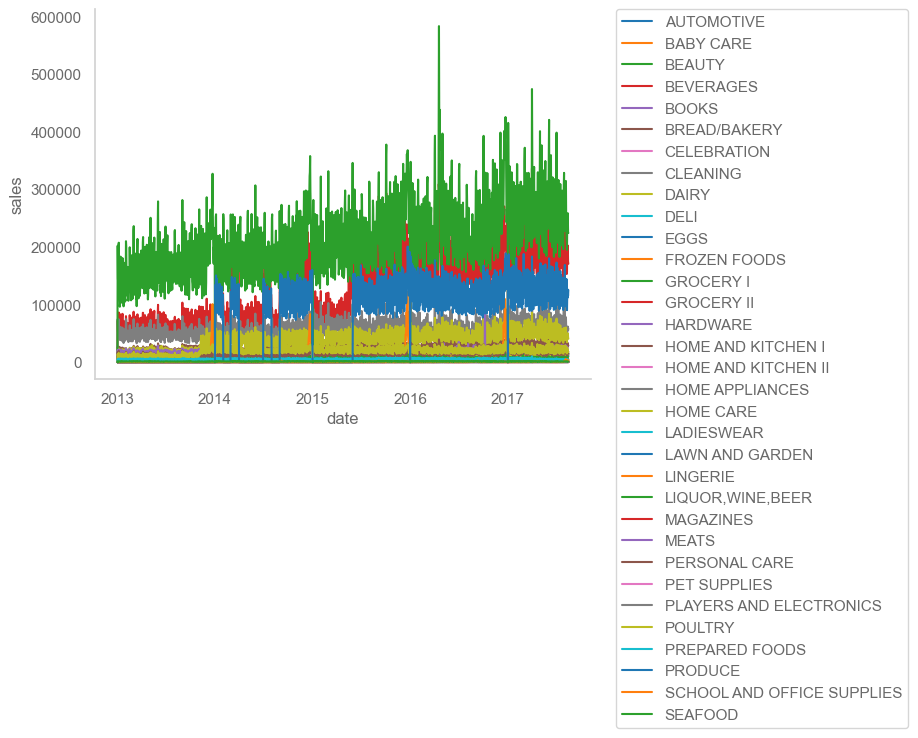

In [8]:
sns.lineplot(data=agg_df, x='date', y='sales', hue='family', palette='tab10')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [9]:
total_sales_df = agg_df.pivot(index = 'date', columns='family', values='sales')
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  LIQUOR,WINE,BEER  MAGAZINES    MEATS  \
date                                                                          
2013-01-01             2.00      5.00            105.00       0.00   110.80   
2013-01-02           121.00    469.00           2411.00       0.00 20871.46   
2013-01-03            83.00    366.00           2476.00       0.00 16597.40   
2013-01-04           127.00    382.00           4796.00       0.00 21625.96   
2013-01-05           180.00    458.00           6715.00       0.00 20879.09   

family      PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  \
date                                                                        
2013-01-01          25.00          0.00                     0.00    42.64   
2013-01-02       17204.00          0.00                     0.00 13975.88   
2013-01-03       12568.00          0.00                     0.00 10674.39   
2013-01-04       11303.00          0.00                     0.00 10772.52   
2013-01-05       16819.00          0.00                     0.00 13475.01   

family      PREPARED FOODS  PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                                      
2013-01-01           37.85     0.00                        0.00     0.00  
2013-01-02         5338.11     0.00                        0.00  1526.75  
2013-01-03         3591.39     0.00                        0.00  1094.31  
2013-01-04         4472.97     0.00                        0.00  1293.12  
2013-01-05         5830.07     0.00                        0.00  1245.64

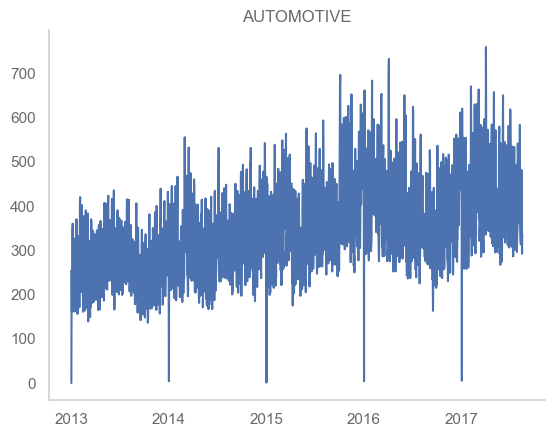

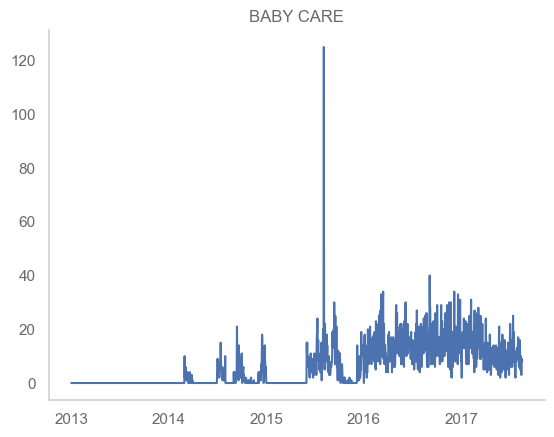

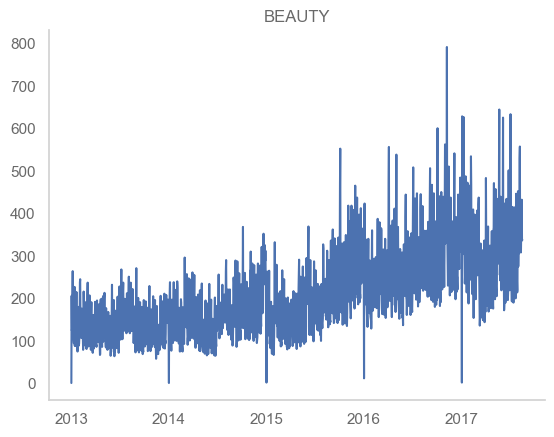

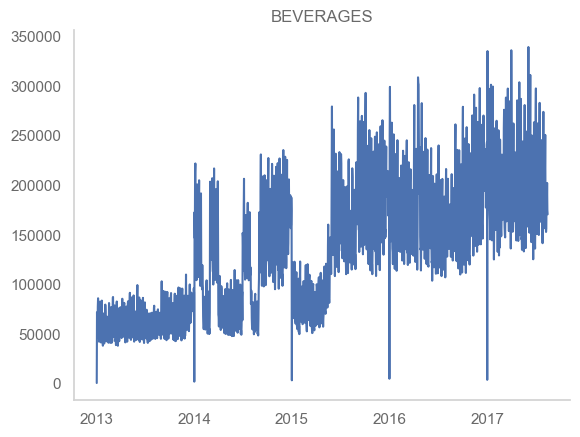

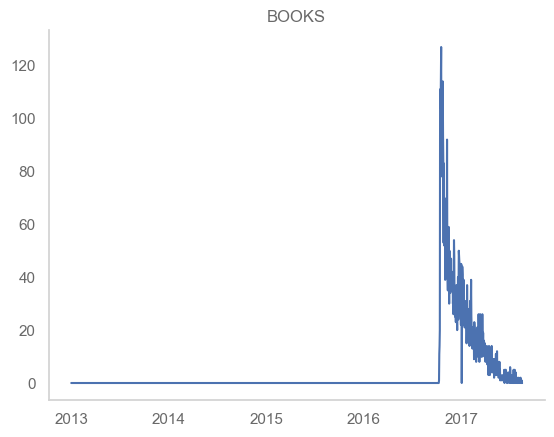

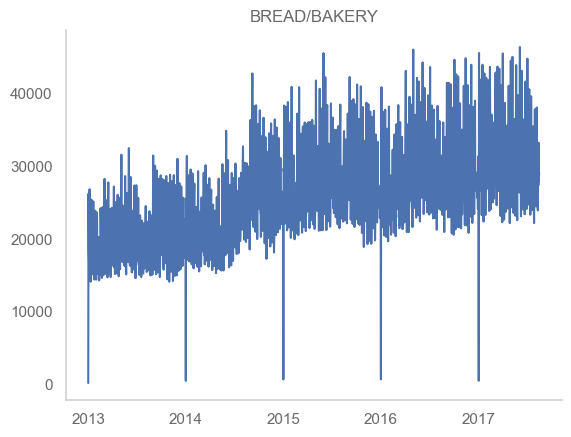

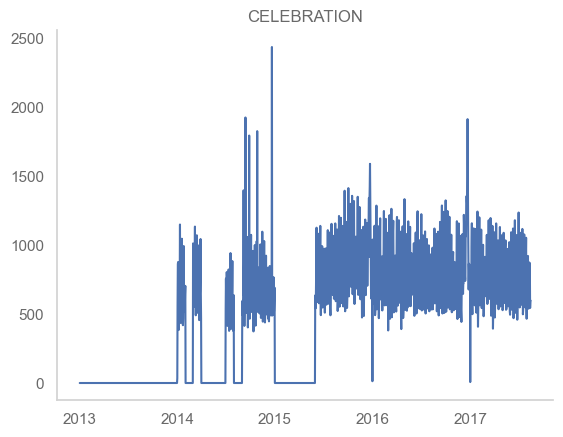

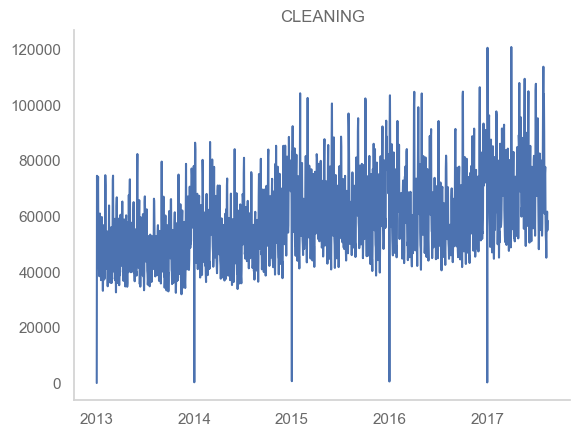

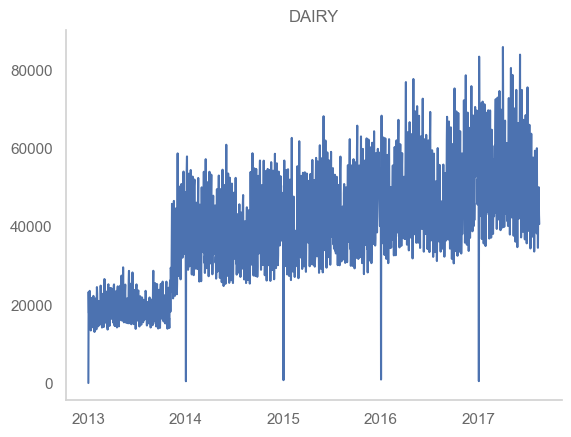

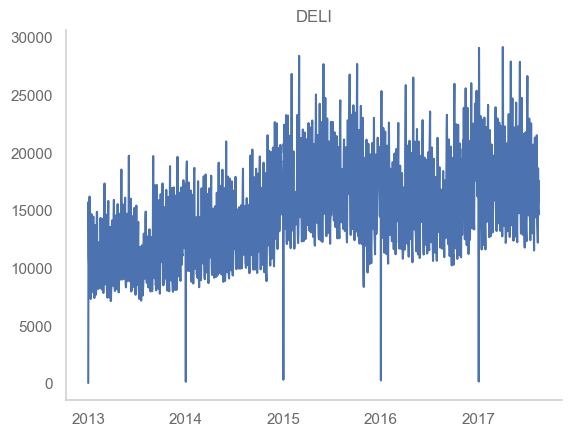

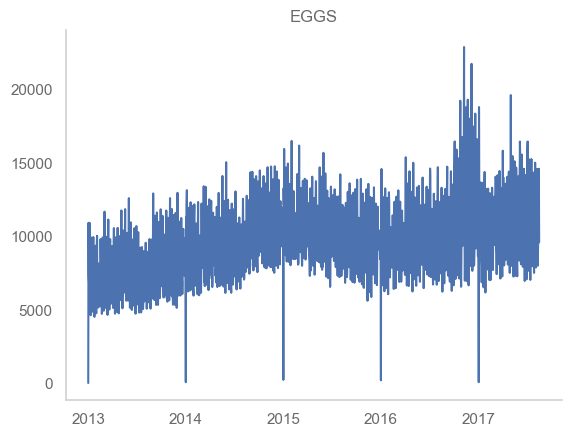

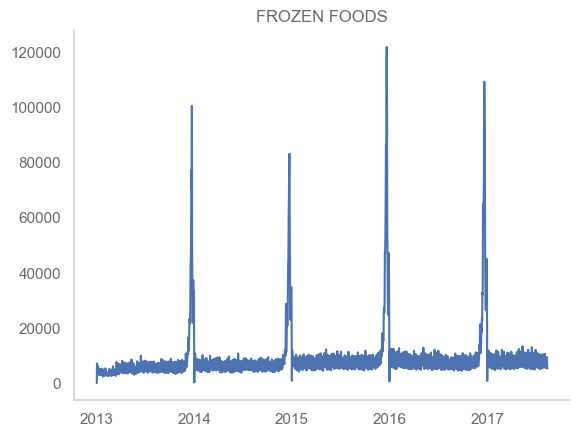

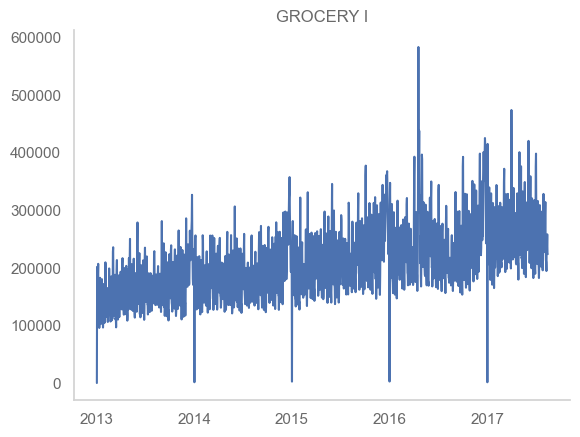

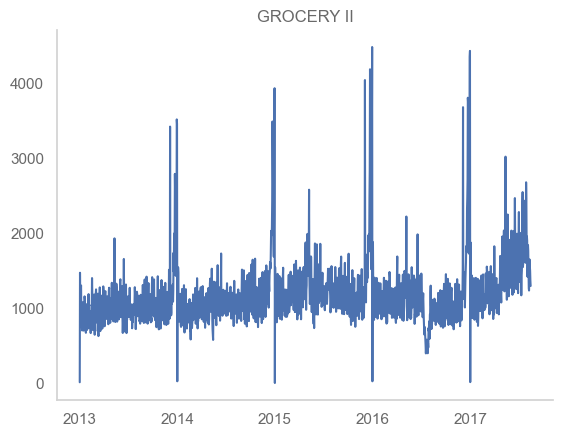

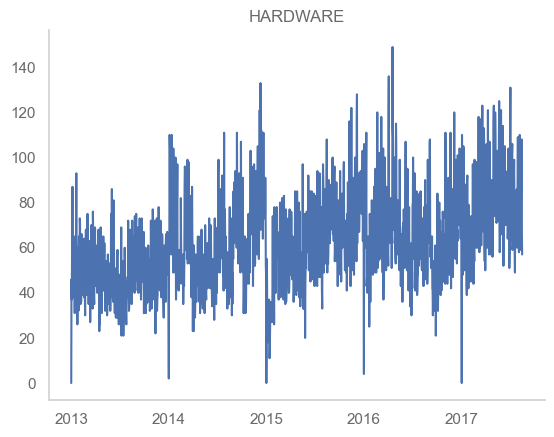

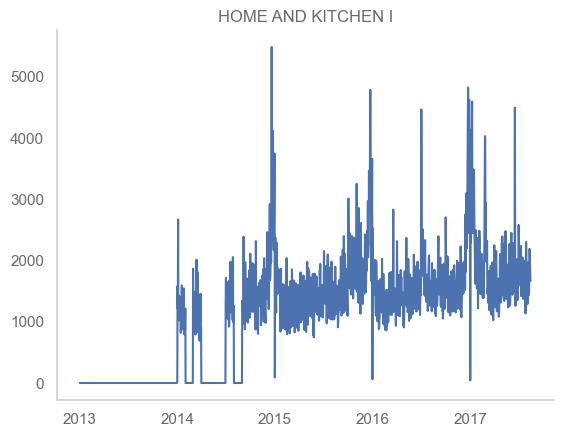

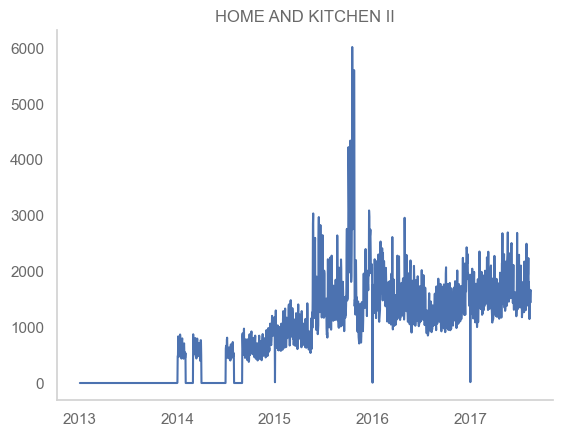

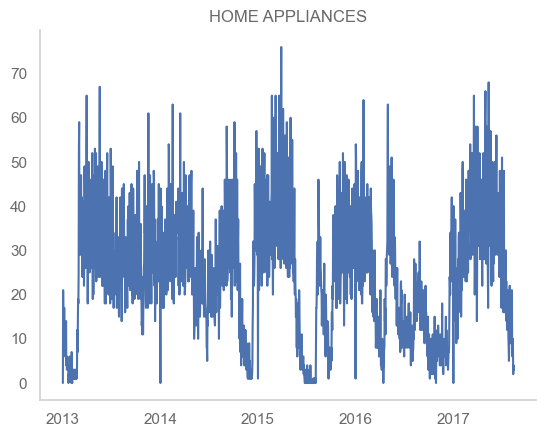

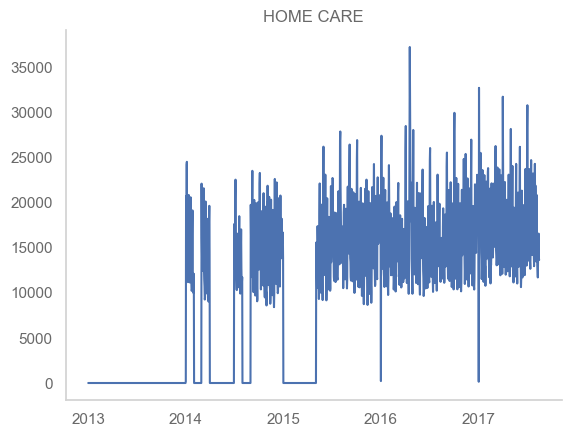

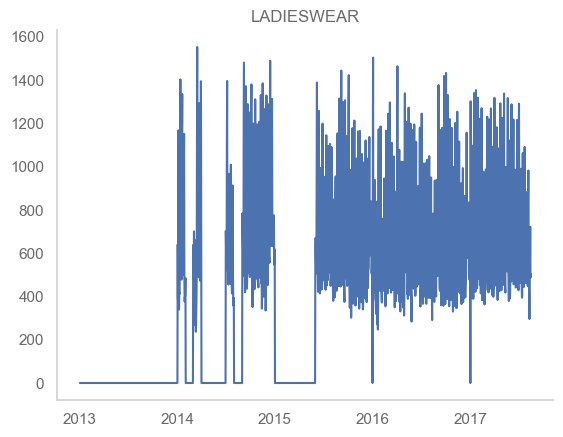

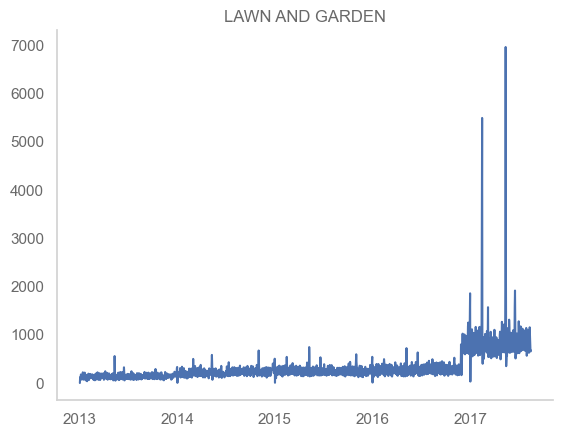

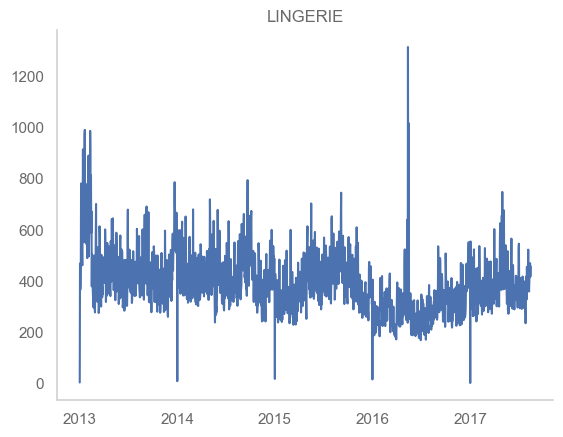

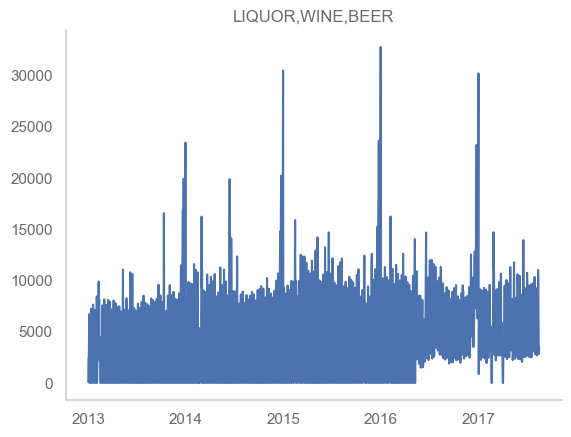

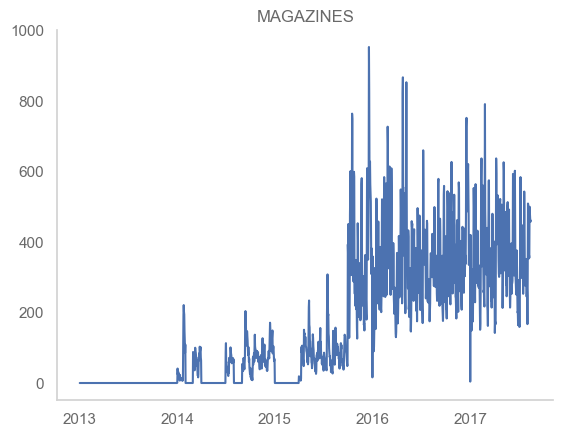

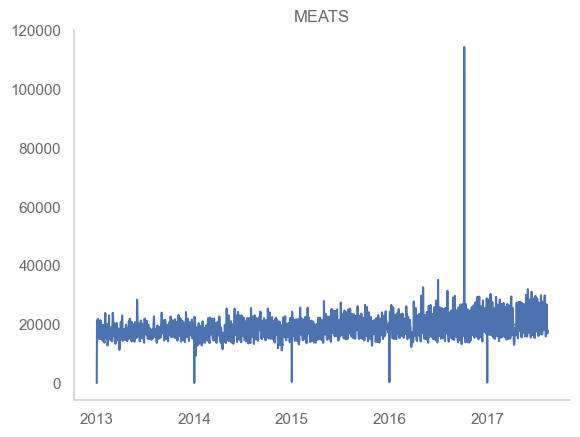

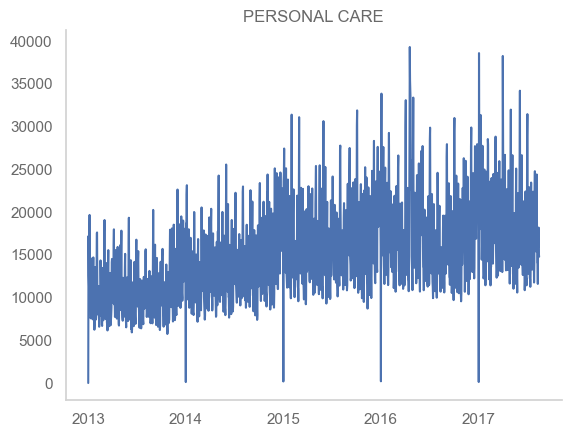

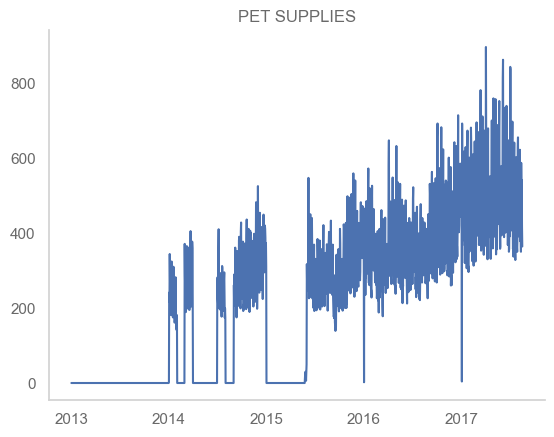

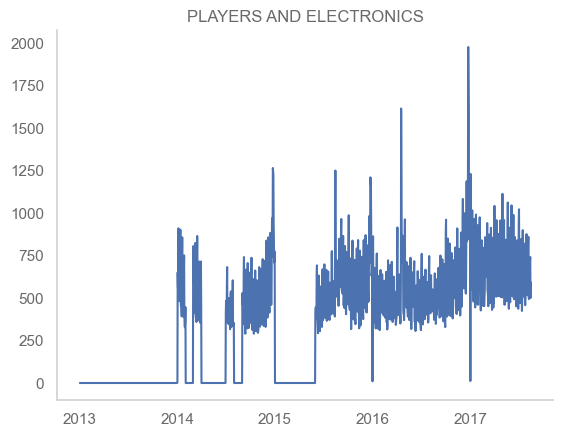

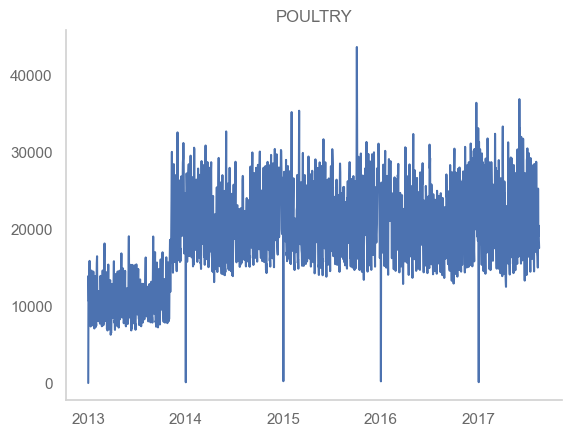

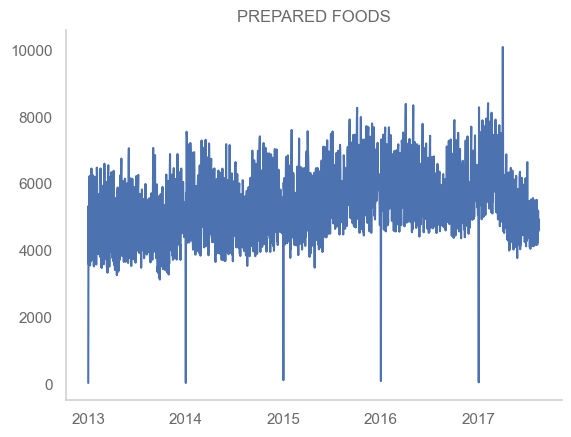

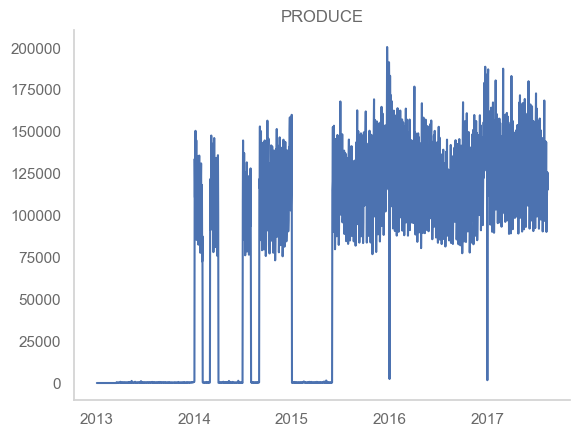

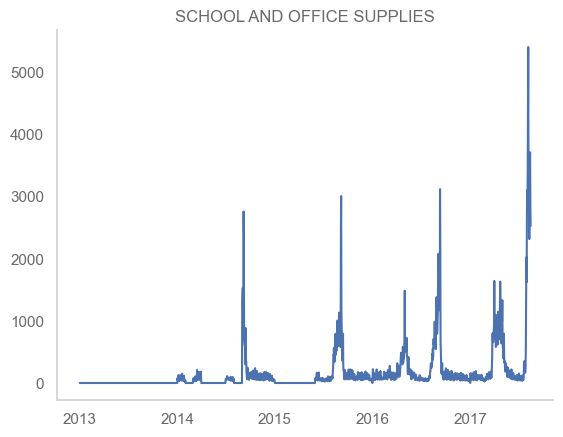

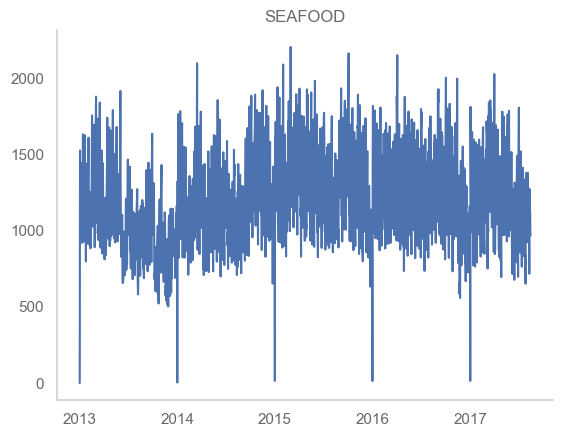

In [10]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

In [11]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [12]:
missing_data(total_sales_df)

Total  Percent    Types
family                                             
AUTOMOTIVE                      0     0.00  float64
BABY CARE                       0     0.00  float64
BEAUTY                          0     0.00  float64
BEVERAGES                       0     0.00  float64
BOOKS                           0     0.00  float64
BREAD/BAKERY                    0     0.00  float64
CELEBRATION                     0     0.00  float64
CLEANING                        0     0.00  float64
DAIRY                           0     0.00  float64
DELI                            0     0.00  float64
EGGS                            0     0.00  float64
FROZEN FOODS                    0     0.00  float64
GROCERY I                       0     0.00  float64
GROCERY II                      0     0.00  float64
HARDWARE                        0     0.00  float64
HOME AND KITCHEN I              0     0.00  float64
HOME AND KITCHEN II             0     0.00  float64
HOME APPLIANCES                 0     0.00  float64
HOME CARE                       0     0.00  float64
LADIESWEAR                      0     0.00  float64
LAWN AND GARDEN                 0     0.00  float64
LINGERIE                        0     0.00  float64
LIQUOR,WINE,BEER                0     0.00  float64
MAGAZINES                       0     0.00  float64
MEATS                           0     0.00  float64
PERSONAL CARE                   0     0.00  float64
PET SUPPLIES                    0     0.00  float64
PLAYERS AND ELECTRONICS         0     0.00  float64
POULTRY                         0     0.00  float64
PREPARED FOODS                  0     0.00  float64
PRODUCE                         0     0.00  float64
SCHOOL AND OFFICE SUPPLIES      0     0.00  float64
SEAFOOD                         0     0.00  float64

###Data Cleaning 
1. Remove low-volume data that can't be predicted.
2. Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.
3. Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.
4. Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.

In [13]:
old_len = len(total_sales_df.columns)
print(old_len)
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]
print(len(total_sales_df.columns))
print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

33
19
Dropping 14 columns due to insufficient data volume.


In [14]:
#Get percentage of rows for each category that is at 0
percentage_zeros = (total_sales_df == 0).astype(int).sum(axis=0) / len(total_sales_df) * 100
print(percentage_zeros)

family
BEVERAGES             0.00
BREAD/BAKERY          0.00
CLEANING              0.00
DAIRY                 0.00
DELI                  0.00
EGGS                  0.00
FROZEN FOODS          0.00
GROCERY I             0.00
GROCERY II            0.00
HOME AND KITCHEN I    0.00
HOME AND KITCHEN II   0.00
HOME CARE             0.00
LIQUOR,WINE,BEER      5.75
MEATS                 0.00
PERSONAL CARE         0.00
POULTRY               0.00
PREPARED FOODS        0.00
PRODUCE               0.00
SEAFOOD               0.00
dtype: float64


In [15]:
print(total_sales_df.columns)

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'LIQUOR,WINE,BEER', 'MEATS',
       'PERSONAL CARE', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')


In [16]:
prediction_df_list = []
#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z>2.5)[0]
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index = outlier_index,inplace = True)
    df_clean.set_index('date', inplace=True)
    # df_clean = df_clean.interpolate(method='linear')
    df_clean = df_clean.ffill()
    # df_clean = df_clean.bfill()
    prediction_df_list.append(df_clean)


Dropping 17 rows for following category: BEVERAGES
Dropping 19 rows for following category: BREAD/BAKERY
Dropping 19 rows for following category: CLEANING
Dropping 16 rows for following category: DAIRY
Dropping 13 rows for following category: DELI
Dropping 13 rows for following category: EGGS
Dropping 23 rows for following category: FROZEN FOODS
Dropping 19 rows for following category: GROCERY I
Dropping 16 rows for following category: GROCERY II
Dropping 25 rows for following category: HOME AND KITCHEN I
Dropping 18 rows for following category: HOME AND KITCHEN II
Dropping 16 rows for following category: HOME CARE
Dropping 14 rows for following category: LIQUOR,WINE,BEER
Dropping 4 rows for following category: MEATS
Dropping 17 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 8 rows for following category: PREPARED FOODS
Dropping 7 rows for following category: PRODUCE
Dropping 6 rows for following category: SEAFOOD


In [17]:
combined_df = pd.concat(prediction_df_list, axis=1)

In [18]:
combined_df = combined_df.dropna()
missing_data(combined_df)

Total  Percent    Types
family                                      
BEVERAGES                0     0.00  float64
BREAD/BAKERY             0     0.00  float64
CLEANING                 0     0.00  float64
DAIRY                    0     0.00  float64
DELI                     0     0.00  float64
EGGS                     0     0.00  float64
FROZEN FOODS             0     0.00  float64
GROCERY I                0     0.00  float64
GROCERY II               0     0.00  float64
HOME AND KITCHEN I       0     0.00  float64
HOME AND KITCHEN II      0     0.00  float64
HOME CARE                0     0.00  float64
LIQUOR,WINE,BEER         0     0.00  float64
MEATS                    0     0.00  float64
PERSONAL CARE            0     0.00  float64
POULTRY                  0     0.00  float64
PREPARED FOODS           0     0.00  float64
PRODUCE                  0     0.00  float64
SEAFOOD                  0     0.00  float64

In [19]:
print(combined_df.head())

family      BEVERAGES  BREAD/BAKERY  CLEANING    DAIRY     DELI     EGGS  \
date                                                                       
2015-08-15  217135.00      32509.91  75837.00 48578.00 19946.92 11232.00   
2015-08-16  208213.00      34851.88  75824.00 50930.00 21178.46 11977.00   
2015-08-17  149741.00      26361.77  59718.00 38358.00 15755.02 10713.00   
2015-08-18  132609.00      23915.95  52749.00 33273.00 14119.25  8123.00   
2015-08-19  131368.00      23995.15  51157.00 35760.00 13250.04  8001.00   

family      FROZEN FOODS  GROCERY I  GROCERY II  HOME AND KITCHEN I  \
date                                                                  
2015-08-15      10075.02  280491.48     1552.00             1899.00   
2015-08-16       7526.03  266657.28     1441.00             1418.00   
2015-08-17       5145.30  205150.61     1161.00             1143.00   
2015-08-18       5050.99  181016.01      955.00             1181.00   
2015-08-19       5372.18  178550.63     1

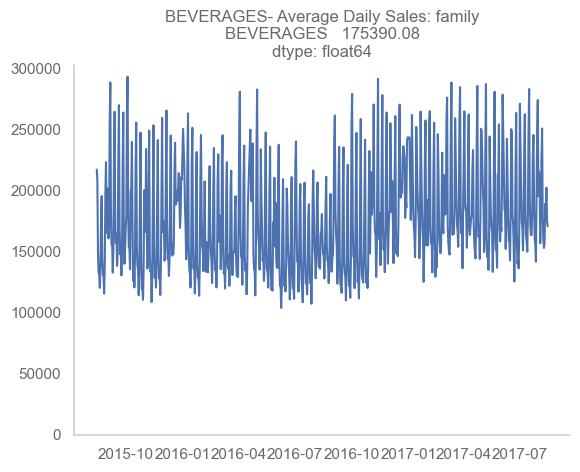

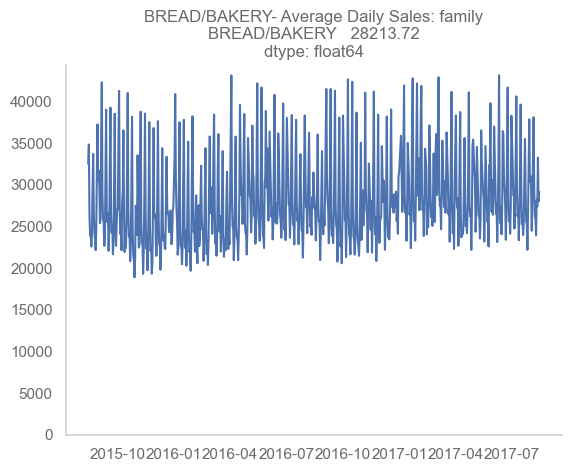

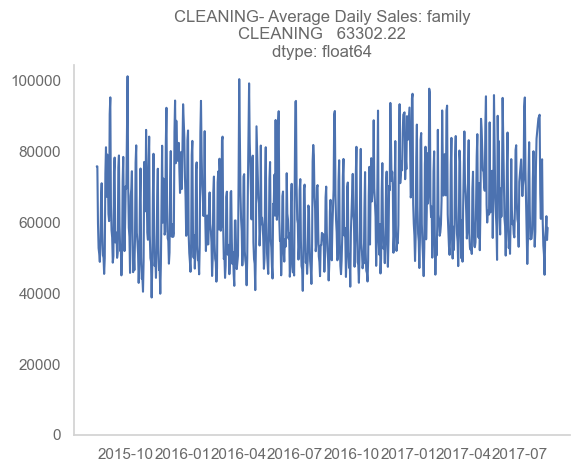

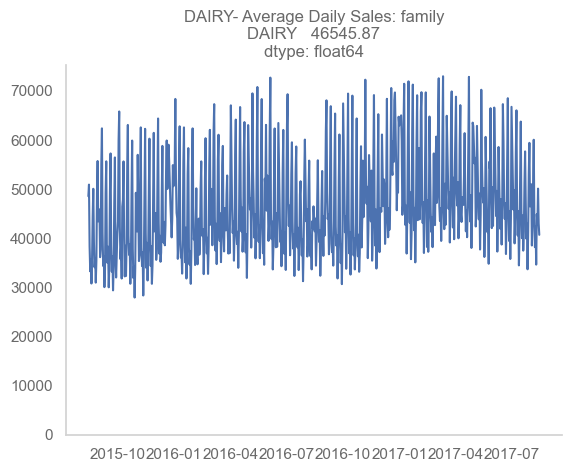

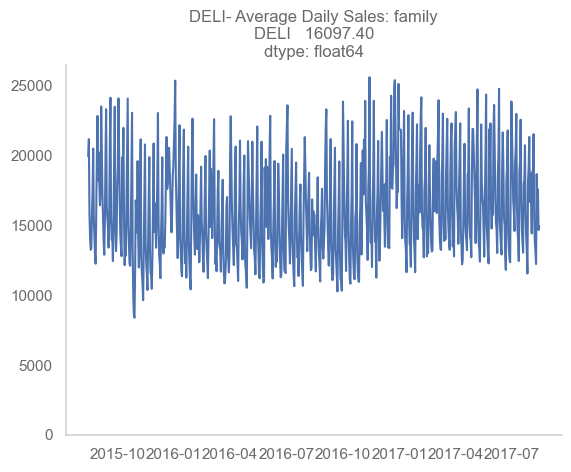

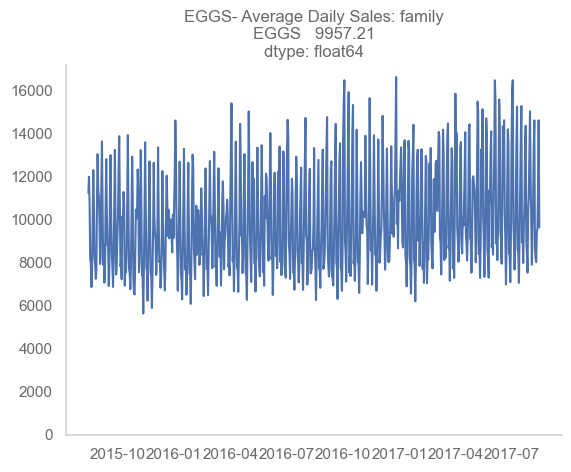

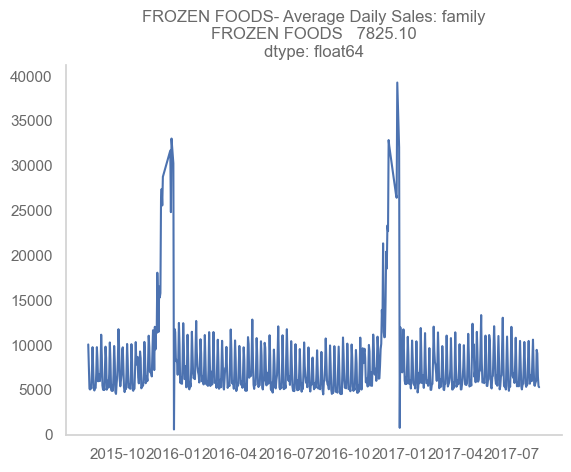

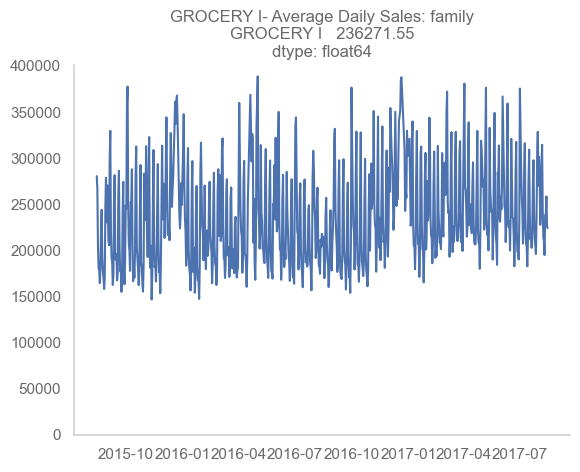

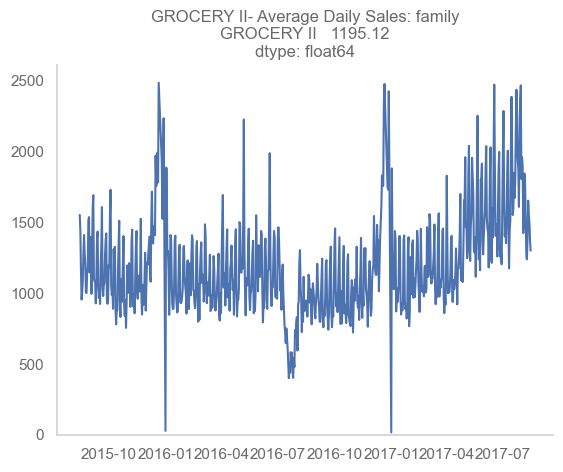

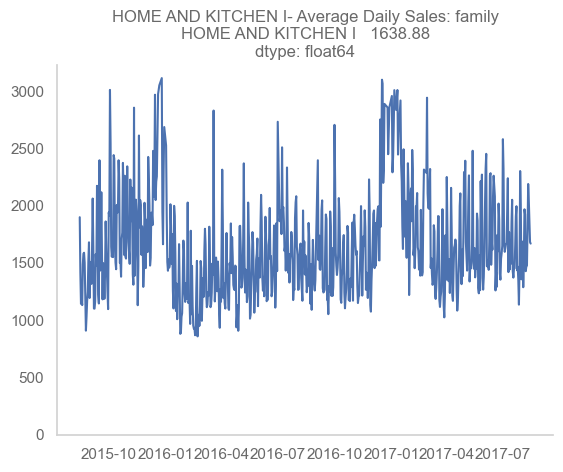

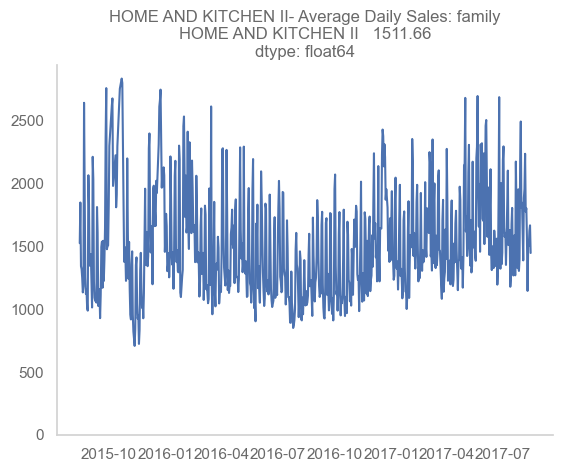

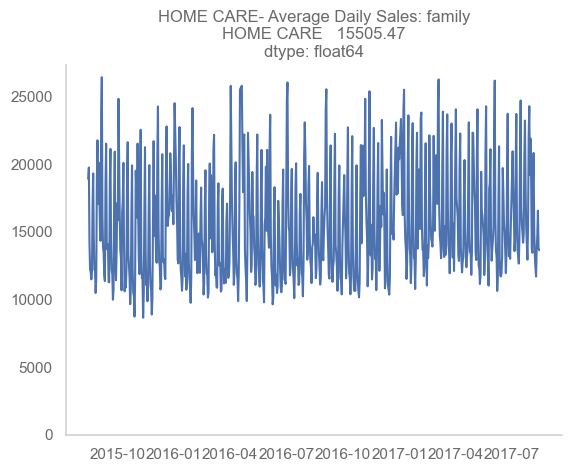

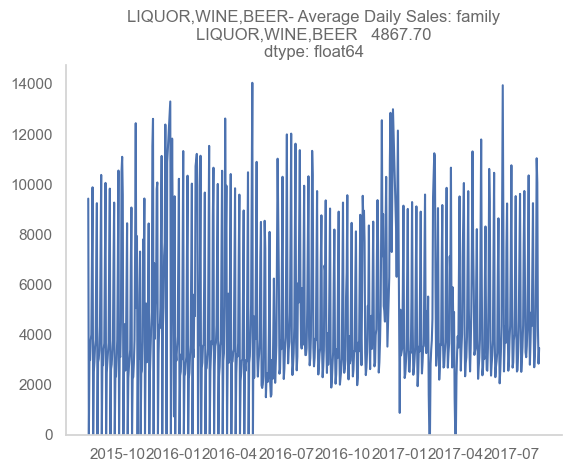

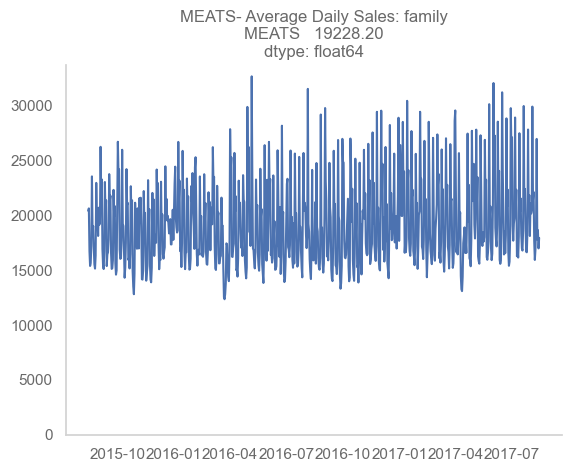

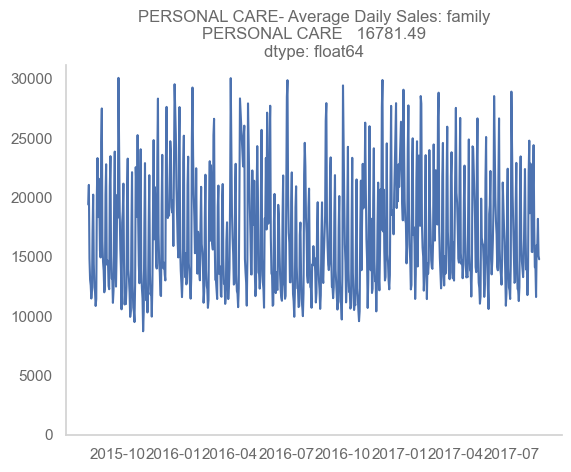

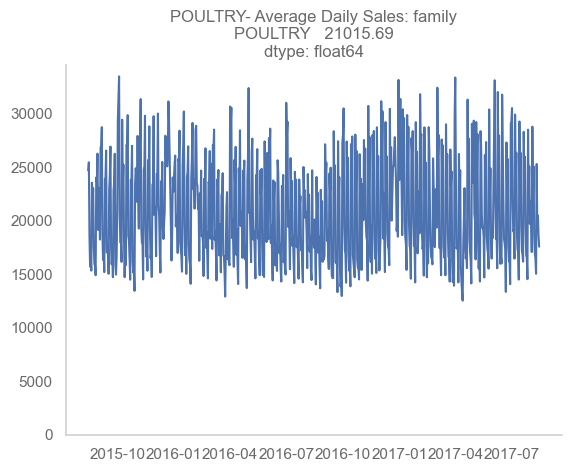

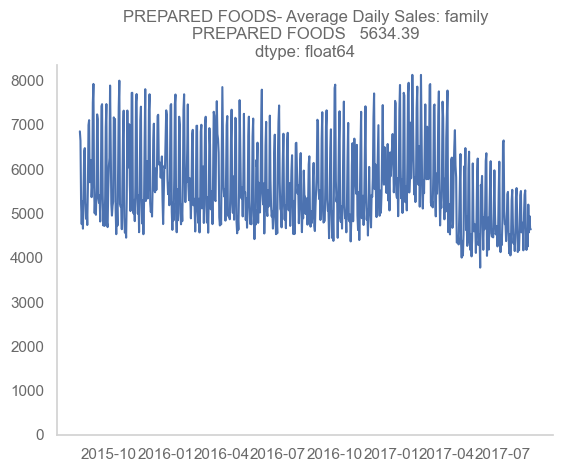

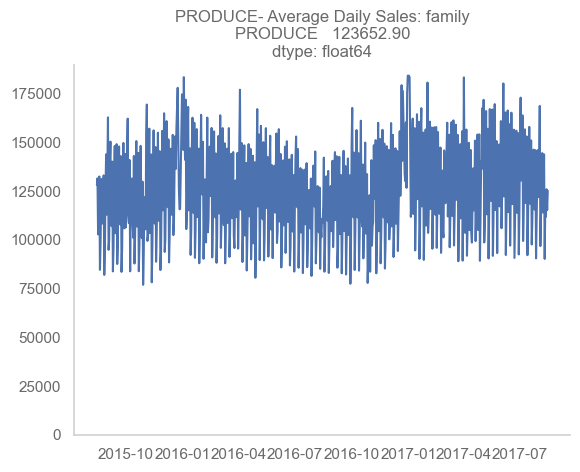

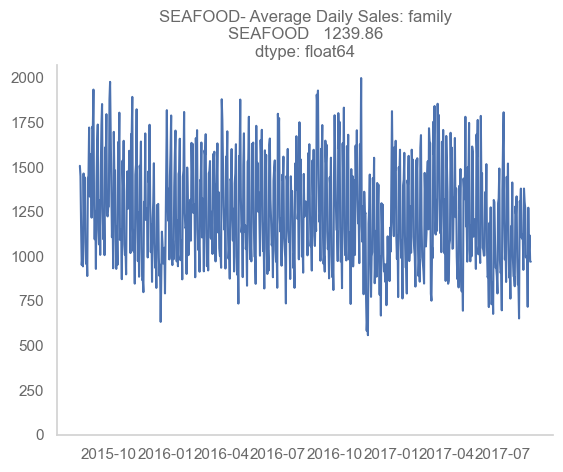

In [20]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

In [21]:
# # Drop the LIQUOR,WINE,BEER column due to too many zeros"
# for df in prediction_df_list:
#     if 'LIQUOR,WINE,BEER' in df.columns:
#         df.drop(columns=['LIQUOR,WINE,BEER'], inplace=True)


In [22]:
avg_daily_sales = combined_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(combined_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [23]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index.tolist()
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index.tolist()

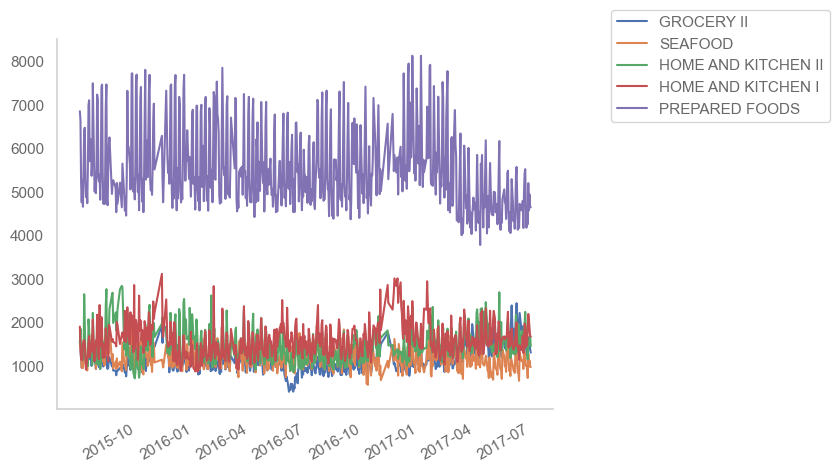

In [24]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(combined_df[low_vol_columns].drop(columns='LIQUOR,WINE,BEER'))
low_vol_columns.remove('LIQUOR,WINE,BEER')
plt.legend(low_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

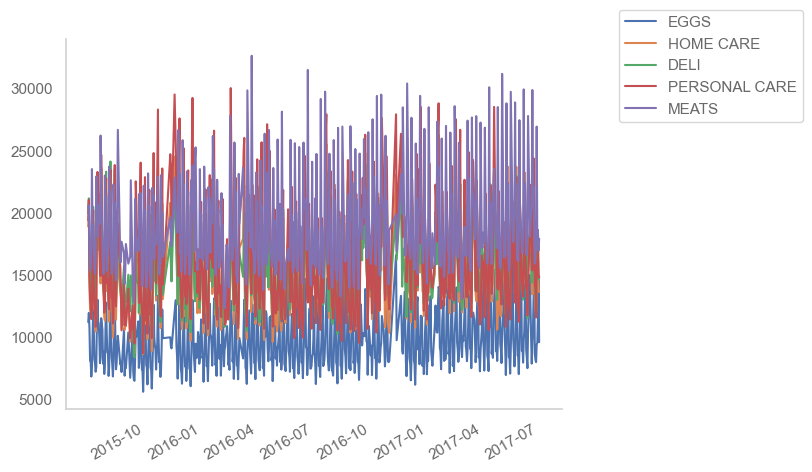

In [25]:
plt.plot(combined_df[mid_vol_columns].drop(columns='FROZEN FOODS'))
mid_vol_columns.remove('FROZEN FOODS')
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

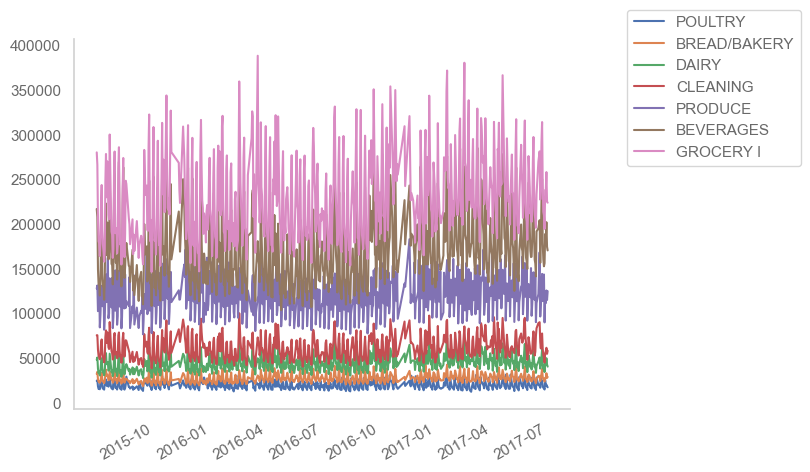

In [26]:
plt.plot(combined_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

In [27]:
combined_df.head()

family      BEVERAGES  BREAD/BAKERY  CLEANING    DAIRY     DELI     EGGS  \
date                                                                       
2015-08-15  217135.00      32509.91  75837.00 48578.00 19946.92 11232.00   
2015-08-16  208213.00      34851.88  75824.00 50930.00 21178.46 11977.00   
2015-08-17  149741.00      26361.77  59718.00 38358.00 15755.02 10713.00   
2015-08-18  132609.00      23915.95  52749.00 33273.00 14119.25  8123.00   
2015-08-19  131368.00      23995.15  51157.00 35760.00 13250.04  8001.00   

family      FROZEN FOODS  GROCERY I  GROCERY II  HOME AND KITCHEN I  \
date                                                                  
2015-08-15      10075.02  280491.48     1552.00             1899.00   
2015-08-16       7526.03  266657.28     1441.00             1418.00   
2015-08-17       5145.30  205150.61     1161.00             1143.00   
2015-08-18       5050.99  181016.01      955.00             1181.00   
2015-08-19       5372.18  178550.63     1011.00             1132.00   

family      HOME AND KITCHEN II  HOME CARE  LIQUOR,WINE,BEER    MEATS  \
date                                                                    
2015-08-15              1526.00   18924.00           9423.00 20403.94   
2015-08-16              1850.00   19757.00              0.00 20616.16   
2015-08-17              1343.00   14120.00           2968.00 16725.03   
2015-08-18              1320.00   12202.00           2984.00 15377.12   
2015-08-19              1249.00   12042.00           3786.00 15654.35   

family      PERSONAL CARE  POULTRY  PREPARED FOODS   PRODUCE  SEAFOOD  
date                                                                   
2015-08-15       19398.00 24718.80         6854.54 128147.18  1507.24  
2015-08-16       21048.00 25480.78         6640.39 131493.93  1448.72  
2015-08-17       14854.00 18549.11         5212.50 102769.60  1166.22  
2015-08-18       13064.00 15722.33         4758.13 106468.23   951.63  
2015-08-19       12581.00 16360.62         5275.08 132449.58   996.73

In [28]:
combined_df = combined_df.drop(columns=['LIQUOR,WINE,BEER', 'FROZEN FOODS'])
print(combined_df.columns)

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
       'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PREPARED FOODS',
       'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')


###HYPERPARAMETER TUNING AND BACKTESTING PIPELINE
Ranges give on Prophet's documentation

1. changepoint_prior_scale [0.001, 0.5]
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10]
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [29]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1, 0.5]
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

In [30]:
start_time = time.time()

dicts = {}

for feature in combined_df.columns:
  
    category_df = combined_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range,
        'holidays_prior_scale': holidays_prior_scale_range}
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())
    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time))

17:28:43 - cmdstanpy - INFO - Chain [1] start processing
17:28:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

17:28:43 - cmdstanpy - INFO - Chain [1] start processing
17:28:44 - cmdstanpy - INFO - Chain [1] done processing
17:28:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:28:44 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:46 - cmdstanpy - INFO - Chain [1] done processing
17:28:46 - cmdstanpy - INFO - Chain [1] start processing
17:28:46 - cmdstanpy - INFO - Chain [1] done processing
17:28:46 - cmdstanpy - INFO - Chain [1] start processing
17:28:46 - cmdstanpy - INFO - Chain [1] done processing
17:28:46 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1568902853.32 39609.38 29259.92  0.16   0.12   0.18      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:28:48 - cmdstanpy - INFO - Chain [1] start processing
17:28:48 - cmdstanpy - INFO - Chain [1] done processing
17:28:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:28:48 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1568902853.32 39609.38 29259.92  0.16   0.12   0.18      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:28:52 - cmdstanpy - INFO - Chain [1] start processing
17:28:52 - cmdstanpy - INFO - Chain [1] done processing
17:28:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:28:52 - cmdstanpy - INFO - Chain [1] start processing
17:28:54 - cmdstanpy - INFO - Chain [1] done processing
17:28:54 - cmdstanpy - INFO - Chain [1] start processing
17:28:54 - cmdstanpy - INFO - Chain [1] done processing
17:28:54 - cmdstanpy - INFO - Chain [1] start processing
17:28:54 - cmdstanpy - INFO - Chain [1] done processing
17:28:54 - cmdstanpy - INFO - Chain [1] start processing
17:28:54 - cmdstanpy - INFO - Chain [1] done processing
17:28:54 - cmdstanpy - INFO - Chain [1] start processing
17:28:54 - cmdstanpy - INFO - Chain [1] done processing
17:28:54 - cmdstanpy - INFO - Chain [1] start processing
17:28:54 - cmdstanpy - INFO - Chain [1] done processing
17:28:54 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1568902853.32 39609.38 29259.92  0.16   0.12   0.18      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:28:56 - cmdstanpy - INFO - Chain [1] start processing
17:28:56 - cmdstanpy - INFO - Chain [1] done processing
17:28:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:28:56 - cmdstanpy - INFO - Chain [1] start processing
17:28:58 - cmdstanpy - INFO - Chain [1] done processing
17:28:58 - cmdstanpy - INFO - Chain [1] start processing
17:28:58 - cmdstanpy - INFO - Chain [1] done processing
17:28:58 - cmdstanpy - INFO - Chain [1] start processing
17:28:58 - cmdstanpy - INFO - Chain [1] done processing
17:28:58 - cmdstanpy - INFO - Chain [1] start processing
17:28:58 - cmdstanpy - INFO - Chain [1] done processing
17:28:58 - cmdstanpy - INFO - Chain [1] start processing
17:28:58 - cmdstanpy - INFO - Chain [1] done processing
17:28:59 - cmdstanpy - INFO - Chain [1] start processing
17:28:59 - cmdstanpy - INFO - Chain [1] done processing
17:28:59 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1568902853.32 39609.38 29259.92  0.16   0.12   0.18      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:01 - cmdstanpy - INFO - Chain [1] start processing
17:29:01 - cmdstanpy - INFO - Chain [1] done processing
17:29:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:01 - cmdstanpy - INFO - Chain [1] start processing
17:29:03 - cmdstanpy - INFO - Chain [1] done processing
17:29:03 - cmdstanpy - INFO - Chain [1] start processing
17:29:03 - cmdstanpy - INFO - Chain [1] done processing
17:29:03 - cmdstanpy - INFO - Chain [1] start processing
17:29:03 - cmdstanpy - INFO - Chain [1] done processing
17:29:03 - cmdstanpy - INFO - Chain [1] start processing
17:29:03 - cmdstanpy - INFO - Chain [1] done processing
17:29:03 - cmdstanpy - INFO - Chain [1] start processing
17:29:03 - cmdstanpy - INFO - Chain [1] done processing
17:29:03 - cmdstanpy - INFO - Chain [1] start processing
17:29:03 - cmdstanpy - INFO - Chain [1] done processing
17:29:03 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1568902853.32 39609.38 29259.92  0.16   0.12   0.18      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:06 - cmdstanpy - INFO - Chain [1] start processing
17:29:06 - cmdstanpy - INFO - Chain [1] done processing
17:29:06 - cmdstanpy - INFO - Chain [1] start processing
17:29:06 - cmdstanpy - INFO - Chain [1] done processing
17:29:06 - cmdstanpy - INFO - Chain [1] start processing
17:29:06 - cmdstanpy - INFO - Chain [1] done processing
17:29:06 - cmdstanpy - INFO - Chain [1] start processing
17:29:06 - cmdstanpy - INFO - Chain [1] done processing
17:29:06 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1364992500.58 36945.80 28863.47  0.16   0.14   0.18      0.51


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:08 - cmdstanpy - INFO - Chain [1] start processing
17:29:08 - cmdstanpy - INFO - Chain [1] done processing
17:29:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:08 - cmdstanpy - INFO - Chain [1] start processing
17:29:09 - cmdstanpy - INFO - Chain [1] done processing
17:29:09 - cmdstanpy - INFO - Chain [1] start processing
17:29:09 - cmdstanpy - INFO - Chain [1] done processing
17:29:09 - cmdstanpy - INFO - Chain [1] start processing
17:29:09 - cmdstanpy - INFO - Chain [1] done processing
17:29:09 - cmdstanpy - INFO - Chain [1] start processing
17:29:09 - cmdstanpy - INFO - Chain [1] done processing
17:29:09 - cmdstanpy - INFO - Chain [1] start processing
17:29:09 - cmdstanpy - INFO - Chain [1] done processing
17:29:09 - cmdstanpy - INFO - Chain [1] start processing
17:29:09 - cmdstanpy - INFO - Chain [1] done processing
17:29:09 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1364992500.58 36945.80 28863.47  0.16   0.14   0.18      0.51


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:12 - cmdstanpy - INFO - Chain [1] start processing
17:29:12 - cmdstanpy - INFO - Chain [1] done processing
17:29:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:12 - cmdstanpy - INFO - Chain [1] start processing
17:29:12 - cmdstanpy - INFO - Chain [1] done processing
17:29:12 - cmdstanpy - INFO - Chain [1] start processing
17:29:12 - cmdstanpy - INFO - Chain [1] done processing
17:29:12 - cmdstanpy - INFO - Chain [1] start processing
17:29:12 - cmdstanpy - INFO - Chain [1] done processing
17:29:13 - cmdstanpy - INFO - Chain [1] start processing
17:29:13 - cmdstanpy - INFO - Chain [1] done processing
17:29:13 - cmdstanpy - INFO - Chain [1] start processing
17:29:13 - cmdstanpy - INFO - Chain [1] done processing
17:29:13 - cmdstanpy - INFO - Chain [1] start processing
17:29:13 - cmdstanpy - INFO - Chain [1] done processing
17:29:13 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1364992500.58 36945.80 28863.47  0.16   0.14   0.18      0.51


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:15 - cmdstanpy - INFO - Chain [1] start processing
17:29:15 - cmdstanpy - INFO - Chain [1] done processing
17:29:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:16 - cmdstanpy - INFO - Chain [1] start processing
17:29:16 - cmdstanpy - INFO - Chain [1] done processing
17:29:16 - cmdstanpy - INFO - Chain [1] start processing
17:29:16 - cmdstanpy - INFO - Chain [1] done processing
17:29:16 - cmdstanpy - INFO - Chain [1] start processing
17:29:16 - cmdstanpy - INFO - Chain [1] done processing
17:29:16 - cmdstanpy - INFO - Chain [1] start processing
17:29:16 - cmdstanpy - INFO - Chain [1] done processing
17:29:16 - cmdstanpy - INFO - Chain [1] start processing
17:29:16 - cmdstanpy - INFO - Chain [1] done processing
17:29:16 - cmdstanpy - INFO - Chain [1] start processing
17:29:16 - cmdstanpy - INFO - Chain [1] done processing
17:29:16 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1364992500.58 36945.80 28863.47  0.16   0.14   0.18      0.50


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:19 - cmdstanpy - INFO - Chain [1] start processing
17:29:19 - cmdstanpy - INFO - Chain [1] done processing
17:29:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:19 - cmdstanpy - INFO - Chain [1] start processing
17:29:19 - cmdstanpy - INFO - Chain [1] done processing
17:29:19 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1364992500.58 36945.80 28863.47  0.16   0.14   0.18      0.50


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:22 - cmdstanpy - INFO - Chain [1] start processing
17:29:22 - cmdstanpy - INFO - Chain [1] done processing
17:29:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:22 - cmdstanpy - INFO - Chain [1] start processing
17:29:23 - cmdstanpy - INFO - Chain [1] done processing
17:29:23 - cmdstanpy - INFO - Chain [1] start processing
17:29:23 - cmdstanpy - INFO - Chain [1] done processing
17:29:23 - cmdstanpy - INFO - Chain [1] start processing
17:29:23 - cmdstanpy - INFO - Chain [1] done processing
17:29:23 - cmdstanpy - INFO - Chain [1] start processing
17:29:24 - cmdstanpy - INFO - Chain [1] done processing
17:29:24 - cmdstanpy - INFO - Chain [1] start processing
17:29:24 - cmdstanpy - INFO - Chain [1] done processing
17:29:24 - cmdstanpy - INFO - Chain [1] start processing
17:29:24 - cmdstanpy - INFO - Chain [1] done processing
17:29:24 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1281525761.64 35798.40 28375.71  0.16   0.14   0.18      0.50


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:27 - cmdstanpy - INFO - Chain [1] start processing
17:29:27 - cmdstanpy - INFO - Chain [1] done processing
17:29:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:27 - cmdstanpy - INFO - Chain [1] start processing
17:29:28 - cmdstanpy - INFO - Chain [1] done processing
17:29:28 - cmdstanpy - INFO - Chain [1] start processing
17:29:28 - cmdstanpy - INFO - Chain [1] done processing
17:29:28 - cmdstanpy - INFO - Chain [1] start processing
17:29:28 - cmdstanpy - INFO - Chain [1] done processing
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing
17:29:29 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1281525761.64 35798.40 28375.71  0.16   0.14   0.18      0.51


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:32 - cmdstanpy - INFO - Chain [1] start processing
17:29:32 - cmdstanpy - INFO - Chain [1] done processing
17:29:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:32 - cmdstanpy - INFO - Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
17:29:33 - cmdstanpy - INFO - Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
17:29:33 - cmdstanpy - INFO - Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
17:29:33 - cmdstanpy - INFO - Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
17:29:33 - cmdstanpy - INFO - Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
17:29:33 - cmdstanpy - INFO - Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
17:29:33 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1281525761.64 35798.40 28375.71  0.16   0.14   0.18      0.50


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:36 - cmdstanpy - INFO - Chain [1] start processing
17:29:36 - cmdstanpy - INFO - Chain [1] done processing
17:29:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:36 - cmdstanpy - INFO - Chain [1] start processing
17:29:37 - cmdstanpy - INFO - Chain [1] done processing
17:29:37 - cmdstanpy - INFO - Chain [1] start processing
17:29:37 - cmdstanpy - INFO - Chain [1] done processing
17:29:37 - cmdstanpy - INFO - Chain [1] start processing
17:29:37 - cmdstanpy - INFO - Chain [1] done processing
17:29:37 - cmdstanpy - INFO - Chain [1] start processing
17:29:37 - cmdstanpy - INFO - Chain [1] done processing
17:29:37 - cmdstanpy - INFO - Chain [1] start processing
17:29:37 - cmdstanpy - INFO - Chain [1] done processing
17:29:37 - cmdstanpy - INFO - Chain [1] start processing
17:29:37 - cmdstanpy - INFO - Chain [1] done processing
17:29:37 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1281525761.64 35798.40 28375.71  0.16   0.14   0.18      0.50


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:40 - cmdstanpy - INFO - Chain [1] start processing
17:29:40 - cmdstanpy - INFO - Chain [1] done processing
17:29:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:40 - cmdstanpy - INFO - Chain [1] start processing
17:29:41 - cmdstanpy - INFO - Chain [1] done processing
17:29:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:41 - cmdstanpy - INFO - Chain [1] done processing
17:29:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:41 - cmdstanpy - INFO - Chain [1] done processing
17:29:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:41 - cmdstanpy - INFO - Chain [1] done processing
17:29:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:41 - cmdstanpy - INFO - Chain [1] done processing
17:29:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:41 - cmdstanpy - INFO - Chain [1] done processing
17:29:41 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1281525761.64 35798.40 28375.71  0.16   0.14   0.18      0.50


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing
17:29:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:45 - cmdstanpy - INFO - Chain [1] done processing
17:29:45 - cmdstanpy - INFO - Chain [1] start processing
17:29:45 - cmdstanpy - INFO - Chain [1] done processing
17:29:45 - cmdstanpy - INFO - Chain [1] start processing
17:29:45 - cmdstanpy - INFO - Chain [1] done processing
17:29:45 - cmdstanpy - INFO - Chain [1] start processing
17:29:45 - cmdstanpy - INFO - Chain [1] done processing
17:29:45 - cmdstanpy - INFO - Chain [1] start processing
17:29:45 - cmdstanpy - INFO - Chain [1] done processing
17:29:45 - cmdstanpy - INFO - Chain [1] start processing
17:29:45 - cmdstanpy - INFO - Chain [1] done processing
17:29:45 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1425440136.28 37755.00 29265.95  0.17   0.14   0.19      0.49


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:48 - cmdstanpy - INFO - Chain [1] start processing
17:29:48 - cmdstanpy - INFO - Chain [1] done processing
17:29:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:48 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1425440136.28 37755.00 29265.95  0.17   0.14   0.19      0.50


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:52 - cmdstanpy - INFO - Chain [1] start processing
17:29:52 - cmdstanpy - INFO - Chain [1] done processing
17:29:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:52 - cmdstanpy - INFO - Chain [1] start processing
17:29:52 - cmdstanpy - INFO - Chain [1] done processing
17:29:52 - cmdstanpy - INFO - Chain [1] start processing
17:29:52 - cmdstanpy - INFO - Chain [1] done processing
17:29:52 - cmdstanpy - INFO - Chain [1] start processing
17:29:52 - cmdstanpy - INFO - Chain [1] done processing
17:29:53 - cmdstanpy - INFO - Chain [1] start processing
17:29:53 - cmdstanpy - INFO - Chain [1] done processing
17:29:53 - cmdstanpy - INFO - Chain [1] start processing
17:29:53 - cmdstanpy - INFO - Chain [1] done processing
17:29:53 - cmdstanpy - INFO - Chain [1] start processing
17:29:53 - cmdstanpy - INFO - Chain [1] done processing
17:29:53 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1425440136.28 37755.00 29265.95  0.17   0.14   0.19      0.50


  0%|          | 0/12 [00:00<?, ?it/s]

17:29:56 - cmdstanpy - INFO - Chain [1] start processing
17:29:56 - cmdstanpy - INFO - Chain [1] done processing
17:29:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:29:56 - cmdstanpy - INFO - Chain [1] start processing
17:29:56 - cmdstanpy - INFO - Chain [1] done processing
17:29:56 - cmdstanpy - INFO - Chain [1] start processing
17:29:56 - cmdstanpy - INFO - Chain [1] done processing
17:29:56 - cmdstanpy - INFO - Chain [1] start processing
17:29:56 - cmdstanpy - INFO - Chain [1] done processing
17:29:56 - cmdstanpy - INFO - Chain [1] start processing
17:29:56 - cmdstanpy - INFO - Chain [1] done processing
17:29:56 - cmdstanpy - INFO - Chain [1] start processing
17:29:56 - cmdstanpy - INFO - Chain [1] done processing
17:29:57 - cmdstanpy - INFO - Chain [1] start processing
17:29:57 - cmdstanpy - INFO - Chain [1] done processing
17:29:57 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1425440136.28 37755.00 29265.95  0.17   0.14   0.19      0.50


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:01 - cmdstanpy - INFO - Chain [1] start processing
17:30:01 - cmdstanpy - INFO - Chain [1] done processing
17:30:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:30:01 - cmdstanpy - INFO - Chain [1] start processing
17:30:01 - cmdstanpy - INFO - Chain [1] done processing
17:30:01 - cmdstanpy - INFO - Chain [1] start processing
17:30:01 - cmdstanpy - INFO - Chain [1] done processing
17:30:01 - cmdstanpy - INFO - Chain [1] start processing
17:30:01 - cmdstanpy - INFO - Chain [1] done processing
17:30:01 - cmdstanpy - INFO - Chain [1] start processing
17:30:01 - cmdstanpy - INFO - Chain [1] done processing
17:30:01 - cmdstanpy - INFO - Chain [1] start processing
17:30:01 - cmdstanpy - INFO - Chain [1] done processing
17:30:02 - cmdstanpy - INFO - Chain [1] start processing
17:30:02 - cmdstanpy - INFO - Chain [1] done processing
17:30:02 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1425440136.28 37755.00 29265.95  0.17   0.14   0.19      0.50


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:05 - cmdstanpy - INFO - Chain [1] start processing
17:30:05 - cmdstanpy - INFO - Chain [1] done processing
17:30:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:30:05 - cmdstanpy - INFO - Chain [1] start processing
17:30:08 - cmdstanpy - INFO - Chain [1] done processing
17:30:08 - cmdstanpy - INFO - Chain [1] start processing
17:30:08 - cmdstanpy - INFO - Chain [1] done processing
17:30:08 - cmdstanpy - INFO - Chain [1] start processing
17:30:08 - cmdstanpy - INFO - Chain [1] done processing
17:30:08 - cmdstanpy - INFO - Chain [1] start processing
17:30:08 - cmdstanpy - INFO - Chain [1] done processing
17:30:08 - cmdstanpy - INFO - Chain [1] start processing
17:30:08 - cmdstanpy - INFO - Chain [1] done processing
17:30:08 - cmdstanpy - INFO - Chain [1] start processing
17:30:08 - cmdstanpy - INFO - Chain [1] done processing
17:30:08 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1618805238.66 40234.38 30985.64  0.18   0.15   0.20      0.48


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:13 - cmdstanpy - INFO - Chain [1] start processing
17:30:13 - cmdstanpy - INFO - Chain [1] done processing
17:30:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:30:13 - cmdstanpy - INFO - Chain [1] start processing
17:30:16 - cmdstanpy - INFO - Chain [1] done processing
17:30:16 - cmdstanpy - INFO - Chain [1] start processing
17:30:16 - cmdstanpy - INFO - Chain [1] done processing
17:30:16 - cmdstanpy - INFO - Chain [1] start processing
17:30:16 - cmdstanpy - INFO - Chain [1] done processing
17:30:16 - cmdstanpy - INFO - Chain [1] start processing
17:30:16 - cmdstanpy - INFO - Chain [1] done processing
17:30:16 - cmdstanpy - INFO - Chain [1] start processing
17:30:16 - cmdstanpy - INFO - Chain [1] done processing
17:30:16 - cmdstanpy - INFO - Chain [1] start processing
17:30:16 - cmdstanpy - INFO - Chain [1] done processing
17:30:16 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1618805238.66 40234.38 30985.64  0.18   0.15   0.20      0.48


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:20 - cmdstanpy - INFO - Chain [1] start processing
17:30:20 - cmdstanpy - INFO - Chain [1] done processing
17:30:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:30:20 - cmdstanpy - INFO - Chain [1] start processing
17:30:23 - cmdstanpy - INFO - Chain [1] done processing
17:30:23 - cmdstanpy - INFO - Chain [1] start processing
17:30:23 - cmdstanpy - INFO - Chain [1] done processing
17:30:23 - cmdstanpy - INFO - Chain [1] start processing
17:30:23 - cmdstanpy - INFO - Chain [1] done processing
17:30:23 - cmdstanpy - INFO - Chain [1] start processing
17:30:23 - cmdstanpy - INFO - Chain [1] done processing
17:30:23 - cmdstanpy - INFO - Chain [1] start processing
17:30:23 - cmdstanpy - INFO - Chain [1] done processing
17:30:23 - cmdstanpy - INFO - Chain [1] start processing
17:30:23 - cmdstanpy - INFO - Chain [1] done processing
17:30:23 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1618805238.66 40234.38 30985.64  0.18   0.15   0.20      0.49


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:26 - cmdstanpy - INFO - Chain [1] done processing
17:30:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:29 - cmdstanpy - INFO - Chain [1] done processing
17:30:29 - cmdstanpy - INFO - Chain [1] start processing
17:30:29 - cmdstanpy - INFO - Chain [1] done processing
17:30:29 - cmdstanpy - INFO - Chain [1] start processing
17:30:29 - cmdstanpy - INFO - Chain [1] done processing
17:30:29 - cmdstanpy - INFO - Chain [1] start processing
17:30:29 - cmdstanpy - INFO - Chain [1] done processing
17:30:29 - cmdstanpy - INFO - Chain [1] start processing
17:30:30 - cmdstanpy - INFO - Chain [1] done processing
17:30:30 - cmdstanpy - INFO - Chain [1] start processing
17:30:30 - cmdstanpy - INFO - Chain [1] done processing
17:30:30 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1618805238.66 40234.38 30985.64  0.18   0.15   0.20      0.49


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:33 - cmdstanpy - INFO - Chain [1] start processing
17:30:33 - cmdstanpy - INFO - Chain [1] done processing
17:30:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:30:33 - cmdstanpy - INFO - Chain [1] start processing
17:30:36 - cmdstanpy - INFO - Chain [1] done processing
17:30:36 - cmdstanpy - INFO - Chain [1] start processing
17:30:36 - cmdstanpy - INFO - Chain [1] done processing
17:30:36 - cmdstanpy - INFO - Chain [1] start processing
17:30:36 - cmdstanpy - INFO - Chain [1] done processing
17:30:36 - cmdstanpy - INFO - Chain [1] start processing
17:30:36 - cmdstanpy - INFO - Chain [1] done processing
17:30:36 - cmdstanpy - INFO - Chain [1] start processing
17:30:36 - cmdstanpy - INFO - Chain [1] done processing
17:30:36 - cmdstanpy - INFO - Chain [1] start processing
17:30:36 - cmdstanpy - INFO - Chain [1] done processing
17:30:36 - cmdstanpy - ERROR - Chain [1] error: error

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1618805238.66 40234.38 30985.64  0.18   0.15   0.20      0.49


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 590415973.87 24298.48 17926.42  0.09   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:41 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1] done processing
17:30:41 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1] done processing
17:30:41 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1] done processing
17:30:41 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1] done processing
17:30:41 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1] done processing
17:30:41 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1] done processing
17:30:41 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1] done processing
17:30:41 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1] done processing
17:30:41 - cmdstanpy - INFO - Chain [1] start processing
17:30:41 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 590415973.87 24298.48 17926.42  0.09   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:42 - cmdstanpy - INFO - Chain [1] start processing
17:30:42 - cmdstanpy - INFO - Chain [1] done processing
17:30:42 - cmdstanpy - INFO - Chain [1] start processing
17:30:42 - cmdstanpy - INFO - Chain [1] done processing
17:30:42 - cmdstanpy - INFO - Chain [1] start processing
17:30:42 - cmdstanpy - INFO - Chain [1] done processing
17:30:42 - cmdstanpy - INFO - Chain [1] start processing
17:30:42 - cmdstanpy - INFO - Chain [1] done processing
17:30:42 - cmdstanpy - INFO - Chain [1] start processing
17:30:42 - cmdstanpy - INFO - Chain [1] done processing
17:30:42 - cmdstanpy - INFO - Chain [1] start processing
17:30:42 - cmdstanpy - INFO - Chain [1] done processing
17:30:42 - cmdstanpy - INFO - Chain [1] start processing
17:30:42 - cmdstanpy - INFO - Chain [1] done processing
17:30:42 - cmdstanpy - INFO - Chain [1] start processing
17:30:42 - cmdstanpy - INFO - Chain [1] done processing
17:30:42 - cmdstanpy - INFO - Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 590415973.87 24298.48 17926.42  0.09   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:43 - cmdstanpy - INFO - Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1] done processing
17:30:43 - cmdstanpy - INFO - Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1] done processing
17:30:43 - cmdstanpy - INFO - Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1] done processing
17:30:43 - cmdstanpy - INFO - Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1] done processing
17:30:43 - cmdstanpy - INFO - Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1] done processing
17:30:43 - cmdstanpy - INFO - Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1] done processing
17:30:43 - cmdstanpy - INFO - Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1] done processing
17:30:43 - cmdstanpy - INFO - Chain [1] start processing
17:30:43 - cmdstanpy - INFO - Chain [1] done processing
17:30:44 - cmdstanpy - INFO - Chain [1] start processing
17:30:44 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 590415973.87 24298.48 17926.42  0.09   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:44 - cmdstanpy - INFO - Chain [1] start processing
17:30:44 - cmdstanpy - INFO - Chain [1] done processing
17:30:44 - cmdstanpy - INFO - Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1] done processing
17:30:45 - cmdstanpy - INFO - Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1] done processing
17:30:45 - cmdstanpy - INFO - Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1] done processing
17:30:45 - cmdstanpy - INFO - Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1] done processing
17:30:45 - cmdstanpy - INFO - Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1] done processing
17:30:45 - cmdstanpy - INFO - Chain [1] start processing
17:30:46 - cmdstanpy - INFO - Chain [1] done processing
17:30:46 - cmdstanpy - INFO - Chain [1] start processing
17:30:46 - cmdstanpy - INFO - Chain [1] done processing
17:30:46 - cmdstanpy - INFO - Chain [1] start processing
17:30:46 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 590415973.87 24298.48 17926.42  0.09   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:46 - cmdstanpy - INFO - Chain [1] start processing
17:30:46 - cmdstanpy - INFO - Chain [1] done processing
17:30:46 - cmdstanpy - INFO - Chain [1] start processing
17:30:46 - cmdstanpy - INFO - Chain [1] done processing
17:30:46 - cmdstanpy - INFO - Chain [1] start processing
17:30:46 - cmdstanpy - INFO - Chain [1] done processing
17:30:46 - cmdstanpy - INFO - Chain [1] start processing
17:30:46 - cmdstanpy - INFO - Chain [1] done processing
17:30:46 - cmdstanpy - INFO - Chain [1] start processing
17:30:46 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 583843403.38 24162.85 18038.81  0.10   0.08   0.10      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 583843403.38 24162.85 18038.81  0.10   0.08   0.10      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 583843403.38 24162.85 18038.81  0.10   0.08   0.10      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 583843403.38 24162.85 18038.81  0.10   0.08   0.10      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 583843403.38 24162.85 18038.81  0.10   0.08   0.10      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 613819003.73 24775.37 18510.34  0.10   0.08   0.11      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 613819003.73 24775.37 18510.34  0.10   0.08   0.11      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 613819003.73 24775.37 18510.34  0.10   0.08   0.11      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 613819003.73 24775.37 18510.34  0.10   0.08   0.11      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 613819003.73 24775.37 18510.34  0.10   0.08   0.11      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 603508263.47 24566.41 18320.62  0.10   0.08   0.10      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:56 - cmdstanpy - INFO - Chain [1] done processing
17:30:56 - cmdstanpy - INFO - Chain [1] start processing
17:30:56 - cmdstanpy - INFO - Chain [1] done processing
17:30:56 - cmdstanpy - INFO - Chain [1] start processing
17:30:56 - cmdstanpy - INFO - Chain [1] done processing
17:30:56 - cmdstanpy - INFO - Chain [1] start processing
17:30:56 - cmdstanpy - INFO - Chain [1] done processing
17:30:56 - cmdstanpy - INFO - Chain [1] start processing
17:30:56 - cmdstanpy - INFO - Chain [1] done processing
17:30:56 - cmdstanpy - INFO - Chain [1] start processing
17:30:56 - cmdstanpy - INFO - Chain [1] done processing
17:30:56 - cmdstanpy - INFO - Chain [1] start processing
17:30:56 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 603508263.47 24566.41 18320.62  0.10   0.08   0.10      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1] done processing
17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1] done processing
17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1] done processing
17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1] done processing
17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1] done processing
17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1] done processing
17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1] done processing
17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1] done processing
17:30:57 - cmdstanpy - INFO - Chain [1] start processing
17:30:57 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 603508263.47 24566.41 18320.62  0.10   0.08   0.10      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:30:59 - cmdstanpy - INFO - Chain [1] start processing
17:30:59 - cmdstanpy - INFO - Chain [1] done processing
17:30:59 - cmdstanpy - INFO - Chain [1] start processing
17:30:59 - cmdstanpy - INFO - Chain [1] done processing
17:30:59 - cmdstanpy - INFO - Chain [1] start processing
17:30:59 - cmdstanpy - INFO - Chain [1] done processing
17:30:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1] done processing
17:31:00 - cmdstanpy - INFO - Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1] done processing
17:31:00 - cmdstanpy - INFO - Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1] done processing
17:31:00 - cmdstanpy - INFO - Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1] done processing
17:31:00 - cmdstanpy - INFO - Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1] done processing
17:31:00 - cmdstanpy - INFO - Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 603508263.47 24566.41 18320.62  0.10   0.08   0.10      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:00 - cmdstanpy - INFO - Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 603508263.47 24566.41 18320.62  0.10   0.08   0.10      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:01 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:02 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:02 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:02 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:02 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:02 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:02 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 602281013.47 24541.41 18332.08  0.10   0.08   0.10      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:02 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:02 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:02 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:02 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:03 - cmdstanpy - INFO - Chain [1] done processing
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:03 - cmdstanpy - INFO - Chain [1] done processing
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:03 - cmdstanpy - INFO - Chain [1] done processing
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:03 - cmdstanpy - INFO - Chain [1] done processing
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:03 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 602281013.47 24541.41 18332.08  0.10   0.08   0.10      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:03 - cmdstanpy - INFO - Chain [1] done processing
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:03 - cmdstanpy - INFO - Chain [1] done processing
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:03 - cmdstanpy - INFO - Chain [1] done processing
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:03 - cmdstanpy - INFO - Chain [1] done processing
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1] done processing
17:31:04 - cmdstanpy - INFO - Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1] done processing
17:31:04 - cmdstanpy - INFO - Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1] done processing
17:31:04 - cmdstanpy - INFO - Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1] done processing
17:31:04 - cmdstanpy - INFO - Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 602281013.47 24541.41 18332.08  0.10   0.08   0.10      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:04 - cmdstanpy - INFO - Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1] done processing
17:31:04 - cmdstanpy - INFO - Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1] done processing
17:31:04 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 602281013.47 24541.41 18332.08  0.10   0.08   0.10      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 602281013.47 24541.41 18332.08  0.10   0.08   0.10      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 501870948.58 22402.48 17206.33  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 501870948.58 22402.48 17206.33  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing
17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing
17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing
17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing
17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing
17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing
17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing
17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing
17:31:08 - cmdstanpy - INFO - Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 501870948.58 22402.48 17206.33  0.10   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:09 - cmdstanpy - INFO - Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing
17:31:09 - cmdstanpy - INFO - Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing
17:31:09 - cmdstanpy - INFO - Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing
17:31:09 - cmdstanpy - INFO - Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing
17:31:09 - cmdstanpy - INFO - Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing
17:31:09 - cmdstanpy - INFO - Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing
17:31:09 - cmdstanpy - INFO - Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing
17:31:09 - cmdstanpy - INFO - Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing
17:31:10 - cmdstanpy - INFO - Chain [1] start processing
17:31:10 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 501870948.58 22402.48 17206.33  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:10 - cmdstanpy - INFO - Chain [1] start processing
17:31:10 - cmdstanpy - INFO - Chain [1] done processing
17:31:10 - cmdstanpy - INFO - Chain [1] start processing
17:31:10 - cmdstanpy - INFO - Chain [1] done processing
17:31:10 - cmdstanpy - INFO - Chain [1] start processing
17:31:10 - cmdstanpy - INFO - Chain [1] done processing
17:31:10 - cmdstanpy - INFO - Chain [1] start processing
17:31:10 - cmdstanpy - INFO - Chain [1] done processing
17:31:10 - cmdstanpy - INFO - Chain [1] start processing
17:31:10 - cmdstanpy - INFO - Chain [1] done processing
17:31:10 - cmdstanpy - INFO - Chain [1] start processing
17:31:10 - cmdstanpy - INFO - Chain [1] done processing
17:31:10 - cmdstanpy - INFO - Chain [1] start processing
17:31:10 - cmdstanpy - INFO - Chain [1] done processing
17:31:10 - cmdstanpy - INFO - Chain [1] start processing
17:31:10 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 501870948.58 22402.48 17206.33  0.10   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:12 - cmdstanpy - INFO - Chain [1] start processing
17:31:12 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 505275676.98 22478.34 17013.76  0.10   0.08   0.10      0.71


17:31:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:12 - cmdstanpy - INFO - Chain [1] start processing
17:31:12 - cmdstanpy - INFO - Chain [1] done processing
17:31:12 - cmdstanpy - INFO - Chain [1] start processing
17:31:12 - cmdstanpy - INFO - Chain [1] done processing
17:31:12 - cmdstanpy - INFO - Chain [1] start processing
17:31:13 - cmdstanpy - INFO - Chain [1] done processing
17:31:13 - cmdstanpy - INFO - Chain [1] start processing
17:31:13 - cmdstanpy - INFO - Chain [1] done processing
17:31:13 - cmdstanpy - INFO - Chain [1] start processing
17:31:13 - cmdstanpy - INFO - Chain [1] done processing
17:31:13 - cmdstanpy - INFO - Chain [1] start processing
17:31:13 - cmdstanpy - INFO - Chain [1] done processing
17:31:13 - cmdstanpy - INFO - Chain [1] start processing
17:31:13 - cmdstanpy - INFO - Chain [1] done processing
17:31:13 - cmdstanpy - INFO - Chain [1] start processing
17:31:13 - cmdstanpy - INFO - Chain [1] done processing
17:31:13 - cmdstanpy - INFO - Chain [1] start processing
17:31:13 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 505275676.98 22478.34 17013.76  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:14 - cmdstanpy - INFO - Chain [1] start processing
17:31:14 - cmdstanpy - INFO - Chain [1] done processing
17:31:14 - cmdstanpy - INFO - Chain [1] start processing
17:31:14 - cmdstanpy - INFO - Chain [1] done processing
17:31:14 - cmdstanpy - INFO - Chain [1] start processing
17:31:14 - cmdstanpy - INFO - Chain [1] done processing
17:31:14 - cmdstanpy - INFO - Chain [1] start processing
17:31:14 - cmdstanpy - INFO - Chain [1] done processing
17:31:14 - cmdstanpy - INFO - Chain [1] start processing
17:31:14 - cmdstanpy - INFO - Chain [1] done processing
17:31:14 - cmdstanpy - INFO - Chain [1] start processing
17:31:14 - cmdstanpy - INFO - Chain [1] done processing
17:31:14 - cmdstanpy - INFO - Chain [1] start processing
17:31:14 - cmdstanpy - INFO - Chain [1] done processing
17:31:14 - cmdstanpy - INFO - Chain [1] start processing
17:31:14 - cmdstanpy - INFO - Chain [1] done processing
17:31:14 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 505275676.98 22478.34 17013.76  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:15 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing
17:31:15 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing
17:31:15 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing
17:31:15 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing
17:31:15 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing
17:31:15 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing
17:31:15 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing
17:31:15 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing
17:31:15 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 505275676.98 22478.34 17013.76  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 505275676.98 22478.34 17013.76  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:17 - cmdstanpy - INFO - Chain [1] start processing
17:31:17 - cmdstanpy - INFO - Chain [1] done processing
17:31:17 - cmdstanpy - INFO - Chain [1] start processing
17:31:17 - cmdstanpy - INFO - Chain [1] done processing
17:31:17 - cmdstanpy - INFO - Chain [1] start processing
17:31:17 - cmdstanpy - INFO - Chain [1] done processing
17:31:17 - cmdstanpy - INFO - Chain [1] start processing
17:31:17 - cmdstanpy - INFO - Chain [1] done processing
17:31:17 - cmdstanpy - INFO - Chain [1] start processing
17:31:17 - cmdstanpy - INFO - Chain [1] done processing
17:31:17 - cmdstanpy - INFO - Chain [1] start processing
17:31:17 - cmdstanpy - INFO - Chain [1] done processing
17:31:17 - cmdstanpy - INFO - Chain [1] start processing
17:31:17 - cmdstanpy - INFO - Chain [1] done processing
17:31:17 - cmdstanpy - INFO - Chain [1] start processing
17:31:17 - cmdstanpy - INFO - Chain [1] done processing
17:31:17 - cmdstanpy - INFO - Chain [1] start processing
17:31:17 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 498355691.95 22323.88 16857.56  0.10   0.08   0.10      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:17 - cmdstanpy - INFO - Chain [1] start processing
17:31:17 - cmdstanpy - INFO - Chain [1] done processing
17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing
17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing
17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing
17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing
17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing
17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing
17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing
17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 498355691.95 22323.88 16857.56  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing
17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:18 - cmdstanpy - INFO - Chain [1] done processing
17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
17:31:19 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
17:31:19 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
17:31:19 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
17:31:19 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
17:31:19 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
17:31:19 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 498355691.95 22323.88 16857.56  0.10   0.08   0.10      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:19 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
17:31:19 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
17:31:19 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
17:31:19 - cmdstanpy - INFO - Chain [1] start processing
17:31:19 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 498355691.95 22323.88 16857.56  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 498355691.95 22323.88 16857.56  0.10   0.08   0.10      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:22 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 505068486.82 22473.73 17018.54  0.10   0.08   0.10      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:22 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing
17:31:22 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing
17:31:22 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing
17:31:22 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing
17:31:22 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing
17:31:22 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing
17:31:23 - cmdstanpy - INFO - Chain [1] start processing
17:31:23 - cmdstanpy - INFO - Chain [1] done processing
17:31:23 - cmdstanpy - INFO - Chain [1] start processing
17:31:23 - cmdstanpy - INFO - Chain [1] done processing
17:31:23 - cmdstanpy - INFO - Chain [1] start processing
17:31:23 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 505068486.82 22473.73 17018.54  0.10   0.08   0.10      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:23 - cmdstanpy - INFO - Chain [1] start processing
17:31:23 - cmdstanpy - INFO - Chain [1] done processing
17:31:23 - cmdstanpy - INFO - Chain [1] start processing
17:31:23 - cmdstanpy - INFO - Chain [1] done processing
17:31:23 - cmdstanpy - INFO - Chain [1] start processing
17:31:23 - cmdstanpy - INFO - Chain [1] done processing
17:31:23 - cmdstanpy - INFO - Chain [1] start processing
17:31:23 - cmdstanpy - INFO - Chain [1] done processing
17:31:23 - cmdstanpy - INFO - Chain [1] start processing
17:31:23 - cmdstanpy - INFO - Chain [1] done processing
17:31:23 - cmdstanpy - INFO - Chain [1] start processing
17:31:23 - cmdstanpy - INFO - Chain [1] done processing
17:31:23 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 505068486.82 22473.73 17018.54  0.10   0.08   0.10      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 505068486.82 22473.73 17018.54  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 505068486.82 22473.73 17018.54  0.10   0.08   0.10      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:31:26 - cmdstanpy - INFO - Chain [1] done processing
17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:31:26 - cmdstanpy - INFO - Chain [1] done processing
17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:31:26 - cmdstanpy - INFO - Chain [1] done processing
17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:31:26 - cmdstanpy - INFO - Chain [1] done processing
17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:31:26 - cmdstanpy - INFO - Chain [1] done processing
17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:31:26 - cmdstanpy - INFO - Chain [1] done processing
17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:31:26 - cmdstanpy - INFO - Chain [1] done processing
17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:31:26 - cmdstanpy - INFO - Chain [1] done processing
17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:31:27 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 506558955.28 22506.86 17046.52  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:27 - cmdstanpy - INFO - Chain [1] start processing
17:31:27 - cmdstanpy - INFO - Chain [1] done processing
17:31:27 - cmdstanpy - INFO - Chain [1] start processing
17:31:27 - cmdstanpy - INFO - Chain [1] done processing
17:31:27 - cmdstanpy - INFO - Chain [1] start processing
17:31:27 - cmdstanpy - INFO - Chain [1] done processing
17:31:27 - cmdstanpy - INFO - Chain [1] start processing
17:31:27 - cmdstanpy - INFO - Chain [1] done processing
17:31:28 - cmdstanpy - INFO - Chain [1] start processing
17:31:28 - cmdstanpy - INFO - Chain [1] done processing
17:31:28 - cmdstanpy - INFO - Chain [1] start processing
17:31:28 - cmdstanpy - INFO - Chain [1] done processing
17:31:28 - cmdstanpy - INFO - Chain [1] start processing
17:31:28 - cmdstanpy - INFO - Chain [1] done processing
17:31:28 - cmdstanpy - INFO - Chain [1] start processing
17:31:28 - cmdstanpy - INFO - Chain [1] done processing
17:31:28 - cmdstanpy - INFO - Chain [1] start processing
17:31:28 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 506558955.28 22506.86 17046.52  0.10   0.08   0.10      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:29 - cmdstanpy - INFO - Chain [1] start processing
17:31:29 - cmdstanpy - INFO - Chain [1] done processing
17:31:29 - cmdstanpy - INFO - Chain [1] start processing
17:31:29 - cmdstanpy - INFO - Chain [1] done processing
17:31:29 - cmdstanpy - INFO - Chain [1] start processing
17:31:29 - cmdstanpy - INFO - Chain [1] done processing
17:31:29 - cmdstanpy - INFO - Chain [1] start processing
17:31:29 - cmdstanpy - INFO - Chain [1] done processing
17:31:29 - cmdstanpy - INFO - Chain [1] start processing
17:31:29 - cmdstanpy - INFO - Chain [1] done processing
17:31:29 - cmdstanpy - INFO - Chain [1] start processing
17:31:29 - cmdstanpy - INFO - Chain [1] done processing
17:31:29 - cmdstanpy - INFO - Chain [1] start processing
17:31:29 - cmdstanpy - INFO - Chain [1] done processing
17:31:29 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 506558955.28 22506.86 17046.52  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 506558955.28 22506.86 17046.52  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1] done processing
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1] done processing
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1] done processing
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1] done processing
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1] done processing
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1] done processing
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1] done processing
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1] done processing
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 506558955.28 22506.86 17046.52  0.10   0.08   0.10      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:32 - cmdstanpy - INFO - Chain [1] done processing
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:32 - cmdstanpy - INFO - Chain [1] done processing
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:32 - cmdstanpy - INFO - Chain [1] done processing
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:32 - cmdstanpy - INFO - Chain [1] done processing
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:32 - cmdstanpy - INFO - Chain [1] done processing
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:32 - cmdstanpy - INFO - Chain [1] done processing
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:32 - cmdstanpy - INFO - Chain [1] done processing
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:32 - cmdstanpy - INFO - Chain [1] done processing
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 528486558.03 22988.84 17566.98  0.10   0.08   0.10      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 528486558.03 22988.84 17566.98  0.10   0.08   0.10      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1] done processing
17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1] done processing
17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1] done processing
17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 528486558.03 22988.84 17566.98  0.10   0.08   0.10      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1] done processing
17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1] done processing
17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1] done processing
17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1] done processing
17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:36 - cmdstanpy - INFO - Chain [1] done processing
17:31:36 - cmdstanpy - INFO - Chain [1] start processing
17:31:36 - cmdstanpy - INFO - Chain [1] done processing
17:31:36 - cmdstanpy - INFO - Chain [1] start processing
17:31:36 - cmdstanpy - INFO - Chain [1] done processing
17:31:36 - cmdstanpy - INFO - Chain [1] start processing
17:31:36 - cmdstanpy - INFO - Chain [1] done processing
17:31:36 - cmdstanpy - INFO - Chain [1] start processing
17:31:36 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 528486558.03 22988.84 17566.98  0.10   0.08   0.10      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:36 - cmdstanpy - INFO - Chain [1] start processing
17:31:36 - cmdstanpy - INFO - Chain [1] done processing
17:31:36 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1] done processing
17:31:37 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1] done processing
17:31:37 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1] done processing
17:31:37 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1] done processing
17:31:37 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1] done processing
17:31:37 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1] done processing
17:31:37 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1] done processing
17:31:37 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 528486558.03 22988.84 17566.98  0.10   0.08   0.10      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 669686448.39 25878.30 19693.15  0.11   0.09   0.12      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:39 - cmdstanpy - INFO - Chain [1] start processing
17:31:39 - cmdstanpy - INFO - Chain [1] done processing
17:31:39 - cmdstanpy - INFO - Chain [1] start processing
17:31:39 - cmdstanpy - INFO - Chain [1] done processing
17:31:39 - cmdstanpy - INFO - Chain [1] start processing
17:31:39 - cmdstanpy - INFO - Chain [1] done processing
17:31:39 - cmdstanpy - INFO - Chain [1] start processing
17:31:39 - cmdstanpy - INFO - Chain [1] done processing
17:31:39 - cmdstanpy - INFO - Chain [1] start processing
17:31:39 - cmdstanpy - INFO - Chain [1] done processing
17:31:39 - cmdstanpy - INFO - Chain [1] start processing
17:31:39 - cmdstanpy - INFO - Chain [1] done processing
17:31:39 - cmdstanpy - INFO - Chain [1] start processing
17:31:39 - cmdstanpy - INFO - Chain [1] done processing
17:31:40 - cmdstanpy - INFO - Chain [1] start processing
17:31:40 - cmdstanpy - INFO - Chain [1] done processing
17:31:40 - cmdstanpy - INFO - Chain [1] start processing
17:31:40 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 669686448.39 25878.30 19693.15  0.11   0.09   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:40 - cmdstanpy - INFO - Chain [1] start processing
17:31:40 - cmdstanpy - INFO - Chain [1] done processing
17:31:40 - cmdstanpy - INFO - Chain [1] start processing
17:31:40 - cmdstanpy - INFO - Chain [1] done processing
17:31:40 - cmdstanpy - INFO - Chain [1] start processing
17:31:40 - cmdstanpy - INFO - Chain [1] done processing
17:31:40 - cmdstanpy - INFO - Chain [1] start processing
17:31:40 - cmdstanpy - INFO - Chain [1] done processing
17:31:40 - cmdstanpy - INFO - Chain [1] start processing
17:31:41 - cmdstanpy - INFO - Chain [1] done processing
17:31:41 - cmdstanpy - INFO - Chain [1] start processing
17:31:41 - cmdstanpy - INFO - Chain [1] done processing
17:31:41 - cmdstanpy - INFO - Chain [1] start processing
17:31:41 - cmdstanpy - INFO - Chain [1] done processing
17:31:41 - cmdstanpy - INFO - Chain [1] start processing
17:31:41 - cmdstanpy - INFO - Chain [1] done processing
17:31:41 - cmdstanpy - INFO - Chain [1] start processing
17:31:41 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 669686448.39 25878.30 19693.15  0.11   0.09   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:41 - cmdstanpy - INFO - Chain [1] start processing
17:31:41 - cmdstanpy - INFO - Chain [1] done processing
17:31:41 - cmdstanpy - INFO - Chain [1] start processing
17:31:42 - cmdstanpy - INFO - Chain [1] done processing
17:31:42 - cmdstanpy - INFO - Chain [1] start processing
17:31:42 - cmdstanpy - INFO - Chain [1] done processing
17:31:42 - cmdstanpy - INFO - Chain [1] start processing
17:31:42 - cmdstanpy - INFO - Chain [1] done processing
17:31:42 - cmdstanpy - INFO - Chain [1] start processing
17:31:42 - cmdstanpy - INFO - Chain [1] done processing
17:31:42 - cmdstanpy - INFO - Chain [1] start processing
17:31:42 - cmdstanpy - INFO - Chain [1] done processing
17:31:42 - cmdstanpy - INFO - Chain [1] start processing
17:31:42 - cmdstanpy - INFO - Chain [1] done processing
17:31:42 - cmdstanpy - INFO - Chain [1] start processing
17:31:42 - cmdstanpy - INFO - Chain [1] done processing
17:31:42 - cmdstanpy - INFO - Chain [1] start processing
17:31:42 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 669686448.39 25878.30 19693.15  0.11   0.09   0.12      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:43 - cmdstanpy - INFO - Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1] done processing
17:31:43 - cmdstanpy - INFO - Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1] done processing
17:31:43 - cmdstanpy - INFO - Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1] done processing
17:31:43 - cmdstanpy - INFO - Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1] done processing
17:31:43 - cmdstanpy - INFO - Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1] done processing
17:31:43 - cmdstanpy - INFO - Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1] done processing
17:31:43 - cmdstanpy - INFO - Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1] done processing
17:31:43 - cmdstanpy - INFO - Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1] done processing
17:31:43 - cmdstanpy - INFO - Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 669686448.39 25878.30 19693.15  0.11   0.09   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:44 - cmdstanpy - INFO - Chain [1] start processing
17:31:44 - cmdstanpy - INFO - Chain [1] done processing
17:31:44 - cmdstanpy - INFO - Chain [1] start processing
17:31:44 - cmdstanpy - INFO - Chain [1] done processing
17:31:44 - cmdstanpy - INFO - Chain [1] start processing
17:31:44 - cmdstanpy - INFO - Chain [1] done processing
17:31:44 - cmdstanpy - INFO - Chain [1] start processing
17:31:44 - cmdstanpy - INFO - Chain [1] done processing
17:31:44 - cmdstanpy - INFO - Chain [1] start processing
17:31:44 - cmdstanpy - INFO - Chain [1] done processing
17:31:44 - cmdstanpy - INFO - Chain [1] start processing
17:31:45 - cmdstanpy - INFO - Chain [1] done processing
17:31:45 - cmdstanpy - INFO - Chain [1] start processing
17:31:45 - cmdstanpy - INFO - Chain [1] done processing
17:31:45 - cmdstanpy - INFO - Chain [1] start processing
17:31:45 - cmdstanpy - INFO - Chain [1] done processing
17:31:45 - cmdstanpy - INFO - Chain [1] start processing
17:31:45 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 670285866.84 25889.88 19681.20  0.11   0.08   0.12      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:48 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 670285866.84 25889.88 19681.20  0.11   0.08   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:48 - cmdstanpy - INFO - Chain [1] start processing
17:31:48 - cmdstanpy - INFO - Chain [1] done processing
17:31:48 - cmdstanpy - INFO - Chain [1] start processing
17:31:48 - cmdstanpy - INFO - Chain [1] done processing
17:31:48 - cmdstanpy - INFO - Chain [1] start processing
17:31:48 - cmdstanpy - INFO - Chain [1] done processing
17:31:48 - cmdstanpy - INFO - Chain [1] start processing
17:31:48 - cmdstanpy - INFO - Chain [1] done processing
17:31:48 - cmdstanpy - INFO - Chain [1] start processing
17:31:48 - cmdstanpy - INFO - Chain [1] done processing
17:31:49 - cmdstanpy - INFO - Chain [1] start processing
17:31:49 - cmdstanpy - INFO - Chain [1] done processing
17:31:49 - cmdstanpy - INFO - Chain [1] start processing
17:31:49 - cmdstanpy - INFO - Chain [1] done processing
17:31:49 - cmdstanpy - INFO - Chain [1] start processing
17:31:49 - cmdstanpy - INFO - Chain [1] done processing
17:31:49 - cmdstanpy - INFO - Chain [1] start processing
17:31:49 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 670285866.84 25889.88 19681.20  0.11   0.08   0.12      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:49 - cmdstanpy - INFO - Chain [1] start processing
17:31:50 - cmdstanpy - INFO - Chain [1] done processing
17:31:50 - cmdstanpy - INFO - Chain [1] start processing
17:31:50 - cmdstanpy - INFO - Chain [1] done processing
17:31:50 - cmdstanpy - INFO - Chain [1] start processing
17:31:50 - cmdstanpy - INFO - Chain [1] done processing
17:31:50 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 670285866.84 25889.88 19681.20  0.11   0.08   0.12      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:52 - cmdstanpy - INFO - Chain [1] start processing
17:31:52 - cmdstanpy - INFO - Chain [1] done processing
17:31:52 - cmdstanpy - INFO - Chain [1] start processing
17:31:52 - cmdstanpy - INFO - Chain [1] done processing
17:31:52 - cmdstanpy - INFO - Chain [1] start processing
17:31:52 - cmdstanpy - INFO - Chain [1] done processing
17:31:52 - cmdstanpy - INFO - Chain [1] start processing
17:31:52 - cmdstanpy - INFO - Chain [1] done processing
17:31:52 - cmdstanpy - INFO - Chain [1] start processing
17:31:52 - cmdstanpy - INFO - Chain [1] done processing
17:31:52 - cmdstanpy - INFO - Chain [1] start processing
17:31:52 - cmdstanpy - INFO - Chain [1] done processing
17:31:52 - cmdstanpy - INFO - Chain [1] start processing
17:31:52 - cmdstanpy - INFO - Chain [1] done processing
17:31:53 - cmdstanpy - INFO - Chain [1] start processing
17:31:53 - cmdstanpy - INFO - Chain [1] done processing
17:31:53 - cmdstanpy - INFO - Chain [1] start processing
17:31:53 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 670285866.84 25889.88 19681.20  0.11   0.08   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:53 - cmdstanpy - INFO - Chain [1] start processing
17:31:53 - cmdstanpy - INFO - Chain [1] done processing
17:31:53 - cmdstanpy - INFO - Chain [1] start processing
17:31:53 - cmdstanpy - INFO - Chain [1] done processing
17:31:54 - cmdstanpy - INFO - Chain [1] start processing
17:31:54 - cmdstanpy - INFO - Chain [1] done processing
17:31:54 - cmdstanpy - INFO - Chain [1] start processing
17:31:54 - cmdstanpy - INFO - Chain [1] done processing
17:31:54 - cmdstanpy - INFO - Chain [1] start processing
17:31:54 - cmdstanpy - INFO - Chain [1] done processing
17:31:54 - cmdstanpy - INFO - Chain [1] start processing
17:31:54 - cmdstanpy - INFO - Chain [1] done processing
17:31:54 - cmdstanpy - INFO - Chain [1] start processing
17:31:54 - cmdstanpy - INFO - Chain [1] done processing
17:31:54 - cmdstanpy - INFO - Chain [1] start processing
17:31:54 - cmdstanpy - INFO - Chain [1] done processing
17:31:54 - cmdstanpy - INFO - Chain [1] start processing
17:31:54 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 673350004.61 25948.99 19747.04  0.11   0.08   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:55 - cmdstanpy - INFO - Chain [1] start processing
17:31:55 - cmdstanpy - INFO - Chain [1] done processing
17:31:55 - cmdstanpy - INFO - Chain [1] start processing
17:31:55 - cmdstanpy - INFO - Chain [1] done processing
17:31:55 - cmdstanpy - INFO - Chain [1] start processing
17:31:55 - cmdstanpy - INFO - Chain [1] done processing
17:31:55 - cmdstanpy - INFO - Chain [1] start processing
17:31:55 - cmdstanpy - INFO - Chain [1] done processing
17:31:55 - cmdstanpy - INFO - Chain [1] start processing
17:31:55 - cmdstanpy - INFO - Chain [1] done processing
17:31:55 - cmdstanpy - INFO - Chain [1] start processing
17:31:55 - cmdstanpy - INFO - Chain [1] done processing
17:31:55 - cmdstanpy - INFO - Chain [1] start processing
17:31:55 - cmdstanpy - INFO - Chain [1] done processing
17:31:55 - cmdstanpy - INFO - Chain [1] start processing
17:31:55 - cmdstanpy - INFO - Chain [1] done processing
17:31:55 - cmdstanpy - INFO - Chain [1] start processing
17:31:56 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 673350004.61 25948.99 19747.04  0.11   0.08   0.12      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:56 - cmdstanpy - INFO - Chain [1] start processing
17:31:56 - cmdstanpy - INFO - Chain [1] done processing
17:31:56 - cmdstanpy - INFO - Chain [1] start processing
17:31:56 - cmdstanpy - INFO - Chain [1] done processing
17:31:56 - cmdstanpy - INFO - Chain [1] start processing
17:31:56 - cmdstanpy - INFO - Chain [1] done processing
17:31:56 - cmdstanpy - INFO - Chain [1] start processing
17:31:56 - cmdstanpy - INFO - Chain [1] done processing
17:31:56 - cmdstanpy - INFO - Chain [1] start processing
17:31:57 - cmdstanpy - INFO - Chain [1] done processing
17:31:57 - cmdstanpy - INFO - Chain [1] start processing
17:31:57 - cmdstanpy - INFO - Chain [1] done processing
17:31:57 - cmdstanpy - INFO - Chain [1] start processing
17:31:57 - cmdstanpy - INFO - Chain [1] done processing
17:31:57 - cmdstanpy - INFO - Chain [1] start processing
17:31:57 - cmdstanpy - INFO - Chain [1] done processing
17:31:57 - cmdstanpy - INFO - Chain [1] start processing
17:31:57 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 673350004.61 25948.99 19747.04  0.11   0.08   0.12      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:58 - cmdstanpy - INFO - Chain [1] start processing
17:31:58 - cmdstanpy - INFO - Chain [1] done processing
17:31:58 - cmdstanpy - INFO - Chain [1] start processing
17:31:58 - cmdstanpy - INFO - Chain [1] done processing
17:31:58 - cmdstanpy - INFO - Chain [1] start processing
17:31:58 - cmdstanpy - INFO - Chain [1] done processing
17:31:58 - cmdstanpy - INFO - Chain [1] start processing
17:31:58 - cmdstanpy - INFO - Chain [1] done processing
17:31:58 - cmdstanpy - INFO - Chain [1] start processing
17:31:58 - cmdstanpy - INFO - Chain [1] done processing
17:31:58 - cmdstanpy - INFO - Chain [1] start processing
17:31:58 - cmdstanpy - INFO - Chain [1] done processing
17:31:58 - cmdstanpy - INFO - Chain [1] start processing
17:31:58 - cmdstanpy - INFO - Chain [1] done processing
17:31:58 - cmdstanpy - INFO - Chain [1] start processing
17:31:58 - cmdstanpy - INFO - Chain [1] done processing
17:31:58 - cmdstanpy - INFO - Chain [1] start processing
17:31:58 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 673350004.61 25948.99 19747.04  0.11   0.08   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1] done processing
17:32:00 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1] done processing
17:32:00 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1] done processing
17:32:00 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 673350004.61 25948.99 19747.04  0.11   0.08   0.12      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:00 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1] done processing
17:32:00 - cmdstanpy - INFO - Chain [1] start processing
17:32:01 - cmdstanpy - INFO - Chain [1] done processing
17:32:01 - cmdstanpy - INFO - Chain [1] start processing
17:32:01 - cmdstanpy - INFO - Chain [1] done processing
17:32:01 - cmdstanpy - INFO - Chain [1] start processing
17:32:01 - cmdstanpy - INFO - Chain [1] done processing
17:32:01 - cmdstanpy - INFO - Chain [1] start processing
17:32:01 - cmdstanpy - INFO - Chain [1] done processing
17:32:01 - cmdstanpy - INFO - Chain [1] start processing
17:32:01 - cmdstanpy - INFO - Chain [1] done processing
17:32:01 - cmdstanpy - INFO - Chain [1] start processing
17:32:01 - cmdstanpy - INFO - Chain [1] done processing
17:32:01 - cmdstanpy - INFO - Chain [1] start processing
17:32:01 - cmdstanpy - INFO - Chain [1] done processing
17:32:01 - cmdstanpy - INFO - Chain [1] start processing
17:32:01 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 666298557.33 25812.76 19633.78  0.11   0.09   0.12      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:02 - cmdstanpy - INFO - Chain [1] start processing
17:32:02 - cmdstanpy - INFO - Chain [1] done processing
17:32:02 - cmdstanpy - INFO - Chain [1] start processing
17:32:02 - cmdstanpy - INFO - Chain [1] done processing
17:32:02 - cmdstanpy - INFO - Chain [1] start processing
17:32:02 - cmdstanpy - INFO - Chain [1] done processing
17:32:02 - cmdstanpy - INFO - Chain [1] start processing
17:32:02 - cmdstanpy - INFO - Chain [1] done processing
17:32:02 - cmdstanpy - INFO - Chain [1] start processing
17:32:02 - cmdstanpy - INFO - Chain [1] done processing
17:32:02 - cmdstanpy - INFO - Chain [1] start processing
17:32:02 - cmdstanpy - INFO - Chain [1] done processing
17:32:02 - cmdstanpy - INFO - Chain [1] start processing
17:32:02 - cmdstanpy - INFO - Chain [1] done processing
17:32:02 - cmdstanpy - INFO - Chain [1] start processing
17:32:02 - cmdstanpy - INFO - Chain [1] done processing
17:32:02 - cmdstanpy - INFO - Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 666298557.33 25812.76 19633.78  0.11   0.09   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:03 - cmdstanpy - INFO - Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1] done processing
17:32:03 - cmdstanpy - INFO - Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1] done processing
17:32:03 - cmdstanpy - INFO - Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1] done processing
17:32:03 - cmdstanpy - INFO - Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1] done processing
17:32:03 - cmdstanpy - INFO - Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1] done processing
17:32:03 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 666298557.33 25812.76 19633.78  0.11   0.09   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:05 - cmdstanpy - INFO - Chain [1] done processing
17:32:05 - cmdstanpy - INFO - Chain [1] start processing
17:32:05 - cmdstanpy - INFO - Chain [1] done processing
17:32:05 - cmdstanpy - INFO - Chain [1] start processing
17:32:05 - cmdstanpy - INFO - Chain [1] done processing
17:32:05 - cmdstanpy - INFO - Chain [1] start processing
17:32:05 - cmdstanpy - INFO - Chain [1] done processing
17:32:05 - cmdstanpy - INFO - Chain [1] start processing
17:32:05 - cmdstanpy - INFO - Chain [1] done processing
17:32:05 - cmdstanpy - INFO - Chain [1] start processing
17:32:05 - cmdstanpy - INFO - Chain [1] done processing
17:32:05 - cmdstanpy - INFO - Chain [1] start processing
17:32:05 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 666298557.33 25812.76 19633.78  0.11   0.09   0.12      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:06 - cmdstanpy - INFO - Chain [1] start processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
17:32:06 - cmdstanpy - INFO - Chain [1] start processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
17:32:06 - cmdstanpy - INFO - Chain [1] start processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
17:32:06 - cmdstanpy - INFO - Chain [1] start processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
17:32:06 - cmdstanpy - INFO - Chain [1] start processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
17:32:06 - cmdstanpy - INFO - Chain [1] start processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
17:32:06 - cmdstanpy - INFO - Chain [1] start processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
17:32:06 - cmdstanpy - INFO - Chain [1] start processing
17:32:06 - cmdstanpy - INFO - Chain [1] done processing
17:32:06 - cmdstanpy - INFO - Chain [1] start processing
17:32:07 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 666298557.33 25812.76 19633.78  0.11   0.09   0.12      0.63
BEVERAGES
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.16  
1  0.16  
2  0.16  
3  0.16  
4  0.16  


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:07 - cmdstanpy - INFO - Chain [1] start processing
17:32:07 - cmdstanpy - INFO - Chain [1] done processing
17:32:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:07 - cmdstanpy - INFO - Chain [1] start processing
17:32:08 - cmdstanpy - INFO - Chain [1] done processing
17:32:08 - cmdstanpy - INFO - Chain [1] start processing
17:32:08 - cmdstanpy - INFO - Chain [1] done processing
17:32:08 - cmdstanpy - INFO - Chain [1] start processing
17:32:08 - cmdstanpy - INFO - Chain [1] done processing
17:32:08 - cmdstanpy - INFO - Chain [1] start processing
17:32:08 - cmdstanpy - INFO - Chain [1] done processing
17:32:08 - cmdstanpy - INFO - Chain [1] start processing
17:32:08 - cmdstanpy - INFO - Chain [1] done processing
17:32:08 - cmdstanpy - INFO - Chain [1] start processing
17:32:08 - cmdstanpy - INFO - Chain [1] done processing
17:32:08 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8032595.75 2834.18 2177.80  0.07   0.06   0.08      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:09 - cmdstanpy - INFO - Chain [1] start processing
17:32:09 - cmdstanpy - INFO - Chain [1] done processing
17:32:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:09 - cmdstanpy - INFO - Chain [1] start processing
17:32:09 - cmdstanpy - INFO - Chain [1] done processing
17:32:09 - cmdstanpy - INFO - Chain [1] start processing
17:32:09 - cmdstanpy - INFO - Chain [1] done processing
17:32:09 - cmdstanpy - INFO - Chain [1] start processing
17:32:09 - cmdstanpy - INFO - Chain [1] done processing
17:32:09 - cmdstanpy - INFO - Chain [1] start processing
17:32:09 - cmdstanpy - INFO - Chain [1] done processing
17:32:09 - cmdstanpy - INFO - Chain [1] start processing
17:32:09 - cmdstanpy - INFO - Chain [1] done processing
17:32:09 - cmdstanpy - INFO - Chain [1] start processing
17:32:09 - cmdstanpy - INFO - Chain [1] done processing
17:32:10 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8032595.75 2834.18 2177.80  0.07   0.06   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:11 - cmdstanpy - INFO - Chain [1] start processing
17:32:11 - cmdstanpy - INFO - Chain [1] done processing
17:32:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:11 - cmdstanpy - INFO - Chain [1] start processing
17:32:11 - cmdstanpy - INFO - Chain [1] done processing
17:32:11 - cmdstanpy - INFO - Chain [1] start processing
17:32:11 - cmdstanpy - INFO - Chain [1] done processing
17:32:11 - cmdstanpy - INFO - Chain [1] start processing
17:32:11 - cmdstanpy - INFO - Chain [1] done processing
17:32:11 - cmdstanpy - INFO - Chain [1] start processing
17:32:11 - cmdstanpy - INFO - Chain [1] done processing
17:32:11 - cmdstanpy - INFO - Chain [1] start processing
17:32:11 - cmdstanpy - INFO - Chain [1] done processing
17:32:11 - cmdstanpy - INFO - Chain [1] start processing
17:32:11 - cmdstanpy - INFO - Chain [1] done processing
17:32:11 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8032595.75 2834.18 2177.80  0.07   0.06   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:12 - cmdstanpy - INFO - Chain [1] start processing
17:32:12 - cmdstanpy - INFO - Chain [1] done processing
17:32:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:12 - cmdstanpy - INFO - Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1] done processing
17:32:13 - cmdstanpy - INFO - Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1] done processing
17:32:13 - cmdstanpy - INFO - Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1] done processing
17:32:13 - cmdstanpy - INFO - Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1] done processing
17:32:13 - cmdstanpy - INFO - Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1] done processing
17:32:13 - cmdstanpy - INFO - Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1] done processing
17:32:13 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8032595.75 2834.18 2177.80  0.07   0.06   0.08      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:14 - cmdstanpy - INFO - Chain [1] start processing
17:32:14 - cmdstanpy - INFO - Chain [1] done processing
17:32:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:14 - cmdstanpy - INFO - Chain [1] start processing
17:32:14 - cmdstanpy - INFO - Chain [1] done processing
17:32:14 - cmdstanpy - INFO - Chain [1] start processing
17:32:14 - cmdstanpy - INFO - Chain [1] done processing
17:32:14 - cmdstanpy - INFO - Chain [1] start processing
17:32:14 - cmdstanpy - INFO - Chain [1] done processing
17:32:14 - cmdstanpy - INFO - Chain [1] start processing
17:32:14 - cmdstanpy - INFO - Chain [1] done processing
17:32:14 - cmdstanpy - INFO - Chain [1] start processing
17:32:15 - cmdstanpy - INFO - Chain [1] done processing
17:32:15 - cmdstanpy - INFO - Chain [1] start processing
17:32:15 - cmdstanpy - INFO - Chain [1] done processing
17:32:15 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8032595.75 2834.18 2177.80  0.07   0.06   0.08      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:17 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10074423.02 3174.02 2438.67  0.08   0.07   0.09      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:17 - cmdstanpy - INFO - Chain [1] start processing
17:32:17 - cmdstanpy - INFO - Chain [1] done processing
17:32:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:18 - cmdstanpy - INFO - Chain [1] start processing
17:32:18 - cmdstanpy - INFO - Chain [1] done processing
17:32:18 - cmdstanpy - INFO - Chain [1] start processing
17:32:18 - cmdstanpy - INFO - Chain [1] done processing
17:32:18 - cmdstanpy - INFO - Chain [1] start processing
17:32:18 - cmdstanpy - INFO - Chain [1] done processing
17:32:18 - cmdstanpy - INFO - Chain [1] start processing
17:32:18 - cmdstanpy - INFO - Chain [1] done processing
17:32:18 - cmdstanpy - INFO - Chain [1] start processing
17:32:18 - cmdstanpy - INFO - Chain [1] done processing
17:32:18 - cmdstanpy - INFO - Chain [1] start processing
17:32:18 - cmdstanpy - INFO - Chain [1] done processing
17:32:18 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10074423.02 3174.02 2438.67  0.08   0.07   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:19 - cmdstanpy - INFO - Chain [1] start processing
17:32:19 - cmdstanpy - INFO - Chain [1] done processing
17:32:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:19 - cmdstanpy - INFO - Chain [1] start processing
17:32:20 - cmdstanpy - INFO - Chain [1] done processing
17:32:20 - cmdstanpy - INFO - Chain [1] start processing
17:32:20 - cmdstanpy - INFO - Chain [1] done processing
17:32:20 - cmdstanpy - INFO - Chain [1] start processing
17:32:20 - cmdstanpy - INFO - Chain [1] done processing
17:32:20 - cmdstanpy - INFO - Chain [1] start processing
17:32:20 - cmdstanpy - INFO - Chain [1] done processing
17:32:20 - cmdstanpy - INFO - Chain [1] start processing
17:32:20 - cmdstanpy - INFO - Chain [1] done processing
17:32:20 - cmdstanpy - INFO - Chain [1] start processing
17:32:20 - cmdstanpy - INFO - Chain [1] done processing
17:32:20 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10074423.02 3174.02 2438.67  0.08   0.07   0.09      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:21 - cmdstanpy - INFO - Chain [1] start processing
17:32:21 - cmdstanpy - INFO - Chain [1] done processing
17:32:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:21 - cmdstanpy - INFO - Chain [1] start processing
17:32:22 - cmdstanpy - INFO - Chain [1] done processing
17:32:22 - cmdstanpy - INFO - Chain [1] start processing
17:32:22 - cmdstanpy - INFO - Chain [1] done processing
17:32:22 - cmdstanpy - INFO - Chain [1] start processing
17:32:22 - cmdstanpy - INFO - Chain [1] done processing
17:32:22 - cmdstanpy - INFO - Chain [1] start processing
17:32:22 - cmdstanpy - INFO - Chain [1] done processing
17:32:22 - cmdstanpy - INFO - Chain [1] start processing
17:32:22 - cmdstanpy - INFO - Chain [1] done processing
17:32:22 - cmdstanpy - INFO - Chain [1] start processing
17:32:22 - cmdstanpy - INFO - Chain [1] done processing
17:32:22 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10074423.02 3174.02 2438.67  0.08   0.07   0.09      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:23 - cmdstanpy - INFO - Chain [1] start processing
17:32:23 - cmdstanpy - INFO - Chain [1] done processing
17:32:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:23 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10074423.02 3174.02 2438.67  0.08   0.07   0.09      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:25 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1] done processing
17:32:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:25 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1] done processing
17:32:25 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1] done processing
17:32:25 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1] done processing
17:32:25 - cmdstanpy - INFO - Chain [1] start processing
17:32:26 - cmdstanpy - INFO - Chain [1] done processing
17:32:26 - cmdstanpy - INFO - Chain [1] start processing
17:32:26 - cmdstanpy - INFO - Chain [1] done processing
17:32:26 - cmdstanpy - INFO - Chain [1] start processing
17:32:26 - cmdstanpy - INFO - Chain [1] done processing
17:32:26 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 9947248.33 3153.93 2445.42  0.08   0.07   0.09      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing
17:32:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing
17:32:27 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1] done processing
17:32:27 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 9947248.33 3153.93 2445.42  0.08   0.07   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:32:28 - cmdstanpy - INFO - Chain [1] done processing
17:32:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:32:28 - cmdstanpy - INFO - Chain [1] done processing
17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing
17:32:29 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing
17:32:29 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing
17:32:29 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing
17:32:29 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing
17:32:29 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 9947248.33 3153.93 2445.42  0.08   0.07   0.09      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:30 - cmdstanpy - INFO - Chain [1] start processing
17:32:30 - cmdstanpy - INFO - Chain [1] done processing
17:32:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:30 - cmdstanpy - INFO - Chain [1] start processing
17:32:30 - cmdstanpy - INFO - Chain [1] done processing
17:32:30 - cmdstanpy - INFO - Chain [1] start processing
17:32:30 - cmdstanpy - INFO - Chain [1] done processing
17:32:30 - cmdstanpy - INFO - Chain [1] start processing
17:32:30 - cmdstanpy - INFO - Chain [1] done processing
17:32:30 - cmdstanpy - INFO - Chain [1] start processing
17:32:30 - cmdstanpy - INFO - Chain [1] done processing
17:32:30 - cmdstanpy - INFO - Chain [1] start processing
17:32:30 - cmdstanpy - INFO - Chain [1] done processing
17:32:30 - cmdstanpy - INFO - Chain [1] start processing
17:32:30 - cmdstanpy - INFO - Chain [1] done processing
17:32:30 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 9947248.33 3153.93 2445.42  0.08   0.07   0.09      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:31 - cmdstanpy - INFO - Chain [1] start processing
17:32:31 - cmdstanpy - INFO - Chain [1] done processing
17:32:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:31 - cmdstanpy - INFO - Chain [1] start processing
17:32:32 - cmdstanpy - INFO - Chain [1] done processing
17:32:32 - cmdstanpy - INFO - Chain [1] start processing
17:32:32 - cmdstanpy - INFO - Chain [1] done processing
17:32:32 - cmdstanpy - INFO - Chain [1] start processing
17:32:32 - cmdstanpy - INFO - Chain [1] done processing
17:32:32 - cmdstanpy - INFO - Chain [1] start processing
17:32:32 - cmdstanpy - INFO - Chain [1] done processing
17:32:32 - cmdstanpy - INFO - Chain [1] start processing
17:32:32 - cmdstanpy - INFO - Chain [1] done processing
17:32:32 - cmdstanpy - INFO - Chain [1] start processing
17:32:32 - cmdstanpy - INFO - Chain [1] done processing
17:32:32 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 9947248.33 3153.93 2445.42  0.08   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:33 - cmdstanpy - INFO - Chain [1] start processing
17:32:33 - cmdstanpy - INFO - Chain [1] done processing
17:32:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:33 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11299448.89 3361.47 2594.73  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:37 - cmdstanpy - INFO - Chain [1] start processing
17:32:37 - cmdstanpy - INFO - Chain [1] done processing
17:32:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:37 - cmdstanpy - INFO - Chain [1] start processing
17:32:40 - cmdstanpy - INFO - Chain [1] done processing
17:32:40 - cmdstanpy - INFO - Chain [1] start processing
17:32:40 - cmdstanpy - INFO - Chain [1] done processing
17:32:40 - cmdstanpy - INFO - Chain [1] start processing
17:32:40 - cmdstanpy - INFO - Chain [1] done processing
17:32:40 - cmdstanpy - INFO - Chain [1] start processing
17:32:40 - cmdstanpy - INFO - Chain [1] done processing
17:32:40 - cmdstanpy - INFO - Chain [1] start processing
17:32:40 - cmdstanpy - INFO - Chain [1] done processing
17:32:40 - cmdstanpy - INFO - Chain [1] start processing
17:32:40 - cmdstanpy - INFO - Chain [1] done processing
17:32:40 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11299448.89 3361.47 2594.73  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:41 - cmdstanpy - INFO - Chain [1] start processing
17:32:41 - cmdstanpy - INFO - Chain [1] done processing
17:32:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:42 - cmdstanpy - INFO - Chain [1] start processing
17:32:44 - cmdstanpy - INFO - Chain [1] done processing
17:32:44 - cmdstanpy - INFO - Chain [1] start processing
17:32:44 - cmdstanpy - INFO - Chain [1] done processing
17:32:44 - cmdstanpy - INFO - Chain [1] start processing
17:32:44 - cmdstanpy - INFO - Chain [1] done processing
17:32:45 - cmdstanpy - INFO - Chain [1] start processing
17:32:45 - cmdstanpy - INFO - Chain [1] done processing
17:32:45 - cmdstanpy - INFO - Chain [1] start processing
17:32:45 - cmdstanpy - INFO - Chain [1] done processing
17:32:45 - cmdstanpy - INFO - Chain [1] start processing
17:32:45 - cmdstanpy - INFO - Chain [1] done processing
17:32:45 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11299448.89 3361.47 2594.73  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:46 - cmdstanpy - INFO - Chain [1] start processing
17:32:46 - cmdstanpy - INFO - Chain [1] done processing
17:32:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:46 - cmdstanpy - INFO - Chain [1] start processing
17:32:49 - cmdstanpy - INFO - Chain [1] done processing
17:32:49 - cmdstanpy - INFO - Chain [1] start processing
17:32:49 - cmdstanpy - INFO - Chain [1] done processing
17:32:49 - cmdstanpy - INFO - Chain [1] start processing
17:32:49 - cmdstanpy - INFO - Chain [1] done processing
17:32:49 - cmdstanpy - INFO - Chain [1] start processing
17:32:49 - cmdstanpy - INFO - Chain [1] done processing
17:32:49 - cmdstanpy - INFO - Chain [1] start processing
17:32:49 - cmdstanpy - INFO - Chain [1] done processing
17:32:49 - cmdstanpy - INFO - Chain [1] start processing
17:32:49 - cmdstanpy - INFO - Chain [1] done processing
17:32:49 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11299448.89 3361.47 2594.73  0.09   0.08   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:50 - cmdstanpy - INFO - Chain [1] start processing
17:32:50 - cmdstanpy - INFO - Chain [1] done processing
17:32:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:50 - cmdstanpy - INFO - Chain [1] start processing
17:32:53 - cmdstanpy - INFO - Chain [1] done processing
17:32:53 - cmdstanpy - INFO - Chain [1] start processing
17:32:53 - cmdstanpy - INFO - Chain [1] done processing
17:32:53 - cmdstanpy - INFO - Chain [1] start processing
17:32:53 - cmdstanpy - INFO - Chain [1] done processing
17:32:53 - cmdstanpy - INFO - Chain [1] start processing
17:32:53 - cmdstanpy - INFO - Chain [1] done processing
17:32:53 - cmdstanpy - INFO - Chain [1] start processing
17:32:53 - cmdstanpy - INFO - Chain [1] done processing
17:32:53 - cmdstanpy - INFO - Chain [1] start processing
17:32:53 - cmdstanpy - INFO - Chain [1] done processing
17:32:53 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11299448.89 3361.47 2594.73  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:32:54 - cmdstanpy - INFO - Chain [1] start processing
17:32:54 - cmdstanpy - INFO - Chain [1] done processing
17:32:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:32:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:05 - cmdstanpy - INFO - Chain [1] done processing
17:33:05 - cmdstanpy - INFO - Chain [1] start processing
17:33:05 - cmdstanpy - INFO - Chain [1] done processing
17:33:05 - cmdstanpy - INFO - Chain [1] start processing
17:33:05 - cmdstanpy - INFO - Chain [1] done processing
17:33:05 - cmdstanpy - INFO - Chain [1] start processing
17:33:05 - cmdstanpy - INFO - Chain [1] done processing
17:33:05 - cmdstanpy - INFO - Chain [1] start processing
17:33:05 - cmdstanpy - INFO - Chain [1] done processing
17:33:05 - cmdstanpy - INFO - Chain [1] start processing
17:33:05 - cmdstanpy - INFO - Chain [1] done processing
17:33:05 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13095030.19 3618.71 2833.39  0.10   0.09   0.10      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:06 - cmdstanpy - INFO - Chain [1] start processing
17:33:06 - cmdstanpy - INFO - Chain [1] done processing
17:33:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:33:06 - cmdstanpy - INFO - Chain [1] start processing
17:33:16 - cmdstanpy - INFO - Chain [1] done processing
17:33:16 - cmdstanpy - INFO - Chain [1] start processing
17:33:16 - cmdstanpy - INFO - Chain [1] done processing
17:33:16 - cmdstanpy - INFO - Chain [1] start processing
17:33:16 - cmdstanpy - INFO - Chain [1] done processing
17:33:16 - cmdstanpy - INFO - Chain [1] start processing
17:33:16 - cmdstanpy - INFO - Chain [1] done processing
17:33:16 - cmdstanpy - INFO - Chain [1] start processing
17:33:16 - cmdstanpy - INFO - Chain [1] done processing
17:33:16 - cmdstanpy - INFO - Chain [1] start processing
17:33:16 - cmdstanpy - INFO - Chain [1] done processing
17:33:16 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13095030.19 3618.71 2833.39  0.10   0.09   0.10      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:18 - cmdstanpy - INFO - Chain [1] start processing
17:33:18 - cmdstanpy - INFO - Chain [1] done processing
17:33:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:33:18 - cmdstanpy - INFO - Chain [1] start processing
17:33:28 - cmdstanpy - INFO - Chain [1] done processing
17:33:28 - cmdstanpy - INFO - Chain [1] start processing
17:33:28 - cmdstanpy - INFO - Chain [1] done processing
17:33:28 - cmdstanpy - INFO - Chain [1] start processing
17:33:28 - cmdstanpy - INFO - Chain [1] done processing
17:33:28 - cmdstanpy - INFO - Chain [1] start processing
17:33:28 - cmdstanpy - INFO - Chain [1] done processing
17:33:28 - cmdstanpy - INFO - Chain [1] start processing
17:33:28 - cmdstanpy - INFO - Chain [1] done processing
17:33:28 - cmdstanpy - INFO - Chain [1] start processing
17:33:28 - cmdstanpy - INFO - Chain [1] done processing
17:33:28 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13095030.19 3618.71 2833.39  0.10   0.09   0.10      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:29 - cmdstanpy - INFO - Chain [1] start processing
17:33:29 - cmdstanpy - INFO - Chain [1] done processing
17:33:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:33:29 - cmdstanpy - INFO - Chain [1] start processing
17:33:40 - cmdstanpy - INFO - Chain [1] done processing
17:33:40 - cmdstanpy - INFO - Chain [1] start processing
17:33:40 - cmdstanpy - INFO - Chain [1] done processing
17:33:40 - cmdstanpy - INFO - Chain [1] start processing
17:33:40 - cmdstanpy - INFO - Chain [1] done processing
17:33:40 - cmdstanpy - INFO - Chain [1] start processing
17:33:40 - cmdstanpy - INFO - Chain [1] done processing
17:33:40 - cmdstanpy - INFO - Chain [1] start processing
17:33:40 - cmdstanpy - INFO - Chain [1] done processing
17:33:40 - cmdstanpy - INFO - Chain [1] start processing
17:33:40 - cmdstanpy - INFO - Chain [1] done processing
17:33:40 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13095030.19 3618.71 2833.39  0.10   0.09   0.10      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:41 - cmdstanpy - INFO - Chain [1] start processing
17:33:41 - cmdstanpy - INFO - Chain [1] done processing
17:33:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:33:41 - cmdstanpy - INFO - Chain [1] start processing
17:33:52 - cmdstanpy - INFO - Chain [1] done processing
17:33:52 - cmdstanpy - INFO - Chain [1] start processing
17:33:52 - cmdstanpy - INFO - Chain [1] done processing
17:33:52 - cmdstanpy - INFO - Chain [1] start processing
17:33:52 - cmdstanpy - INFO - Chain [1] done processing
17:33:52 - cmdstanpy - INFO - Chain [1] start processing
17:33:52 - cmdstanpy - INFO - Chain [1] done processing
17:33:52 - cmdstanpy - INFO - Chain [1] start processing
17:33:52 - cmdstanpy - INFO - Chain [1] done processing
17:33:52 - cmdstanpy - INFO - Chain [1] start processing
17:33:52 - cmdstanpy - INFO - Chain [1] done processing
17:33:52 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13095030.19 3618.71 2833.39  0.10   0.09   0.10      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7265869.41 2695.53 2115.29  0.07   0.07   0.07      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7265869.41 2695.53 2115.29  0.07   0.07   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7265869.41 2695.53 2115.29  0.07   0.07   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7265869.41 2695.53 2115.29  0.07   0.07   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1] done processing
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1] done processing
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1] done processing
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1] done processing
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1] done processing
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1] done processing
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1] done processing
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1] done processing
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7265869.41 2695.53 2115.29  0.07   0.07   0.07      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:58 - cmdstanpy - INFO - Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1] done processing
17:33:58 - cmdstanpy - INFO - Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1] done processing
17:33:58 - cmdstanpy - INFO - Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1] done processing
17:33:58 - cmdstanpy - INFO - Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1] done processing
17:33:58 - cmdstanpy - INFO - Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1] done processing
17:33:58 - cmdstanpy - INFO - Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1] done processing
17:33:58 - cmdstanpy - INFO - Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1] done processing
17:33:58 - cmdstanpy - INFO - Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1] done processing
17:33:58 - cmdstanpy - INFO - Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7740721.69 2782.22 2185.83  0.08   0.06   0.08      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7740721.69 2782.22 2185.83  0.08   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7740721.69 2782.22 2185.83  0.08   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing
17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7740721.69 2782.22 2185.83  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing
17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing
17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing
17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing
17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing
17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing
17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing
17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing
17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7740721.69 2782.22 2185.83  0.08   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:02 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1] done processing
17:34:02 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1] done processing
17:34:02 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1] done processing
17:34:02 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1] done processing
17:34:02 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1] done processing
17:34:02 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1] done processing
17:34:02 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1] done processing
17:34:02 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1] done processing
17:34:02 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7543545.42 2746.55 2130.22  0.07   0.06   0.07      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7543545.42 2746.55 2130.22  0.07   0.06   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:03 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7543545.42 2746.55 2130.22  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7543545.42 2746.55 2130.22  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:05 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7543545.42 2746.55 2130.22  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7698162.43 2774.56 2177.89  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7698162.43 2774.56 2177.89  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing
17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing
17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing
17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing
17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing
17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing
17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing
17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing
17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7698162.43 2774.56 2177.89  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:09 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing
17:34:09 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing
17:34:09 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing
17:34:09 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing
17:34:09 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing
17:34:09 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing
17:34:09 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing
17:34:09 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing
17:34:09 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7698162.43 2774.56 2177.89  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:09 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7698162.43 2774.56 2177.89  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:10 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7673056.74 2770.03 2169.41  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:11 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing
17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7673056.74 2770.03 2169.41  0.08   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing
17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing
17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing
17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing
17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing
17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing
17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing
17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing
17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7673056.74 2770.03 2169.41  0.08   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:13 - cmdstanpy - INFO - Chain [1] start processing
17:34:13 - cmdstanpy - INFO - Chain [1] done processing
17:34:13 - cmdstanpy - INFO - Chain [1] start processing
17:34:13 - cmdstanpy - INFO - Chain [1] done processing
17:34:13 - cmdstanpy - INFO - Chain [1] start processing
17:34:13 - cmdstanpy - INFO - Chain [1] done processing
17:34:13 - cmdstanpy - INFO - Chain [1] start processing
17:34:13 - cmdstanpy - INFO - Chain [1] done processing
17:34:13 - cmdstanpy - INFO - Chain [1] start processing
17:34:13 - cmdstanpy - INFO - Chain [1] done processing
17:34:13 - cmdstanpy - INFO - Chain [1] start processing
17:34:13 - cmdstanpy - INFO - Chain [1] done processing
17:34:13 - cmdstanpy - INFO - Chain [1] start processing
17:34:13 - cmdstanpy - INFO - Chain [1] done processing
17:34:13 - cmdstanpy - INFO - Chain [1] start processing
17:34:13 - cmdstanpy - INFO - Chain [1] done processing
17:34:13 - cmdstanpy - INFO - Chain [1] start processing
17:34:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7673056.74 2770.03 2169.41  0.08   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7673056.74 2770.03 2169.41  0.08   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6684522.54 2585.44 2073.05  0.07   0.06   0.07      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6684522.54 2585.44 2073.05  0.07   0.06   0.07      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6684522.54 2585.44 2073.05  0.07   0.06   0.07      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6684522.54 2585.44 2073.05  0.07   0.06   0.07      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing
17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6684522.54 2585.44 2073.05  0.07   0.06   0.07      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1] done processing
17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1] done processing
17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1] done processing
17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1] done processing
17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1] done processing
17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1] done processing
17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1] done processing
17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1] done processing
17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7006236.32 2646.93 2062.16  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1] done processing
17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1] done processing
17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1] done processing
17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1] done processing
17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1] done processing
17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1] done processing
17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1] done processing
17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1] done processing
17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7006236.32 2646.93 2062.16  0.07   0.06   0.07      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:21 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1] done processing
17:34:21 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1] done processing
17:34:21 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1] done processing
17:34:21 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1] done processing
17:34:21 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1] done processing
17:34:21 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1] done processing
17:34:21 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1] done processing
17:34:21 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1] done processing
17:34:21 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7006236.32 2646.93 2062.16  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:22 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1] done processing
17:34:22 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1] done processing
17:34:22 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1] done processing
17:34:22 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1] done processing
17:34:22 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1] done processing
17:34:22 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1] done processing
17:34:22 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1] done processing
17:34:22 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1] done processing
17:34:22 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7006236.32 2646.93 2062.16  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:22 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1] done processing
17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1] done processing
17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1] done processing
17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1] done processing
17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1] done processing
17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1] done processing
17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1] done processing
17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1] done processing
17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7006236.32 2646.93 2062.16  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1] done processing
17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:23 - cmdstanpy - INFO - Chain [1] done processing
17:34:23 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7038754.61 2653.07 2065.81  0.07   0.06   0.07      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:24 - cmdstanpy - INFO - Chain [1] done processing
17:34:24 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:25 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:25 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:25 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7038754.61 2653.07 2065.81  0.07   0.06   0.07      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:25 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:25 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:25 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:25 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:25 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:25 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7038754.61 2653.07 2065.81  0.07   0.06   0.07      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1] done processing
17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7038754.61 2653.07 2065.81  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1] done processing
17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1] done processing
17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1] done processing
17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1] done processing
17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1] done processing
17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1] done processing
17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1] done processing
17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:27 - cmdstanpy - INFO - Chain [1] done processing
17:34:28 - cmdstanpy - INFO - Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7038754.61 2653.07 2065.81  0.07   0.06   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:28 - cmdstanpy - INFO - Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1] done processing
17:34:28 - cmdstanpy - INFO - Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1] done processing
17:34:28 - cmdstanpy - INFO - Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1] done processing
17:34:28 - cmdstanpy - INFO - Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1] done processing
17:34:28 - cmdstanpy - INFO - Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1] done processing
17:34:28 - cmdstanpy - INFO - Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1] done processing
17:34:28 - cmdstanpy - INFO - Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1] done processing
17:34:28 - cmdstanpy - INFO - Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1] done processing
17:34:28 - cmdstanpy - INFO - Chain [1] start processing
17:34:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6919972.37 2630.58 2042.06  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:29 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing
17:34:29 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing
17:34:29 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing
17:34:29 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing
17:34:29 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing
17:34:29 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing
17:34:29 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing
17:34:29 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing
17:34:29 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6919972.37 2630.58 2042.06  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6919972.37 2630.58 2042.06  0.07   0.06   0.07      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:30 - cmdstanpy - INFO - Chain [1] start processing
17:34:30 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6919972.37 2630.58 2042.06  0.07   0.06   0.07      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:31 - cmdstanpy - INFO - Chain [1] start processing
17:34:31 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6919972.37 2630.58 2042.06  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:32 - cmdstanpy - INFO - Chain [1] done processing
17:34:32 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1] done processing
17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1] done processing
17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7127534.71 2669.74 2074.44  0.07   0.06   0.07      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1] done processing
17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1] done processing
17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1] done processing
17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1] done processing
17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1] done processing
17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1] done processing
17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1] done processing
17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1] done processing
17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7127534.71 2669.74 2074.44  0.07   0.06   0.07      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:34 - cmdstanpy - INFO - Chain [1] start processing
17:34:34 - cmdstanpy - INFO - Chain [1] done processing
17:34:34 - cmdstanpy - INFO - Chain [1] start processing
17:34:34 - cmdstanpy - INFO - Chain [1] done processing
17:34:34 - cmdstanpy - INFO - Chain [1] start processing
17:34:34 - cmdstanpy - INFO - Chain [1] done processing
17:34:34 - cmdstanpy - INFO - Chain [1] start processing
17:34:34 - cmdstanpy - INFO - Chain [1] done processing
17:34:34 - cmdstanpy - INFO - Chain [1] start processing
17:34:34 - cmdstanpy - INFO - Chain [1] done processing
17:34:34 - cmdstanpy - INFO - Chain [1] start processing
17:34:34 - cmdstanpy - INFO - Chain [1] done processing
17:34:34 - cmdstanpy - INFO - Chain [1] start processing
17:34:34 - cmdstanpy - INFO - Chain [1] done processing
17:34:34 - cmdstanpy - INFO - Chain [1] start processing
17:34:34 - cmdstanpy - INFO - Chain [1] done processing
17:34:34 - cmdstanpy - INFO - Chain [1] start processing
17:34:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7127534.71 2669.74 2074.44  0.07   0.06   0.07      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing
17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing
17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing
17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing
17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing
17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing
17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing
17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing
17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7127534.71 2669.74 2074.44  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing
17:34:35 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1] done processing
17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1] done processing
17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1] done processing
17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1] done processing
17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1] done processing
17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1] done processing
17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1] done processing
17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7127534.71 2669.74 2074.44  0.07   0.06   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1] done processing
17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1] done processing
17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:36 - cmdstanpy - INFO - Chain [1] done processing
17:34:36 - cmdstanpy - INFO - Chain [1] start processing
17:34:37 - cmdstanpy - INFO - Chain [1] done processing
17:34:37 - cmdstanpy - INFO - Chain [1] start processing
17:34:37 - cmdstanpy - INFO - Chain [1] done processing
17:34:37 - cmdstanpy - INFO - Chain [1] start processing
17:34:37 - cmdstanpy - INFO - Chain [1] done processing
17:34:37 - cmdstanpy - INFO - Chain [1] start processing
17:34:37 - cmdstanpy - INFO - Chain [1] done processing
17:34:37 - cmdstanpy - INFO - Chain [1] start processing
17:34:37 - cmdstanpy - INFO - Chain [1] done processing
17:34:37 - cmdstanpy - INFO - Chain [1] start processing
17:34:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5931762.13 2435.52 1872.66  0.07   0.06   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:37 - cmdstanpy - INFO - Chain [1] start processing
17:34:37 - cmdstanpy - INFO - Chain [1] done processing
17:34:37 - cmdstanpy - INFO - Chain [1] start processing
17:34:37 - cmdstanpy - INFO - Chain [1] done processing
17:34:38 - cmdstanpy - INFO - Chain [1] start processing
17:34:38 - cmdstanpy - INFO - Chain [1] done processing
17:34:38 - cmdstanpy - INFO - Chain [1] start processing
17:34:38 - cmdstanpy - INFO - Chain [1] done processing
17:34:38 - cmdstanpy - INFO - Chain [1] start processing
17:34:38 - cmdstanpy - INFO - Chain [1] done processing
17:34:38 - cmdstanpy - INFO - Chain [1] start processing
17:34:38 - cmdstanpy - INFO - Chain [1] done processing
17:34:38 - cmdstanpy - INFO - Chain [1] start processing
17:34:38 - cmdstanpy - INFO - Chain [1] done processing
17:34:38 - cmdstanpy - INFO - Chain [1] start processing
17:34:38 - cmdstanpy - INFO - Chain [1] done processing
17:34:38 - cmdstanpy - INFO - Chain [1] start processing
17:34:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5931762.13 2435.52 1872.66  0.07   0.06   0.06      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:38 - cmdstanpy - INFO - Chain [1] start processing
17:34:38 - cmdstanpy - INFO - Chain [1] done processing
17:34:39 - cmdstanpy - INFO - Chain [1] start processing
17:34:39 - cmdstanpy - INFO - Chain [1] done processing
17:34:39 - cmdstanpy - INFO - Chain [1] start processing
17:34:39 - cmdstanpy - INFO - Chain [1] done processing
17:34:39 - cmdstanpy - INFO - Chain [1] start processing
17:34:39 - cmdstanpy - INFO - Chain [1] done processing
17:34:39 - cmdstanpy - INFO - Chain [1] start processing
17:34:39 - cmdstanpy - INFO - Chain [1] done processing
17:34:39 - cmdstanpy - INFO - Chain [1] start processing
17:34:39 - cmdstanpy - INFO - Chain [1] done processing
17:34:39 - cmdstanpy - INFO - Chain [1] start processing
17:34:39 - cmdstanpy - INFO - Chain [1] done processing
17:34:39 - cmdstanpy - INFO - Chain [1] start processing
17:34:39 - cmdstanpy - INFO - Chain [1] done processing
17:34:39 - cmdstanpy - INFO - Chain [1] start processing
17:34:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5931762.13 2435.52 1872.66  0.07   0.06   0.06      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:40 - cmdstanpy - INFO - Chain [1] start processing
17:34:40 - cmdstanpy - INFO - Chain [1] done processing
17:34:40 - cmdstanpy - INFO - Chain [1] start processing
17:34:40 - cmdstanpy - INFO - Chain [1] done processing
17:34:40 - cmdstanpy - INFO - Chain [1] start processing
17:34:40 - cmdstanpy - INFO - Chain [1] done processing
17:34:40 - cmdstanpy - INFO - Chain [1] start processing
17:34:40 - cmdstanpy - INFO - Chain [1] done processing
17:34:40 - cmdstanpy - INFO - Chain [1] start processing
17:34:40 - cmdstanpy - INFO - Chain [1] done processing
17:34:40 - cmdstanpy - INFO - Chain [1] start processing
17:34:40 - cmdstanpy - INFO - Chain [1] done processing
17:34:40 - cmdstanpy - INFO - Chain [1] start processing
17:34:40 - cmdstanpy - INFO - Chain [1] done processing
17:34:40 - cmdstanpy - INFO - Chain [1] start processing
17:34:40 - cmdstanpy - INFO - Chain [1] done processing
17:34:40 - cmdstanpy - INFO - Chain [1] start processing
17:34:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5931762.13 2435.52 1872.66  0.07   0.06   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:41 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing
17:34:41 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing
17:34:41 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing
17:34:41 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing
17:34:41 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing
17:34:41 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing
17:34:41 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing
17:34:41 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing
17:34:41 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5931762.13 2435.52 1872.66  0.07   0.06   0.06      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:42 - cmdstanpy - INFO - Chain [1] done processing
17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:42 - cmdstanpy - INFO - Chain [1] done processing
17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:42 - cmdstanpy - INFO - Chain [1] done processing
17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:42 - cmdstanpy - INFO - Chain [1] done processing
17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:42 - cmdstanpy - INFO - Chain [1] done processing
17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:42 - cmdstanpy - INFO - Chain [1] done processing
17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:42 - cmdstanpy - INFO - Chain [1] done processing
17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:42 - cmdstanpy - INFO - Chain [1] done processing
17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6396888.91 2529.21 1941.88  0.07   0.05   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing
17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing
17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing
17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing
17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing
17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing
17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing
17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing
17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6396888.91 2529.21 1941.88  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:44 - cmdstanpy - INFO - Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1] done processing
17:34:44 - cmdstanpy - INFO - Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1] done processing
17:34:44 - cmdstanpy - INFO - Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1] done processing
17:34:44 - cmdstanpy - INFO - Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1] done processing
17:34:44 - cmdstanpy - INFO - Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1] done processing
17:34:44 - cmdstanpy - INFO - Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1] done processing
17:34:44 - cmdstanpy - INFO - Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1] done processing
17:34:44 - cmdstanpy - INFO - Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1] done processing
17:34:44 - cmdstanpy - INFO - Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6396888.91 2529.21 1941.88  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6396888.91 2529.21 1941.88  0.07   0.05   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing
17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing
17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing
17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing
17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing
17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing
17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing
17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing
17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6396888.91 2529.21 1941.88  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:47 - cmdstanpy - INFO - Chain [1] start processing
17:34:47 - cmdstanpy - INFO - Chain [1] done processing
17:34:47 - cmdstanpy - INFO - Chain [1] start processing
17:34:47 - cmdstanpy - INFO - Chain [1] done processing
17:34:47 - cmdstanpy - INFO - Chain [1] start processing
17:34:47 - cmdstanpy - INFO - Chain [1] done processing
17:34:47 - cmdstanpy - INFO - Chain [1] start processing
17:34:47 - cmdstanpy - INFO - Chain [1] done processing
17:34:47 - cmdstanpy - INFO - Chain [1] start processing
17:34:47 - cmdstanpy - INFO - Chain [1] done processing
17:34:47 - cmdstanpy - INFO - Chain [1] start processing
17:34:47 - cmdstanpy - INFO - Chain [1] done processing
17:34:47 - cmdstanpy - INFO - Chain [1] start processing
17:34:47 - cmdstanpy - INFO - Chain [1] done processing
17:34:47 - cmdstanpy - INFO - Chain [1] start processing
17:34:47 - cmdstanpy - INFO - Chain [1] done processing
17:34:47 - cmdstanpy - INFO - Chain [1] start processing
17:34:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6359544.37 2521.81 1936.17  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:48 - cmdstanpy - INFO - Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1] done processing
17:34:48 - cmdstanpy - INFO - Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1] done processing
17:34:48 - cmdstanpy - INFO - Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1] done processing
17:34:48 - cmdstanpy - INFO - Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1] done processing
17:34:48 - cmdstanpy - INFO - Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1] done processing
17:34:48 - cmdstanpy - INFO - Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1] done processing
17:34:48 - cmdstanpy - INFO - Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1] done processing
17:34:48 - cmdstanpy - INFO - Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1] done processing
17:34:48 - cmdstanpy - INFO - Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6359544.37 2521.81 1936.17  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:49 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing
17:34:49 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing
17:34:49 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing
17:34:49 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing
17:34:49 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing
17:34:49 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing
17:34:49 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing
17:34:49 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing
17:34:49 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6359544.37 2521.81 1936.17  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:50 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6359544.37 2521.81 1936.17  0.07   0.05   0.07      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:51 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6359544.37 2521.81 1936.17  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1] done processing
17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1] done processing
17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1] done processing
17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1] done processing
17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1] done processing
17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1] done processing
17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1] done processing
17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1] done processing
17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6403689.74 2530.55 1945.32  0.07   0.05   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:53 - cmdstanpy - INFO - Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1] done processing
17:34:53 - cmdstanpy - INFO - Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1] done processing
17:34:53 - cmdstanpy - INFO - Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1] done processing
17:34:53 - cmdstanpy - INFO - Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1] done processing
17:34:53 - cmdstanpy - INFO - Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1] done processing
17:34:53 - cmdstanpy - INFO - Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1] done processing
17:34:53 - cmdstanpy - INFO - Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1] done processing
17:34:53 - cmdstanpy - INFO - Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1] done processing
17:34:53 - cmdstanpy - INFO - Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6403689.74 2530.55 1945.32  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:54 - cmdstanpy - INFO - Chain [1] start processing
17:34:54 - cmdstanpy - INFO - Chain [1] done processing
17:34:54 - cmdstanpy - INFO - Chain [1] start processing
17:34:54 - cmdstanpy - INFO - Chain [1] done processing
17:34:54 - cmdstanpy - INFO - Chain [1] start processing
17:34:54 - cmdstanpy - INFO - Chain [1] done processing
17:34:54 - cmdstanpy - INFO - Chain [1] start processing
17:34:54 - cmdstanpy - INFO - Chain [1] done processing
17:34:54 - cmdstanpy - INFO - Chain [1] start processing
17:34:54 - cmdstanpy - INFO - Chain [1] done processing
17:34:54 - cmdstanpy - INFO - Chain [1] start processing
17:34:54 - cmdstanpy - INFO - Chain [1] done processing
17:34:54 - cmdstanpy - INFO - Chain [1] start processing
17:34:54 - cmdstanpy - INFO - Chain [1] done processing
17:34:54 - cmdstanpy - INFO - Chain [1] start processing
17:34:54 - cmdstanpy - INFO - Chain [1] done processing
17:34:54 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6403689.74 2530.55 1945.32  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:55 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing
17:34:55 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing
17:34:55 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing
17:34:55 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing
17:34:55 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing
17:34:55 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing
17:34:55 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing
17:34:56 - cmdstanpy - INFO - Chain [1] start processing
17:34:56 - cmdstanpy - INFO - Chain [1] done processing
17:34:56 - cmdstanpy - INFO - Chain [1] start processing
17:34:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6403689.74 2530.55 1945.32  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:56 - cmdstanpy - INFO - Chain [1] start processing
17:34:56 - cmdstanpy - INFO - Chain [1] done processing
17:34:56 - cmdstanpy - INFO - Chain [1] start processing
17:34:56 - cmdstanpy - INFO - Chain [1] done processing
17:34:56 - cmdstanpy - INFO - Chain [1] start processing
17:34:56 - cmdstanpy - INFO - Chain [1] done processing
17:34:56 - cmdstanpy - INFO - Chain [1] start processing
17:34:56 - cmdstanpy - INFO - Chain [1] done processing
17:34:56 - cmdstanpy - INFO - Chain [1] start processing
17:34:56 - cmdstanpy - INFO - Chain [1] done processing
17:34:56 - cmdstanpy - INFO - Chain [1] start processing
17:34:56 - cmdstanpy - INFO - Chain [1] done processing
17:34:56 - cmdstanpy - INFO - Chain [1] start processing
17:34:57 - cmdstanpy - INFO - Chain [1] done processing
17:34:57 - cmdstanpy - INFO - Chain [1] start processing
17:34:57 - cmdstanpy - INFO - Chain [1] done processing
17:34:57 - cmdstanpy - INFO - Chain [1] start processing
17:34:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6403689.74 2530.55 1945.32  0.07   0.05   0.07      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:57 - cmdstanpy - INFO - Chain [1] start processing
17:34:57 - cmdstanpy - INFO - Chain [1] done processing
17:34:57 - cmdstanpy - INFO - Chain [1] start processing
17:34:57 - cmdstanpy - INFO - Chain [1] done processing
17:34:57 - cmdstanpy - INFO - Chain [1] start processing
17:34:57 - cmdstanpy - INFO - Chain [1] done processing
17:34:57 - cmdstanpy - INFO - Chain [1] start processing
17:34:57 - cmdstanpy - INFO - Chain [1] done processing
17:34:57 - cmdstanpy - INFO - Chain [1] start processing
17:34:57 - cmdstanpy - INFO - Chain [1] done processing
17:34:57 - cmdstanpy - INFO - Chain [1] start processing
17:34:57 - cmdstanpy - INFO - Chain [1] done processing
17:34:57 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6363304.85 2522.56 1937.12  0.07   0.05   0.07      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:58 - cmdstanpy - INFO - Chain [1] done processing
17:34:58 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6363304.85 2522.56 1937.12  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:59 - cmdstanpy - INFO - Chain [1] done processing
17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1] done processing
17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6363304.85 2522.56 1937.12  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1] done processing
17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1] done processing
17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1] done processing
17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1] done processing
17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1] done processing
17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1] done processing
17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:00 - cmdstanpy - INFO - Chain [1] done processing
17:35:01 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1] done processing
17:35:01 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6363304.85 2522.56 1937.12  0.07   0.05   0.07      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:01 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1] done processing
17:35:01 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1] done processing
17:35:01 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1] done processing
17:35:01 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1] done processing
17:35:01 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1] done processing
17:35:01 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1] done processing
17:35:01 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1] done processing
17:35:02 - cmdstanpy - INFO - Chain [1] start processing
17:35:02 - cmdstanpy - INFO - Chain [1] done processing
17:35:02 - cmdstanpy - INFO - Chain [1] start processing
17:35:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6363304.85 2522.56 1937.12  0.07   0.05   0.07      0.73
BREAD/BAKERY
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.07  
1  0.07  
2  0.07  
3  0.07  
4  0.07  


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:02 - cmdstanpy - INFO - Chain [1] start processing
17:35:02 - cmdstanpy - INFO - Chain [1] done processing
17:35:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:02 - cmdstanpy - INFO - Chain [1] start processing
17:35:02 - cmdstanpy - INFO - Chain [1] done processing
17:35:02 - cmdstanpy - INFO - Chain [1] start processing
17:35:02 - cmdstanpy - INFO - Chain [1] done processing
17:35:02 - cmdstanpy - INFO - Chain [1] start processing
17:35:02 - cmdstanpy - INFO - Chain [1] done processing
17:35:02 - cmdstanpy - INFO - Chain [1] start processing
17:35:02 - cmdstanpy - INFO - Chain [1] done processing
17:35:03 - cmdstanpy - INFO - Chain [1] start processing
17:35:03 - cmdstanpy - INFO - Chain [1] done processing
17:35:03 - cmdstanpy - INFO - Chain [1] start processing
17:35:03 - cmdstanpy - INFO - Chain [1] done processing
17:35:03 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 190457838.27 13800.65 10513.82  0.16   0.13   0.18      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:04 - cmdstanpy - INFO - Chain [1] start processing
17:35:04 - cmdstanpy - INFO - Chain [1] done processing
17:35:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:04 - cmdstanpy - INFO - Chain [1] start processing
17:35:04 - cmdstanpy - INFO - Chain [1] done processing
17:35:04 - cmdstanpy - INFO - Chain [1] start processing
17:35:04 - cmdstanpy - INFO - Chain [1] done processing
17:35:04 - cmdstanpy - INFO - Chain [1] start processing
17:35:04 - cmdstanpy - INFO - Chain [1] done processing
17:35:05 - cmdstanpy - INFO - Chain [1] start processing
17:35:05 - cmdstanpy - INFO - Chain [1] done processing
17:35:05 - cmdstanpy - INFO - Chain [1] start processing
17:35:05 - cmdstanpy - INFO - Chain [1] done processing
17:35:05 - cmdstanpy - INFO - Chain [1] start processing
17:35:05 - cmdstanpy - INFO - Chain [1] done processing
17:35:05 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 190457838.27 13800.65 10513.82  0.16   0.13   0.18      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:06 - cmdstanpy - INFO - Chain [1] start processing
17:35:06 - cmdstanpy - INFO - Chain [1] done processing
17:35:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:06 - cmdstanpy - INFO - Chain [1] start processing
17:35:06 - cmdstanpy - INFO - Chain [1] done processing
17:35:07 - cmdstanpy - INFO - Chain [1] start processing
17:35:07 - cmdstanpy - INFO - Chain [1] done processing
17:35:07 - cmdstanpy - INFO - Chain [1] start processing
17:35:07 - cmdstanpy - INFO - Chain [1] done processing
17:35:07 - cmdstanpy - INFO - Chain [1] start processing
17:35:07 - cmdstanpy - INFO - Chain [1] done processing
17:35:07 - cmdstanpy - INFO - Chain [1] start processing
17:35:07 - cmdstanpy - INFO - Chain [1] done processing
17:35:07 - cmdstanpy - INFO - Chain [1] start processing
17:35:07 - cmdstanpy - INFO - Chain [1] done processing
17:35:07 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 190457838.27 13800.65 10513.82  0.16   0.13   0.18      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:08 - cmdstanpy - INFO - Chain [1] start processing
17:35:08 - cmdstanpy - INFO - Chain [1] done processing
17:35:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:08 - cmdstanpy - INFO - Chain [1] start processing
17:35:09 - cmdstanpy - INFO - Chain [1] done processing
17:35:09 - cmdstanpy - INFO - Chain [1] start processing
17:35:09 - cmdstanpy - INFO - Chain [1] done processing
17:35:09 - cmdstanpy - INFO - Chain [1] start processing
17:35:09 - cmdstanpy - INFO - Chain [1] done processing
17:35:09 - cmdstanpy - INFO - Chain [1] start processing
17:35:09 - cmdstanpy - INFO - Chain [1] done processing
17:35:09 - cmdstanpy - INFO - Chain [1] start processing
17:35:09 - cmdstanpy - INFO - Chain [1] done processing
17:35:09 - cmdstanpy - INFO - Chain [1] start processing
17:35:09 - cmdstanpy - INFO - Chain [1] done processing
17:35:09 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 190457838.27 13800.65 10513.82  0.16   0.13   0.18      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:10 - cmdstanpy - INFO - Chain [1] start processing
17:35:10 - cmdstanpy - INFO - Chain [1] done processing
17:35:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:10 - cmdstanpy - INFO - Chain [1] start processing
17:35:11 - cmdstanpy - INFO - Chain [1] done processing
17:35:11 - cmdstanpy - INFO - Chain [1] start processing
17:35:11 - cmdstanpy - INFO - Chain [1] done processing
17:35:11 - cmdstanpy - INFO - Chain [1] start processing
17:35:11 - cmdstanpy - INFO - Chain [1] done processing
17:35:11 - cmdstanpy - INFO - Chain [1] start processing
17:35:11 - cmdstanpy - INFO - Chain [1] done processing
17:35:11 - cmdstanpy - INFO - Chain [1] start processing
17:35:11 - cmdstanpy - INFO - Chain [1] done processing
17:35:11 - cmdstanpy - INFO - Chain [1] start processing
17:35:11 - cmdstanpy - INFO - Chain [1] done processing
17:35:11 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 190457838.27 13800.65 10513.82  0.16   0.13   0.18      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:12 - cmdstanpy - INFO - Chain [1] start processing
17:35:12 - cmdstanpy - INFO - Chain [1] done processing
17:35:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:12 - cmdstanpy - INFO - Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
17:35:15 - cmdstanpy - INFO - Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
17:35:15 - cmdstanpy - INFO - Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
17:35:15 - cmdstanpy - INFO - Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
17:35:15 - cmdstanpy - INFO - Chain [1] start processing
17:35:15 - cmdstanpy - INFO - Chain [1] done processing
17:35:16 - cmdstanpy - INFO - Chain [1] start processing
17:35:16 - cmdstanpy - INFO - Chain [1] done processing
17:35:16 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 220515324.53 14849.76 11514.07  0.18   0.15   0.20      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:17 - cmdstanpy - INFO - Chain [1] start processing
17:35:17 - cmdstanpy - INFO - Chain [1] done processing
17:35:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:17 - cmdstanpy - INFO - Chain [1] start processing
17:35:20 - cmdstanpy - INFO - Chain [1] done processing
17:35:20 - cmdstanpy - INFO - Chain [1] start processing
17:35:20 - cmdstanpy - INFO - Chain [1] done processing
17:35:20 - cmdstanpy - INFO - Chain [1] start processing
17:35:20 - cmdstanpy - INFO - Chain [1] done processing
17:35:20 - cmdstanpy - INFO - Chain [1] start processing
17:35:20 - cmdstanpy - INFO - Chain [1] done processing
17:35:20 - cmdstanpy - INFO - Chain [1] start processing
17:35:20 - cmdstanpy - INFO - Chain [1] done processing
17:35:20 - cmdstanpy - INFO - Chain [1] start processing
17:35:20 - cmdstanpy - INFO - Chain [1] done processing
17:35:20 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 220515324.53 14849.76 11514.07  0.18   0.15   0.20      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:22 - cmdstanpy - INFO - Chain [1] start processing
17:35:22 - cmdstanpy - INFO - Chain [1] done processing
17:35:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:22 - cmdstanpy - INFO - Chain [1] start processing
17:35:25 - cmdstanpy - INFO - Chain [1] done processing
17:35:25 - cmdstanpy - INFO - Chain [1] start processing
17:35:25 - cmdstanpy - INFO - Chain [1] done processing
17:35:25 - cmdstanpy - INFO - Chain [1] start processing
17:35:25 - cmdstanpy - INFO - Chain [1] done processing
17:35:25 - cmdstanpy - INFO - Chain [1] start processing
17:35:25 - cmdstanpy - INFO - Chain [1] done processing
17:35:25 - cmdstanpy - INFO - Chain [1] start processing
17:35:25 - cmdstanpy - INFO - Chain [1] done processing
17:35:25 - cmdstanpy - INFO - Chain [1] start processing
17:35:25 - cmdstanpy - INFO - Chain [1] done processing
17:35:25 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 220515324.53 14849.76 11514.07  0.18   0.15   0.20      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:27 - cmdstanpy - INFO - Chain [1] start processing
17:35:27 - cmdstanpy - INFO - Chain [1] done processing
17:35:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:27 - cmdstanpy - INFO - Chain [1] start processing
17:35:29 - cmdstanpy - INFO - Chain [1] done processing
17:35:30 - cmdstanpy - INFO - Chain [1] start processing
17:35:30 - cmdstanpy - INFO - Chain [1] done processing
17:35:30 - cmdstanpy - INFO - Chain [1] start processing
17:35:30 - cmdstanpy - INFO - Chain [1] done processing
17:35:30 - cmdstanpy - INFO - Chain [1] start processing
17:35:30 - cmdstanpy - INFO - Chain [1] done processing
17:35:30 - cmdstanpy - INFO - Chain [1] start processing
17:35:30 - cmdstanpy - INFO - Chain [1] done processing
17:35:30 - cmdstanpy - INFO - Chain [1] start processing
17:35:30 - cmdstanpy - INFO - Chain [1] done processing
17:35:30 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 220515324.53 14849.76 11514.07  0.18   0.15   0.20      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:31 - cmdstanpy - INFO - Chain [1] start processing
17:35:31 - cmdstanpy - INFO - Chain [1] done processing
17:35:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:31 - cmdstanpy - INFO - Chain [1] start processing
17:35:34 - cmdstanpy - INFO - Chain [1] done processing
17:35:34 - cmdstanpy - INFO - Chain [1] start processing
17:35:34 - cmdstanpy - INFO - Chain [1] done processing
17:35:34 - cmdstanpy - INFO - Chain [1] start processing
17:35:34 - cmdstanpy - INFO - Chain [1] done processing
17:35:34 - cmdstanpy - INFO - Chain [1] start processing
17:35:34 - cmdstanpy - INFO - Chain [1] done processing
17:35:34 - cmdstanpy - INFO - Chain [1] start processing
17:35:34 - cmdstanpy - INFO - Chain [1] done processing
17:35:34 - cmdstanpy - INFO - Chain [1] start processing
17:35:34 - cmdstanpy - INFO - Chain [1] done processing
17:35:34 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 220515324.53 14849.76 11514.07  0.18   0.15   0.20      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:36 - cmdstanpy - INFO - Chain [1] start processing
17:35:36 - cmdstanpy - INFO - Chain [1] done processing
17:35:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:36 - cmdstanpy - INFO - Chain [1] start processing
17:35:36 - cmdstanpy - INFO - Chain [1] done processing
17:35:36 - cmdstanpy - INFO - Chain [1] start processing
17:35:36 - cmdstanpy - INFO - Chain [1] done processing
17:35:36 - cmdstanpy - INFO - Chain [1] start processing
17:35:36 - cmdstanpy - INFO - Chain [1] done processing
17:35:36 - cmdstanpy - INFO - Chain [1] start processing
17:35:36 - cmdstanpy - INFO - Chain [1] done processing
17:35:36 - cmdstanpy - INFO - Chain [1] start processing
17:35:36 - cmdstanpy - INFO - Chain [1] done processing
17:35:36 - cmdstanpy - INFO - Chain [1] start processing
17:35:36 - cmdstanpy - INFO - Chain [1] done processing
17:35:36 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 203368046.89 14260.72 10922.33  0.17   0.13   0.19      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:38 - cmdstanpy - INFO - Chain [1] start processing
17:35:38 - cmdstanpy - INFO - Chain [1] done processing
17:35:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:38 - cmdstanpy - INFO - Chain [1] start processing
17:35:38 - cmdstanpy - INFO - Chain [1] done processing
17:35:38 - cmdstanpy - INFO - Chain [1] start processing
17:35:38 - cmdstanpy - INFO - Chain [1] done processing
17:35:38 - cmdstanpy - INFO - Chain [1] start processing
17:35:38 - cmdstanpy - INFO - Chain [1] done processing
17:35:38 - cmdstanpy - INFO - Chain [1] start processing
17:35:38 - cmdstanpy - INFO - Chain [1] done processing
17:35:38 - cmdstanpy - INFO - Chain [1] start processing
17:35:38 - cmdstanpy - INFO - Chain [1] done processing
17:35:38 - cmdstanpy - INFO - Chain [1] start processing
17:35:38 - cmdstanpy - INFO - Chain [1] done processing
17:35:38 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 203368046.89 14260.72 10922.33  0.17   0.13   0.19      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:40 - cmdstanpy - INFO - Chain [1] start processing
17:35:40 - cmdstanpy - INFO - Chain [1] done processing
17:35:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:40 - cmdstanpy - INFO - Chain [1] start processing
17:35:40 - cmdstanpy - INFO - Chain [1] done processing
17:35:40 - cmdstanpy - INFO - Chain [1] start processing
17:35:40 - cmdstanpy - INFO - Chain [1] done processing
17:35:40 - cmdstanpy - INFO - Chain [1] start processing
17:35:40 - cmdstanpy - INFO - Chain [1] done processing
17:35:40 - cmdstanpy - INFO - Chain [1] start processing
17:35:40 - cmdstanpy - INFO - Chain [1] done processing
17:35:40 - cmdstanpy - INFO - Chain [1] start processing
17:35:40 - cmdstanpy - INFO - Chain [1] done processing
17:35:40 - cmdstanpy - INFO - Chain [1] start processing
17:35:40 - cmdstanpy - INFO - Chain [1] done processing
17:35:40 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 203368046.89 14260.72 10922.33  0.17   0.13   0.19      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:41 - cmdstanpy - INFO - Chain [1] start processing
17:35:41 - cmdstanpy - INFO - Chain [1] done processing
17:35:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:41 - cmdstanpy - INFO - Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1] done processing
17:35:42 - cmdstanpy - INFO - Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1] done processing
17:35:42 - cmdstanpy - INFO - Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1] done processing
17:35:42 - cmdstanpy - INFO - Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1] done processing
17:35:42 - cmdstanpy - INFO - Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1] done processing
17:35:42 - cmdstanpy - INFO - Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1] done processing
17:35:42 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 203368046.89 14260.72 10922.33  0.17   0.13   0.19      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:43 - cmdstanpy - INFO - Chain [1] start processing
17:35:43 - cmdstanpy - INFO - Chain [1] done processing
17:35:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:43 - cmdstanpy - INFO - Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing
17:35:44 - cmdstanpy - INFO - Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing
17:35:44 - cmdstanpy - INFO - Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing
17:35:44 - cmdstanpy - INFO - Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing
17:35:44 - cmdstanpy - INFO - Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing
17:35:44 - cmdstanpy - INFO - Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing
17:35:44 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 203368046.89 14260.72 10922.33  0.17   0.13   0.19      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:45 - cmdstanpy - INFO - Chain [1] start processing
17:35:45 - cmdstanpy - INFO - Chain [1] done processing
17:35:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:45 - cmdstanpy - INFO - Chain [1] start processing
17:35:46 - cmdstanpy - INFO - Chain [1] done processing
17:35:46 - cmdstanpy - INFO - Chain [1] start processing
17:35:46 - cmdstanpy - INFO - Chain [1] done processing
17:35:46 - cmdstanpy - INFO - Chain [1] start processing
17:35:46 - cmdstanpy - INFO - Chain [1] done processing
17:35:46 - cmdstanpy - INFO - Chain [1] start processing
17:35:46 - cmdstanpy - INFO - Chain [1] done processing
17:35:46 - cmdstanpy - INFO - Chain [1] start processing
17:35:46 - cmdstanpy - INFO - Chain [1] done processing
17:35:46 - cmdstanpy - INFO - Chain [1] start processing
17:35:46 - cmdstanpy - INFO - Chain [1] done processing
17:35:46 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 211437796.79 14540.90 11236.52  0.17   0.14   0.20      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:47 - cmdstanpy - INFO - Chain [1] start processing
17:35:47 - cmdstanpy - INFO - Chain [1] done processing
17:35:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:47 - cmdstanpy - INFO - Chain [1] start processing
17:35:48 - cmdstanpy - INFO - Chain [1] done processing
17:35:48 - cmdstanpy - INFO - Chain [1] start processing
17:35:48 - cmdstanpy - INFO - Chain [1] done processing
17:35:48 - cmdstanpy - INFO - Chain [1] start processing
17:35:48 - cmdstanpy - INFO - Chain [1] done processing
17:35:48 - cmdstanpy - INFO - Chain [1] start processing
17:35:48 - cmdstanpy - INFO - Chain [1] done processing
17:35:48 - cmdstanpy - INFO - Chain [1] start processing
17:35:48 - cmdstanpy - INFO - Chain [1] done processing
17:35:48 - cmdstanpy - INFO - Chain [1] start processing
17:35:48 - cmdstanpy - INFO - Chain [1] done processing
17:35:48 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 211437796.79 14540.90 11236.52  0.17   0.14   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:49 - cmdstanpy - INFO - Chain [1] start processing
17:35:49 - cmdstanpy - INFO - Chain [1] done processing
17:35:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:50 - cmdstanpy - INFO - Chain [1] start processing
17:35:50 - cmdstanpy - INFO - Chain [1] done processing
17:35:50 - cmdstanpy - INFO - Chain [1] start processing
17:35:50 - cmdstanpy - INFO - Chain [1] done processing
17:35:50 - cmdstanpy - INFO - Chain [1] start processing
17:35:50 - cmdstanpy - INFO - Chain [1] done processing
17:35:50 - cmdstanpy - INFO - Chain [1] start processing
17:35:50 - cmdstanpy - INFO - Chain [1] done processing
17:35:50 - cmdstanpy - INFO - Chain [1] start processing
17:35:50 - cmdstanpy - INFO - Chain [1] done processing
17:35:50 - cmdstanpy - INFO - Chain [1] start processing
17:35:50 - cmdstanpy - INFO - Chain [1] done processing
17:35:50 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 211437796.79 14540.90 11236.52  0.17   0.14   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:52 - cmdstanpy - INFO - Chain [1] start processing
17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:52 - cmdstanpy - INFO - Chain [1] start processing
17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:52 - cmdstanpy - INFO - Chain [1] start processing
17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:52 - cmdstanpy - INFO - Chain [1] start processing
17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:52 - cmdstanpy - INFO - Chain [1] start processing
17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:52 - cmdstanpy - INFO - Chain [1] start processing
17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:52 - cmdstanpy - INFO - Chain [1] start processing
17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:52 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 211437796.79 14540.90 11236.52  0.17   0.14   0.20      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:54 - cmdstanpy - INFO - Chain [1] start processing
17:35:54 - cmdstanpy - INFO - Chain [1] done processing
17:35:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:54 - cmdstanpy - INFO - Chain [1] start processing
17:35:54 - cmdstanpy - INFO - Chain [1] done processing
17:35:54 - cmdstanpy - INFO - Chain [1] start processing
17:35:54 - cmdstanpy - INFO - Chain [1] done processing
17:35:54 - cmdstanpy - INFO - Chain [1] start processing
17:35:54 - cmdstanpy - INFO - Chain [1] done processing
17:35:54 - cmdstanpy - INFO - Chain [1] start processing
17:35:54 - cmdstanpy - INFO - Chain [1] done processing
17:35:54 - cmdstanpy - INFO - Chain [1] start processing
17:35:54 - cmdstanpy - INFO - Chain [1] done processing
17:35:54 - cmdstanpy - INFO - Chain [1] start processing
17:35:54 - cmdstanpy - INFO - Chain [1] done processing
17:35:54 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 211437796.79 14540.90 11236.52  0.17   0.14   0.20      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:56 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing
17:35:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:56 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing
17:35:56 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing
17:35:56 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing
17:35:56 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing
17:35:56 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing
17:35:56 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing
17:35:56 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 218295874.30 14774.84 11430.25  0.17   0.14   0.20      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 218295874.30 14774.84 11430.25  0.17   0.14   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:00 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing
17:36:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:36:00 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing
17:36:00 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing
17:36:00 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing
17:36:00 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing
17:36:00 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing
17:36:00 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing
17:36:00 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 218295874.30 14774.84 11430.25  0.17   0.14   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 218295874.30 14774.84 11430.25  0.17   0.14   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 218295874.30 14774.84 11430.25  0.17   0.14   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:05 - cmdstanpy - INFO - Chain [1] start processing
17:36:05 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 96234843.60 9809.94 7157.11  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 96234843.60 9809.94 7157.11  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 96234843.60 9809.94 7157.11  0.10   0.08   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 96234843.60 9809.94 7157.11  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 96234843.60 9809.94 7157.11  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102564481.03 10127.41 7286.82  0.11   0.08   0.12      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102564481.03 10127.41 7286.82  0.11   0.08   0.12      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102564481.03 10127.41 7286.82  0.11   0.08   0.12      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing
17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing
17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing
17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing
17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing
17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing
17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing
17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing
17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102564481.03 10127.41 7286.82  0.11   0.08   0.12      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102564481.03 10127.41 7286.82  0.11   0.08   0.12      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 101884763.32 10093.80 7261.00  0.11   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:15 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 101884763.32 10093.80 7261.00  0.11   0.08   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:15 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1] done processing
17:36:15 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1] done processing
17:36:15 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1] done processing
17:36:15 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1] done processing
17:36:15 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1] done processing
17:36:15 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1] done processing
17:36:15 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1] done processing
17:36:15 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1] done processing
17:36:15 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 101884763.32 10093.80 7261.00  0.11   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 101884763.32 10093.80 7261.00  0.11   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 101884763.32 10093.80 7261.00  0.11   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102338067.76 10116.23 7277.28  0.11   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing
17:36:19 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102338067.76 10116.23 7277.28  0.11   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:19 - cmdstanpy - INFO - Chain [1] start processing
17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing
17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing
17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing
17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing
17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing
17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing
17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing
17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing
17:36:19 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102338067.76 10116.23 7277.28  0.11   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102338067.76 10116.23 7277.28  0.11   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102338067.76 10116.23 7277.28  0.11   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102214914.39 10110.14 7273.32  0.11   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102214914.39 10110.14 7273.32  0.11   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102214914.39 10110.14 7273.32  0.11   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102214914.39 10110.14 7273.32  0.11   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:25 - cmdstanpy - INFO - Chain [1] start processing
17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:25 - cmdstanpy - INFO - Chain [1] start processing
17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:25 - cmdstanpy - INFO - Chain [1] start processing
17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:25 - cmdstanpy - INFO - Chain [1] start processing
17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:25 - cmdstanpy - INFO - Chain [1] start processing
17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:25 - cmdstanpy - INFO - Chain [1] start processing
17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:25 - cmdstanpy - INFO - Chain [1] start processing
17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:25 - cmdstanpy - INFO - Chain [1] start processing
17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:25 - cmdstanpy - INFO - Chain [1] start processing
17:36:25 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 102214914.39 10110.14 7273.32  0.11   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83115284.92 9116.76 7047.85  0.11   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83115284.92 9116.76 7047.85  0.11   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83115284.92 9116.76 7047.85  0.11   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83115284.92 9116.76 7047.85  0.11   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83115284.92 9116.76 7047.85  0.11   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83725638.40 9150.17 6830.53  0.10   0.08   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83725638.40 9150.17 6830.53  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83725638.40 9150.17 6830.53  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83725638.40 9150.17 6830.53  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing
17:36:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83725638.40 9150.17 6830.53  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:34 - cmdstanpy - INFO - Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83846507.57 9156.77 6832.91  0.10   0.08   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83846507.57 9156.77 6832.91  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing
17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83846507.57 9156.77 6832.91  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83846507.57 9156.77 6832.91  0.10   0.08   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83846507.57 9156.77 6832.91  0.10   0.08   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing
17:36:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84062212.92 9168.54 6850.21  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84062212.92 9168.54 6850.21  0.10   0.08   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84062212.92 9168.54 6850.21  0.10   0.08   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84062212.92 9168.54 6850.21  0.10   0.08   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing
17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84062212.92 9168.54 6850.21  0.10   0.08   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing
17:36:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83619318.80 9144.36 6821.04  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:43 - cmdstanpy - INFO - Chain [1] start processing
17:36:43 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing
17:36:43 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing
17:36:43 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing
17:36:43 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing
17:36:43 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing
17:36:43 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing
17:36:43 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing
17:36:43 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing
17:36:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83619318.80 9144.36 6821.04  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83619318.80 9144.36 6821.04  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing
17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83619318.80 9144.36 6821.04  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 83619318.80 9144.36 6821.04  0.10   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84629739.32 9199.44 7255.59  0.11   0.09   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:47 - cmdstanpy - INFO - Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:47 - cmdstanpy - INFO - Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:47 - cmdstanpy - INFO - Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:47 - cmdstanpy - INFO - Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:47 - cmdstanpy - INFO - Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:47 - cmdstanpy - INFO - Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:47 - cmdstanpy - INFO - Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:47 - cmdstanpy - INFO - Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:47 - cmdstanpy - INFO - Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84629739.32 9199.44 7255.59  0.11   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1] done processing
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1] done processing
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1] done processing
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1] done processing
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1] done processing
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1] done processing
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1] done processing
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1] done processing
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84629739.32 9199.44 7255.59  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1] done processing
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1] done processing
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1] done processing
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1] done processing
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1] done processing
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1] done processing
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1] done processing
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1] done processing
17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84629739.32 9199.44 7255.59  0.11   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:49 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84629739.32 9199.44 7255.59  0.11   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84395240.44 9186.69 6963.92  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:51 - cmdstanpy - INFO - Chain [1] start processing
17:36:51 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84395240.44 9186.69 6963.92  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84395240.44 9186.69 6963.92  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing
17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84395240.44 9186.69 6963.92  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing
17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84395240.44 9186.69 6963.92  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:55 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing
17:36:55 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing
17:36:55 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing
17:36:55 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing
17:36:55 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing
17:36:55 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing
17:36:55 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing
17:36:55 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing
17:36:55 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84345650.81 9183.99 6968.68  0.11   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:56 - cmdstanpy - INFO - Chain [1] start processing
17:36:56 - cmdstanpy - INFO - Chain [1] done processing
17:36:56 - cmdstanpy - INFO - Chain [1] start processing
17:36:56 - cmdstanpy - INFO - Chain [1] done processing
17:36:56 - cmdstanpy - INFO - Chain [1] start processing
17:36:56 - cmdstanpy - INFO - Chain [1] done processing
17:36:56 - cmdstanpy - INFO - Chain [1] start processing
17:36:56 - cmdstanpy - INFO - Chain [1] done processing
17:36:56 - cmdstanpy - INFO - Chain [1] start processing
17:36:56 - cmdstanpy - INFO - Chain [1] done processing
17:36:56 - cmdstanpy - INFO - Chain [1] start processing
17:36:56 - cmdstanpy - INFO - Chain [1] done processing
17:36:56 - cmdstanpy - INFO - Chain [1] start processing
17:36:56 - cmdstanpy - INFO - Chain [1] done processing
17:36:56 - cmdstanpy - INFO - Chain [1] start processing
17:36:56 - cmdstanpy - INFO - Chain [1] done processing
17:36:56 - cmdstanpy - INFO - Chain [1] start processing
17:36:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84345650.81 9183.99 6968.68  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1] done processing
17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1] done processing
17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1] done processing
17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1] done processing
17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1] done processing
17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1] done processing
17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1] done processing
17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1] done processing
17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84345650.81 9183.99 6968.68  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:57 - cmdstanpy - INFO - Chain [1] done processing
17:36:57 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84345650.81 9183.99 6968.68  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:58 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84345650.81 9183.99 6968.68  0.11   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84305392.02 9181.80 6961.74  0.11   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing
17:37:01 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing
17:37:01 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing
17:37:01 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84305392.02 9181.80 6961.74  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:01 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing
17:37:01 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing
17:37:01 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing
17:37:01 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing
17:37:01 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing
17:37:01 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing
17:37:01 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1] done processing
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84305392.02 9181.80 6961.74  0.11   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1] done processing
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1] done processing
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1] done processing
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1] done processing
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1] done processing
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1] done processing
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1] done processing
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:02 - cmdstanpy - INFO - Chain [1] done processing
17:37:02 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84305392.02 9181.80 6961.74  0.11   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:03 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1] done processing
17:37:03 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1] done processing
17:37:03 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1] done processing
17:37:03 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1] done processing
17:37:03 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1] done processing
17:37:03 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1] done processing
17:37:03 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1] done processing
17:37:03 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1] done processing
17:37:03 - cmdstanpy - INFO - Chain [1] start processing
17:37:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84305392.02 9181.80 6961.74  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1] done processing
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1] done processing
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1] done processing
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1] done processing
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1] done processing
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1] done processing
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1] done processing
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1] done processing
17:37:04 - cmdstanpy - INFO - Chain [1] start processing
17:37:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84510886.12 9192.98 6981.25  0.11   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:05 - cmdstanpy - INFO - Chain [1] done processing
17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:05 - cmdstanpy - INFO - Chain [1] done processing
17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:05 - cmdstanpy - INFO - Chain [1] done processing
17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:05 - cmdstanpy - INFO - Chain [1] done processing
17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:05 - cmdstanpy - INFO - Chain [1] done processing
17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:05 - cmdstanpy - INFO - Chain [1] done processing
17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:05 - cmdstanpy - INFO - Chain [1] done processing
17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:05 - cmdstanpy - INFO - Chain [1] done processing
17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84510886.12 9192.98 6981.25  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84510886.12 9192.98 6981.25  0.11   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing
17:37:06 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84510886.12 9192.98 6981.25  0.11   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:07 - cmdstanpy - INFO - Chain [1] done processing
17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 84510886.12 9192.98 6981.25  0.11   0.09   0.11      0.74
CLEANING
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.16  
1  0.16  
2  0.16  
3  0.16  
4  0.16  


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:08 - cmdstanpy - INFO - Chain [1] done processing
17:37:09 - cmdstanpy - INFO - Chain [1] start processing
17:37:09 - cmdstanpy - INFO - Chain [1] done processing
17:37:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28776229.92 5364.35 3907.25  0.08   0.06   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:09 - cmdstanpy - INFO - Chain [1] start processing
17:37:09 - cmdstanpy - INFO - Chain [1] done processing
17:37:09 - cmdstanpy - INFO - Chain [1] start processing
17:37:09 - cmdstanpy - INFO - Chain [1] done processing
17:37:09 - cmdstanpy - INFO - Chain [1] start processing
17:37:09 - cmdstanpy - INFO - Chain [1] done processing
17:37:09 - cmdstanpy - INFO - Chain [1] start processing
17:37:10 - cmdstanpy - INFO - Chain [1] done processing
17:37:10 - cmdstanpy - INFO - Chain [1] start processing
17:37:10 - cmdstanpy - INFO - Chain [1] done processing
17:37:10 - cmdstanpy - INFO - Chain [1] start processing
17:37:10 - cmdstanpy - INFO - Chain [1] done processing
17:37:10 - cmdstanpy - INFO - Chain [1] start processing
17:37:10 - cmdstanpy - INFO - Chain [1] done processing
17:37:10 - cmdstanpy - INFO - Chain [1] start processing
17:37:10 - cmdstanpy - INFO - Chain [1] done processing
17:37:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28776229.92 5364.35 3907.25  0.08   0.06   0.08      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:11 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
17:37:11 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
17:37:11 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
17:37:11 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
17:37:11 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
17:37:11 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
17:37:11 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
17:37:11 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
17:37:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28776229.92 5364.35 3907.25  0.08   0.06   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28776229.92 5364.35 3907.25  0.08   0.06   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:13 - cmdstanpy - INFO - Chain [1] start processing
17:37:13 - cmdstanpy - INFO - Chain [1] done processing
17:37:13 - cmdstanpy - INFO - Chain [1] start processing
17:37:13 - cmdstanpy - INFO - Chain [1] done processing
17:37:13 - cmdstanpy - INFO - Chain [1] start processing
17:37:13 - cmdstanpy - INFO - Chain [1] done processing
17:37:13 - cmdstanpy - INFO - Chain [1] start processing
17:37:13 - cmdstanpy - INFO - Chain [1] done processing
17:37:13 - cmdstanpy - INFO - Chain [1] start processing
17:37:13 - cmdstanpy - INFO - Chain [1] done processing
17:37:13 - cmdstanpy - INFO - Chain [1] start processing
17:37:13 - cmdstanpy - INFO - Chain [1] done processing
17:37:13 - cmdstanpy - INFO - Chain [1] start processing
17:37:13 - cmdstanpy - INFO - Chain [1] done processing
17:37:13 - cmdstanpy - INFO - Chain [1] start processing
17:37:13 - cmdstanpy - INFO - Chain [1] done processing
17:37:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28776229.92 5364.35 3907.25  0.08   0.06   0.08      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:14 - cmdstanpy - INFO - Chain [1] start processing
17:37:14 - cmdstanpy - INFO - Chain [1] done processing
17:37:14 - cmdstanpy - INFO - Chain [1] start processing
17:37:14 - cmdstanpy - INFO - Chain [1] done processing
17:37:14 - cmdstanpy - INFO - Chain [1] start processing
17:37:14 - cmdstanpy - INFO - Chain [1] done processing
17:37:14 - cmdstanpy - INFO - Chain [1] start processing
17:37:14 - cmdstanpy - INFO - Chain [1] done processing
17:37:14 - cmdstanpy - INFO - Chain [1] start processing
17:37:15 - cmdstanpy - INFO - Chain [1] done processing
17:37:15 - cmdstanpy - INFO - Chain [1] start processing
17:37:15 - cmdstanpy - INFO - Chain [1] done processing
17:37:15 - cmdstanpy - INFO - Chain [1] start processing
17:37:15 - cmdstanpy - INFO - Chain [1] done processing
17:37:15 - cmdstanpy - INFO - Chain [1] start processing
17:37:15 - cmdstanpy - INFO - Chain [1] done processing
17:37:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 42795672.60 6541.84 4973.81  0.10   0.09   0.11      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 42795672.60 6541.84 4973.81  0.10   0.09   0.11      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:17 - cmdstanpy - INFO - Chain [1] done processing
17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:17 - cmdstanpy - INFO - Chain [1] done processing
17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:17 - cmdstanpy - INFO - Chain [1] done processing
17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:17 - cmdstanpy - INFO - Chain [1] done processing
17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:17 - cmdstanpy - INFO - Chain [1] done processing
17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:17 - cmdstanpy - INFO - Chain [1] done processing
17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:17 - cmdstanpy - INFO - Chain [1] done processing
17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:17 - cmdstanpy - INFO - Chain [1] done processing
17:37:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 42795672.60 6541.84 4973.81  0.10   0.09   0.11      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:18 - cmdstanpy - INFO - Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing
17:37:18 - cmdstanpy - INFO - Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing
17:37:18 - cmdstanpy - INFO - Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing
17:37:18 - cmdstanpy - INFO - Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing
17:37:18 - cmdstanpy - INFO - Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing
17:37:18 - cmdstanpy - INFO - Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing
17:37:18 - cmdstanpy - INFO - Chain [1] start processing
17:37:19 - cmdstanpy - INFO - Chain [1] done processing
17:37:19 - cmdstanpy - INFO - Chain [1] start processing
17:37:19 - cmdstanpy - INFO - Chain [1] done processing
17:37:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 42795672.60 6541.84 4973.81  0.10   0.09   0.11      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:19 - cmdstanpy - INFO - Chain [1] start processing
17:37:19 - cmdstanpy - INFO - Chain [1] done processing
17:37:19 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1] done processing
17:37:20 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1] done processing
17:37:20 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1] done processing
17:37:20 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1] done processing
17:37:20 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1] done processing
17:37:20 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1] done processing
17:37:20 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1] done processing
17:37:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 42795672.60 6541.84 4973.81  0.10   0.09   0.11      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:21 - cmdstanpy - INFO - Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
17:37:21 - cmdstanpy - INFO - Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
17:37:21 - cmdstanpy - INFO - Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
17:37:21 - cmdstanpy - INFO - Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
17:37:21 - cmdstanpy - INFO - Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
17:37:21 - cmdstanpy - INFO - Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
17:37:21 - cmdstanpy - INFO - Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
17:37:21 - cmdstanpy - INFO - Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
17:37:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 39801639.92 6308.85 4727.54  0.10   0.09   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:23 - cmdstanpy - INFO - Chain [1] start processing
17:37:23 - cmdstanpy - INFO - Chain [1] done processing
17:37:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 39801639.92 6308.85 4727.54  0.10   0.09   0.11      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:24 - cmdstanpy - INFO - Chain [1] start processing
17:37:24 - cmdstanpy - INFO - Chain [1] done processing
17:37:24 - cmdstanpy - INFO - Chain [1] start processing
17:37:24 - cmdstanpy - INFO - Chain [1] done processing
17:37:24 - cmdstanpy - INFO - Chain [1] start processing
17:37:24 - cmdstanpy - INFO - Chain [1] done processing
17:37:24 - cmdstanpy - INFO - Chain [1] start processing
17:37:24 - cmdstanpy - INFO - Chain [1] done processing
17:37:24 - cmdstanpy - INFO - Chain [1] start processing
17:37:24 - cmdstanpy - INFO - Chain [1] done processing
17:37:24 - cmdstanpy - INFO - Chain [1] start processing
17:37:24 - cmdstanpy - INFO - Chain [1] done processing
17:37:24 - cmdstanpy - INFO - Chain [1] start processing
17:37:24 - cmdstanpy - INFO - Chain [1] done processing
17:37:24 - cmdstanpy - INFO - Chain [1] start processing
17:37:24 - cmdstanpy - INFO - Chain [1] done processing
17:37:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 39801639.92 6308.85 4727.54  0.10   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:25 - cmdstanpy - INFO - Chain [1] start processing
17:37:25 - cmdstanpy - INFO - Chain [1] done processing
17:37:25 - cmdstanpy - INFO - Chain [1] start processing
17:37:25 - cmdstanpy - INFO - Chain [1] done processing
17:37:25 - cmdstanpy - INFO - Chain [1] start processing
17:37:25 - cmdstanpy - INFO - Chain [1] done processing
17:37:25 - cmdstanpy - INFO - Chain [1] start processing
17:37:25 - cmdstanpy - INFO - Chain [1] done processing
17:37:25 - cmdstanpy - INFO - Chain [1] start processing
17:37:25 - cmdstanpy - INFO - Chain [1] done processing
17:37:25 - cmdstanpy - INFO - Chain [1] start processing
17:37:25 - cmdstanpy - INFO - Chain [1] done processing
17:37:25 - cmdstanpy - INFO - Chain [1] start processing
17:37:25 - cmdstanpy - INFO - Chain [1] done processing
17:37:25 - cmdstanpy - INFO - Chain [1] start processing
17:37:25 - cmdstanpy - INFO - Chain [1] done processing
17:37:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 39801639.92 6308.85 4727.54  0.10   0.09   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:26 - cmdstanpy - INFO - Chain [1] start processing
17:37:26 - cmdstanpy - INFO - Chain [1] done processing
17:37:26 - cmdstanpy - INFO - Chain [1] start processing
17:37:26 - cmdstanpy - INFO - Chain [1] done processing
17:37:26 - cmdstanpy - INFO - Chain [1] start processing
17:37:26 - cmdstanpy - INFO - Chain [1] done processing
17:37:26 - cmdstanpy - INFO - Chain [1] start processing
17:37:26 - cmdstanpy - INFO - Chain [1] done processing
17:37:26 - cmdstanpy - INFO - Chain [1] start processing
17:37:26 - cmdstanpy - INFO - Chain [1] done processing
17:37:26 - cmdstanpy - INFO - Chain [1] start processing
17:37:26 - cmdstanpy - INFO - Chain [1] done processing
17:37:27 - cmdstanpy - INFO - Chain [1] start processing
17:37:27 - cmdstanpy - INFO - Chain [1] done processing
17:37:27 - cmdstanpy - INFO - Chain [1] start processing
17:37:27 - cmdstanpy - INFO - Chain [1] done processing
17:37:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 39801639.92 6308.85 4727.54  0.10   0.09   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:28 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
17:37:28 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
17:37:28 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
17:37:28 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
17:37:28 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
17:37:28 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
17:37:28 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
17:37:28 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
17:37:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 41099915.13 6410.92 4841.76  0.10   0.09   0.11      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:29 - cmdstanpy - INFO - Chain [1] start processing
17:37:29 - cmdstanpy - INFO - Chain [1] done processing
17:37:29 - cmdstanpy - INFO - Chain [1] start processing
17:37:29 - cmdstanpy - INFO - Chain [1] done processing
17:37:29 - cmdstanpy - INFO - Chain [1] start processing
17:37:29 - cmdstanpy - INFO - Chain [1] done processing
17:37:29 - cmdstanpy - INFO - Chain [1] start processing
17:37:29 - cmdstanpy - INFO - Chain [1] done processing
17:37:29 - cmdstanpy - INFO - Chain [1] start processing
17:37:29 - cmdstanpy - INFO - Chain [1] done processing
17:37:29 - cmdstanpy - INFO - Chain [1] start processing
17:37:29 - cmdstanpy - INFO - Chain [1] done processing
17:37:29 - cmdstanpy - INFO - Chain [1] start processing
17:37:29 - cmdstanpy - INFO - Chain [1] done processing
17:37:29 - cmdstanpy - INFO - Chain [1] start processing
17:37:29 - cmdstanpy - INFO - Chain [1] done processing
17:37:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 41099915.13 6410.92 4841.76  0.10   0.09   0.11      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:30 - cmdstanpy - INFO - Chain [1] start processing
17:37:30 - cmdstanpy - INFO - Chain [1] done processing
17:37:30 - cmdstanpy - INFO - Chain [1] start processing
17:37:30 - cmdstanpy - INFO - Chain [1] done processing
17:37:30 - cmdstanpy - INFO - Chain [1] start processing
17:37:30 - cmdstanpy - INFO - Chain [1] done processing
17:37:30 - cmdstanpy - INFO - Chain [1] start processing
17:37:30 - cmdstanpy - INFO - Chain [1] done processing
17:37:30 - cmdstanpy - INFO - Chain [1] start processing
17:37:30 - cmdstanpy - INFO - Chain [1] done processing
17:37:30 - cmdstanpy - INFO - Chain [1] start processing
17:37:30 - cmdstanpy - INFO - Chain [1] done processing
17:37:30 - cmdstanpy - INFO - Chain [1] start processing
17:37:30 - cmdstanpy - INFO - Chain [1] done processing
17:37:30 - cmdstanpy - INFO - Chain [1] start processing
17:37:30 - cmdstanpy - INFO - Chain [1] done processing
17:37:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 41099915.13 6410.92 4841.76  0.10   0.09   0.11      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:31 - cmdstanpy - INFO - Chain [1] start processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
17:37:31 - cmdstanpy - INFO - Chain [1] start processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
17:37:31 - cmdstanpy - INFO - Chain [1] start processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
17:37:31 - cmdstanpy - INFO - Chain [1] start processing
17:37:32 - cmdstanpy - INFO - Chain [1] done processing
17:37:32 - cmdstanpy - INFO - Chain [1] start processing
17:37:32 - cmdstanpy - INFO - Chain [1] done processing
17:37:32 - cmdstanpy - INFO - Chain [1] start processing
17:37:32 - cmdstanpy - INFO - Chain [1] done processing
17:37:32 - cmdstanpy - INFO - Chain [1] start processing
17:37:32 - cmdstanpy - INFO - Chain [1] done processing
17:37:32 - cmdstanpy - INFO - Chain [1] start processing
17:37:32 - cmdstanpy - INFO - Chain [1] done processing
17:37:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 41099915.13 6410.92 4841.76  0.10   0.09   0.11      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:33 - cmdstanpy - INFO - Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] done processing
17:37:33 - cmdstanpy - INFO - Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] done processing
17:37:33 - cmdstanpy - INFO - Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] done processing
17:37:33 - cmdstanpy - INFO - Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] done processing
17:37:33 - cmdstanpy - INFO - Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] done processing
17:37:33 - cmdstanpy - INFO - Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] done processing
17:37:33 - cmdstanpy - INFO - Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] done processing
17:37:33 - cmdstanpy - INFO - Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] done processing
17:37:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 41099915.13 6410.92 4841.76  0.10   0.09   0.11      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 38378617.56 6195.05 4618.22  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] done processing
17:37:35 - cmdstanpy - INFO - Chain [1] start processing
17:37:36 - cmdstanpy - INFO - Chain [1] done processing
17:37:36 - cmdstanpy - INFO - Chain [1] start processing
17:37:36 - cmdstanpy - INFO - Chain [1] done processing
17:37:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 38378617.56 6195.05 4618.22  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:36 - cmdstanpy - INFO - Chain [1] start processing
17:37:36 - cmdstanpy - INFO - Chain [1] done processing
17:37:36 - cmdstanpy - INFO - Chain [1] start processing
17:37:36 - cmdstanpy - INFO - Chain [1] done processing
17:37:37 - cmdstanpy - INFO - Chain [1] start processing
17:37:37 - cmdstanpy - INFO - Chain [1] done processing
17:37:37 - cmdstanpy - INFO - Chain [1] start processing
17:37:37 - cmdstanpy - INFO - Chain [1] done processing
17:37:37 - cmdstanpy - INFO - Chain [1] start processing
17:37:37 - cmdstanpy - INFO - Chain [1] done processing
17:37:37 - cmdstanpy - INFO - Chain [1] start processing
17:37:37 - cmdstanpy - INFO - Chain [1] done processing
17:37:37 - cmdstanpy - INFO - Chain [1] start processing
17:37:37 - cmdstanpy - INFO - Chain [1] done processing
17:37:37 - cmdstanpy - INFO - Chain [1] start processing
17:37:37 - cmdstanpy - INFO - Chain [1] done processing
17:37:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 38378617.56 6195.05 4618.22  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:38 - cmdstanpy - INFO - Chain [1] start processing
17:37:38 - cmdstanpy - INFO - Chain [1] done processing
17:37:38 - cmdstanpy - INFO - Chain [1] start processing
17:37:38 - cmdstanpy - INFO - Chain [1] done processing
17:37:38 - cmdstanpy - INFO - Chain [1] start processing
17:37:38 - cmdstanpy - INFO - Chain [1] done processing
17:37:38 - cmdstanpy - INFO - Chain [1] start processing
17:37:38 - cmdstanpy - INFO - Chain [1] done processing
17:37:38 - cmdstanpy - INFO - Chain [1] start processing
17:37:38 - cmdstanpy - INFO - Chain [1] done processing
17:37:38 - cmdstanpy - INFO - Chain [1] start processing
17:37:38 - cmdstanpy - INFO - Chain [1] done processing
17:37:38 - cmdstanpy - INFO - Chain [1] start processing
17:37:38 - cmdstanpy - INFO - Chain [1] done processing
17:37:38 - cmdstanpy - INFO - Chain [1] start processing
17:37:38 - cmdstanpy - INFO - Chain [1] done processing
17:37:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 38378617.56 6195.05 4618.22  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:39 - cmdstanpy - INFO - Chain [1] start processing
17:37:39 - cmdstanpy - INFO - Chain [1] done processing
17:37:39 - cmdstanpy - INFO - Chain [1] start processing
17:37:39 - cmdstanpy - INFO - Chain [1] done processing
17:37:39 - cmdstanpy - INFO - Chain [1] start processing
17:37:39 - cmdstanpy - INFO - Chain [1] done processing
17:37:39 - cmdstanpy - INFO - Chain [1] start processing
17:37:39 - cmdstanpy - INFO - Chain [1] done processing
17:37:39 - cmdstanpy - INFO - Chain [1] start processing
17:37:39 - cmdstanpy - INFO - Chain [1] done processing
17:37:39 - cmdstanpy - INFO - Chain [1] start processing
17:37:40 - cmdstanpy - INFO - Chain [1] done processing
17:37:40 - cmdstanpy - INFO - Chain [1] start processing
17:37:40 - cmdstanpy - INFO - Chain [1] done processing
17:37:40 - cmdstanpy - INFO - Chain [1] start processing
17:37:40 - cmdstanpy - INFO - Chain [1] done processing
17:37:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 38378617.56 6195.05 4618.22  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:41 - cmdstanpy - INFO - Chain [1] start processing
17:37:41 - cmdstanpy - INFO - Chain [1] done processing
17:37:41 - cmdstanpy - INFO - Chain [1] start processing
17:37:41 - cmdstanpy - INFO - Chain [1] done processing
17:37:41 - cmdstanpy - INFO - Chain [1] start processing
17:37:41 - cmdstanpy - INFO - Chain [1] done processing
17:37:41 - cmdstanpy - INFO - Chain [1] start processing
17:37:41 - cmdstanpy - INFO - Chain [1] done processing
17:37:41 - cmdstanpy - INFO - Chain [1] start processing
17:37:41 - cmdstanpy - INFO - Chain [1] done processing
17:37:41 - cmdstanpy - INFO - Chain [1] start processing
17:37:41 - cmdstanpy - INFO - Chain [1] done processing
17:37:41 - cmdstanpy - INFO - Chain [1] start processing
17:37:41 - cmdstanpy - INFO - Chain [1] done processing
17:37:41 - cmdstanpy - INFO - Chain [1] start processing
17:37:41 - cmdstanpy - INFO - Chain [1] done processing
17:37:41 - cmdstanpy - INFO - Chain [1] start processing
17:37:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21930604.70 4683.01 3631.34  0.08   0.07   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21930604.70 4683.01 3631.34  0.08   0.07   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:42 - cmdstanpy - INFO - Chain [1] start processing
17:37:42 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21930604.70 4683.01 3631.34  0.08   0.07   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1] done processing
17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21930604.70 4683.01 3631.34  0.08   0.07   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21930604.70 4683.01 3631.34  0.08   0.07   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22443495.63 4737.46 3568.04  0.07   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing
17:37:45 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22443495.63 4737.46 3568.04  0.07   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:46 - cmdstanpy - INFO - Chain [1] start processing
17:37:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22443495.63 4737.46 3568.04  0.07   0.06   0.07      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22443495.63 4737.46 3568.04  0.07   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22443495.63 4737.46 3568.04  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:48 - cmdstanpy - INFO - Chain [1] done processing
17:37:48 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22426860.70 4735.70 3567.62  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing
17:37:50 - cmdstanpy - INFO - Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22426860.70 4735.70 3567.62  0.07   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:50 - cmdstanpy - INFO - Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
17:37:50 - cmdstanpy - INFO - Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
17:37:50 - cmdstanpy - INFO - Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
17:37:50 - cmdstanpy - INFO - Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
17:37:50 - cmdstanpy - INFO - Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
17:37:50 - cmdstanpy - INFO - Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
17:37:50 - cmdstanpy - INFO - Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
17:37:50 - cmdstanpy - INFO - Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22426860.70 4735.70 3567.62  0.07   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1] done processing
17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1] done processing
17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1] done processing
17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1] done processing
17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1] done processing
17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1] done processing
17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1] done processing
17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:51 - cmdstanpy - INFO - Chain [1] done processing
17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22426860.70 4735.70 3567.62  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
17:37:52 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22426860.70 4735.70 3567.62  0.07   0.06   0.07      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22460023.08 4739.20 3566.46  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22460023.08 4739.20 3566.46  0.07   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22460023.08 4739.20 3566.46  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:55 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22460023.08 4739.20 3566.46  0.07   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:56 - cmdstanpy - INFO - Chain [1] start processing
17:37:56 - cmdstanpy - INFO - Chain [1] done processing
17:37:56 - cmdstanpy - INFO - Chain [1] start processing
17:37:56 - cmdstanpy - INFO - Chain [1] done processing
17:37:56 - cmdstanpy - INFO - Chain [1] start processing
17:37:56 - cmdstanpy - INFO - Chain [1] done processing
17:37:56 - cmdstanpy - INFO - Chain [1] start processing
17:37:56 - cmdstanpy - INFO - Chain [1] done processing
17:37:56 - cmdstanpy - INFO - Chain [1] start processing
17:37:56 - cmdstanpy - INFO - Chain [1] done processing
17:37:56 - cmdstanpy - INFO - Chain [1] start processing
17:37:56 - cmdstanpy - INFO - Chain [1] done processing
17:37:56 - cmdstanpy - INFO - Chain [1] start processing
17:37:56 - cmdstanpy - INFO - Chain [1] done processing
17:37:56 - cmdstanpy - INFO - Chain [1] start processing
17:37:56 - cmdstanpy - INFO - Chain [1] done processing
17:37:56 - cmdstanpy - INFO - Chain [1] start processing
17:37:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22460023.08 4739.20 3566.46  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22427882.43 4735.81 3568.55  0.07   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22427882.43 4735.81 3568.55  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22427882.43 4735.81 3568.55  0.07   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22427882.43 4735.81 3568.55  0.07   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:00 - cmdstanpy - INFO - Chain [1] done processing
17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:00 - cmdstanpy - INFO - Chain [1] done processing
17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:00 - cmdstanpy - INFO - Chain [1] done processing
17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:00 - cmdstanpy - INFO - Chain [1] done processing
17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:00 - cmdstanpy - INFO - Chain [1] done processing
17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:00 - cmdstanpy - INFO - Chain [1] done processing
17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:00 - cmdstanpy - INFO - Chain [1] done processing
17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:00 - cmdstanpy - INFO - Chain [1] done processing
17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22427882.43 4735.81 3568.55  0.07   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21377948.46 4623.63 3520.77  0.07   0.07   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21377948.46 4623.63 3520.77  0.07   0.07   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21377948.46 4623.63 3520.77  0.07   0.07   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21377948.46 4623.63 3520.77  0.07   0.07   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21377948.46 4623.63 3520.77  0.07   0.07   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19236580.70 4385.95 3298.22  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19236580.70 4385.95 3298.22  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19236580.70 4385.95 3298.22  0.07   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19236580.70 4385.95 3298.22  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:08 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing
17:38:09 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing
17:38:09 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing
17:38:09 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing
17:38:09 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19236580.70 4385.95 3298.22  0.07   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:09 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing
17:38:09 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing
17:38:09 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing
17:38:09 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19264863.99 4389.18 3301.88  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1] done processing
17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1] done processing
17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19264863.99 4389.18 3301.88  0.07   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1] done processing
17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1] done processing
17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1] done processing
17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1] done processing
17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1] done processing
17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1] done processing
17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:11 - cmdstanpy - INFO - Chain [1] done processing
17:38:11 - cmdstanpy - INFO - Chain [1] start processing
17:38:12 - cmdstanpy - INFO - Chain [1] done processing
17:38:12 - cmdstanpy - INFO - Chain [1] start processing
17:38:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19264863.99 4389.18 3301.88  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:12 - cmdstanpy - INFO - Chain [1] start processing
17:38:12 - cmdstanpy - INFO - Chain [1] done processing
17:38:12 - cmdstanpy - INFO - Chain [1] start processing
17:38:12 - cmdstanpy - INFO - Chain [1] done processing
17:38:12 - cmdstanpy - INFO - Chain [1] start processing
17:38:12 - cmdstanpy - INFO - Chain [1] done processing
17:38:12 - cmdstanpy - INFO - Chain [1] start processing
17:38:12 - cmdstanpy - INFO - Chain [1] done processing
17:38:12 - cmdstanpy - INFO - Chain [1] start processing
17:38:12 - cmdstanpy - INFO - Chain [1] done processing
17:38:12 - cmdstanpy - INFO - Chain [1] start processing
17:38:12 - cmdstanpy - INFO - Chain [1] done processing
17:38:12 - cmdstanpy - INFO - Chain [1] start processing
17:38:12 - cmdstanpy - INFO - Chain [1] done processing
17:38:12 - cmdstanpy - INFO - Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1] done processing
17:38:13 - cmdstanpy - INFO - Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19264863.99 4389.18 3301.88  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:13 - cmdstanpy - INFO - Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1] done processing
17:38:13 - cmdstanpy - INFO - Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1] done processing
17:38:13 - cmdstanpy - INFO - Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1] done processing
17:38:13 - cmdstanpy - INFO - Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1] done processing
17:38:13 - cmdstanpy - INFO - Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1] done processing
17:38:13 - cmdstanpy - INFO - Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1] done processing
17:38:13 - cmdstanpy - INFO - Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1] done processing
17:38:13 - cmdstanpy - INFO - Chain [1] start processing
17:38:13 - cmdstanpy - INFO - Chain [1] done processing
17:38:13 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19264863.99 4389.18 3301.88  0.07   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:14 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1] done processing
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1] done processing
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1] done processing
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1] done processing
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1] done processing
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1] done processing
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1] done processing
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1] done processing
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
17:38:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19225784.34 4384.72 3296.31  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19225784.34 4384.72 3296.31  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19225784.34 4384.72 3296.31  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:16 - cmdstanpy - INFO - Chain [1] done processing
17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19225784.34 4384.72 3296.31  0.07   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:17 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19225784.34 4384.72 3296.31  0.07   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1] done processing
17:38:18 - cmdstanpy - INFO - Chain [1] start processing
17:38:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19303154.65 4393.54 3305.36  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:19 - cmdstanpy - INFO - Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
17:38:19 - cmdstanpy - INFO - Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
17:38:19 - cmdstanpy - INFO - Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
17:38:19 - cmdstanpy - INFO - Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
17:38:19 - cmdstanpy - INFO - Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
17:38:19 - cmdstanpy - INFO - Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
17:38:19 - cmdstanpy - INFO - Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
17:38:19 - cmdstanpy - INFO - Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
17:38:19 - cmdstanpy - INFO - Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19303154.65 4393.54 3305.36  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19303154.65 4393.54 3305.36  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:20 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19303154.65 4393.54 3305.36  0.07   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:21 - cmdstanpy - INFO - Chain [1] done processing
17:38:21 - cmdstanpy - INFO - Chain [1] start processing
17:38:22 - cmdstanpy - INFO - Chain [1] done processing
17:38:22 - cmdstanpy - INFO - Chain [1] start processing
17:38:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19303154.65 4393.54 3305.36  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:22 - cmdstanpy - INFO - Chain [1] start processing
17:38:22 - cmdstanpy - INFO - Chain [1] done processing
17:38:22 - cmdstanpy - INFO - Chain [1] start processing
17:38:22 - cmdstanpy - INFO - Chain [1] done processing
17:38:22 - cmdstanpy - INFO - Chain [1] start processing
17:38:22 - cmdstanpy - INFO - Chain [1] done processing
17:38:22 - cmdstanpy - INFO - Chain [1] start processing
17:38:22 - cmdstanpy - INFO - Chain [1] done processing
17:38:22 - cmdstanpy - INFO - Chain [1] start processing
17:38:22 - cmdstanpy - INFO - Chain [1] done processing
17:38:22 - cmdstanpy - INFO - Chain [1] start processing
17:38:22 - cmdstanpy - INFO - Chain [1] done processing
17:38:23 - cmdstanpy - INFO - Chain [1] start processing
17:38:23 - cmdstanpy - INFO - Chain [1] done processing
17:38:23 - cmdstanpy - INFO - Chain [1] start processing
17:38:23 - cmdstanpy - INFO - Chain [1] done processing
17:38:23 - cmdstanpy - INFO - Chain [1] start processing
17:38:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22109379.23 4702.06 3599.27  0.08   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:23 - cmdstanpy - INFO - Chain [1] start processing
17:38:23 - cmdstanpy - INFO - Chain [1] done processing
17:38:23 - cmdstanpy - INFO - Chain [1] start processing
17:38:23 - cmdstanpy - INFO - Chain [1] done processing
17:38:23 - cmdstanpy - INFO - Chain [1] start processing
17:38:23 - cmdstanpy - INFO - Chain [1] done processing
17:38:23 - cmdstanpy - INFO - Chain [1] start processing
17:38:23 - cmdstanpy - INFO - Chain [1] done processing
17:38:23 - cmdstanpy - INFO - Chain [1] start processing
17:38:23 - cmdstanpy - INFO - Chain [1] done processing
17:38:23 - cmdstanpy - INFO - Chain [1] start processing
17:38:24 - cmdstanpy - INFO - Chain [1] done processing
17:38:24 - cmdstanpy - INFO - Chain [1] start processing
17:38:24 - cmdstanpy - INFO - Chain [1] done processing
17:38:24 - cmdstanpy - INFO - Chain [1] start processing
17:38:24 - cmdstanpy - INFO - Chain [1] done processing
17:38:24 - cmdstanpy - INFO - Chain [1] start processing
17:38:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22109379.23 4702.06 3599.27  0.08   0.06   0.07      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:24 - cmdstanpy - INFO - Chain [1] start processing
17:38:24 - cmdstanpy - INFO - Chain [1] done processing
17:38:24 - cmdstanpy - INFO - Chain [1] start processing
17:38:24 - cmdstanpy - INFO - Chain [1] done processing
17:38:24 - cmdstanpy - INFO - Chain [1] start processing
17:38:24 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22109379.23 4702.06 3599.27  0.08   0.06   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22109379.23 4702.06 3599.27  0.08   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
17:38:27 - cmdstanpy - INFO - Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1] done processing
17:38:27 - cmdstanpy - INFO - Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1] done processing
17:38:27 - cmdstanpy - INFO - Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1] done processing
17:38:27 - cmdstanpy - INFO - Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1] done processing
17:38:27 - cmdstanpy - INFO - Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1] done processing
17:38:27 - cmdstanpy - INFO - Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1] done processing
17:38:27 - cmdstanpy - INFO - Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22109379.23 4702.06 3599.27  0.08   0.06   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:27 - cmdstanpy - INFO - Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1] done processing
17:38:27 - cmdstanpy - INFO - Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1] done processing
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18929058.77 4350.75 3262.29  0.07   0.05   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing
17:38:28 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing
17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1] done processing
17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1] done processing
17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1] done processing
17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1] done processing
17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18929058.77 4350.75 3262.29  0.07   0.05   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1] done processing
17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1] done processing
17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1] done processing
17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1] done processing
17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1] done processing
17:38:29 - cmdstanpy - INFO - Chain [1] start processing
17:38:29 - cmdstanpy - INFO - Chain [1] done processing
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18929058.77 4350.75 3262.29  0.07   0.05   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:30 - cmdstanpy - INFO - Chain [1] done processing
17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18929058.77 4350.75 3262.29  0.07   0.05   0.07      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing
17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing
17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing
17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing
17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing
17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing
17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing
17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing
17:38:31 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18929058.77 4350.75 3262.29  0.07   0.05   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:32 - cmdstanpy - INFO - Chain [1] start processing
17:38:32 - cmdstanpy - INFO - Chain [1] done processing
17:38:32 - cmdstanpy - INFO - Chain [1] start processing
17:38:32 - cmdstanpy - INFO - Chain [1] done processing
17:38:32 - cmdstanpy - INFO - Chain [1] start processing
17:38:32 - cmdstanpy - INFO - Chain [1] done processing
17:38:32 - cmdstanpy - INFO - Chain [1] start processing
17:38:32 - cmdstanpy - INFO - Chain [1] done processing
17:38:32 - cmdstanpy - INFO - Chain [1] start processing
17:38:32 - cmdstanpy - INFO - Chain [1] done processing
17:38:32 - cmdstanpy - INFO - Chain [1] start processing
17:38:32 - cmdstanpy - INFO - Chain [1] done processing
17:38:32 - cmdstanpy - INFO - Chain [1] start processing
17:38:32 - cmdstanpy - INFO - Chain [1] done processing
17:38:32 - cmdstanpy - INFO - Chain [1] start processing
17:38:32 - cmdstanpy - INFO - Chain [1] done processing
17:38:32 - cmdstanpy - INFO - Chain [1] start processing
17:38:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18934220.83 4351.35 3263.29  0.07   0.05   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:33 - cmdstanpy - INFO - Chain [1] start processing
17:38:33 - cmdstanpy - INFO - Chain [1] done processing
17:38:33 - cmdstanpy - INFO - Chain [1] start processing
17:38:33 - cmdstanpy - INFO - Chain [1] done processing
17:38:33 - cmdstanpy - INFO - Chain [1] start processing
17:38:33 - cmdstanpy - INFO - Chain [1] done processing
17:38:33 - cmdstanpy - INFO - Chain [1] start processing
17:38:33 - cmdstanpy - INFO - Chain [1] done processing
17:38:33 - cmdstanpy - INFO - Chain [1] start processing
17:38:33 - cmdstanpy - INFO - Chain [1] done processing
17:38:33 - cmdstanpy - INFO - Chain [1] start processing
17:38:33 - cmdstanpy - INFO - Chain [1] done processing
17:38:33 - cmdstanpy - INFO - Chain [1] start processing
17:38:33 - cmdstanpy - INFO - Chain [1] done processing
17:38:33 - cmdstanpy - INFO - Chain [1] start processing
17:38:33 - cmdstanpy - INFO - Chain [1] done processing
17:38:33 - cmdstanpy - INFO - Chain [1] start processing
17:38:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18934220.83 4351.35 3263.29  0.07   0.05   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1] done processing
17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1] done processing
17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1] done processing
17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1] done processing
17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1] done processing
17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1] done processing
17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1] done processing
17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1] done processing
17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18934220.83 4351.35 3263.29  0.07   0.05   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1] done processing
17:38:34 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing
17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing
17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing
17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing
17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing
17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing
17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing
17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18934220.83 4351.35 3263.29  0.07   0.05   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing
17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing
17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing
17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18934220.83 4351.35 3263.29  0.07   0.05   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18918289.03 4349.52 3261.74  0.07   0.05   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:37 - cmdstanpy - INFO - Chain [1] done processing
17:38:38 - cmdstanpy - INFO - Chain [1] start processing
17:38:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18918289.03 4349.52 3261.74  0.07   0.05   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:38 - cmdstanpy - INFO - Chain [1] start processing
17:38:38 - cmdstanpy - INFO - Chain [1] done processing
17:38:38 - cmdstanpy - INFO - Chain [1] start processing
17:38:38 - cmdstanpy - INFO - Chain [1] done processing
17:38:38 - cmdstanpy - INFO - Chain [1] start processing
17:38:38 - cmdstanpy - INFO - Chain [1] done processing
17:38:38 - cmdstanpy - INFO - Chain [1] start processing
17:38:38 - cmdstanpy - INFO - Chain [1] done processing
17:38:38 - cmdstanpy - INFO - Chain [1] start processing
17:38:38 - cmdstanpy - INFO - Chain [1] done processing
17:38:38 - cmdstanpy - INFO - Chain [1] start processing
17:38:38 - cmdstanpy - INFO - Chain [1] done processing
17:38:38 - cmdstanpy - INFO - Chain [1] start processing
17:38:38 - cmdstanpy - INFO - Chain [1] done processing
17:38:38 - cmdstanpy - INFO - Chain [1] start processing
17:38:38 - cmdstanpy - INFO - Chain [1] done processing
17:38:38 - cmdstanpy - INFO - Chain [1] start processing
17:38:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18918289.03 4349.52 3261.74  0.07   0.05   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:39 - cmdstanpy - INFO - Chain [1] done processing
17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:39 - cmdstanpy - INFO - Chain [1] done processing
17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:39 - cmdstanpy - INFO - Chain [1] done processing
17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:39 - cmdstanpy - INFO - Chain [1] done processing
17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:39 - cmdstanpy - INFO - Chain [1] done processing
17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:39 - cmdstanpy - INFO - Chain [1] done processing
17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:39 - cmdstanpy - INFO - Chain [1] done processing
17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:39 - cmdstanpy - INFO - Chain [1] done processing
17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18918289.03 4349.52 3261.74  0.07   0.05   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:40 - cmdstanpy - INFO - Chain [1] start processing
17:38:40 - cmdstanpy - INFO - Chain [1] done processing
17:38:40 - cmdstanpy - INFO - Chain [1] start processing
17:38:40 - cmdstanpy - INFO - Chain [1] done processing
17:38:40 - cmdstanpy - INFO - Chain [1] start processing
17:38:40 - cmdstanpy - INFO - Chain [1] done processing
17:38:40 - cmdstanpy - INFO - Chain [1] start processing
17:38:40 - cmdstanpy - INFO - Chain [1] done processing
17:38:40 - cmdstanpy - INFO - Chain [1] start processing
17:38:40 - cmdstanpy - INFO - Chain [1] done processing
17:38:40 - cmdstanpy - INFO - Chain [1] start processing
17:38:40 - cmdstanpy - INFO - Chain [1] done processing
17:38:40 - cmdstanpy - INFO - Chain [1] start processing
17:38:40 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18918289.03 4349.52 3261.74  0.07   0.05   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:41 - cmdstanpy - INFO - Chain [1] start processing
17:38:41 - cmdstanpy - INFO - Chain [1] done processing
17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing
17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18946096.02 4352.71 3264.69  0.07   0.05   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing
17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing
17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing
17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing
17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing
17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing
17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing
17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing
17:38:42 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18946096.02 4352.71 3264.69  0.07   0.05   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18946096.02 4352.71 3264.69  0.07   0.05   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:44 - cmdstanpy - INFO - Chain [1] start processing
17:38:44 - cmdstanpy - INFO - Chain [1] done processing
17:38:44 - cmdstanpy - INFO - Chain [1] start processing
17:38:44 - cmdstanpy - INFO - Chain [1] done processing
17:38:44 - cmdstanpy - INFO - Chain [1] start processing
17:38:44 - cmdstanpy - INFO - Chain [1] done processing
17:38:44 - cmdstanpy - INFO - Chain [1] start processing
17:38:44 - cmdstanpy - INFO - Chain [1] done processing
17:38:44 - cmdstanpy - INFO - Chain [1] start processing
17:38:44 - cmdstanpy - INFO - Chain [1] done processing
17:38:44 - cmdstanpy - INFO - Chain [1] start processing
17:38:44 - cmdstanpy - INFO - Chain [1] done processing
17:38:44 - cmdstanpy - INFO - Chain [1] start processing
17:38:44 - cmdstanpy - INFO - Chain [1] done processing
17:38:44 - cmdstanpy - INFO - Chain [1] start processing
17:38:44 - cmdstanpy - INFO - Chain [1] done processing
17:38:44 - cmdstanpy - INFO - Chain [1] start processing
17:38:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18946096.02 4352.71 3264.69  0.07   0.05   0.07      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:45 - cmdstanpy - INFO - Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1] done processing
17:38:45 - cmdstanpy - INFO - Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1] done processing
17:38:45 - cmdstanpy - INFO - Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1] done processing
17:38:45 - cmdstanpy - INFO - Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1] done processing
17:38:45 - cmdstanpy - INFO - Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1] done processing
17:38:45 - cmdstanpy - INFO - Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1] done processing
17:38:45 - cmdstanpy - INFO - Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1] done processing
17:38:45 - cmdstanpy - INFO - Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1] done processing
17:38:45 - cmdstanpy - INFO - Chain [1] start processing
17:38:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18946096.02 4352.71 3264.69  0.07   0.05   0.07      0.77
DAIRY
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.08  
1  0.08  
2  0.08  
3  0.08  
4  0.08  


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:46 - cmdstanpy - INFO - Chain [1] start processing
17:38:46 - cmdstanpy - INFO - Chain [1] done processing
17:38:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:38:46 - cmdstanpy - INFO - Chain [1] start processing
17:38:46 - cmdstanpy - INFO - Chain [1] done processing
17:38:46 - cmdstanpy - INFO - Chain [1] start processing
17:38:46 - cmdstanpy - INFO - Chain [1] done processing
17:38:46 - cmdstanpy - INFO - Chain [1] start processing
17:38:46 - cmdstanpy - INFO - Chain [1] done processing
17:38:46 - cmdstanpy - INFO - Chain [1] start processing
17:38:46 - cmdstanpy - INFO - Chain [1] done processing
17:38:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:38:46 - cmdstanpy - INFO - Chain [1] start processing
17:38:47 - cmdstanpy - INFO - Chain [1] done processing
17:38:47 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10137551.85 3183.95 2383.64  0.14   0.12   0.16      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:49 - cmdstanpy - INFO - Chain [1] done processing
17:38:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:38:49 - cmdstanpy - INFO - Chain [1] start processing
17:38:50 - cmdstanpy - INFO - Chain [1] done processing
17:38:50 - cmdstanpy - INFO - Chain [1] start processing
17:38:50 - cmdstanpy - INFO - Chain [1] done processing
17:38:50 - cmdstanpy - INFO - Chain [1] start processing
17:38:50 - cmdstanpy - INFO - Chain [1] done processing
17:38:50 - cmdstanpy - INFO - Chain [1] start processing
17:38:50 - cmdstanpy - INFO - Chain [1] done processing
17:38:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:38:50 - cmdstanpy - INFO - Chain [1] start processing
17:38:50 - cmdstanpy - INFO - Chain [1] done processing
17:38:50 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10137551.85 3183.95 2383.64  0.14   0.12   0.16      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:54 - cmdstanpy - INFO - Chain [1] done processing
17:38:54 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10137551.85 3183.95 2383.64  0.14   0.12   0.16      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:38:56 - cmdstanpy - INFO - Chain [1] start processing
17:38:56 - cmdstanpy - INFO - Chain [1] done processing
17:38:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:38:56 - cmdstanpy - INFO - Chain [1] start processing
17:38:57 - cmdstanpy - INFO - Chain [1] done processing
17:38:57 - cmdstanpy - INFO - Chain [1] start processing
17:38:57 - cmdstanpy - INFO - Chain [1] done processing
17:38:57 - cmdstanpy - INFO - Chain [1] start processing
17:38:57 - cmdstanpy - INFO - Chain [1] done processing
17:38:57 - cmdstanpy - INFO - Chain [1] start processing
17:38:57 - cmdstanpy - INFO - Chain [1] done processing
17:38:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:38:57 - cmdstanpy - INFO - Chain [1] start processing
17:38:57 - cmdstanpy - INFO - Chain [1] done processing
17:38:57 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10137551.85 3183.95 2383.64  0.14   0.12   0.16      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:01 - cmdstanpy - INFO - Chain [1] done processing
17:39:01 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10137551.85 3183.95 2383.64  0.14   0.12   0.16      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:03 - cmdstanpy - INFO - Chain [1] start processing
17:39:03 - cmdstanpy - INFO - Chain [1] done processing
17:39:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:03 - cmdstanpy - INFO - Chain [1] start processing
17:39:06 - cmdstanpy - INFO - Chain [1] done processing
17:39:06 - cmdstanpy - INFO - Chain [1] start processing
17:39:06 - cmdstanpy - INFO - Chain [1] done processing
17:39:06 - cmdstanpy - INFO - Chain [1] start processing
17:39:06 - cmdstanpy - INFO - Chain [1] done processing
17:39:06 - cmdstanpy - INFO - Chain [1] start processing
17:39:06 - cmdstanpy - INFO - Chain [1] done processing
17:39:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:06 - cmdstanpy - INFO - Chain [1] start processing
17:39:06 - cmdstanpy - INFO - Chain [1] done processing
17:39:06 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13330485.42 3651.09 2598.39  0.16   0.12   0.19      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:08 - cmdstanpy - INFO - Chain [1] start processing
17:39:08 - cmdstanpy - INFO - Chain [1] done processing
17:39:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:08 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing
17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing
17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing
17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing
17:39:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing
17:39:11 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13330485.42 3651.09 2598.39  0.16   0.12   0.19      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:13 - cmdstanpy - INFO - Chain [1] start processing
17:39:13 - cmdstanpy - INFO - Chain [1] done processing
17:39:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:13 - cmdstanpy - INFO - Chain [1] start processing
17:39:15 - cmdstanpy - INFO - Chain [1] done processing
17:39:15 - cmdstanpy - INFO - Chain [1] start processing
17:39:15 - cmdstanpy - INFO - Chain [1] done processing
17:39:15 - cmdstanpy - INFO - Chain [1] start processing
17:39:15 - cmdstanpy - INFO - Chain [1] done processing
17:39:16 - cmdstanpy - INFO - Chain [1] start processing
17:39:16 - cmdstanpy - INFO - Chain [1] done processing
17:39:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:16 - cmdstanpy - INFO - Chain [1] start processing
17:39:16 - cmdstanpy - INFO - Chain [1] done processing
17:39:16 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13330485.42 3651.09 2598.39  0.16   0.12   0.19      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:18 - cmdstanpy - INFO - Chain [1] start processing
17:39:18 - cmdstanpy - INFO - Chain [1] done processing
17:39:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:18 - cmdstanpy - INFO - Chain [1] start processing
17:39:20 - cmdstanpy - INFO - Chain [1] done processing
17:39:20 - cmdstanpy - INFO - Chain [1] start processing
17:39:20 - cmdstanpy - INFO - Chain [1] done processing
17:39:20 - cmdstanpy - INFO - Chain [1] start processing
17:39:20 - cmdstanpy - INFO - Chain [1] done processing
17:39:20 - cmdstanpy - INFO - Chain [1] start processing
17:39:20 - cmdstanpy - INFO - Chain [1] done processing
17:39:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:20 - cmdstanpy - INFO - Chain [1] start processing
17:39:21 - cmdstanpy - INFO - Chain [1] done processing
17:39:21 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13330485.42 3651.09 2598.39  0.16   0.12   0.19      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:24 - cmdstanpy - INFO - Chain [1] start processing
17:39:24 - cmdstanpy - INFO - Chain [1] done processing
17:39:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:24 - cmdstanpy - INFO - Chain [1] start processing
17:39:26 - cmdstanpy - INFO - Chain [1] done processing
17:39:26 - cmdstanpy - INFO - Chain [1] start processing
17:39:26 - cmdstanpy - INFO - Chain [1] done processing
17:39:26 - cmdstanpy - INFO - Chain [1] start processing
17:39:26 - cmdstanpy - INFO - Chain [1] done processing
17:39:26 - cmdstanpy - INFO - Chain [1] start processing
17:39:26 - cmdstanpy - INFO - Chain [1] done processing
17:39:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:26 - cmdstanpy - INFO - Chain [1] start processing
17:39:26 - cmdstanpy - INFO - Chain [1] done processing
17:39:26 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13330485.42 3651.09 2598.39  0.16   0.12   0.19      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:29 - cmdstanpy - INFO - Chain [1] start processing
17:39:29 - cmdstanpy - INFO - Chain [1] done processing
17:39:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:29 - cmdstanpy - INFO - Chain [1] start processing
17:39:29 - cmdstanpy - INFO - Chain [1] done processing
17:39:29 - cmdstanpy - INFO - Chain [1] start processing
17:39:29 - cmdstanpy - INFO - Chain [1] done processing
17:39:29 - cmdstanpy - INFO - Chain [1] start processing
17:39:29 - cmdstanpy - INFO - Chain [1] done processing
17:39:29 - cmdstanpy - INFO - Chain [1] start processing
17:39:29 - cmdstanpy - INFO - Chain [1] done processing
17:39:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:29 - cmdstanpy - INFO - Chain [1] start processing
17:39:29 - cmdstanpy - INFO - Chain [1] done processing
17:39:30 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13380686.67 3657.96 2605.83  0.16   0.12   0.19      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:32 - cmdstanpy - INFO - Chain [1] start processing
17:39:32 - cmdstanpy - INFO - Chain [1] done processing
17:39:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:32 - cmdstanpy - INFO - Chain [1] start processing
17:39:32 - cmdstanpy - INFO - Chain [1] done processing
17:39:32 - cmdstanpy - INFO - Chain [1] start processing
17:39:32 - cmdstanpy - INFO - Chain [1] done processing
17:39:32 - cmdstanpy - INFO - Chain [1] start processing
17:39:32 - cmdstanpy - INFO - Chain [1] done processing
17:39:32 - cmdstanpy - INFO - Chain [1] start processing
17:39:32 - cmdstanpy - INFO - Chain [1] done processing
17:39:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:32 - cmdstanpy - INFO - Chain [1] start processing
17:39:33 - cmdstanpy - INFO - Chain [1] done processing
17:39:33 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13380686.67 3657.96 2605.83  0.16   0.12   0.19      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:35 - cmdstanpy - INFO - Chain [1] start processing
17:39:35 - cmdstanpy - INFO - Chain [1] done processing
17:39:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:35 - cmdstanpy - INFO - Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing
17:39:36 - cmdstanpy - INFO - Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing
17:39:36 - cmdstanpy - INFO - Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing
17:39:36 - cmdstanpy - INFO - Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing
17:39:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:36 - cmdstanpy - INFO - Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing
17:39:36 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13380686.67 3657.96 2605.83  0.16   0.12   0.19      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:39 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing
17:39:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:39 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing
17:39:39 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing
17:39:39 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing
17:39:39 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing
17:39:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:39 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing
17:39:39 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13380686.67 3657.96 2605.83  0.16   0.12   0.19      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing
17:39:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing
17:39:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing
17:39:43 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13380686.67 3657.96 2605.83  0.16   0.12   0.19      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:45 - cmdstanpy - INFO - Chain [1] start processing
17:39:45 - cmdstanpy - INFO - Chain [1] done processing
17:39:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:45 - cmdstanpy - INFO - Chain [1] start processing
17:39:50 - cmdstanpy - INFO - Chain [1] done processing
17:39:50 - cmdstanpy - INFO - Chain [1] start processing
17:39:50 - cmdstanpy - INFO - Chain [1] done processing
17:39:50 - cmdstanpy - INFO - Chain [1] start processing
17:39:50 - cmdstanpy - INFO - Chain [1] done processing
17:39:50 - cmdstanpy - INFO - Chain [1] start processing
17:39:50 - cmdstanpy - INFO - Chain [1] done processing
17:39:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:50 - cmdstanpy - INFO - Chain [1] start processing
17:39:50 - cmdstanpy - INFO - Chain [1] done processing
17:39:50 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13102152.92 3619.69 2587.39  0.16   0.12   0.19      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:39:52 - cmdstanpy - INFO - Chain [1] start processing
17:39:52 - cmdstanpy - INFO - Chain [1] done processing
17:39:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:52 - cmdstanpy - INFO - Chain [1] start processing
17:39:57 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13102152.92 3619.69 2587.39  0.16   0.12   0.19      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:40:00 - cmdstanpy - INFO - Chain [1] start processing
17:40:00 - cmdstanpy - INFO - Chain [1] done processing
17:40:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:00 - cmdstanpy - INFO - Chain [1] start processing
17:40:05 - cmdstanpy - INFO - Chain [1] done processing
17:40:05 - cmdstanpy - INFO - Chain [1] start processing
17:40:05 - cmdstanpy - INFO - Chain [1] done processing
17:40:05 - cmdstanpy - INFO - Chain [1] start processing
17:40:05 - cmdstanpy - INFO - Chain [1] done processing
17:40:05 - cmdstanpy - INFO - Chain [1] start processing
17:40:05 - cmdstanpy - INFO - Chain [1] done processing
17:40:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:05 - cmdstanpy - INFO - Chain [1] start processing
17:40:05 - cmdstanpy - INFO - Chain [1] done processing
17:40:06 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13102152.92 3619.69 2587.39  0.16   0.12   0.19      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:40:08 - cmdstanpy - INFO - Chain [1] start processing
17:40:08 - cmdstanpy - INFO - Chain [1] done processing
17:40:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:08 - cmdstanpy - INFO - Chain [1] start processing
17:40:12 - cmdstanpy - INFO - Chain [1] done processing
17:40:12 - cmdstanpy - INFO - Chain [1] start processing
17:40:12 - cmdstanpy - INFO - Chain [1] done processing
17:40:12 - cmdstanpy - INFO - Chain [1] start processing
17:40:12 - cmdstanpy - INFO - Chain [1] done processing
17:40:12 - cmdstanpy - INFO - Chain [1] start processing
17:40:13 - cmdstanpy - INFO - Chain [1] done processing
17:40:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:13 - cmdstanpy - INFO - Chain [1] start processing
17:40:13 - cmdstanpy - INFO - Chain [1] done processing
17:40:13 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13102152.92 3619.69 2587.39  0.16   0.12   0.19      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:20 - cmdstanpy - INFO - Chain [1] done processing
17:40:20 - cmdstanpy - INFO - Chain [1] start processing
17:40:20 - cmdstanpy - INFO - Chain [1] done processing
17:40:20 - cmdstanpy - INFO - Chain [1] start processing
17:40:20 - cmdstanpy - INFO - Chain [1] done processing
17:40:20 - cmdstanpy - INFO - Chain [1] start processing
17:40:20 - cmdstanpy - INFO - Chain [1] done processing
17:40:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:20 - cmdstanpy - INFO - Chain [1] start processing
17:40:20 - cmdstanpy - INFO - Chain [1] done processing
17:40:20 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13102152.92 3619.69 2587.39  0.16   0.12   0.19      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:40:23 - cmdstanpy - INFO - Chain [1] start processing
17:40:23 - cmdstanpy - INFO - Chain [1] done processing
17:40:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:23 - cmdstanpy - INFO - Chain [1] start processing
17:40:34 - cmdstanpy - INFO - Chain [1] done processing
17:40:34 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13194087.08 3632.37 2589.35  0.16   0.12   0.19      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:40:37 - cmdstanpy - INFO - Chain [1] start processing
17:40:37 - cmdstanpy - INFO - Chain [1] done processing
17:40:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:37 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing
17:40:49 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing
17:40:49 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing
17:40:49 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing
17:40:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:49 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing
17:40:49 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13194087.08 3632.37 2589.35  0.16   0.12   0.19      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:40:51 - cmdstanpy - INFO - Chain [1] start processing
17:40:51 - cmdstanpy - INFO - Chain [1] done processing
17:40:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:40:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:03 - cmdstanpy - INFO - Chain [1] done processing
17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:03 - cmdstanpy - INFO - Chain [1] done processing
17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:03 - cmdstanpy - INFO - Chain [1] done processing
17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:03 - cmdstanpy - INFO - Chain [1] done processing
17:41:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:04 - cmdstanpy - INFO - Chain [1] done processing
17:41:04 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13194087.08 3632.37 2589.35  0.16   0.12   0.19      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing
17:41:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
17:41:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
17:41:18 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13194087.08 3632.37 2589.35  0.16   0.12   0.19      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:32 - cmdstanpy - INFO - Chain [1] done processing
17:41:32 - cmdstanpy - INFO - Chain [1] start processing
17:41:32 - cmdstanpy - INFO - Chain [1] done processing
17:41:32 - cmdstanpy - INFO - Chain [1] start processing
17:41:32 - cmdstanpy - INFO - Chain [1] done processing
17:41:32 - cmdstanpy - INFO - Chain [1] start processing
17:41:32 - cmdstanpy - INFO - Chain [1] done processing
17:41:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:41:32 - cmdstanpy - INFO - Chain [1] start processing
17:41:32 - cmdstanpy - INFO - Chain [1] done processing
17:41:32 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13194087.08 3632.37 2589.35  0.16   0.12   0.19      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5561955.08 2358.38 1742.05  0.10   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1] done processing
17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1] done processing
17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1] done processing
17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1] done processing
17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1] done processing
17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1] done processing
17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1] done processing
17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1] done processing
17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5561955.08 2358.38 1742.05  0.10   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:36 - cmdstanpy - INFO - Chain [1] start processing
17:41:37 - cmdstanpy - INFO - Chain [1] done processing
17:41:37 - cmdstanpy - INFO - Chain [1] start processing
17:41:37 - cmdstanpy - INFO - Chain [1] done processing
17:41:37 - cmdstanpy - INFO - Chain [1] start processing
17:41:37 - cmdstanpy - INFO - Chain [1] done processing
17:41:37 - cmdstanpy - INFO - Chain [1] start processing
17:41:37 - cmdstanpy - INFO - Chain [1] done processing
17:41:37 - cmdstanpy - INFO - Chain [1] start processing
17:41:37 - cmdstanpy - INFO - Chain [1] done processing
17:41:37 - cmdstanpy - INFO - Chain [1] start processing
17:41:37 - cmdstanpy - INFO - Chain [1] done processing
17:41:37 - cmdstanpy - INFO - Chain [1] start processing
17:41:37 - cmdstanpy - INFO - Chain [1] done processing
17:41:37 - cmdstanpy - INFO - Chain [1] start processing
17:41:37 - cmdstanpy - INFO - Chain [1] done processing
17:41:37 - cmdstanpy - INFO - Chain [1] start processing
17:41:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5561955.08 2358.38 1742.05  0.10   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:38 - cmdstanpy - INFO - Chain [1] start processing
17:41:38 - cmdstanpy - INFO - Chain [1] done processing
17:41:38 - cmdstanpy - INFO - Chain [1] start processing
17:41:38 - cmdstanpy - INFO - Chain [1] done processing
17:41:38 - cmdstanpy - INFO - Chain [1] start processing
17:41:38 - cmdstanpy - INFO - Chain [1] done processing
17:41:38 - cmdstanpy - INFO - Chain [1] start processing
17:41:38 - cmdstanpy - INFO - Chain [1] done processing
17:41:38 - cmdstanpy - INFO - Chain [1] start processing
17:41:38 - cmdstanpy - INFO - Chain [1] done processing
17:41:38 - cmdstanpy - INFO - Chain [1] start processing
17:41:38 - cmdstanpy - INFO - Chain [1] done processing
17:41:38 - cmdstanpy - INFO - Chain [1] start processing
17:41:38 - cmdstanpy - INFO - Chain [1] done processing
17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing
17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5561955.08 2358.38 1742.05  0.10   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing
17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing
17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing
17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing
17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing
17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing
17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing
17:41:39 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5561955.08 2358.38 1742.05  0.10   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1] done processing
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1] done processing
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1] done processing
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1] done processing
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1] done processing
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1] done processing
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1] done processing
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1] done processing
17:41:40 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5820572.78 2412.59 1724.82  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5820572.78 2412.59 1724.82  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5820572.78 2412.59 1724.82  0.10   0.08   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:42 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing
17:41:43 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing
17:41:43 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing
17:41:43 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing
17:41:43 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing
17:41:43 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing
17:41:43 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing
17:41:43 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5820572.78 2412.59 1724.82  0.10   0.08   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:43 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing
17:41:43 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5820572.78 2412.59 1724.82  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5895982.86 2428.16 1727.55  0.10   0.08   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5895982.86 2428.16 1727.55  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5895982.86 2428.16 1727.55  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5895982.86 2428.16 1727.55  0.10   0.08   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5895982.86 2428.16 1727.55  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5900274.08 2429.05 1734.90  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5900274.08 2429.05 1734.90  0.10   0.08   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5900274.08 2429.05 1734.90  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:51 - cmdstanpy - INFO - Chain [1] done processing
17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5900274.08 2429.05 1734.90  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5900274.08 2429.05 1734.90  0.10   0.08   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5876228.40 2424.09 1725.09  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1] done processing
17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1] done processing
17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1] done processing
17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1] done processing
17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1] done processing
17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1] done processing
17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1] done processing
17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1] done processing
17:41:54 - cmdstanpy - INFO - Chain [1] start processing
17:41:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5876228.40 2424.09 1725.09  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5876228.40 2424.09 1725.09  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:55 - cmdstanpy - INFO - Chain [1] done processing
17:41:55 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5876228.40 2424.09 1725.09  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5876228.40 2424.09 1725.09  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:58 - cmdstanpy - INFO - Chain [1] done processing
17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:41:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4372408.16 2091.03 1634.15  0.10   0.09   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:41:58 - cmdstanpy - INFO - Chain [1] done processing
17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:41:58 - cmdstanpy - INFO - Chain [1] done processing
17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:41:58 - cmdstanpy - INFO - Chain [1] done processing
17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:41:58 - cmdstanpy - INFO - Chain [1] done processing
17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:41:58 - cmdstanpy - INFO - Chain [1] done processing
17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:41:58 - cmdstanpy - INFO - Chain [1] done processing
17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:41:58 - cmdstanpy - INFO - Chain [1] done processing
17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:41:58 - cmdstanpy - INFO - Chain [1] done processing
17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4372408.16 2091.03 1634.15  0.10   0.09   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
17:41:59 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4372408.16 2091.03 1634.15  0.10   0.09   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1] done processing
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1] done processing
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1] done processing
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1] done processing
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1] done processing
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1] done processing
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1] done processing
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1] done processing
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4372408.16 2091.03 1634.15  0.10   0.09   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4372408.16 2091.03 1634.15  0.10   0.09   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4910185.84 2215.89 1605.46  0.10   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:03 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
17:42:03 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
17:42:03 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
17:42:03 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
17:42:03 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
17:42:03 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
17:42:03 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
17:42:03 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
17:42:03 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4910185.84 2215.89 1605.46  0.10   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1] done processing
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1] done processing
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1] done processing
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1] done processing
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1] done processing
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1] done processing
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1] done processing
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1] done processing
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4910185.84 2215.89 1605.46  0.10   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4910185.84 2215.89 1605.46  0.10   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4910185.84 2215.89 1605.46  0.10   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4929470.39 2220.24 1613.13  0.10   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4929470.39 2220.24 1613.13  0.10   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4929470.39 2220.24 1613.13  0.10   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:09 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4929470.39 2220.24 1613.13  0.10   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:10 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4929470.39 2220.24 1613.13  0.10   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:11 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4920003.18 2218.11 1608.64  0.10   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4920003.18 2218.11 1608.64  0.10   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4920003.18 2218.11 1608.64  0.10   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] done processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4920003.18 2218.11 1608.64  0.10   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4920003.18 2218.11 1608.64  0.10   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4928132.84 2219.94 1611.42  0.10   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4928132.84 2219.94 1611.42  0.10   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:17 - cmdstanpy - INFO - Chain [1] start processing
17:42:17 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4928132.84 2219.94 1611.42  0.10   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4928132.84 2219.94 1611.42  0.10   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4928132.84 2219.94 1611.42  0.10   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:20 - cmdstanpy - INFO - Chain [1] done processing
17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1] done processing
17:42:21 - cmdstanpy - INFO - Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1] done processing
17:42:21 - cmdstanpy - INFO - Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1] done processing
17:42:21 - cmdstanpy - INFO - Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1] done processing
17:42:21 - cmdstanpy - INFO - Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1] done processing
17:42:21 - cmdstanpy - INFO - Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4199679.70 2049.31 1595.87  0.10   0.09   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:21 - cmdstanpy - INFO - Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4199679.70 2049.31 1595.87  0.10   0.09   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1] done processing
17:42:23 - cmdstanpy - INFO - Chain [1] start processing
17:42:23 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4199679.70 2049.31 1595.87  0.10   0.09   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4199679.70 2049.31 1595.87  0.10   0.09   0.10      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing
17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing
17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing
17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing
17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing
17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing
17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4199679.70 2049.31 1595.87  0.10   0.09   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5082002.33 2254.33 1646.20  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:28 - cmdstanpy - INFO - Chain [1] done processing
17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:28 - cmdstanpy - INFO - Chain [1] done processing
17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:28 - cmdstanpy - INFO - Chain [1] done processing
17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:28 - cmdstanpy - INFO - Chain [1] done processing
17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:28 - cmdstanpy - INFO - Chain [1] done processing
17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:28 - cmdstanpy - INFO - Chain [1] done processing
17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5082002.33 2254.33 1646.20  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5082002.33 2254.33 1646.20  0.10   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing
17:42:30 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5082002.33 2254.33 1646.20  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:31 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing
17:42:31 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing
17:42:31 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing
17:42:31 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing
17:42:31 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing
17:42:31 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5082002.33 2254.33 1646.20  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing
17:42:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing
17:42:33 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing
17:42:33 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing
17:42:33 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing
17:42:33 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing
17:42:33 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5052394.35 2247.75 1638.82  0.10   0.08   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:33 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing
17:42:33 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5052394.35 2247.75 1638.82  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5052394.35 2247.75 1638.82  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5052394.35 2247.75 1638.82  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5052394.35 2247.75 1638.82  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5148297.48 2268.99 1655.20  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5148297.48 2268.99 1655.20  0.10   0.08   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5148297.48 2268.99 1655.20  0.10   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5148297.48 2268.99 1655.20  0.10   0.08   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing
17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing
17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing
17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing
17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing
17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5148297.48 2268.99 1655.20  0.10   0.08   0.11      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing
17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing
17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing
17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing
17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing
17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing
17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing
17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing
17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5029948.42 2242.75 1629.63  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5029948.42 2242.75 1629.63  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5029948.42 2242.75 1629.63  0.10   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5029948.42 2242.75 1629.63  0.10   0.08   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:49 - cmdstanpy - INFO - Chain [1] start processing
17:42:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5029948.42 2242.75 1629.63  0.10   0.08   0.10      0.72
DELI
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.14  
1  0.14  
2  0.14  
3  0.14  
4  0.14  


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:49 - cmdstanpy - INFO - Chain [1] start processing
17:42:49 - cmdstanpy - INFO - Chain [1] done processing
17:42:49 - cmdstanpy - INFO - Chain [1] start processing
17:42:49 - cmdstanpy - INFO - Chain [1] done processing
17:42:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:42:49 - cmdstanpy - INFO - Chain [1] start processing
17:42:49 - cmdstanpy - INFO - Chain [1] done processing
17:42:49 - cmdstanpy - INFO - Chain [1] start processing
17:42:49 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3235809.83 1798.84 1286.07  0.12   0.10   0.13      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:51 - cmdstanpy - INFO - Chain [1] start processing
17:42:51 - cmdstanpy - INFO - Chain [1] done processing
17:42:51 - cmdstanpy - INFO - Chain [1] start processing
17:42:51 - cmdstanpy - INFO - Chain [1] done processing
17:42:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:42:51 - cmdstanpy - INFO - Chain [1] start processing
17:42:52 - cmdstanpy - INFO - Chain [1] done processing
17:42:52 - cmdstanpy - INFO - Chain [1] start processing
17:42:52 - cmdstanpy - INFO - Chain [1] done processing
17:42:52 - cmdstanpy - INFO - Chain [1] start processing
17:42:52 - cmdstanpy - INFO - Chain [1] done processing
17:42:52 - cmdstanpy - INFO - Chain [1] start processing
17:42:52 - cmdstanpy - INFO - Chain [1] done processing
17:42:52 - cmdstanpy - INFO - Chain [1] start processing
17:42:52 - cmdstanpy - INFO - Chain [1] done processing
17:42:52 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3235809.83 1798.84 1286.07  0.12   0.10   0.13      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
17:42:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:54 - cmdstanpy - INFO - Chain [1] done processing
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:54 - cmdstanpy - INFO - Chain [1] done processing
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:54 - cmdstanpy - INFO - Chain [1] done processing
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:54 - cmdstanpy - INFO - Chain [1] done processing
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:54 - cmdstanpy - INFO - Chain [1] done processing
17:42:54 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3235809.83 1798.84 1286.07  0.12   0.10   0.13      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:55 - cmdstanpy - INFO - Chain [1] start processing
17:42:55 - cmdstanpy - INFO - Chain [1] done processing
17:42:55 - cmdstanpy - INFO - Chain [1] start processing
17:42:55 - cmdstanpy - INFO - Chain [1] done processing
17:42:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:42:55 - cmdstanpy - INFO - Chain [1] start processing
17:42:56 - cmdstanpy - INFO - Chain [1] done processing
17:42:56 - cmdstanpy - INFO - Chain [1] start processing
17:42:56 - cmdstanpy - INFO - Chain [1] done processing
17:42:56 - cmdstanpy - INFO - Chain [1] start processing
17:42:56 - cmdstanpy - INFO - Chain [1] done processing
17:42:56 - cmdstanpy - INFO - Chain [1] start processing
17:42:56 - cmdstanpy - INFO - Chain [1] done processing
17:42:56 - cmdstanpy - INFO - Chain [1] start processing
17:42:56 - cmdstanpy - INFO - Chain [1] done processing
17:42:56 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3235809.83 1798.84 1286.07  0.12   0.10   0.13      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:57 - cmdstanpy - INFO - Chain [1] start processing
17:42:57 - cmdstanpy - INFO - Chain [1] done processing
17:42:57 - cmdstanpy - INFO - Chain [1] start processing
17:42:57 - cmdstanpy - INFO - Chain [1] done processing
17:42:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:42:57 - cmdstanpy - INFO - Chain [1] start processing
17:42:58 - cmdstanpy - INFO - Chain [1] done processing
17:42:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:58 - cmdstanpy - INFO - Chain [1] done processing
17:42:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:58 - cmdstanpy - INFO - Chain [1] done processing
17:42:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:58 - cmdstanpy - INFO - Chain [1] done processing
17:42:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:58 - cmdstanpy - INFO - Chain [1] done processing
17:42:58 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3235809.83 1798.84 1286.07  0.12   0.10   0.13      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:43:07 - cmdstanpy - INFO - Chain [1] done processing
17:43:07 - cmdstanpy - INFO - Chain [1] start processing
17:43:07 - cmdstanpy - INFO - Chain [1] done processing
17:43:07 - cmdstanpy - INFO - Chain [1] start processing
17:43:07 - cmdstanpy - INFO - Chain [1] done processing
17:43:08 - cmdstanpy - INFO - Chain [1] start processing
17:43:08 - cmdstanpy - INFO - Chain [1] done processing
17:43:08 - cmdstanpy - INFO - Chain [1] start processing
17:43:08 - cmdstanpy - INFO - Chain [1] done processing
17:43:08 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3115179.84 1764.99 1293.17  0.12   0.09   0.14      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:43:09 - cmdstanpy - INFO - Chain [1] start processing
17:43:09 - cmdstanpy - INFO - Chain [1] done processing
17:43:09 - cmdstanpy - INFO - Chain [1] start processing
17:43:09 - cmdstanpy - INFO - Chain [1] done processing
17:43:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:43:09 - cmdstanpy - INFO - Chain [1] start processing
17:43:18 - cmdstanpy - INFO - Chain [1] done processing
17:43:18 - cmdstanpy - INFO - Chain [1] start processing
17:43:18 - cmdstanpy - INFO - Chain [1] done processing
17:43:18 - cmdstanpy - INFO - Chain [1] start processing
17:43:18 - cmdstanpy - INFO - Chain [1] done processing
17:43:18 - cmdstanpy - INFO - Chain [1] start processing
17:43:18 - cmdstanpy - INFO - Chain [1] done processing
17:43:18 - cmdstanpy - INFO - Chain [1] start processing
17:43:18 - cmdstanpy - INFO - Chain [1] done processing
17:43:18 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3115179.84 1764.99 1293.17  0.12   0.09   0.14      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:43:20 - cmdstanpy - INFO - Chain [1] start processing
17:43:20 - cmdstanpy - INFO - Chain [1] done processing
17:43:20 - cmdstanpy - INFO - Chain [1] start processing
17:43:20 - cmdstanpy - INFO - Chain [1] done processing
17:43:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:43:20 - cmdstanpy - INFO - Chain [1] start processing
17:43:28 - cmdstanpy - INFO - Chain [1] done processing
17:43:28 - cmdstanpy - INFO - Chain [1] start processing
17:43:28 - cmdstanpy - INFO - Chain [1] done processing
17:43:28 - cmdstanpy - INFO - Chain [1] start processing
17:43:28 - cmdstanpy - INFO - Chain [1] done processing
17:43:28 - cmdstanpy - INFO - Chain [1] start processing
17:43:28 - cmdstanpy - INFO - Chain [1] done processing
17:43:28 - cmdstanpy - INFO - Chain [1] start processing
17:43:28 - cmdstanpy - INFO - Chain [1] done processing
17:43:29 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3115179.84 1764.99 1293.17  0.12   0.09   0.14      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:43:30 - cmdstanpy - INFO - Chain [1] start processing
17:43:30 - cmdstanpy - INFO - Chain [1] done processing
17:43:30 - cmdstanpy - INFO - Chain [1] start processing
17:43:30 - cmdstanpy - INFO - Chain [1] done processing
17:43:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:43:30 - cmdstanpy - INFO - Chain [1] start processing
17:43:38 - cmdstanpy - INFO - Chain [1] done processing
17:43:39 - cmdstanpy - INFO - Chain [1] start processing
17:43:39 - cmdstanpy - INFO - Chain [1] done processing
17:43:39 - cmdstanpy - INFO - Chain [1] start processing
17:43:39 - cmdstanpy - INFO - Chain [1] done processing
17:43:39 - cmdstanpy - INFO - Chain [1] start processing
17:43:39 - cmdstanpy - INFO - Chain [1] done processing
17:43:39 - cmdstanpy - INFO - Chain [1] start processing
17:43:39 - cmdstanpy - INFO - Chain [1] done processing
17:43:39 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3115179.84 1764.99 1293.17  0.12   0.09   0.14      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1] done processing
17:43:49 - cmdstanpy - INFO - Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1] done processing
17:43:49 - cmdstanpy - INFO - Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1] done processing
17:43:49 - cmdstanpy - INFO - Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1] done processing
17:43:49 - cmdstanpy - INFO - Chain [1] start processing
17:43:49 - cmdstanpy - INFO - Chain [1] done processing
17:43:49 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3115179.84 1764.99 1293.17  0.12   0.09   0.14      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 2979597.95 1726.15 1262.44  0.12   0.09   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 2979597.95 1726.15 1262.44  0.12   0.09   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:43:55 - cmdstanpy - INFO - Chain [1] start processing
17:43:55 - cmdstanpy - INFO - Chain [1] done processing
17:43:55 - cmdstanpy - INFO - Chain [1] start processing
17:43:55 - cmdstanpy - INFO - Chain [1] done processing
17:43:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:43:55 - cmdstanpy - INFO - Chain [1] start processing
17:43:56 - cmdstanpy - INFO - Chain [1] done processing
17:43:56 - cmdstanpy - INFO - Chain [1] start processing
17:43:56 - cmdstanpy - INFO - Chain [1] done processing
17:43:56 - cmdstanpy - INFO - Chain [1] start processing
17:43:56 - cmdstanpy - INFO - Chain [1] done processing
17:43:56 - cmdstanpy - INFO - Chain [1] start processing
17:43:56 - cmdstanpy - INFO - Chain [1] done processing
17:43:56 - cmdstanpy - INFO - Chain [1] start processing
17:43:56 - cmdstanpy - INFO - Chain [1] done processing
17:43:56 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 2979597.95 1726.15 1262.44  0.12   0.09   0.13      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:43:57 - cmdstanpy - INFO - Chain [1] start processing
17:43:57 - cmdstanpy - INFO - Chain [1] done processing
17:43:57 - cmdstanpy - INFO - Chain [1] start processing
17:43:57 - cmdstanpy - INFO - Chain [1] done processing
17:43:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:43:57 - cmdstanpy - INFO - Chain [1] start processing
17:43:58 - cmdstanpy - INFO - Chain [1] done processing
17:43:58 - cmdstanpy - INFO - Chain [1] start processing
17:43:58 - cmdstanpy - INFO - Chain [1] done processing
17:43:58 - cmdstanpy - INFO - Chain [1] start processing
17:43:58 - cmdstanpy - INFO - Chain [1] done processing
17:43:58 - cmdstanpy - INFO - Chain [1] start processing
17:43:58 - cmdstanpy - INFO - Chain [1] done processing
17:43:58 - cmdstanpy - INFO - Chain [1] start processing
17:43:58 - cmdstanpy - INFO - Chain [1] done processing
17:43:58 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 2979597.95 1726.15 1262.44  0.12   0.09   0.13      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:43:59 - cmdstanpy - INFO - Chain [1] start processing
17:43:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - INFO - Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:00 - cmdstanpy - INFO - Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - INFO - Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - INFO - Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - INFO - Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - INFO - Chain [1] start processing
17:44:00 - cmdstanpy - INFO - Chain [1] done processing
17:44:00 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 2979597.95 1726.15 1262.44  0.12   0.09   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - INFO - Chain [1] start processing
17:44:02 - cmdstanpy - INFO - Chain [1] done processing
17:44:02 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3022128.42 1738.43 1254.55  0.12   0.09   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:04 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:04 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing
17:44:05 - cmdstanpy - INFO - Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing
17:44:05 - cmdstanpy - INFO - Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing
17:44:05 - cmdstanpy - INFO - Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing
17:44:05 - cmdstanpy - INFO - Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing
17:44:05 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3022128.42 1738.43 1254.55  0.12   0.09   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:06 - cmdstanpy - INFO - Chain [1] start processing
17:44:06 - cmdstanpy - INFO - Chain [1] done processing
17:44:06 - cmdstanpy - INFO - Chain [1] start processing
17:44:06 - cmdstanpy - INFO - Chain [1] done processing
17:44:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:06 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:07 - cmdstanpy - INFO - Chain [1] done processing
17:44:07 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3022128.42 1738.43 1254.55  0.12   0.09   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3022128.42 1738.43 1254.55  0.12   0.09   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:11 - cmdstanpy - INFO - Chain [1] start processing
17:44:11 - cmdstanpy - INFO - Chain [1] done processing
17:44:11 - cmdstanpy - INFO - Chain [1] start processing
17:44:11 - cmdstanpy - INFO - Chain [1] done processing
17:44:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:11 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
17:44:12 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
17:44:12 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
17:44:12 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
17:44:12 - cmdstanpy - INFO - Chain [1] start processing
17:44:12 - cmdstanpy - INFO - Chain [1] done processing
17:44:12 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3022128.42 1738.43 1254.55  0.12   0.09   0.13      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - INFO - Chain [1] start processing
17:44:14 - cmdstanpy - INFO - Chain [1] done processing
17:44:14 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3085464.98 1756.55 1272.01  0.12   0.09   0.14      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:16 - cmdstanpy - INFO - Chain [1] start processing
17:44:16 - cmdstanpy - INFO - Chain [1] done processing
17:44:16 - cmdstanpy - INFO - Chain [1] start processing
17:44:16 - cmdstanpy - INFO - Chain [1] done processing
17:44:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:16 - cmdstanpy - INFO - Chain [1] start processing
17:44:16 - cmdstanpy - INFO - Chain [1] done processing
17:44:16 - cmdstanpy - INFO - Chain [1] start processing
17:44:16 - cmdstanpy - INFO - Chain [1] done processing
17:44:16 - cmdstanpy - INFO - Chain [1] start processing
17:44:16 - cmdstanpy - INFO - Chain [1] done processing
17:44:16 - cmdstanpy - INFO - Chain [1] start processing
17:44:16 - cmdstanpy - INFO - Chain [1] done processing
17:44:16 - cmdstanpy - INFO - Chain [1] start processing
17:44:16 - cmdstanpy - INFO - Chain [1] done processing
17:44:16 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3085464.98 1756.55 1272.01  0.12   0.09   0.14      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:18 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:18 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:18 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:18 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:18 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:18 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:18 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing
17:44:19 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3085464.98 1756.55 1272.01  0.12   0.09   0.14      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:20 - cmdstanpy - INFO - Chain [1] start processing
17:44:20 - cmdstanpy - INFO - Chain [1] done processing
17:44:20 - cmdstanpy - INFO - Chain [1] start processing
17:44:20 - cmdstanpy - INFO - Chain [1] done processing
17:44:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:20 - cmdstanpy - INFO - Chain [1] start processing
17:44:21 - cmdstanpy - INFO - Chain [1] done processing
17:44:21 - cmdstanpy - INFO - Chain [1] start processing
17:44:21 - cmdstanpy - INFO - Chain [1] done processing
17:44:21 - cmdstanpy - INFO - Chain [1] start processing
17:44:21 - cmdstanpy - INFO - Chain [1] done processing
17:44:21 - cmdstanpy - INFO - Chain [1] start processing
17:44:21 - cmdstanpy - INFO - Chain [1] done processing
17:44:21 - cmdstanpy - INFO - Chain [1] start processing
17:44:21 - cmdstanpy - INFO - Chain [1] done processing
17:44:21 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3085464.98 1756.55 1272.01  0.12   0.09   0.14      0.67


17:44:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] start process

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3085464.98 1756.55 1272.01  0.12   0.09   0.14      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1697781.49 1302.99 954.02  0.09   0.07   0.09      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1697781.49 1302.99 954.02  0.09   0.07   0.09      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1697781.49 1302.99 954.02  0.09   0.07   0.09      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:27 - cmdstanpy - INFO - Chain [1] done processing
17:44:27 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1697781.49 1302.99 954.02  0.09   0.07   0.09      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1] done processing
17:44:28 - cmdstanpy - INFO - Chain [1] start processing
17:44:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1697781.49 1302.99 954.02  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1523346.31 1234.24 857.44  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1523346.31 1234.24 857.44  0.08   0.06   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1523346.31 1234.24 857.44  0.08   0.06   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1523346.31 1234.24 857.44  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1523346.31 1234.24 857.44  0.08   0.06   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1542797.05 1242.09 861.55  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1542797.05 1242.09 861.55  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1542797.05 1242.09 861.55  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1542797.05 1242.09 861.55  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1542797.05 1242.09 861.55  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1729609.11 1315.15 922.64  0.09   0.07   0.09      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:37 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1729609.11 1315.15 922.64  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1729609.11 1315.15 922.64  0.09   0.07   0.09      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:39 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1729609.11 1315.15 922.64  0.09   0.07   0.09      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1729609.11 1315.15 922.64  0.09   0.07   0.09      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1719145.87 1311.16 920.78  0.09   0.07   0.09      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1719145.87 1311.16 920.78  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:42 - cmdstanpy - INFO - Chain [1] done processing
17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1719145.87 1311.16 920.78  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:43 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1719145.87 1311.16 920.78  0.09   0.07   0.09      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing
17:44:44 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1719145.87 1311.16 920.78  0.09   0.07   0.09      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1684140.29 1297.74 984.44  0.10   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1] done processing
17:44:46 - cmdstanpy - INFO - Chain [1] start processing
17:44:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1684140.29 1297.74 984.44  0.10   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1684140.29 1297.74 984.44  0.10   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:47 - cmdstanpy - INFO - Chain [1] done processing
17:44:47 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1684140.29 1297.74 984.44  0.10   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1684140.29 1297.74 984.44  0.10   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1489890.56 1220.61 889.82  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:50 - cmdstanpy - INFO - Chain [1] done processing
17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1489890.56 1220.61 889.82  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing
17:44:51 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1489890.56 1220.61 889.82  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1489890.56 1220.61 889.82  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1489890.56 1220.61 889.82  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1488243.65 1219.94 889.23  0.09   0.06   0.09      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1488243.65 1219.94 889.23  0.09   0.06   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1488243.65 1219.94 889.23  0.09   0.06   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1488243.65 1219.94 889.23  0.09   0.06   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1488243.65 1219.94 889.23  0.09   0.06   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1484210.19 1218.28 889.07  0.09   0.06   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:44:59 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing
17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1484210.19 1218.28 889.07  0.09   0.06   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:00 - cmdstanpy - INFO - Chain [1] done processing
17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:00 - cmdstanpy - INFO - Chain [1] done processing
17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:00 - cmdstanpy - INFO - Chain [1] done processing
17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:00 - cmdstanpy - INFO - Chain [1] done processing
17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:00 - cmdstanpy - INFO - Chain [1] done processing
17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:00 - cmdstanpy - INFO - Chain [1] done processing
17:45:00 - cmdstanpy - INFO - Chain [1] start processing
17:45:00 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1484210.19 1218.28 889.07  0.09   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1] done processing
17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1484210.19 1218.28 889.07  0.09   0.06   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:02 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:02 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:02 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:02 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:02 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:02 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:02 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:02 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1] done processing
17:45:02 - cmdstanpy - INFO - Chain [1] start processing
17:45:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1484210.19 1218.28 889.07  0.09   0.06   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1483817.94 1218.12 887.33  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1483817.94 1218.12 887.33  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1483817.94 1218.12 887.33  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1483817.94 1218.12 887.33  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1483817.94 1218.12 887.33  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1710403.71 1307.82 987.91  0.10   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1710403.71 1307.82 987.91  0.10   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:09 - cmdstanpy - INFO - Chain [1] done processing
17:45:09 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1710403.71 1307.82 987.91  0.10   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:10 - cmdstanpy - INFO - Chain [1] done processing
17:45:10 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1710403.71 1307.82 987.91  0.10   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing
17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1710403.71 1307.82 987.91  0.10   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
17:45:12 - cmdstanpy - INFO - Chain [1] start processing
17:45:12 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1494382.25 1222.45 889.99  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing
17:45:13 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1494382.25 1222.45 889.99  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:45:14 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1494382.25 1222.45 889.99  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:15 - cmdstanpy - INFO - Chain [1] done processing
17:45:15 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1494382.25 1222.45 889.99  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1494382.25 1222.45 889.99  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1] done processing
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1] done processing
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1] done processing
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1] done processing
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1] done processing
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1] done processing
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1] done processing
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1] done processing
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1490398.54 1220.82 889.90  0.09   0.07   0.09      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1490398.54 1220.82 889.90  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1490398.54 1220.82 889.90  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1490398.54 1220.82 889.90  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1490398.54 1220.82 889.90  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:22 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1491515.27 1221.28 889.38  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:23 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1491515.27 1221.28 889.38  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing
17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing
17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1491515.27 1221.28 889.38  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing
17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing
17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:26 - cmdstanpy - INFO - Chain [1] done processing
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:26 - cmdstanpy - INFO - Chain [1] done processing
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:26 - cmdstanpy - INFO - Chain [1] done processing
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:26 - cmdstanpy - INFO - Chain [1] done processing
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:26 - cmdstanpy - INFO - Chain [1] done processing
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:26 - cmdstanpy - INFO - Chain [1] done processing
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1491515.27 1221.28 889.38  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:26 - cmdstanpy - INFO - Chain [1] done processing
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:27 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:27 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:27 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:27 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:27 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:27 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:27 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1491515.27 1221.28 889.38  0.09   0.07   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1492110.67 1221.52 888.69  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:29 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1492110.67 1221.52 888.69  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1] done processing
17:45:30 - cmdstanpy - INFO - Chain [1] start processing
17:45:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1492110.67 1221.52 888.69  0.09   0.07   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1492110.67 1221.52 888.69  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1492110.67 1221.52 888.69  0.09   0.07   0.09      0.78
EGGS
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.12  
1  0.12  
2  0.12  
3  0.12  
4  0.12  


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:33 - cmdstanpy - INFO - Chain [1] start processing
17:45:33 - cmdstanpy - INFO - Chain [1] done processing
17:45:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:33 - cmdstanpy - INFO - Chain [1] start processing
17:45:34 - cmdstanpy - INFO - Chain [1] done processing
17:45:34 - cmdstanpy - INFO - Chain [1] start processing
17:45:34 - cmdstanpy - INFO - Chain [1] done processing
17:45:34 - cmdstanpy - INFO - Chain [1] start processing
17:45:34 - cmdstanpy - INFO - Chain [1] done processing
17:45:34 - cmdstanpy - INFO - Chain [1] start processing
17:45:34 - cmdstanpy - INFO - Chain [1] done processing
17:45:34 - cmdstanpy - INFO - Chain [1] start processing
17:45:34 - cmdstanpy - INFO - Chain [1] done processing
17:45:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:34 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1977645511.92 44470.73 32486.42  0.13   0.10   0.14      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:36 - cmdstanpy - INFO - Chain [1] start processing
17:45:36 - cmdstanpy - INFO - Chain [1] done processing
17:45:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:36 - cmdstanpy - INFO - Chain [1] start processing
17:45:37 - cmdstanpy - INFO - Chain [1] done processing
17:45:37 - cmdstanpy - INFO - Chain [1] start processing
17:45:37 - cmdstanpy - INFO - Chain [1] done processing
17:45:37 - cmdstanpy - INFO - Chain [1] start processing
17:45:37 - cmdstanpy - INFO - Chain [1] done processing
17:45:37 - cmdstanpy - INFO - Chain [1] start processing
17:45:37 - cmdstanpy - INFO - Chain [1] done processing
17:45:37 - cmdstanpy - INFO - Chain [1] start processing
17:45:37 - cmdstanpy - INFO - Chain [1] done processing
17:45:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:37 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1977645511.92 44470.73 32486.42  0.13   0.10   0.14      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:38 - cmdstanpy - INFO - Chain [1] start processing
17:45:39 - cmdstanpy - INFO - Chain [1] done processing
17:45:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:39 - cmdstanpy - INFO - Chain [1] start processing
17:45:40 - cmdstanpy - INFO - Chain [1] done processing
17:45:40 - cmdstanpy - INFO - Chain [1] start processing
17:45:40 - cmdstanpy - INFO - Chain [1] done processing
17:45:40 - cmdstanpy - INFO - Chain [1] start processing
17:45:40 - cmdstanpy - INFO - Chain [1] done processing
17:45:40 - cmdstanpy - INFO - Chain [1] start processing
17:45:40 - cmdstanpy - INFO - Chain [1] done processing
17:45:40 - cmdstanpy - INFO - Chain [1] start processing
17:45:40 - cmdstanpy - INFO - Chain [1] done processing
17:45:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:40 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1977645511.92 44470.73 32486.42  0.13   0.10   0.14      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:41 - cmdstanpy - INFO - Chain [1] start processing
17:45:41 - cmdstanpy - INFO - Chain [1] done processing
17:45:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:41 - cmdstanpy - INFO - Chain [1] start processing
17:45:42 - cmdstanpy - INFO - Chain [1] done processing
17:45:42 - cmdstanpy - INFO - Chain [1] start processing
17:45:42 - cmdstanpy - INFO - Chain [1] done processing
17:45:43 - cmdstanpy - INFO - Chain [1] start processing
17:45:43 - cmdstanpy - INFO - Chain [1] done processing
17:45:43 - cmdstanpy - INFO - Chain [1] start processing
17:45:43 - cmdstanpy - INFO - Chain [1] done processing
17:45:43 - cmdstanpy - INFO - Chain [1] start processing
17:45:43 - cmdstanpy - INFO - Chain [1] done processing
17:45:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:43 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1977645511.92 44470.73 32486.42  0.13   0.10   0.14      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:44 - cmdstanpy - INFO - Chain [1] start processing
17:45:44 - cmdstanpy - INFO - Chain [1] done processing
17:45:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:44 - cmdstanpy - INFO - Chain [1] start processing
17:45:45 - cmdstanpy - INFO - Chain [1] done processing
17:45:45 - cmdstanpy - INFO - Chain [1] start processing
17:45:45 - cmdstanpy - INFO - Chain [1] done processing
17:45:45 - cmdstanpy - INFO - Chain [1] start processing
17:45:45 - cmdstanpy - INFO - Chain [1] done processing
17:45:45 - cmdstanpy - INFO - Chain [1] start processing
17:45:45 - cmdstanpy - INFO - Chain [1] done processing
17:45:45 - cmdstanpy - INFO - Chain [1] start processing
17:45:46 - cmdstanpy - INFO - Chain [1] done processing
17:45:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:46 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1977645511.92 44470.73 32486.42  0.13   0.10   0.14      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:47 - cmdstanpy - INFO - Chain [1] start processing
17:45:47 - cmdstanpy - INFO - Chain [1] done processing
17:45:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:47 - cmdstanpy - INFO - Chain [1] start processing
17:45:50 - cmdstanpy - INFO - Chain [1] done processing
17:45:50 - cmdstanpy - INFO - Chain [1] start processing
17:45:50 - cmdstanpy - INFO - Chain [1] done processing
17:45:50 - cmdstanpy - INFO - Chain [1] start processing
17:45:50 - cmdstanpy - INFO - Chain [1] done processing
17:45:50 - cmdstanpy - INFO - Chain [1] start processing
17:45:50 - cmdstanpy - INFO - Chain [1] done processing
17:45:50 - cmdstanpy - INFO - Chain [1] start processing
17:45:50 - cmdstanpy - INFO - Chain [1] done processing
17:45:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:50 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2100135963.16 45827.24 32955.62  0.14   0.10   0.16      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:51 - cmdstanpy - INFO - Chain [1] start processing
17:45:51 - cmdstanpy - INFO - Chain [1] done processing
17:45:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:52 - cmdstanpy - INFO - Chain [1] start processing
17:45:54 - cmdstanpy - INFO - Chain [1] done processing
17:45:54 - cmdstanpy - INFO - Chain [1] start processing
17:45:54 - cmdstanpy - INFO - Chain [1] done processing
17:45:54 - cmdstanpy - INFO - Chain [1] start processing
17:45:54 - cmdstanpy - INFO - Chain [1] done processing
17:45:54 - cmdstanpy - INFO - Chain [1] start processing
17:45:54 - cmdstanpy - INFO - Chain [1] done processing
17:45:55 - cmdstanpy - INFO - Chain [1] start processing
17:45:55 - cmdstanpy - INFO - Chain [1] done processing
17:45:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:55 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2100135963.16 45827.24 32955.62  0.14   0.10   0.16      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:45:56 - cmdstanpy - INFO - Chain [1] start processing
17:45:56 - cmdstanpy - INFO - Chain [1] done processing
17:45:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:56 - cmdstanpy - INFO - Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing
17:45:59 - cmdstanpy - INFO - Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing
17:45:59 - cmdstanpy - INFO - Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing
17:45:59 - cmdstanpy - INFO - Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing
17:45:59 - cmdstanpy - INFO - Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing
17:45:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:45:59 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2100135963.16 45827.24 32955.62  0.14   0.10   0.16      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:00 - cmdstanpy - INFO - Chain [1] start processing
17:46:00 - cmdstanpy - INFO - Chain [1] done processing
17:46:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:00 - cmdstanpy - INFO - Chain [1] start processing
17:46:03 - cmdstanpy - INFO - Chain [1] done processing
17:46:03 - cmdstanpy - INFO - Chain [1] start processing
17:46:03 - cmdstanpy - INFO - Chain [1] done processing
17:46:03 - cmdstanpy - INFO - Chain [1] start processing
17:46:03 - cmdstanpy - INFO - Chain [1] done processing
17:46:03 - cmdstanpy - INFO - Chain [1] start processing
17:46:03 - cmdstanpy - INFO - Chain [1] done processing
17:46:03 - cmdstanpy - INFO - Chain [1] start processing
17:46:03 - cmdstanpy - INFO - Chain [1] done processing
17:46:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:03 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2100135963.16 45827.24 32955.62  0.14   0.10   0.16      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:05 - cmdstanpy - INFO - Chain [1] start processing
17:46:05 - cmdstanpy - INFO - Chain [1] done processing
17:46:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:05 - cmdstanpy - INFO - Chain [1] start processing
17:46:07 - cmdstanpy - INFO - Chain [1] done processing
17:46:07 - cmdstanpy - INFO - Chain [1] start processing
17:46:07 - cmdstanpy - INFO - Chain [1] done processing
17:46:08 - cmdstanpy - INFO - Chain [1] start processing
17:46:08 - cmdstanpy - INFO - Chain [1] done processing
17:46:08 - cmdstanpy - INFO - Chain [1] start processing
17:46:08 - cmdstanpy - INFO - Chain [1] done processing
17:46:08 - cmdstanpy - INFO - Chain [1] start processing
17:46:08 - cmdstanpy - INFO - Chain [1] done processing
17:46:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:08 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2100135963.16 45827.24 32955.62  0.14   0.10   0.16      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:09 - cmdstanpy - INFO - Chain [1] start processing
17:46:09 - cmdstanpy - INFO - Chain [1] done processing
17:46:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:09 - cmdstanpy - INFO - Chain [1] start processing
17:46:11 - cmdstanpy - INFO - Chain [1] done processing
17:46:11 - cmdstanpy - INFO - Chain [1] start processing
17:46:11 - cmdstanpy - INFO - Chain [1] done processing
17:46:11 - cmdstanpy - INFO - Chain [1] start processing
17:46:11 - cmdstanpy - INFO - Chain [1] done processing
17:46:11 - cmdstanpy - INFO - Chain [1] start processing
17:46:11 - cmdstanpy - INFO - Chain [1] done processing
17:46:11 - cmdstanpy - INFO - Chain [1] start processing
17:46:11 - cmdstanpy - INFO - Chain [1] done processing
17:46:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:11 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2207470982.45 46983.73 34824.16  0.14   0.11   0.16      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:13 - cmdstanpy - INFO - Chain [1] start processing
17:46:13 - cmdstanpy - INFO - Chain [1] done processing
17:46:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:13 - cmdstanpy - INFO - Chain [1] start processing
17:46:14 - cmdstanpy - INFO - Chain [1] done processing
17:46:14 - cmdstanpy - INFO - Chain [1] start processing
17:46:14 - cmdstanpy - INFO - Chain [1] done processing
17:46:14 - cmdstanpy - INFO - Chain [1] start processing
17:46:14 - cmdstanpy - INFO - Chain [1] done processing
17:46:14 - cmdstanpy - INFO - Chain [1] start processing
17:46:14 - cmdstanpy - INFO - Chain [1] done processing
17:46:15 - cmdstanpy - INFO - Chain [1] start processing
17:46:15 - cmdstanpy - INFO - Chain [1] done processing
17:46:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:15 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2207470982.45 46983.73 34824.16  0.14   0.11   0.16      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:16 - cmdstanpy - INFO - Chain [1] start processing
17:46:16 - cmdstanpy - INFO - Chain [1] done processing
17:46:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:16 - cmdstanpy - INFO - Chain [1] start processing
17:46:18 - cmdstanpy - INFO - Chain [1] done processing
17:46:18 - cmdstanpy - INFO - Chain [1] start processing
17:46:18 - cmdstanpy - INFO - Chain [1] done processing
17:46:18 - cmdstanpy - INFO - Chain [1] start processing
17:46:18 - cmdstanpy - INFO - Chain [1] done processing
17:46:18 - cmdstanpy - INFO - Chain [1] start processing
17:46:18 - cmdstanpy - INFO - Chain [1] done processing
17:46:18 - cmdstanpy - INFO - Chain [1] start processing
17:46:18 - cmdstanpy - INFO - Chain [1] done processing
17:46:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:18 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2207470982.45 46983.73 34824.16  0.14   0.11   0.16      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:20 - cmdstanpy - INFO - Chain [1] start processing
17:46:20 - cmdstanpy - INFO - Chain [1] done processing
17:46:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:20 - cmdstanpy - INFO - Chain [1] start processing
17:46:21 - cmdstanpy - INFO - Chain [1] done processing
17:46:22 - cmdstanpy - INFO - Chain [1] start processing
17:46:22 - cmdstanpy - INFO - Chain [1] done processing
17:46:22 - cmdstanpy - INFO - Chain [1] start processing
17:46:22 - cmdstanpy - INFO - Chain [1] done processing
17:46:22 - cmdstanpy - INFO - Chain [1] start processing
17:46:22 - cmdstanpy - INFO - Chain [1] done processing
17:46:22 - cmdstanpy - INFO - Chain [1] start processing
17:46:22 - cmdstanpy - INFO - Chain [1] done processing
17:46:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:22 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2207470982.45 46983.73 34824.16  0.14   0.11   0.16      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:23 - cmdstanpy - INFO - Chain [1] start processing
17:46:23 - cmdstanpy - INFO - Chain [1] done processing
17:46:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:23 - cmdstanpy - INFO - Chain [1] start processing
17:46:25 - cmdstanpy - INFO - Chain [1] done processing
17:46:25 - cmdstanpy - INFO - Chain [1] start processing
17:46:25 - cmdstanpy - INFO - Chain [1] done processing
17:46:25 - cmdstanpy - INFO - Chain [1] start processing
17:46:25 - cmdstanpy - INFO - Chain [1] done processing
17:46:25 - cmdstanpy - INFO - Chain [1] start processing
17:46:25 - cmdstanpy - INFO - Chain [1] done processing
17:46:26 - cmdstanpy - INFO - Chain [1] start processing
17:46:26 - cmdstanpy - INFO - Chain [1] done processing
17:46:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:26 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2207470982.45 46983.73 34824.16  0.14   0.11   0.16      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:27 - cmdstanpy - INFO - Chain [1] start processing
17:46:27 - cmdstanpy - INFO - Chain [1] done processing
17:46:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:27 - cmdstanpy - INFO - Chain [1] start processing
17:46:29 - cmdstanpy - INFO - Chain [1] done processing
17:46:29 - cmdstanpy - INFO - Chain [1] start processing
17:46:29 - cmdstanpy - INFO - Chain [1] done processing
17:46:29 - cmdstanpy - INFO - Chain [1] start processing
17:46:29 - cmdstanpy - INFO - Chain [1] done processing
17:46:29 - cmdstanpy - INFO - Chain [1] start processing
17:46:29 - cmdstanpy - INFO - Chain [1] done processing
17:46:29 - cmdstanpy - INFO - Chain [1] start processing
17:46:29 - cmdstanpy - INFO - Chain [1] done processing
17:46:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:29 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2100860118.46 45835.14 33217.69  0.14   0.09   0.16      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:30 - cmdstanpy - INFO - Chain [1] start processing
17:46:30 - cmdstanpy - INFO - Chain [1] done processing
17:46:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:31 - cmdstanpy - INFO - Chain [1] start processing
17:46:32 - cmdstanpy - INFO - Chain [1] done processing
17:46:32 - cmdstanpy - INFO - Chain [1] start processing
17:46:32 - cmdstanpy - INFO - Chain [1] done processing
17:46:32 - cmdstanpy - INFO - Chain [1] start processing
17:46:32 - cmdstanpy - INFO - Chain [1] done processing
17:46:32 - cmdstanpy - INFO - Chain [1] start processing
17:46:32 - cmdstanpy - INFO - Chain [1] done processing
17:46:32 - cmdstanpy - INFO - Chain [1] start processing
17:46:32 - cmdstanpy - INFO - Chain [1] done processing
17:46:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:32 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2100860118.46 45835.14 33217.69  0.14   0.09   0.16      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:34 - cmdstanpy - INFO - Chain [1] start processing
17:46:34 - cmdstanpy - INFO - Chain [1] done processing
17:46:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:34 - cmdstanpy - INFO - Chain [1] start processing
17:46:36 - cmdstanpy - INFO - Chain [1] done processing
17:46:36 - cmdstanpy - INFO - Chain [1] start processing
17:46:36 - cmdstanpy - INFO - Chain [1] done processing
17:46:36 - cmdstanpy - INFO - Chain [1] start processing
17:46:36 - cmdstanpy - INFO - Chain [1] done processing
17:46:36 - cmdstanpy - INFO - Chain [1] start processing
17:46:36 - cmdstanpy - INFO - Chain [1] done processing
17:46:36 - cmdstanpy - INFO - Chain [1] start processing
17:46:36 - cmdstanpy - INFO - Chain [1] done processing
17:46:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:36 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2100860118.46 45835.14 33217.69  0.14   0.09   0.16      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:37 - cmdstanpy - INFO - Chain [1] start processing
17:46:37 - cmdstanpy - INFO - Chain [1] done processing
17:46:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:38 - cmdstanpy - INFO - Chain [1] start processing
17:46:39 - cmdstanpy - INFO - Chain [1] done processing
17:46:39 - cmdstanpy - INFO - Chain [1] start processing
17:46:39 - cmdstanpy - INFO - Chain [1] done processing
17:46:39 - cmdstanpy - INFO - Chain [1] start processing
17:46:39 - cmdstanpy - INFO - Chain [1] done processing
17:46:39 - cmdstanpy - INFO - Chain [1] start processing
17:46:39 - cmdstanpy - INFO - Chain [1] done processing
17:46:40 - cmdstanpy - INFO - Chain [1] start processing
17:46:40 - cmdstanpy - INFO - Chain [1] done processing
17:46:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:40 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2100860118.46 45835.14 33217.69  0.14   0.09   0.16      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:41 - cmdstanpy - INFO - Chain [1] start processing
17:46:41 - cmdstanpy - INFO - Chain [1] done processing
17:46:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:41 - cmdstanpy - INFO - Chain [1] start processing
17:46:43 - cmdstanpy - INFO - Chain [1] done processing
17:46:43 - cmdstanpy - INFO - Chain [1] start processing
17:46:43 - cmdstanpy - INFO - Chain [1] done processing
17:46:43 - cmdstanpy - INFO - Chain [1] start processing
17:46:43 - cmdstanpy - INFO - Chain [1] done processing
17:46:43 - cmdstanpy - INFO - Chain [1] start processing
17:46:43 - cmdstanpy - INFO - Chain [1] done processing
17:46:43 - cmdstanpy - INFO - Chain [1] start processing
17:46:43 - cmdstanpy - INFO - Chain [1] done processing
17:46:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:43 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2100860118.46 45835.14 33217.69  0.14   0.09   0.16      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:45 - cmdstanpy - INFO - Chain [1] start processing
17:46:45 - cmdstanpy - INFO - Chain [1] done processing
17:46:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:45 - cmdstanpy - INFO - Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing
17:46:46 - cmdstanpy - INFO - Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing
17:46:46 - cmdstanpy - INFO - Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing
17:46:46 - cmdstanpy - INFO - Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing
17:46:46 - cmdstanpy - INFO - Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing
17:46:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:46 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2177809031.85 46667.00 34312.48  0.14   0.10   0.16      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:47 - cmdstanpy - INFO - Chain [1] start processing
17:46:47 - cmdstanpy - INFO - Chain [1] done processing
17:46:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:47 - cmdstanpy - INFO - Chain [1] start processing
17:46:48 - cmdstanpy - INFO - Chain [1] done processing
17:46:48 - cmdstanpy - INFO - Chain [1] start processing
17:46:48 - cmdstanpy - INFO - Chain [1] done processing
17:46:48 - cmdstanpy - INFO - Chain [1] start processing
17:46:48 - cmdstanpy - INFO - Chain [1] done processing
17:46:48 - cmdstanpy - INFO - Chain [1] start processing
17:46:48 - cmdstanpy - INFO - Chain [1] done processing
17:46:48 - cmdstanpy - INFO - Chain [1] start processing
17:46:48 - cmdstanpy - INFO - Chain [1] done processing
17:46:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:48 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2177809031.85 46667.00 34312.48  0.14   0.10   0.16      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:50 - cmdstanpy - INFO - Chain [1] start processing
17:46:50 - cmdstanpy - INFO - Chain [1] done processing
17:46:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:50 - cmdstanpy - INFO - Chain [1] start processing
17:46:51 - cmdstanpy - INFO - Chain [1] done processing
17:46:51 - cmdstanpy - INFO - Chain [1] start processing
17:46:51 - cmdstanpy - INFO - Chain [1] done processing
17:46:51 - cmdstanpy - INFO - Chain [1] start processing
17:46:51 - cmdstanpy - INFO - Chain [1] done processing
17:46:51 - cmdstanpy - INFO - Chain [1] start processing
17:46:51 - cmdstanpy - INFO - Chain [1] done processing
17:46:51 - cmdstanpy - INFO - Chain [1] start processing
17:46:51 - cmdstanpy - INFO - Chain [1] done processing
17:46:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:51 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2177809031.85 46667.00 34312.48  0.14   0.10   0.16      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:52 - cmdstanpy - INFO - Chain [1] start processing
17:46:52 - cmdstanpy - INFO - Chain [1] done processing
17:46:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:52 - cmdstanpy - INFO - Chain [1] start processing
17:46:53 - cmdstanpy - INFO - Chain [1] done processing
17:46:53 - cmdstanpy - INFO - Chain [1] start processing
17:46:53 - cmdstanpy - INFO - Chain [1] done processing
17:46:54 - cmdstanpy - INFO - Chain [1] start processing
17:46:54 - cmdstanpy - INFO - Chain [1] done processing
17:46:54 - cmdstanpy - INFO - Chain [1] start processing
17:46:54 - cmdstanpy - INFO - Chain [1] done processing
17:46:54 - cmdstanpy - INFO - Chain [1] start processing
17:46:54 - cmdstanpy - INFO - Chain [1] done processing
17:46:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:54 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2177809031.85 46667.00 34312.48  0.14   0.10   0.16      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:55 - cmdstanpy - INFO - Chain [1] start processing
17:46:55 - cmdstanpy - INFO - Chain [1] done processing
17:46:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:55 - cmdstanpy - INFO - Chain [1] start processing
17:46:56 - cmdstanpy - INFO - Chain [1] done processing
17:46:56 - cmdstanpy - INFO - Chain [1] start processing
17:46:56 - cmdstanpy - INFO - Chain [1] done processing
17:46:56 - cmdstanpy - INFO - Chain [1] start processing
17:46:56 - cmdstanpy - INFO - Chain [1] done processing
17:46:56 - cmdstanpy - INFO - Chain [1] start processing
17:46:56 - cmdstanpy - INFO - Chain [1] done processing
17:46:56 - cmdstanpy - INFO - Chain [1] start processing
17:46:56 - cmdstanpy - INFO - Chain [1] done processing
17:46:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:46:56 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2177809031.85 46667.00 34312.48  0.14   0.10   0.16      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1] done processing
17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:58 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 857211885.97 29278.18 21486.93  0.09   0.07   0.09      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 857211885.97 29278.18 21486.93  0.09   0.07   0.09      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 857211885.97 29278.18 21486.93  0.09   0.07   0.09      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 857211885.97 29278.18 21486.93  0.09   0.07   0.09      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 857211885.97 29278.18 21486.93  0.09   0.07   0.09      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 808891814.89 28441.02 20476.10  0.08   0.06   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 808891814.89 28441.02 20476.10  0.08   0.06   0.09      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 808891814.89 28441.02 20476.10  0.08   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 808891814.89 28441.02 20476.10  0.08   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 808891814.89 28441.02 20476.10  0.08   0.06   0.09      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:06 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 799363481.65 28273.02 20359.84  0.08   0.06   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1] done processing
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1] done processing
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1] done processing
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1] done processing
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1] done processing
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1] done processing
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1] done processing
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1] done processing
17:47:07 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 799363481.65 28273.02 20359.84  0.08   0.06   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1] done processing
17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:08 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 799363481.65 28273.02 20359.84  0.08   0.06   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 799363481.65 28273.02 20359.84  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing
17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 799363481.65 28273.02 20359.84  0.08   0.06   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 793728233.40 28173.18 20385.11  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 793728233.40 28173.18 20385.11  0.08   0.07   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:12 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
17:47:12 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
17:47:12 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
17:47:12 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
17:47:12 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
17:47:12 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
17:47:12 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
17:47:12 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1] done processing
17:47:12 - cmdstanpy - INFO - Chain [1] start processing
17:47:12 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 793728233.40 28173.18 20385.11  0.08   0.07   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:13 - cmdstanpy - INFO - Chain [1] done processing
17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:13 - cmdstanpy - INFO - Chain [1] done processing
17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:13 - cmdstanpy - INFO - Chain [1] done processing
17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:13 - cmdstanpy - INFO - Chain [1] done processing
17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:13 - cmdstanpy - INFO - Chain [1] done processing
17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:13 - cmdstanpy - INFO - Chain [1] done processing
17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:13 - cmdstanpy - INFO - Chain [1] done processing
17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:13 - cmdstanpy - INFO - Chain [1] done processing
17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:13 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 793728233.40 28173.18 20385.11  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 793728233.40 28173.18 20385.11  0.08   0.07   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing
17:47:14 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 795893802.12 28211.59 20307.27  0.08   0.06   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 795893802.12 28211.59 20307.27  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 795893802.12 28211.59 20307.27  0.08   0.06   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
17:47:18 - cmdstanpy - INFO - Chain [1] start processing
17:47:18 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 795893802.12 28211.59 20307.27  0.08   0.06   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:18 - cmdstanpy - INFO - Chain [1] start processing
17:47:18 - cmdstanpy - INFO - Chain [1] done processing
17:47:18 - cmdstanpy - INFO - Chain [1] start processing
17:47:18 - cmdstanpy - INFO - Chain [1] done processing
17:47:18 - cmdstanpy - INFO - Chain [1] start processing
17:47:18 - cmdstanpy - INFO - Chain [1] done processing
17:47:18 - cmdstanpy - INFO - Chain [1] start processing
17:47:18 - cmdstanpy - INFO - Chain [1] done processing
17:47:18 - cmdstanpy - INFO - Chain [1] start processing
17:47:18 - cmdstanpy - INFO - Chain [1] done processing
17:47:18 - cmdstanpy - INFO - Chain [1] start processing
17:47:18 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 795893802.12 28211.59 20307.27  0.08   0.06   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing
17:47:19 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 811518027.19 28487.16 22406.33  0.09   0.08   0.09      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1] done processing
17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1] done processing
17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1] done processing
17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1] done processing
17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1] done processing
17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1] done processing
17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1] done processing
17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1] done processing
17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 811518027.19 28487.16 22406.33  0.09   0.08   0.09      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:21 - cmdstanpy - INFO - Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1] done processing
17:47:21 - cmdstanpy - INFO - Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1] done processing
17:47:21 - cmdstanpy - INFO - Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1] done processing
17:47:21 - cmdstanpy - INFO - Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1] done processing
17:47:21 - cmdstanpy - INFO - Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1] done processing
17:47:21 - cmdstanpy - INFO - Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1] done processing
17:47:21 - cmdstanpy - INFO - Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1] done processing
17:47:21 - cmdstanpy - INFO - Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1] done processing
17:47:21 - cmdstanpy - INFO - Chain [1] start processing
17:47:21 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 811518027.19 28487.16 22406.33  0.09   0.08   0.09      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 811518027.19 28487.16 22406.33  0.09   0.08   0.09      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:23 - cmdstanpy - INFO - Chain [1] done processing
17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:23 - cmdstanpy - INFO - Chain [1] done processing
17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:23 - cmdstanpy - INFO - Chain [1] done processing
17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:23 - cmdstanpy - INFO - Chain [1] done processing
17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:23 - cmdstanpy - INFO - Chain [1] done processing
17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:23 - cmdstanpy - INFO - Chain [1] done processing
17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:23 - cmdstanpy - INFO - Chain [1] done processing
17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:23 - cmdstanpy - INFO - Chain [1] done processing
17:47:23 - cmdstanpy - INFO - Chain [1] start processing
17:47:23 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 811518027.19 28487.16 22406.33  0.09   0.08   0.09      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 730964086.41 27036.35 20232.60  0.08   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:24 - cmdstanpy - INFO - Chain [1] start processing
17:47:24 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 730964086.41 27036.35 20232.60  0.08   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:25 - cmdstanpy - INFO - Chain [1] done processing
17:47:25 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 730964086.41 27036.35 20232.60  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing
17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 730964086.41 27036.35 20232.60  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1] done processing
17:47:27 - cmdstanpy - INFO - Chain [1] start processing
17:47:27 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 730964086.41 27036.35 20232.60  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:28 - cmdstanpy - INFO - Chain [1] start processing
17:47:28 - cmdstanpy - INFO - Chain [1] done processing
17:47:28 - cmdstanpy - INFO - Chain [1] start processing
17:47:28 - cmdstanpy - INFO - Chain [1] done processing
17:47:28 - cmdstanpy - INFO - Chain [1] start processing
17:47:28 - cmdstanpy - INFO - Chain [1] done processing
17:47:28 - cmdstanpy - INFO - Chain [1] start processing
17:47:28 - cmdstanpy - INFO - Chain [1] done processing
17:47:28 - cmdstanpy - INFO - Chain [1] start processing
17:47:28 - cmdstanpy - INFO - Chain [1] done processing
17:47:28 - cmdstanpy - INFO - Chain [1] start processing
17:47:28 - cmdstanpy - INFO - Chain [1] done processing
17:47:28 - cmdstanpy - INFO - Chain [1] start processing
17:47:28 - cmdstanpy - INFO - Chain [1] done processing
17:47:28 - cmdstanpy - INFO - Chain [1] start processing
17:47:28 - cmdstanpy - INFO - Chain [1] done processing
17:47:28 - cmdstanpy - INFO - Chain [1] start processing
17:47:28 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 730176864.84 27021.79 20199.07  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 730176864.84 27021.79 20199.07  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:29 - cmdstanpy - INFO - Chain [1] start processing
17:47:29 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 730176864.84 27021.79 20199.07  0.08   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 730176864.84 27021.79 20199.07  0.08   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 730176864.84 27021.79 20199.07  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1] done processing
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1] done processing
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1] done processing
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1] done processing
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1] done processing
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1] done processing
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1] done processing
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1] done processing
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 733030409.74 27074.53 20246.94  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 733030409.74 27074.53 20246.94  0.08   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 733030409.74 27074.53 20246.94  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 733030409.74 27074.53 20246.94  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:35 - cmdstanpy - INFO - Chain [1] start processing
17:47:35 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 733030409.74 27074.53 20246.94  0.08   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 729770250.08 27014.26 20262.07  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1] done processing
17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:37 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 729770250.08 27014.26 20262.07  0.08   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1] done processing
17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1] done processing
17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1] done processing
17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1] done processing
17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1] done processing
17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1] done processing
17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1] done processing
17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1] done processing
17:47:38 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 729770250.08 27014.26 20262.07  0.08   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1] done processing
17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1] done processing
17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1] done processing
17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1] done processing
17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1] done processing
17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1] done processing
17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1] done processing
17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1] done processing
17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 729770250.08 27014.26 20262.07  0.08   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1] done processing
17:47:39 - cmdstanpy - INFO - Chain [1] start processing
17:47:39 - cmdstanpy - INFO - Chain [1] done processing
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 729770250.08 27014.26 20262.07  0.08   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:41 - cmdstanpy - INFO - Chain [1] done processing
17:47:41 - cmdstanpy - INFO - Chain [1] start processing
17:47:41 - cmdstanpy - INFO - Chain [1] done processing
17:47:41 - cmdstanpy - INFO - Chain [1] start processing
17:47:41 - cmdstanpy - INFO - Chain [1] done processing
17:47:41 - cmdstanpy - INFO - Chain [1] start processing
17:47:41 - cmdstanpy - INFO - Chain [1] done processing
17:47:41 - cmdstanpy - INFO - Chain [1] start processing
17:47:41 - cmdstanpy - INFO - Chain [1] done processing
17:47:41 - cmdstanpy - INFO - Chain [1] start processing
17:47:41 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 856301787.34 29262.63 22894.86  0.10   0.08   0.10      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:41 - cmdstanpy - INFO - Chain [1] start processing
17:47:41 - cmdstanpy - INFO - Chain [1] done processing
17:47:41 - cmdstanpy - INFO - Chain [1] start processing
17:47:41 - cmdstanpy - INFO - Chain [1] done processing
17:47:41 - cmdstanpy - INFO - Chain [1] start processing
17:47:41 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 856301787.34 29262.63 22894.86  0.10   0.08   0.10      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 856301787.34 29262.63 22894.86  0.10   0.08   0.10      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 856301787.34 29262.63 22894.86  0.10   0.08   0.10      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 856301787.34 29262.63 22894.86  0.10   0.08   0.10      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754987719.87 27477.04 20916.29  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754987719.87 27477.04 20916.29  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754987719.87 27477.04 20916.29  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754987719.87 27477.04 20916.29  0.09   0.07   0.09      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:49 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754987719.87 27477.04 20916.29  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754501575.70 27468.19 20921.46  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754501575.70 27468.19 20921.46  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:52 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754501575.70 27468.19 20921.46  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754501575.70 27468.19 20921.46  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1] done processing
17:47:53 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754501575.70 27468.19 20921.46  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 755180817.79 27480.55 20937.85  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 755180817.79 27480.55 20937.85  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:56 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 755180817.79 27480.55 20937.85  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 755180817.79 27480.55 20937.85  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 755180817.79 27480.55 20937.85  0.09   0.07   0.09      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754508746.13 27468.32 20897.77  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754508746.13 27468.32 20897.77  0.09   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754508746.13 27468.32 20897.77  0.09   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754508746.13 27468.32 20897.77  0.09   0.07   0.09      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:02 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 754508746.13 27468.32 20897.77  0.09   0.07   0.09      0.81
GROCERY I
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.13  
1  0.13  
2  0.13  
3  0.13  
4  0.13  


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:03 - cmdstanpy - INFO - Chain [1] done processing
17:48:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
17:48:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:05 - cmdstanpy - INFO - Chain [1] done processing
17:48:05 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 156646.38 395.79 296.45  0.22   0.19   0.26      0.40


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing
17:48:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:09 - cmdstanpy - INFO - Chain [1] done processing
17:48:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:09 - cmdstanpy - INFO - Chain [1] start processing
17:48:10 - cmdstanpy - INFO - Chain [1] done processing
17:48:10 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 156646.38 395.79 296.45  0.22   0.19   0.26      0.40


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:15 - cmdstanpy - INFO - Chain [1] done processing
17:48:15 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 156646.38 395.79 296.45  0.22   0.19   0.26      0.40


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
17:48:20 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 156646.38 395.79 296.45  0.22   0.19   0.26      0.41


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:24 - cmdstanpy - INFO - Chain [1] start processing
17:48:24 - cmdstanpy - INFO - Chain [1] done processing
17:48:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:24 - cmdstanpy - INFO - Chain [1] start processing
17:48:24 - cmdstanpy - INFO - Chain [1] done processing
17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing
17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing
17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing
17:48:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:25 - cmdstanpy - INFO - Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 156646.38 395.79 296.45  0.22   0.19   0.26      0.41


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:29 - cmdstanpy - INFO - Chain [1] start processing
17:48:29 - cmdstanpy - INFO - Chain [1] done processing
17:48:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:29 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176115.32 419.66 307.18  0.23   0.18   0.28      0.43


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:34 - cmdstanpy - INFO - Chain [1] start processing
17:48:34 - cmdstanpy - INFO - Chain [1] done processing
17:48:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:34 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
17:48:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
17:48:35 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176115.32 419.66 307.18  0.23   0.18   0.28      0.44


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:39 - cmdstanpy - INFO - Chain [1] start processing
17:48:39 - cmdstanpy - INFO - Chain [1] done processing
17:48:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:39 - cmdstanpy - INFO - Chain [1] start processing
17:48:40 - cmdstanpy - INFO - Chain [1] done processing
17:48:40 - cmdstanpy - INFO - Chain [1] start processing
17:48:40 - cmdstanpy - INFO - Chain [1] done processing
17:48:40 - cmdstanpy - INFO - Chain [1] start processing
17:48:40 - cmdstanpy - INFO - Chain [1] done processing
17:48:40 - cmdstanpy - INFO - Chain [1] start processing
17:48:40 - cmdstanpy - INFO - Chain [1] done processing
17:48:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:40 - cmdstanpy - INFO - Chain [1] start processing
17:48:41 - cmdstanpy - INFO - Chain [1] done processing
17:48:41 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176115.32 419.66 307.18  0.23   0.18   0.28      0.43


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing
17:48:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing
17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing
17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing
17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing
17:48:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:46 - cmdstanpy - INFO - Chain [1] done processing
17:48:46 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176115.32 419.66 307.18  0.23   0.18   0.28      0.44


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
17:48:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
17:48:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:51 - cmdstanpy - INFO - Chain [1] done processing
17:48:51 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176115.32 419.66 307.18  0.23   0.18   0.28      0.42


  0%|          | 0/12 [00:00<?, ?it/s]

17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:55 - cmdstanpy - INFO - Chain [1] done processing
17:48:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:55 - cmdstanpy - INFO - Chain [1] done processing
17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:55 - cmdstanpy - INFO - Chain [1] done processing
17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:55 - cmdstanpy - INFO - Chain [1] done processing
17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:55 - cmdstanpy - INFO - Chain [1] done processing
17:48:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:48:55 - cmdstanpy - INFO - Chain [1] start processing
17:48:56 - cmdstanpy - INFO - Chain [1] done processing
17:48:56 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176081.98 419.62 307.43  0.23   0.19   0.28      0.43


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
17:49:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
17:49:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:01 - cmdstanpy - INFO - Chain [1] done processing
17:49:01 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176081.98 419.62 307.43  0.23   0.19   0.28      0.43


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:06 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176081.98 419.62 307.43  0.23   0.19   0.28      0.42


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:09 - cmdstanpy - INFO - Chain [1] start processing
17:49:09 - cmdstanpy - INFO - Chain [1] done processing
17:49:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:09 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing
17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing
17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing
17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing
17:49:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:10 - cmdstanpy - INFO - Chain [1] done processing
17:49:10 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176081.98 419.62 307.43  0.23   0.19   0.28      0.44


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:14 - cmdstanpy - INFO - Chain [1] start processing
17:49:14 - cmdstanpy - INFO - Chain [1] done processing
17:49:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:14 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176081.98 419.62 307.43  0.23   0.19   0.28      0.42


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:20 - cmdstanpy - INFO - Chain [1] done processing
17:49:20 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 174799.35 418.09 304.06  0.23   0.18   0.28      0.44


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:24 - cmdstanpy - INFO - Chain [1] start processing
17:49:24 - cmdstanpy - INFO - Chain [1] done processing
17:49:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:24 - cmdstanpy - INFO - Chain [1] start processing
17:49:24 - cmdstanpy - INFO - Chain [1] done processing
17:49:24 - cmdstanpy - INFO - Chain [1] start processing
17:49:24 - cmdstanpy - INFO - Chain [1] done processing
17:49:24 - cmdstanpy - INFO - Chain [1] start processing
17:49:25 - cmdstanpy - INFO - Chain [1] done processing
17:49:25 - cmdstanpy - INFO - Chain [1] start processing
17:49:25 - cmdstanpy - INFO - Chain [1] done processing
17:49:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:25 - cmdstanpy - INFO - Chain [1] start processing
17:49:25 - cmdstanpy - INFO - Chain [1] done processing
17:49:25 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 174799.35 418.09 304.06  0.23   0.18   0.28      0.43


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing
17:49:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing
17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing
17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing
17:49:30 - cmdstanpy - INFO - Chain [1] start processing
17:49:30 - cmdstanpy - INFO - Chain [1] done processing
17:49:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:30 - cmdstanpy - INFO - Chain [1] start processing
17:49:30 - cmdstanpy - INFO - Chain [1] done processing
17:49:30 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 174799.35 418.09 304.06  0.23   0.18   0.28      0.44


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:34 - cmdstanpy - INFO - Chain [1] start processing
17:49:34 - cmdstanpy - INFO - Chain [1] done processing
17:49:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:34 - cmdstanpy - INFO - Chain [1] start processing
17:49:34 - cmdstanpy - INFO - Chain [1] done processing
17:49:34 - cmdstanpy - INFO - Chain [1] start processing
17:49:34 - cmdstanpy - INFO - Chain [1] done processing
17:49:34 - cmdstanpy - INFO - Chain [1] start processing
17:49:35 - cmdstanpy - INFO - Chain [1] done processing
17:49:35 - cmdstanpy - INFO - Chain [1] start processing
17:49:35 - cmdstanpy - INFO - Chain [1] done processing
17:49:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:35 - cmdstanpy - INFO - Chain [1] start processing
17:49:35 - cmdstanpy - INFO - Chain [1] done processing
17:49:35 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 174799.35 418.09 304.06  0.23   0.18   0.28      0.44


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:39 - cmdstanpy - INFO - Chain [1] start processing
17:49:39 - cmdstanpy - INFO - Chain [1] done processing
17:49:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:39 - cmdstanpy - INFO - Chain [1] start processing
17:49:39 - cmdstanpy - INFO - Chain [1] done processing
17:49:39 - cmdstanpy - INFO - Chain [1] start processing
17:49:39 - cmdstanpy - INFO - Chain [1] done processing
17:49:39 - cmdstanpy - INFO - Chain [1] start processing
17:49:39 - cmdstanpy - INFO - Chain [1] done processing
17:49:40 - cmdstanpy - INFO - Chain [1] start processing
17:49:40 - cmdstanpy - INFO - Chain [1] done processing
17:49:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:40 - cmdstanpy - INFO - Chain [1] start processing
17:49:40 - cmdstanpy - INFO - Chain [1] done processing
17:49:40 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 174799.35 418.09 304.06  0.23   0.18   0.28      0.44


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing
17:49:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing
17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing
17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing
17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:45 - cmdstanpy - INFO - Chain [1] done processing
17:49:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:45 - cmdstanpy - INFO - Chain [1] start processing
17:49:45 - cmdstanpy - INFO - Chain [1] done processing
17:49:45 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178608.69 422.62 311.14  0.23   0.18   0.29      0.42


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:49 - cmdstanpy - INFO - Chain [1] start processing
17:49:49 - cmdstanpy - INFO - Chain [1] done processing
17:49:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:49 - cmdstanpy - INFO - Chain [1] start processing
17:49:49 - cmdstanpy - INFO - Chain [1] done processing
17:49:49 - cmdstanpy - INFO - Chain [1] start processing
17:49:49 - cmdstanpy - INFO - Chain [1] done processing
17:49:50 - cmdstanpy - INFO - Chain [1] start processing
17:49:50 - cmdstanpy - INFO - Chain [1] done processing
17:49:50 - cmdstanpy - INFO - Chain [1] start processing
17:49:50 - cmdstanpy - INFO - Chain [1] done processing
17:49:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:50 - cmdstanpy - INFO - Chain [1] start processing
17:49:50 - cmdstanpy - INFO - Chain [1] done processing
17:49:50 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178608.69 422.62 311.14  0.23   0.18   0.29      0.42


  0%|          | 0/12 [00:00<?, ?it/s]

17:49:54 - cmdstanpy - INFO - Chain [1] start processing
17:49:54 - cmdstanpy - INFO - Chain [1] done processing
17:49:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:54 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing
17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing
17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing
17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:55 - cmdstanpy - INFO - Chain [1] done processing
17:49:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:49:55 - cmdstanpy - INFO - Chain [1] start processing
17:49:56 - cmdstanpy - INFO - Chain [1] done processing
17:49:56 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178608.69 422.62 311.14  0.23   0.18   0.29      0.41


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:00 - cmdstanpy - INFO - Chain [1] start processing
17:50:00 - cmdstanpy - INFO - Chain [1] done processing
17:50:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:50:00 - cmdstanpy - INFO - Chain [1] start processing
17:50:00 - cmdstanpy - INFO - Chain [1] done processing
17:50:00 - cmdstanpy - INFO - Chain [1] start processing
17:50:00 - cmdstanpy - INFO - Chain [1] done processing
17:50:00 - cmdstanpy - INFO - Chain [1] start processing
17:50:00 - cmdstanpy - INFO - Chain [1] done processing
17:50:00 - cmdstanpy - INFO - Chain [1] start processing
17:50:01 - cmdstanpy - INFO - Chain [1] done processing
17:50:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:50:01 - cmdstanpy - INFO - Chain [1] start processing
17:50:01 - cmdstanpy - INFO - Chain [1] done processing
17:50:01 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178608.69 422.62 311.14  0.23   0.18   0.29      0.42


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:05 - cmdstanpy - INFO - Chain [1] start processing
17:50:05 - cmdstanpy - INFO - Chain [1] done processing
17:50:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:50:05 - cmdstanpy - INFO - Chain [1] start processing
17:50:06 - cmdstanpy - INFO - Chain [1] done processing
17:50:06 - cmdstanpy - INFO - Chain [1] start processing
17:50:06 - cmdstanpy - INFO - Chain [1] done processing
17:50:06 - cmdstanpy - INFO - Chain [1] start processing
17:50:06 - cmdstanpy - INFO - Chain [1] done processing
17:50:06 - cmdstanpy - INFO - Chain [1] start processing
17:50:06 - cmdstanpy - INFO - Chain [1] done processing
17:50:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:50:06 - cmdstanpy - INFO - Chain [1] start processing
17:50:06 - cmdstanpy - INFO - Chain [1] done processing
17:50:06 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178608.69 422.62 311.14  0.23   0.18   0.29      0.42


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:10 - cmdstanpy - INFO - Chain [1] start processing
17:50:10 - cmdstanpy - INFO - Chain [1] done processing
17:50:10 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 80831.42 284.31 195.52  0.14   0.12   0.16      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 80831.42 284.31 195.52  0.14   0.12   0.16      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 80831.42 284.31 195.52  0.14   0.12   0.16      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 80831.42 284.31 195.52  0.14   0.12   0.16      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 80831.42 284.31 195.52  0.14   0.12   0.16      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 89825.20 299.71 210.61  0.15   0.14   0.17      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 89825.20 299.71 210.61  0.15   0.14   0.17      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 89825.20 299.71 210.61  0.15   0.14   0.17      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 89825.20 299.71 210.61  0.15   0.14   0.17      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:18 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 89825.20 299.71 210.61  0.15   0.14   0.17      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:19 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 90323.99 300.54 212.17  0.16   0.14   0.18      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 90323.99 300.54 212.17  0.16   0.14   0.18      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 90323.99 300.54 212.17  0.16   0.14   0.18      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:21 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing
17:50:22 - cmdstanpy - INFO - Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1] done processing
17:50:22 - cmdstanpy - INFO - Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1] done processing
17:50:22 - cmdstanpy - INFO - Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1] done processing
17:50:22 - cmdstanpy - INFO - Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1] done processing
17:50:22 - cmdstanpy - INFO - Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 90323.99 300.54 212.17  0.16   0.14   0.18      0.54


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:22 - cmdstanpy - INFO - Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1] done processing
17:50:22 - cmdstanpy - INFO - Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1] done processing
17:50:22 - cmdstanpy - INFO - Chain [1] start processing
17:50:22 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 90323.99 300.54 212.17  0.16   0.14   0.18      0.54


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1] done processing
17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1] done processing
17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1] done processing
17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 89097.51 298.49 205.40  0.15   0.12   0.17      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1] done processing
17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1] done processing
17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1] done processing
17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1] done processing
17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:24 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 89097.51 298.49 205.40  0.15   0.12   0.17      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 89097.51 298.49 205.40  0.15   0.12   0.17      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 89097.51 298.49 205.40  0.15   0.12   0.17      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1] done processing
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1] done processing
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1] done processing
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1] done processing
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1] done processing
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1] done processing
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1] done processing
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1] done processing
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 89097.51 298.49 205.40  0.15   0.12   0.17      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 87832.41 296.37 202.78  0.15   0.12   0.16      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 87832.41 296.37 202.78  0.15   0.12   0.16      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 87832.41 296.37 202.78  0.15   0.12   0.16      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 87832.41 296.37 202.78  0.15   0.12   0.16      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 87832.41 296.37 202.78  0.15   0.12   0.16      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:32 - cmdstanpy - INFO - Chain [1] start processing
17:50:32 - cmdstanpy - INFO - Chain [1] done processing
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
17:50:32 - cmdstanpy - INFO - Chain [1] done processing
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
17:50:32 - cmdstanpy - INFO - Chain [1] done processing
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
17:50:32 - cmdstanpy - INFO - Chain [1] done processing
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
17:50:32 - cmdstanpy - INFO - Chain [1] done processing
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
17:50:32 - cmdstanpy - INFO - Chain [1] done processing
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
17:50:32 - cmdstanpy - INFO - Chain [1] done processing
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
17:50:32 - cmdstanpy - INFO - Chain [1] done processing
17:50:32 - cmdstanpy - INFO - Chain [1] start processing
17:50:32 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 51912.66 227.84 159.45  0.12   0.10   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing
17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing
17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing
17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing
17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing
17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing
17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing
17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing
17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 51912.66 227.84 159.45  0.12   0.10   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:34 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1] done processing
17:50:34 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1] done processing
17:50:34 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1] done processing
17:50:34 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1] done processing
17:50:34 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1] done processing
17:50:34 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1] done processing
17:50:34 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1] done processing
17:50:34 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1] done processing
17:50:34 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 51912.66 227.84 159.45  0.12   0.10   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:50:35 - cmdstanpy - INFO - Chain [1] done processing
17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:50:35 - cmdstanpy - INFO - Chain [1] done processing
17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:50:35 - cmdstanpy - INFO - Chain [1] done processing
17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:50:35 - cmdstanpy - INFO - Chain [1] done processing
17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:50:35 - cmdstanpy - INFO - Chain [1] done processing
17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:50:35 - cmdstanpy - INFO - Chain [1] done processing
17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:50:35 - cmdstanpy - INFO - Chain [1] done processing
17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:50:35 - cmdstanpy - INFO - Chain [1] done processing
17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:50:35 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 51912.66 227.84 159.45  0.12   0.10   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:36 - cmdstanpy - INFO - Chain [1] start processing
17:50:36 - cmdstanpy - INFO - Chain [1] done processing
17:50:36 - cmdstanpy - INFO - Chain [1] start processing
17:50:36 - cmdstanpy - INFO - Chain [1] done processing
17:50:36 - cmdstanpy - INFO - Chain [1] start processing
17:50:36 - cmdstanpy - INFO - Chain [1] done processing
17:50:36 - cmdstanpy - INFO - Chain [1] start processing
17:50:36 - cmdstanpy - INFO - Chain [1] done processing
17:50:36 - cmdstanpy - INFO - Chain [1] start processing
17:50:36 - cmdstanpy - INFO - Chain [1] done processing
17:50:36 - cmdstanpy - INFO - Chain [1] start processing
17:50:36 - cmdstanpy - INFO - Chain [1] done processing
17:50:36 - cmdstanpy - INFO - Chain [1] start processing
17:50:36 - cmdstanpy - INFO - Chain [1] done processing
17:50:36 - cmdstanpy - INFO - Chain [1] start processing
17:50:36 - cmdstanpy - INFO - Chain [1] done processing
17:50:36 - cmdstanpy - INFO - Chain [1] start processing
17:50:36 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 51912.66 227.84 159.45  0.12   0.10   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1] done processing
17:50:37 - cmdstanpy - INFO - Chain [1] start processing
17:50:37 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 56114.81 236.89 159.73  0.12   0.09   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1] done processing
17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1] done processing
17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1] done processing
17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1] done processing
17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1] done processing
17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1] done processing
17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1] done processing
17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1] done processing
17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 56114.81 236.89 159.73  0.12   0.09   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:38 - cmdstanpy - INFO - Chain [1] start processing
17:50:38 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 56114.81 236.89 159.73  0.12   0.09   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing
17:50:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing
17:50:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing
17:50:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing
17:50:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing
17:50:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing
17:50:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 56114.81 236.89 159.73  0.12   0.09   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing
17:50:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing
17:50:40 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 56114.81 236.89 159.73  0.12   0.09   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:41 - cmdstanpy - INFO - Chain [1] start processing
17:50:41 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55498.20 235.58 159.10  0.12   0.09   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:42 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55498.20 235.58 159.10  0.12   0.09   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:43 - cmdstanpy - INFO - Chain [1] start processing
17:50:43 - cmdstanpy - INFO - Chain [1] done processing
17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55498.20 235.58 159.10  0.12   0.09   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1] done processing
17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1] done processing
17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1] done processing
17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1] done processing
17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1] done processing
17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1] done processing
17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1] done processing
17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1] done processing
17:50:44 - cmdstanpy - INFO - Chain [1] start processing
17:50:44 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55498.20 235.58 159.10  0.12   0.09   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:45 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1] done processing
17:50:45 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1] done processing
17:50:45 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1] done processing
17:50:45 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1] done processing
17:50:45 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1] done processing
17:50:45 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1] done processing
17:50:45 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1] done processing
17:50:45 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1] done processing
17:50:45 - cmdstanpy - INFO - Chain [1] start processing
17:50:45 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55498.20 235.58 159.10  0.12   0.09   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1] done processing
17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1] done processing
17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1] done processing
17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1] done processing
17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1] done processing
17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1] done processing
17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1] done processing
17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1] done processing
17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:46 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55855.63 236.34 159.82  0.12   0.09   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:47 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing
17:50:47 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing
17:50:47 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing
17:50:47 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing
17:50:47 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing
17:50:47 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing
17:50:47 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing
17:50:47 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing
17:50:47 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55855.63 236.34 159.82  0.12   0.09   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1] done processing
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1] done processing
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1] done processing
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1] done processing
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1] done processing
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1] done processing
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1] done processing
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1] done processing
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55855.63 236.34 159.82  0.12   0.09   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:50:48 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55855.63 236.34 159.82  0.12   0.09   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:49 - cmdstanpy - INFO - Chain [1] done processing
17:50:49 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55855.63 236.34 159.82  0.12   0.09   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:50 - cmdstanpy - INFO - Chain [1] start processing
17:50:50 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55464.34 235.51 159.46  0.12   0.09   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:51 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55464.34 235.51 159.46  0.12   0.09   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:52 - cmdstanpy - INFO - Chain [1] start processing
17:50:52 - cmdstanpy - INFO - Chain [1] done processing
17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55464.34 235.51 159.46  0.12   0.09   0.13      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing
17:50:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55464.34 235.51 159.46  0.12   0.09   0.13      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1] done processing
17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1] done processing
17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1] done processing
17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1] done processing
17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1] done processing
17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1] done processing
17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1] done processing
17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1] done processing
17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:50:54 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 55464.34 235.51 159.46  0.12   0.09   0.13      0.66


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:55 - cmdstanpy - INFO - Chain [1] start processing
17:50:55 - cmdstanpy - INFO - Chain [1] done processing
17:50:55 - cmdstanpy - INFO - Chain [1] start processing
17:50:55 - cmdstanpy - INFO - Chain [1] done processing
17:50:55 - cmdstanpy - INFO - Chain [1] start processing
17:50:55 - cmdstanpy - INFO - Chain [1] done processing
17:50:55 - cmdstanpy - INFO - Chain [1] start processing
17:50:55 - cmdstanpy - INFO - Chain [1] done processing
17:50:55 - cmdstanpy - INFO - Chain [1] start processing
17:50:55 - cmdstanpy - INFO - Chain [1] done processing
17:50:55 - cmdstanpy - INFO - Chain [1] start processing
17:50:55 - cmdstanpy - INFO - Chain [1] done processing
17:50:56 - cmdstanpy - INFO - Chain [1] start processing
17:50:56 - cmdstanpy - INFO - Chain [1] done processing
17:50:56 - cmdstanpy - INFO - Chain [1] start processing
17:50:56 - cmdstanpy - INFO - Chain [1] done processing
17:50:56 - cmdstanpy - INFO - Chain [1] start processing
17:50:56 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 46702.81 216.11 161.11  0.13   0.10   0.13      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:56 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 46702.81 216.11 161.11  0.13   0.10   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:58 - cmdstanpy - INFO - Chain [1] start processing
17:50:58 - cmdstanpy - INFO - Chain [1] done processing
17:50:58 - cmdstanpy - INFO - Chain [1] start processing
17:50:58 - cmdstanpy - INFO - Chain [1] done processing
17:50:58 - cmdstanpy - INFO - Chain [1] start processing
17:50:58 - cmdstanpy - INFO - Chain [1] done processing
17:50:58 - cmdstanpy - INFO - Chain [1] start processing
17:50:58 - cmdstanpy - INFO - Chain [1] done processing
17:50:58 - cmdstanpy - INFO - Chain [1] start processing
17:50:58 - cmdstanpy - INFO - Chain [1] done processing
17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing
17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing
17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing
17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 46702.81 216.11 161.11  0.13   0.10   0.13      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 46702.81 216.11 161.11  0.13   0.10   0.13      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:02 - cmdstanpy - INFO - Chain [1] done processing
17:51:02 - cmdstanpy - INFO - Chain [1] start processing
17:51:02 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 46702.81 216.11 161.11  0.13   0.10   0.13      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:02 - cmdstanpy - INFO - Chain [1] start processing
17:51:02 - cmdstanpy - INFO - Chain [1] done processing
17:51:02 - cmdstanpy - INFO - Chain [1] start processing
17:51:02 - cmdstanpy - INFO - Chain [1] done processing
17:51:02 - cmdstanpy - INFO - Chain [1] start processing
17:51:02 - cmdstanpy - INFO - Chain [1] done processing
17:51:02 - cmdstanpy - INFO - Chain [1] start processing
17:51:02 - cmdstanpy - INFO - Chain [1] done processing
17:51:02 - cmdstanpy - INFO - Chain [1] start processing
17:51:02 - cmdstanpy - INFO - Chain [1] done processing
17:51:03 - cmdstanpy - INFO - Chain [1] start processing
17:51:03 - cmdstanpy - INFO - Chain [1] done processing
17:51:03 - cmdstanpy - INFO - Chain [1] start processing
17:51:03 - cmdstanpy - INFO - Chain [1] done processing
17:51:03 - cmdstanpy - INFO - Chain [1] start processing
17:51:03 - cmdstanpy - INFO - Chain [1] done processing
17:51:03 - cmdstanpy - INFO - Chain [1] start processing
17:51:03 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 47931.39 218.93 156.52  0.12   0.10   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:04 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 47931.39 218.93 156.52  0.12   0.10   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1] done processing
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:05 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 47931.39 218.93 156.52  0.12   0.10   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:06 - cmdstanpy - INFO - Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
17:51:06 - cmdstanpy - INFO - Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
17:51:06 - cmdstanpy - INFO - Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
17:51:06 - cmdstanpy - INFO - Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
17:51:06 - cmdstanpy - INFO - Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
17:51:06 - cmdstanpy - INFO - Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
17:51:06 - cmdstanpy - INFO - Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
17:51:06 - cmdstanpy - INFO - Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
17:51:06 - cmdstanpy - INFO - Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 47931.39 218.93 156.52  0.12   0.10   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1] done processing
17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1] done processing
17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1] done processing
17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1] done processing
17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1] done processing
17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1] done processing
17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1] done processing
17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1] done processing
17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:07 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 47931.39 218.93 156.52  0.12   0.10   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:08 - cmdstanpy - INFO - Chain [1] start processing
17:51:08 - cmdstanpy - INFO - Chain [1] done processing
17:51:08 - cmdstanpy - INFO - Chain [1] start processing
17:51:08 - cmdstanpy - INFO - Chain [1] done processing
17:51:08 - cmdstanpy - INFO - Chain [1] start processing
17:51:08 - cmdstanpy - INFO - Chain [1] done processing
17:51:08 - cmdstanpy - INFO - Chain [1] start processing
17:51:08 - cmdstanpy - INFO - Chain [1] done processing
17:51:08 - cmdstanpy - INFO - Chain [1] start processing
17:51:08 - cmdstanpy - INFO - Chain [1] done processing
17:51:08 - cmdstanpy - INFO - Chain [1] start processing
17:51:08 - cmdstanpy - INFO - Chain [1] done processing
17:51:08 - cmdstanpy - INFO - Chain [1] start processing
17:51:08 - cmdstanpy - INFO - Chain [1] done processing
17:51:08 - cmdstanpy - INFO - Chain [1] start processing
17:51:09 - cmdstanpy - INFO - Chain [1] done processing
17:51:09 - cmdstanpy - INFO - Chain [1] start processing
17:51:09 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48037.19 219.17 157.06  0.12   0.10   0.12      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:09 - cmdstanpy - INFO - Chain [1] start processing
17:51:09 - cmdstanpy - INFO - Chain [1] done processing
17:51:09 - cmdstanpy - INFO - Chain [1] start processing
17:51:09 - cmdstanpy - INFO - Chain [1] done processing
17:51:09 - cmdstanpy - INFO - Chain [1] start processing
17:51:09 - cmdstanpy - INFO - Chain [1] done processing
17:51:09 - cmdstanpy - INFO - Chain [1] start processing
17:51:09 - cmdstanpy - INFO - Chain [1] done processing
17:51:09 - cmdstanpy - INFO - Chain [1] start processing
17:51:09 - cmdstanpy - INFO - Chain [1] done processing
17:51:09 - cmdstanpy - INFO - Chain [1] start processing
17:51:09 - cmdstanpy - INFO - Chain [1] done processing
17:51:10 - cmdstanpy - INFO - Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1] done processing
17:51:10 - cmdstanpy - INFO - Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1] done processing
17:51:10 - cmdstanpy - INFO - Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48037.19 219.17 157.06  0.12   0.10   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:10 - cmdstanpy - INFO - Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1] done processing
17:51:10 - cmdstanpy - INFO - Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1] done processing
17:51:10 - cmdstanpy - INFO - Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1] done processing
17:51:10 - cmdstanpy - INFO - Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1] done processing
17:51:11 - cmdstanpy - INFO - Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1] done processing
17:51:11 - cmdstanpy - INFO - Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1] done processing
17:51:11 - cmdstanpy - INFO - Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1] done processing
17:51:11 - cmdstanpy - INFO - Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1] done processing
17:51:11 - cmdstanpy - INFO - Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48037.19 219.17 157.06  0.12   0.10   0.12      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:11 - cmdstanpy - INFO - Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1] done processing
17:51:11 - cmdstanpy - INFO - Chain [1] start processing
17:51:11 - cmdstanpy - INFO - Chain [1] done processing
17:51:11 - cmdstanpy - INFO - Chain [1] start processing
17:51:12 - cmdstanpy - INFO - Chain [1] done processing
17:51:12 - cmdstanpy - INFO - Chain [1] start processing
17:51:12 - cmdstanpy - INFO - Chain [1] done processing
17:51:12 - cmdstanpy - INFO - Chain [1] start processing
17:51:12 - cmdstanpy - INFO - Chain [1] done processing
17:51:12 - cmdstanpy - INFO - Chain [1] start processing
17:51:12 - cmdstanpy - INFO - Chain [1] done processing
17:51:12 - cmdstanpy - INFO - Chain [1] start processing
17:51:12 - cmdstanpy - INFO - Chain [1] done processing
17:51:12 - cmdstanpy - INFO - Chain [1] start processing
17:51:12 - cmdstanpy - INFO - Chain [1] done processing
17:51:12 - cmdstanpy - INFO - Chain [1] start processing
17:51:12 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48037.19 219.17 157.06  0.12   0.10   0.12      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:12 - cmdstanpy - INFO - Chain [1] start processing
17:51:12 - cmdstanpy - INFO - Chain [1] done processing
17:51:13 - cmdstanpy - INFO - Chain [1] start processing
17:51:13 - cmdstanpy - INFO - Chain [1] done processing
17:51:13 - cmdstanpy - INFO - Chain [1] start processing
17:51:13 - cmdstanpy - INFO - Chain [1] done processing
17:51:13 - cmdstanpy - INFO - Chain [1] start processing
17:51:13 - cmdstanpy - INFO - Chain [1] done processing
17:51:13 - cmdstanpy - INFO - Chain [1] start processing
17:51:13 - cmdstanpy - INFO - Chain [1] done processing
17:51:13 - cmdstanpy - INFO - Chain [1] start processing
17:51:13 - cmdstanpy - INFO - Chain [1] done processing
17:51:13 - cmdstanpy - INFO - Chain [1] start processing
17:51:13 - cmdstanpy - INFO - Chain [1] done processing
17:51:13 - cmdstanpy - INFO - Chain [1] start processing
17:51:13 - cmdstanpy - INFO - Chain [1] done processing
17:51:13 - cmdstanpy - INFO - Chain [1] start processing
17:51:13 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48037.19 219.17 157.06  0.12   0.10   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1] done processing
17:51:14 - cmdstanpy - INFO - Chain [1] start processing
17:51:14 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48270.97 219.71 157.11  0.12   0.09   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing
17:51:15 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48270.97 219.71 157.11  0.12   0.09   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
17:51:16 - cmdstanpy - INFO - Chain [1] start processing
17:51:16 - cmdstanpy - INFO - Chain [1] done processing
17:51:17 - cmdstanpy - INFO - Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48270.97 219.71 157.11  0.12   0.09   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:17 - cmdstanpy - INFO - Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1] done processing
17:51:17 - cmdstanpy - INFO - Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1] done processing
17:51:17 - cmdstanpy - INFO - Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1] done processing
17:51:17 - cmdstanpy - INFO - Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1] done processing
17:51:17 - cmdstanpy - INFO - Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1] done processing
17:51:17 - cmdstanpy - INFO - Chain [1] start processing
17:51:17 - cmdstanpy - INFO - Chain [1] done processing
17:51:17 - cmdstanpy - INFO - Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48270.97 219.71 157.11  0.12   0.09   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48270.97 219.71 157.11  0.12   0.09   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:19 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1] done processing
17:51:20 - cmdstanpy - INFO - Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1] done processing
17:51:20 - cmdstanpy - INFO - Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1] done processing
17:51:20 - cmdstanpy - INFO - Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1] done processing
17:51:20 - cmdstanpy - INFO - Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1] done processing
17:51:20 - cmdstanpy - INFO - Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1] done processing
17:51:20 - cmdstanpy - INFO - Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48015.17 219.12 156.85  0.12   0.10   0.12      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:20 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing
17:51:21 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48015.17 219.12 156.85  0.12   0.10   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48015.17 219.12 156.85  0.12   0.10   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
17:51:24 - cmdstanpy - INFO - Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1] done processing
17:51:24 - cmdstanpy - INFO - Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48015.17 219.12 156.85  0.12   0.10   0.12      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:24 - cmdstanpy - INFO - Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1] done processing
17:51:24 - cmdstanpy - INFO - Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1] done processing
17:51:24 - cmdstanpy - INFO - Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1] done processing
17:51:24 - cmdstanpy - INFO - Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1] done processing
17:51:24 - cmdstanpy - INFO - Chain [1] start processing
17:51:25 - cmdstanpy - INFO - Chain [1] done processing
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:25 - cmdstanpy - INFO - Chain [1] done processing
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:25 - cmdstanpy - INFO - Chain [1] done processing
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:25 - cmdstanpy - INFO - Chain [1] done processing
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:25 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 48015.17 219.12 156.85  0.12   0.10   0.12      0.66
GROCERY II
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.22  
1  0.22  
2  0.22  
3  0.22  
4  0.22  


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:25 - cmdstanpy - INFO - Chain [1] done processing
17:51:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing
17:51:26 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing
17:51:26 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing
17:51:26 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing
17:51:26 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing
17:51:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:26 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 197840.59 444.79 317.10  0.17   0.15   0.19      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:28 - cmdstanpy - INFO - Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1] done processing
17:51:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:28 - cmdstanpy - INFO - Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1] done processing
17:51:28 - cmdstanpy - INFO - Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1] done processing
17:51:28 - cmdstanpy - INFO - Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1] done processing
17:51:28 - cmdstanpy - INFO - Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1] done processing
17:51:28 - cmdstanpy - INFO - Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1] done processing
17:51:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:28 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 197840.59 444.79 317.10  0.17   0.15   0.19      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:30 - cmdstanpy - INFO - Chain [1] start processing
17:51:30 - cmdstanpy - INFO - Chain [1] done processing
17:51:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:30 - cmdstanpy - INFO - Chain [1] start processing
17:51:31 - cmdstanpy - INFO - Chain [1] done processing
17:51:31 - cmdstanpy - INFO - Chain [1] start processing
17:51:31 - cmdstanpy - INFO - Chain [1] done processing
17:51:31 - cmdstanpy - INFO - Chain [1] start processing
17:51:31 - cmdstanpy - INFO - Chain [1] done processing
17:51:31 - cmdstanpy - INFO - Chain [1] start processing
17:51:31 - cmdstanpy - INFO - Chain [1] done processing
17:51:31 - cmdstanpy - INFO - Chain [1] start processing
17:51:31 - cmdstanpy - INFO - Chain [1] done processing
17:51:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:31 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 197840.59 444.79 317.10  0.17   0.15   0.19      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:33 - cmdstanpy - INFO - Chain [1] start processing
17:51:33 - cmdstanpy - INFO - Chain [1] done processing
17:51:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:33 - cmdstanpy - INFO - Chain [1] start processing
17:51:33 - cmdstanpy - INFO - Chain [1] done processing
17:51:33 - cmdstanpy - INFO - Chain [1] start processing
17:51:33 - cmdstanpy - INFO - Chain [1] done processing
17:51:33 - cmdstanpy - INFO - Chain [1] start processing
17:51:33 - cmdstanpy - INFO - Chain [1] done processing
17:51:33 - cmdstanpy - INFO - Chain [1] start processing
17:51:33 - cmdstanpy - INFO - Chain [1] done processing
17:51:33 - cmdstanpy - INFO - Chain [1] start processing
17:51:33 - cmdstanpy - INFO - Chain [1] done processing
17:51:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:33 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 197840.59 444.79 317.10  0.17   0.15   0.19      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:35 - cmdstanpy - INFO - Chain [1] start processing
17:51:35 - cmdstanpy - INFO - Chain [1] done processing
17:51:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:35 - cmdstanpy - INFO - Chain [1] start processing
17:51:36 - cmdstanpy - INFO - Chain [1] done processing
17:51:36 - cmdstanpy - INFO - Chain [1] start processing
17:51:36 - cmdstanpy - INFO - Chain [1] done processing
17:51:36 - cmdstanpy - INFO - Chain [1] start processing
17:51:36 - cmdstanpy - INFO - Chain [1] done processing
17:51:36 - cmdstanpy - INFO - Chain [1] start processing
17:51:36 - cmdstanpy - INFO - Chain [1] done processing
17:51:36 - cmdstanpy - INFO - Chain [1] start processing
17:51:36 - cmdstanpy - INFO - Chain [1] done processing
17:51:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:36 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 197840.59 444.79 317.10  0.17   0.15   0.19      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:38 - cmdstanpy - INFO - Chain [1] start processing
17:51:38 - cmdstanpy - INFO - Chain [1] done processing
17:51:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:38 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:50 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 224322.32 473.63 342.03  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:51:52 - cmdstanpy - INFO - Chain [1] start processing
17:51:52 - cmdstanpy - INFO - Chain [1] done processing
17:51:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:51:52 - cmdstanpy - INFO - Chain [1] start processing
17:52:04 - cmdstanpy - INFO - Chain [1] done processing
17:52:04 - cmdstanpy - INFO - Chain [1] start processing
17:52:04 - cmdstanpy - INFO - Chain [1] done processing
17:52:04 - cmdstanpy - INFO - Chain [1] start processing
17:52:04 - cmdstanpy - INFO - Chain [1] done processing
17:52:04 - cmdstanpy - INFO - Chain [1] start processing
17:52:04 - cmdstanpy - INFO - Chain [1] done processing
17:52:04 - cmdstanpy - INFO - Chain [1] start processing
17:52:04 - cmdstanpy - INFO - Chain [1] done processing
17:52:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:04 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 224322.32 473.63 342.03  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:52:06 - cmdstanpy - INFO - Chain [1] start processing
17:52:06 - cmdstanpy - INFO - Chain [1] done processing
17:52:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:06 - cmdstanpy - INFO - Chain [1] start processing
17:52:18 - cmdstanpy - INFO - Chain [1] done processing
17:52:18 - cmdstanpy - INFO - Chain [1] start processing
17:52:18 - cmdstanpy - INFO - Chain [1] done processing
17:52:18 - cmdstanpy - INFO - Chain [1] start processing
17:52:18 - cmdstanpy - INFO - Chain [1] done processing
17:52:18 - cmdstanpy - INFO - Chain [1] start processing
17:52:18 - cmdstanpy - INFO - Chain [1] done processing
17:52:19 - cmdstanpy - INFO - Chain [1] start processing
17:52:19 - cmdstanpy - INFO - Chain [1] done processing
17:52:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:19 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 224322.32 473.63 342.03  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:52:20 - cmdstanpy - INFO - Chain [1] start processing
17:52:20 - cmdstanpy - INFO - Chain [1] done processing
17:52:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:21 - cmdstanpy - INFO - Chain [1] start processing
17:52:33 - cmdstanpy - INFO - Chain [1] done processing
17:52:33 - cmdstanpy - INFO - Chain [1] start processing
17:52:33 - cmdstanpy - INFO - Chain [1] done processing
17:52:33 - cmdstanpy - INFO - Chain [1] start processing
17:52:33 - cmdstanpy - INFO - Chain [1] done processing
17:52:33 - cmdstanpy - INFO - Chain [1] start processing
17:52:33 - cmdstanpy - INFO - Chain [1] done processing
17:52:33 - cmdstanpy - INFO - Chain [1] start processing
17:52:33 - cmdstanpy - INFO - Chain [1] done processing
17:52:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:33 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 224322.32 473.63 342.03  0.19   0.16   0.22      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:52:35 - cmdstanpy - INFO - Chain [1] start processing
17:52:35 - cmdstanpy - INFO - Chain [1] done processing
17:52:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:35 - cmdstanpy - INFO - Chain [1] start processing
17:52:47 - cmdstanpy - INFO - Chain [1] done processing
17:52:47 - cmdstanpy - INFO - Chain [1] start processing
17:52:47 - cmdstanpy - INFO - Chain [1] done processing
17:52:47 - cmdstanpy - INFO - Chain [1] start processing
17:52:47 - cmdstanpy - INFO - Chain [1] done processing
17:52:47 - cmdstanpy - INFO - Chain [1] start processing
17:52:47 - cmdstanpy - INFO - Chain [1] done processing
17:52:47 - cmdstanpy - INFO - Chain [1] start processing
17:52:47 - cmdstanpy - INFO - Chain [1] done processing
17:52:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:47 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 224322.32 473.63 342.03  0.19   0.16   0.22      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:49 - cmdstanpy - INFO - Chain [1] done processing
17:52:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:49 - cmdstanpy - INFO - Chain [1] done processing
17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:49 - cmdstanpy - INFO - Chain [1] done processing
17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:49 - cmdstanpy - INFO - Chain [1] done processing
17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:49 - cmdstanpy - INFO - Chain [1] done processing
17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:49 - cmdstanpy - INFO - Chain [1] done processing
17:52:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:49 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 224705.18 474.03 342.49  0.19   0.16   0.22      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:52:51 - cmdstanpy - INFO - Chain [1] start processing
17:52:51 - cmdstanpy - INFO - Chain [1] done processing
17:52:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:51 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing
17:52:52 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing
17:52:52 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing
17:52:52 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing
17:52:52 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing
17:52:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:52 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 224705.18 474.03 342.49  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:52:54 - cmdstanpy - INFO - Chain [1] start processing
17:52:54 - cmdstanpy - INFO - Chain [1] done processing
17:52:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:54 - cmdstanpy - INFO - Chain [1] start processing
17:52:55 - cmdstanpy - INFO - Chain [1] done processing
17:52:55 - cmdstanpy - INFO - Chain [1] start processing
17:52:55 - cmdstanpy - INFO - Chain [1] done processing
17:52:55 - cmdstanpy - INFO - Chain [1] start processing
17:52:55 - cmdstanpy - INFO - Chain [1] done processing
17:52:55 - cmdstanpy - INFO - Chain [1] start processing
17:52:55 - cmdstanpy - INFO - Chain [1] done processing
17:52:55 - cmdstanpy - INFO - Chain [1] start processing
17:52:55 - cmdstanpy - INFO - Chain [1] done processing
17:52:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:55 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 224705.18 474.03 342.49  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:52:57 - cmdstanpy - INFO - Chain [1] start processing
17:52:57 - cmdstanpy - INFO - Chain [1] done processing
17:52:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:57 - cmdstanpy - INFO - Chain [1] start processing
17:52:57 - cmdstanpy - INFO - Chain [1] done processing
17:52:57 - cmdstanpy - INFO - Chain [1] start processing
17:52:57 - cmdstanpy - INFO - Chain [1] done processing
17:52:57 - cmdstanpy - INFO - Chain [1] start processing
17:52:57 - cmdstanpy - INFO - Chain [1] done processing
17:52:57 - cmdstanpy - INFO - Chain [1] start processing
17:52:57 - cmdstanpy - INFO - Chain [1] done processing
17:52:58 - cmdstanpy - INFO - Chain [1] start processing
17:52:58 - cmdstanpy - INFO - Chain [1] done processing
17:52:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:58 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 224705.18 474.03 342.49  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:52:59 - cmdstanpy - INFO - Chain [1] start processing
17:52:59 - cmdstanpy - INFO - Chain [1] done processing
17:52:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:52:59 - cmdstanpy - INFO - Chain [1] start processing
17:53:00 - cmdstanpy - INFO - Chain [1] done processing
17:53:00 - cmdstanpy - INFO - Chain [1] start processing
17:53:00 - cmdstanpy - INFO - Chain [1] done processing
17:53:00 - cmdstanpy - INFO - Chain [1] start processing
17:53:00 - cmdstanpy - INFO - Chain [1] done processing
17:53:00 - cmdstanpy - INFO - Chain [1] start processing
17:53:00 - cmdstanpy - INFO - Chain [1] done processing
17:53:00 - cmdstanpy - INFO - Chain [1] start processing
17:53:00 - cmdstanpy - INFO - Chain [1] done processing
17:53:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:00 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 224705.18 474.03 342.49  0.19   0.16   0.22      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:53:02 - cmdstanpy - INFO - Chain [1] start processing
17:53:02 - cmdstanpy - INFO - Chain [1] done processing
17:53:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:02 - cmdstanpy - INFO - Chain [1] start processing
17:53:09 - cmdstanpy - INFO - Chain [1] done processing
17:53:09 - cmdstanpy - INFO - Chain [1] start processing
17:53:09 - cmdstanpy - INFO - Chain [1] done processing
17:53:09 - cmdstanpy - INFO - Chain [1] start processing
17:53:09 - cmdstanpy - INFO - Chain [1] done processing
17:53:09 - cmdstanpy - INFO - Chain [1] start processing
17:53:09 - cmdstanpy - INFO - Chain [1] done processing
17:53:09 - cmdstanpy - INFO - Chain [1] start processing
17:53:09 - cmdstanpy - INFO - Chain [1] done processing
17:53:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:09 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 225074.24 474.42 342.84  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:53:11 - cmdstanpy - INFO - Chain [1] start processing
17:53:11 - cmdstanpy - INFO - Chain [1] done processing
17:53:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:11 - cmdstanpy - INFO - Chain [1] start processing
17:53:19 - cmdstanpy - INFO - Chain [1] done processing
17:53:19 - cmdstanpy - INFO - Chain [1] start processing
17:53:19 - cmdstanpy - INFO - Chain [1] done processing
17:53:19 - cmdstanpy - INFO - Chain [1] start processing
17:53:19 - cmdstanpy - INFO - Chain [1] done processing
17:53:19 - cmdstanpy - INFO - Chain [1] start processing
17:53:19 - cmdstanpy - INFO - Chain [1] done processing
17:53:19 - cmdstanpy - INFO - Chain [1] start processing
17:53:19 - cmdstanpy - INFO - Chain [1] done processing
17:53:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:19 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 225074.24 474.42 342.84  0.19   0.16   0.22      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:53:21 - cmdstanpy - INFO - Chain [1] start processing
17:53:21 - cmdstanpy - INFO - Chain [1] done processing
17:53:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:21 - cmdstanpy - INFO - Chain [1] start processing
17:53:28 - cmdstanpy - INFO - Chain [1] done processing
17:53:28 - cmdstanpy - INFO - Chain [1] start processing
17:53:28 - cmdstanpy - INFO - Chain [1] done processing
17:53:28 - cmdstanpy - INFO - Chain [1] start processing
17:53:28 - cmdstanpy - INFO - Chain [1] done processing
17:53:29 - cmdstanpy - INFO - Chain [1] start processing
17:53:29 - cmdstanpy - INFO - Chain [1] done processing
17:53:29 - cmdstanpy - INFO - Chain [1] start processing
17:53:29 - cmdstanpy - INFO - Chain [1] done processing
17:53:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:29 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 225074.24 474.42 342.84  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:53:30 - cmdstanpy - INFO - Chain [1] start processing
17:53:30 - cmdstanpy - INFO - Chain [1] done processing
17:53:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:31 - cmdstanpy - INFO - Chain [1] start processing
17:53:38 - cmdstanpy - INFO - Chain [1] done processing
17:53:38 - cmdstanpy - INFO - Chain [1] start processing
17:53:38 - cmdstanpy - INFO - Chain [1] done processing
17:53:38 - cmdstanpy - INFO - Chain [1] start processing
17:53:38 - cmdstanpy - INFO - Chain [1] done processing
17:53:38 - cmdstanpy - INFO - Chain [1] start processing
17:53:38 - cmdstanpy - INFO - Chain [1] done processing
17:53:38 - cmdstanpy - INFO - Chain [1] start processing
17:53:38 - cmdstanpy - INFO - Chain [1] done processing
17:53:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:38 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 225074.24 474.42 342.84  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:53:40 - cmdstanpy - INFO - Chain [1] start processing
17:53:40 - cmdstanpy - INFO - Chain [1] done processing
17:53:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:40 - cmdstanpy - INFO - Chain [1] start processing
17:53:47 - cmdstanpy - INFO - Chain [1] done processing
17:53:47 - cmdstanpy - INFO - Chain [1] start processing
17:53:47 - cmdstanpy - INFO - Chain [1] done processing
17:53:47 - cmdstanpy - INFO - Chain [1] start processing
17:53:47 - cmdstanpy - INFO - Chain [1] done processing
17:53:47 - cmdstanpy - INFO - Chain [1] start processing
17:53:47 - cmdstanpy - INFO - Chain [1] done processing
17:53:47 - cmdstanpy - INFO - Chain [1] start processing
17:53:47 - cmdstanpy - INFO - Chain [1] done processing
17:53:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:48 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 225074.24 474.42 342.84  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:53:49 - cmdstanpy - INFO - Chain [1] start processing
17:53:49 - cmdstanpy - INFO - Chain [1] done processing
17:53:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:49 - cmdstanpy - INFO - Chain [1] start processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing
17:53:54 - cmdstanpy - INFO - Chain [1] start processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing
17:53:54 - cmdstanpy - INFO - Chain [1] start processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing
17:53:54 - cmdstanpy - INFO - Chain [1] start processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing
17:53:54 - cmdstanpy - INFO - Chain [1] start processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing
17:53:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:54 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 225167.42 474.52 342.82  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:53:56 - cmdstanpy - INFO - Chain [1] start processing
17:53:56 - cmdstanpy - INFO - Chain [1] done processing
17:53:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:53:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:01 - cmdstanpy - INFO - Chain [1] done processing
17:54:01 - cmdstanpy - INFO - Chain [1] start processing
17:54:01 - cmdstanpy - INFO - Chain [1] done processing
17:54:01 - cmdstanpy - INFO - Chain [1] start processing
17:54:01 - cmdstanpy - INFO - Chain [1] done processing
17:54:01 - cmdstanpy - INFO - Chain [1] start processing
17:54:01 - cmdstanpy - INFO - Chain [1] done processing
17:54:01 - cmdstanpy - INFO - Chain [1] start processing
17:54:01 - cmdstanpy - INFO - Chain [1] done processing
17:54:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:54:01 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 225167.42 474.52 342.82  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:03 - cmdstanpy - INFO - Chain [1] start processing
17:54:03 - cmdstanpy - INFO - Chain [1] done processing
17:54:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:54:03 - cmdstanpy - INFO - Chain [1] start processing
17:54:08 - cmdstanpy - INFO - Chain [1] done processing
17:54:08 - cmdstanpy - INFO - Chain [1] start processing
17:54:08 - cmdstanpy - INFO - Chain [1] done processing
17:54:08 - cmdstanpy - INFO - Chain [1] start processing
17:54:08 - cmdstanpy - INFO - Chain [1] done processing
17:54:08 - cmdstanpy - INFO - Chain [1] start processing
17:54:08 - cmdstanpy - INFO - Chain [1] done processing
17:54:08 - cmdstanpy - INFO - Chain [1] start processing
17:54:08 - cmdstanpy - INFO - Chain [1] done processing
17:54:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:54:08 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 225167.42 474.52 342.82  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:10 - cmdstanpy - INFO - Chain [1] start processing
17:54:10 - cmdstanpy - INFO - Chain [1] done processing
17:54:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:54:10 - cmdstanpy - INFO - Chain [1] start processing
17:54:15 - cmdstanpy - INFO - Chain [1] done processing
17:54:15 - cmdstanpy - INFO - Chain [1] start processing
17:54:15 - cmdstanpy - INFO - Chain [1] done processing
17:54:15 - cmdstanpy - INFO - Chain [1] start processing
17:54:15 - cmdstanpy - INFO - Chain [1] done processing
17:54:15 - cmdstanpy - INFO - Chain [1] start processing
17:54:15 - cmdstanpy - INFO - Chain [1] done processing
17:54:15 - cmdstanpy - INFO - Chain [1] start processing
17:54:15 - cmdstanpy - INFO - Chain [1] done processing
17:54:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:54:15 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 225167.42 474.52 342.82  0.19   0.16   0.22      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:17 - cmdstanpy - INFO - Chain [1] start processing
17:54:17 - cmdstanpy - INFO - Chain [1] done processing
17:54:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:54:17 - cmdstanpy - INFO - Chain [1] start processing
17:54:21 - cmdstanpy - INFO - Chain [1] done processing
17:54:22 - cmdstanpy - INFO - Chain [1] start processing
17:54:22 - cmdstanpy - INFO - Chain [1] done processing
17:54:22 - cmdstanpy - INFO - Chain [1] start processing
17:54:22 - cmdstanpy - INFO - Chain [1] done processing
17:54:22 - cmdstanpy - INFO - Chain [1] start processing
17:54:22 - cmdstanpy - INFO - Chain [1] done processing
17:54:22 - cmdstanpy - INFO - Chain [1] start processing
17:54:22 - cmdstanpy - INFO - Chain [1] done processing
17:54:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:54:22 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 225167.42 474.52 342.82  0.19   0.16   0.22      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1] done processing
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1] done processing
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1] done processing
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1] done processing
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1] done processing
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1] done processing
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 157081.77 396.34 280.88  0.16   0.14   0.17      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 157081.77 396.34 280.88  0.16   0.14   0.17      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 157081.77 396.34 280.88  0.16   0.14   0.17      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 157081.77 396.34 280.88  0.16   0.14   0.17      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:28 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:28 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:28 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:28 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:28 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:28 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:28 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:28 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:28 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 157081.77 396.34 280.88  0.16   0.14   0.17      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176802.10 420.48 299.10  0.17   0.15   0.18      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176802.10 420.48 299.10  0.17   0.15   0.18      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176802.10 420.48 299.10  0.17   0.15   0.18      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:31 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176802.10 420.48 299.10  0.17   0.15   0.18      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1] done processing
17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176802.10 420.48 299.10  0.17   0.15   0.18      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178958.59 423.03 300.81  0.18   0.15   0.18      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178958.59 423.03 300.81  0.18   0.15   0.18      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1] done processing
17:54:35 - cmdstanpy - INFO - Chain [1] start processing
17:54:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178958.59 423.03 300.81  0.18   0.15   0.18      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1] done processing
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1] done processing
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1] done processing
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1] done processing
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1] done processing
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1] done processing
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1] done processing
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:36 - cmdstanpy - INFO - Chain [1] done processing
17:54:36 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178958.59 423.03 300.81  0.18   0.15   0.18      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178958.59 423.03 300.81  0.18   0.15   0.18      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing
17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:38 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177948.87 421.84 299.38  0.17   0.15   0.18      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177948.87 421.84 299.38  0.17   0.15   0.18      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177948.87 421.84 299.38  0.17   0.15   0.18      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:40 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177948.87 421.84 299.38  0.17   0.15   0.18      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177948.87 421.84 299.38  0.17   0.15   0.18      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178600.43 422.61 300.38  0.18   0.15   0.18      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1] done processing
17:54:43 - cmdstanpy - INFO - Chain [1] start processing
17:54:43 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178600.43 422.61 300.38  0.18   0.15   0.18      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1] done processing
17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1] done processing
17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1] done processing
17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1] done processing
17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1] done processing
17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1] done processing
17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1] done processing
17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1] done processing
17:54:44 - cmdstanpy - INFO - Chain [1] start processing
17:54:44 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178600.43 422.61 300.38  0.18   0.15   0.18      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178600.43 422.61 300.38  0.18   0.15   0.18      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing
17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing
17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing
17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing
17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing
17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing
17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing
17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing
17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 178600.43 422.61 300.38  0.18   0.15   0.18      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing
17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 182375.37 427.05 316.79  0.20   0.15   0.18      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
17:54:47 - cmdstanpy - INFO - Chain [1] start processing
17:54:47 - cmdstanpy - INFO - Chain [1] done processing
17:54:48 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing
17:54:48 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing
17:54:48 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing
17:54:48 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing
17:54:48 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing
17:54:48 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing
17:54:48 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 182375.37 427.05 316.79  0.20   0.15   0.18      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:48 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1] done processing
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1] done processing
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1] done processing
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1] done processing
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1] done processing
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1] done processing
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1] done processing
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 182375.37 427.05 316.79  0.20   0.15   0.18      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 182375.37 427.05 316.79  0.20   0.15   0.18      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 182375.37 427.05 316.79  0.20   0.15   0.18      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
17:54:51 - cmdstanpy - INFO - Chain [1] start processing
17:54:51 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 217698.69 466.58 341.08  0.21   0.16   0.20      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:52 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 217698.69 466.58 341.08  0.21   0.16   0.20      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 217698.69 466.58 341.08  0.21   0.16   0.20      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:54 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 217698.69 466.58 341.08  0.21   0.16   0.20      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing
17:54:55 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 217698.69 466.58 341.08  0.21   0.16   0.20      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 220489.30 469.56 344.04  0.21   0.17   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing
17:54:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 220489.30 469.56 344.04  0.21   0.17   0.20      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:58 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 220489.30 469.56 344.04  0.21   0.17   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 220489.30 469.56 344.04  0.21   0.17   0.20      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 220489.30 469.56 344.04  0.21   0.17   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 215172.52 463.87 342.23  0.21   0.16   0.20      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 215172.52 463.87 342.23  0.21   0.16   0.20      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 215172.52 463.87 342.23  0.21   0.16   0.20      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 215172.52 463.87 342.23  0.21   0.16   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 215172.52 463.87 342.23  0.21   0.16   0.20      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 211804.38 460.22 338.38  0.21   0.16   0.20      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 211804.38 460.22 338.38  0.21   0.16   0.20      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 211804.38 460.22 338.38  0.21   0.16   0.20      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 211804.38 460.22 338.38  0.21   0.16   0.20      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 211804.38 460.22 338.38  0.21   0.16   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing
17:55:09 - cmdstanpy - INFO - Chain [1] done processing
17:55:10 - cmdstanpy - INFO - Chain [1] start processing
17:55:10 - cmdstanpy - INFO - Chain [1] done processing
17:55:10 - cmdstanpy - INFO - Chain [1] start processing
17:55:10 - cmdstanpy - INFO - Chain [1] done processing
17:55:10 - cmdstanpy - INFO - Chain [1] start processing
17:55:10 - cmdstanpy - INFO - Chain [1] done processing
17:55:10 - cmdstanpy - INFO - Chain [1] start processing
17:55:10 - cmdstanpy - INFO - Chain [1] done processing
17:55:10 - cmdstanpy - INFO - Chain [1] start processing
17:55:10 - cmdstanpy - INFO - Chain [1] done processing
17:55:10 - cmdstanpy - INFO - Chain [1] start processing
17:55:10 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 216529.95 465.33 346.93  0.21   0.14   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:10 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing
17:55:11 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing
17:55:11 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing
17:55:11 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing
17:55:11 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing
17:55:11 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing
17:55:11 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing
17:55:11 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing
17:55:11 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 216529.95 465.33 346.93  0.21   0.14   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 216529.95 465.33 346.93  0.21   0.14   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:13 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1] done processing
17:55:13 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1] done processing
17:55:13 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1] done processing
17:55:13 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1] done processing
17:55:13 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1] done processing
17:55:13 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1] done processing
17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing
17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing
17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 216529.95 465.33 346.93  0.21   0.14   0.20      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing
17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing
17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing
17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:15 - cmdstanpy - INFO - Chain [1] done processing
17:55:15 - cmdstanpy - INFO - Chain [1] start processing
17:55:15 - cmdstanpy - INFO - Chain [1] done processing
17:55:15 - cmdstanpy - INFO - Chain [1] start processing
17:55:15 - cmdstanpy - INFO - Chain [1] done processing
17:55:15 - cmdstanpy - INFO - Chain [1] start processing
17:55:15 - cmdstanpy - INFO - Chain [1] done processing
17:55:15 - cmdstanpy - INFO - Chain [1] start processing
17:55:15 - cmdstanpy - INFO - Chain [1] done processing
17:55:15 - cmdstanpy - INFO - Chain [1] start processing
17:55:15 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 216529.95 465.33 346.93  0.21   0.14   0.20      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:15 - cmdstanpy - INFO - Chain [1] start processing
17:55:15 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 275817.37 525.18 377.68  0.22   0.17   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 275817.37 525.18 377.68  0.22   0.17   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:18 - cmdstanpy - INFO - Chain [1] start processing
17:55:18 - cmdstanpy - INFO - Chain [1] done processing
17:55:18 - cmdstanpy - INFO - Chain [1] start processing
17:55:18 - cmdstanpy - INFO - Chain [1] done processing
17:55:18 - cmdstanpy - INFO - Chain [1] start processing
17:55:18 - cmdstanpy - INFO - Chain [1] done processing
17:55:18 - cmdstanpy - INFO - Chain [1] start processing
17:55:18 - cmdstanpy - INFO - Chain [1] done processing
17:55:18 - cmdstanpy - INFO - Chain [1] start processing
17:55:18 - cmdstanpy - INFO - Chain [1] done processing
17:55:18 - cmdstanpy - INFO - Chain [1] start processing
17:55:18 - cmdstanpy - INFO - Chain [1] done processing
17:55:18 - cmdstanpy - INFO - Chain [1] start processing
17:55:19 - cmdstanpy - INFO - Chain [1] done processing
17:55:19 - cmdstanpy - INFO - Chain [1] start processing
17:55:19 - cmdstanpy - INFO - Chain [1] done processing
17:55:19 - cmdstanpy - INFO - Chain [1] start processing
17:55:19 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 275817.37 525.18 377.68  0.22   0.17   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:19 - cmdstanpy - INFO - Chain [1] start processing
17:55:19 - cmdstanpy - INFO - Chain [1] done processing
17:55:19 - cmdstanpy - INFO - Chain [1] start processing
17:55:19 - cmdstanpy - INFO - Chain [1] done processing
17:55:19 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:20 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:20 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:20 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:20 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:20 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:20 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 275817.37 525.18 377.68  0.22   0.17   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 275817.37 525.18 377.68  0.22   0.17   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:22 - cmdstanpy - INFO - Chain [1] start processing
17:55:22 - cmdstanpy - INFO - Chain [1] done processing
17:55:22 - cmdstanpy - INFO - Chain [1] start processing
17:55:22 - cmdstanpy - INFO - Chain [1] done processing
17:55:22 - cmdstanpy - INFO - Chain [1] start processing
17:55:22 - cmdstanpy - INFO - Chain [1] done processing
17:55:22 - cmdstanpy - INFO - Chain [1] start processing
17:55:22 - cmdstanpy - INFO - Chain [1] done processing
17:55:23 - cmdstanpy - INFO - Chain [1] start processing
17:55:23 - cmdstanpy - INFO - Chain [1] done processing
17:55:23 - cmdstanpy - INFO - Chain [1] start processing
17:55:23 - cmdstanpy - INFO - Chain [1] done processing
17:55:23 - cmdstanpy - INFO - Chain [1] start processing
17:55:23 - cmdstanpy - INFO - Chain [1] done processing
17:55:23 - cmdstanpy - INFO - Chain [1] start processing
17:55:23 - cmdstanpy - INFO - Chain [1] done processing
17:55:23 - cmdstanpy - INFO - Chain [1] start processing
17:55:23 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 273010.50 522.50 375.85  0.22   0.16   0.21      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:24 - cmdstanpy - INFO - Chain [1] start processing
17:55:24 - cmdstanpy - INFO - Chain [1] done processing
17:55:24 - cmdstanpy - INFO - Chain [1] start processing
17:55:24 - cmdstanpy - INFO - Chain [1] done processing
17:55:24 - cmdstanpy - INFO - Chain [1] start processing
17:55:24 - cmdstanpy - INFO - Chain [1] done processing
17:55:24 - cmdstanpy - INFO - Chain [1] start processing
17:55:24 - cmdstanpy - INFO - Chain [1] done processing
17:55:24 - cmdstanpy - INFO - Chain [1] start processing
17:55:24 - cmdstanpy - INFO - Chain [1] done processing
17:55:24 - cmdstanpy - INFO - Chain [1] start processing
17:55:24 - cmdstanpy - INFO - Chain [1] done processing
17:55:24 - cmdstanpy - INFO - Chain [1] start processing
17:55:24 - cmdstanpy - INFO - Chain [1] done processing
17:55:24 - cmdstanpy - INFO - Chain [1] start processing
17:55:24 - cmdstanpy - INFO - Chain [1] done processing
17:55:25 - cmdstanpy - INFO - Chain [1] start processing
17:55:25 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 273010.50 522.50 375.85  0.22   0.16   0.21      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:25 - cmdstanpy - INFO - Chain [1] start processing
17:55:25 - cmdstanpy - INFO - Chain [1] done processing
17:55:25 - cmdstanpy - INFO - Chain [1] start processing
17:55:25 - cmdstanpy - INFO - Chain [1] done processing
17:55:25 - cmdstanpy - INFO - Chain [1] start processing
17:55:25 - cmdstanpy - INFO - Chain [1] done processing
17:55:25 - cmdstanpy - INFO - Chain [1] start processing
17:55:26 - cmdstanpy - INFO - Chain [1] done processing
17:55:26 - cmdstanpy - INFO - Chain [1] start processing
17:55:26 - cmdstanpy - INFO - Chain [1] done processing
17:55:26 - cmdstanpy - INFO - Chain [1] start processing
17:55:26 - cmdstanpy - INFO - Chain [1] done processing
17:55:26 - cmdstanpy - INFO - Chain [1] start processing
17:55:26 - cmdstanpy - INFO - Chain [1] done processing
17:55:26 - cmdstanpy - INFO - Chain [1] start processing
17:55:26 - cmdstanpy - INFO - Chain [1] done processing
17:55:26 - cmdstanpy - INFO - Chain [1] start processing
17:55:26 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 273010.50 522.50 375.85  0.22   0.16   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 273010.50 522.50 375.85  0.22   0.16   0.21      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1] done processing
17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1] done processing
17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1] done processing
17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1] done processing
17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1] done processing
17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1] done processing
17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1] done processing
17:55:29 - cmdstanpy - INFO - Chain [1] start processing
17:55:29 - cmdstanpy - INFO - Chain [1] done processing
17:55:29 - cmdstanpy - INFO - Chain [1] start processing
17:55:29 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 273010.50 522.50 375.85  0.22   0.16   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:29 - cmdstanpy - INFO - Chain [1] start processing
17:55:29 - cmdstanpy - INFO - Chain [1] done processing
17:55:29 - cmdstanpy - INFO - Chain [1] start processing
17:55:29 - cmdstanpy - INFO - Chain [1] done processing
17:55:29 - cmdstanpy - INFO - Chain [1] start processing
17:55:29 - cmdstanpy - INFO - Chain [1] done processing
17:55:29 - cmdstanpy - INFO - Chain [1] start processing
17:55:29 - cmdstanpy - INFO - Chain [1] done processing
17:55:29 - cmdstanpy - INFO - Chain [1] start processing
17:55:30 - cmdstanpy - INFO - Chain [1] done processing
17:55:30 - cmdstanpy - INFO - Chain [1] start processing
17:55:30 - cmdstanpy - INFO - Chain [1] done processing
17:55:30 - cmdstanpy - INFO - Chain [1] start processing
17:55:30 - cmdstanpy - INFO - Chain [1] done processing
17:55:30 - cmdstanpy - INFO - Chain [1] start processing
17:55:30 - cmdstanpy - INFO - Chain [1] done processing
17:55:30 - cmdstanpy - INFO - Chain [1] start processing
17:55:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 274011.53 523.46 373.93  0.22   0.16   0.21      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:30 - cmdstanpy - INFO - Chain [1] start processing
17:55:30 - cmdstanpy - INFO - Chain [1] done processing
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
17:55:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 274011.53 523.46 373.93  0.22   0.16   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:33 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 274011.53 523.46 373.93  0.22   0.16   0.21      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:33 - cmdstanpy - INFO - Chain [1] start processing
17:55:33 - cmdstanpy - INFO - Chain [1] done processing
17:55:33 - cmdstanpy - INFO - Chain [1] start processing
17:55:33 - cmdstanpy - INFO - Chain [1] done processing
17:55:33 - cmdstanpy - INFO - Chain [1] start processing
17:55:33 - cmdstanpy - INFO - Chain [1] done processing
17:55:33 - cmdstanpy - INFO - Chain [1] start processing
17:55:33 - cmdstanpy - INFO - Chain [1] done processing
17:55:34 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1] done processing
17:55:34 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1] done processing
17:55:34 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1] done processing
17:55:34 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1] done processing
17:55:34 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 274011.53 523.46 373.93  0.22   0.16   0.21      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 274011.53 523.46 373.93  0.22   0.16   0.21      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
17:55:37 - cmdstanpy - INFO - Chain [1] start processing
17:55:37 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 269908.68 519.53 374.19  0.22   0.16   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:37 - cmdstanpy - INFO - Chain [1] start processing
17:55:37 - cmdstanpy - INFO - Chain [1] done processing
17:55:37 - cmdstanpy - INFO - Chain [1] start processing
17:55:37 - cmdstanpy - INFO - Chain [1] done processing
17:55:37 - cmdstanpy - INFO - Chain [1] start processing
17:55:37 - cmdstanpy - INFO - Chain [1] done processing
17:55:37 - cmdstanpy - INFO - Chain [1] start processing
17:55:37 - cmdstanpy - INFO - Chain [1] done processing
17:55:37 - cmdstanpy - INFO - Chain [1] start processing
17:55:37 - cmdstanpy - INFO - Chain [1] done processing
17:55:37 - cmdstanpy - INFO - Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1] done processing
17:55:38 - cmdstanpy - INFO - Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1] done processing
17:55:38 - cmdstanpy - INFO - Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1] done processing
17:55:38 - cmdstanpy - INFO - Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 269908.68 519.53 374.19  0.22   0.16   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:38 - cmdstanpy - INFO - Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1] done processing
17:55:38 - cmdstanpy - INFO - Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1] done processing
17:55:38 - cmdstanpy - INFO - Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1] done processing
17:55:38 - cmdstanpy - INFO - Chain [1] start processing
17:55:39 - cmdstanpy - INFO - Chain [1] done processing
17:55:39 - cmdstanpy - INFO - Chain [1] start processing
17:55:39 - cmdstanpy - INFO - Chain [1] done processing
17:55:39 - cmdstanpy - INFO - Chain [1] start processing
17:55:39 - cmdstanpy - INFO - Chain [1] done processing
17:55:39 - cmdstanpy - INFO - Chain [1] start processing
17:55:39 - cmdstanpy - INFO - Chain [1] done processing
17:55:39 - cmdstanpy - INFO - Chain [1] start processing
17:55:39 - cmdstanpy - INFO - Chain [1] done processing
17:55:39 - cmdstanpy - INFO - Chain [1] start processing
17:55:39 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 269908.68 519.53 374.19  0.22   0.16   0.21      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1] done processing
17:55:40 - cmdstanpy - INFO - Chain [1] start processing
17:55:40 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 269908.68 519.53 374.19  0.22   0.16   0.21      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:41 - cmdstanpy - INFO - Chain [1] start processing
17:55:41 - cmdstanpy - INFO - Chain [1] done processing
17:55:41 - cmdstanpy - INFO - Chain [1] start processing
17:55:41 - cmdstanpy - INFO - Chain [1] done processing
17:55:41 - cmdstanpy - INFO - Chain [1] start processing
17:55:41 - cmdstanpy - INFO - Chain [1] done processing
17:55:41 - cmdstanpy - INFO - Chain [1] start processing
17:55:41 - cmdstanpy - INFO - Chain [1] done processing
17:55:41 - cmdstanpy - INFO - Chain [1] start processing
17:55:41 - cmdstanpy - INFO - Chain [1] done processing
17:55:41 - cmdstanpy - INFO - Chain [1] start processing
17:55:41 - cmdstanpy - INFO - Chain [1] done processing
17:55:41 - cmdstanpy - INFO - Chain [1] start processing
17:55:41 - cmdstanpy - INFO - Chain [1] done processing
17:55:41 - cmdstanpy - INFO - Chain [1] start processing
17:55:41 - cmdstanpy - INFO - Chain [1] done processing
17:55:41 - cmdstanpy - INFO - Chain [1] start processing
17:55:42 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 269908.68 519.53 374.19  0.22   0.16   0.21      0.58
HOME AND KITCHEN I
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.17  
1  0.17  
2  0.17  
3  0.17  
4  0.17  


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:42 - cmdstanpy - INFO - Chain [1] start processing
17:55:42 - cmdstanpy - INFO - Chain [1] done processing
17:55:42 - cmdstanpy - INFO - Chain [1] start processing
17:55:42 - cmdstanpy - INFO - Chain [1] done processing
17:55:42 - cmdstanpy - INFO - Chain [1] start processing
17:55:42 - cmdstanpy - INFO - Chain [1] done processing
17:55:42 - cmdstanpy - INFO - Chain [1] start processing
17:55:42 - cmdstanpy - INFO - Chain [1] done processing
17:55:42 - cmdstanpy - INFO - Chain [1] start processing
17:55:42 - cmdstanpy - INFO - Chain [1] done processing
17:55:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:42 - cmdstanpy - INFO - Chain [1] start processing
17:55:43 - cmdstanpy - INFO - Chain [1] done processing
17:55:43 - cmdstanpy - INFO - Chain [1] start processing
17:55:43 - cmdstanpy - INFO - Chain [1] done processing
17:55:43 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 129486.94 359.84 281.96  0.18   0.16   0.20      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:44 - cmdstanpy - INFO - Chain [1] start processing
17:55:44 - cmdstanpy - INFO - Chain [1] done processing
17:55:44 - cmdstanpy - INFO - Chain [1] start processing
17:55:44 - cmdstanpy - INFO - Chain [1] done processing
17:55:44 - cmdstanpy - INFO - Chain [1] start processing
17:55:44 - cmdstanpy - INFO - Chain [1] done processing
17:55:44 - cmdstanpy - INFO - Chain [1] start processing
17:55:44 - cmdstanpy - INFO - Chain [1] done processing
17:55:44 - cmdstanpy - INFO - Chain [1] start processing
17:55:44 - cmdstanpy - INFO - Chain [1] done processing
17:55:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:44 - cmdstanpy - INFO - Chain [1] start processing
17:55:44 - cmdstanpy - INFO - Chain [1] done processing
17:55:44 - cmdstanpy - INFO - Chain [1] start processing
17:55:44 - cmdstanpy - INFO - Chain [1] done processing
17:55:45 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 129486.94 359.84 281.96  0.18   0.16   0.20      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:45 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing
17:55:46 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 129486.94 359.84 281.96  0.18   0.16   0.20      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:47 - cmdstanpy - INFO - Chain [1] start processing
17:55:47 - cmdstanpy - INFO - Chain [1] done processing
17:55:47 - cmdstanpy - INFO - Chain [1] start processing
17:55:47 - cmdstanpy - INFO - Chain [1] done processing
17:55:47 - cmdstanpy - INFO - Chain [1] start processing
17:55:47 - cmdstanpy - INFO - Chain [1] done processing
17:55:48 - cmdstanpy - INFO - Chain [1] start processing
17:55:48 - cmdstanpy - INFO - Chain [1] done processing
17:55:48 - cmdstanpy - INFO - Chain [1] start processing
17:55:48 - cmdstanpy - INFO - Chain [1] done processing
17:55:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:48 - cmdstanpy - INFO - Chain [1] start processing
17:55:48 - cmdstanpy - INFO - Chain [1] done processing
17:55:48 - cmdstanpy - INFO - Chain [1] start processing
17:55:48 - cmdstanpy - INFO - Chain [1] done processing
17:55:48 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 129486.94 359.84 281.96  0.18   0.16   0.20      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:49 - cmdstanpy - INFO - Chain [1] done processing
17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:49 - cmdstanpy - INFO - Chain [1] done processing
17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:49 - cmdstanpy - INFO - Chain [1] done processing
17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:49 - cmdstanpy - INFO - Chain [1] done processing
17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:49 - cmdstanpy - INFO - Chain [1] done processing
17:55:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:49 - cmdstanpy - INFO - Chain [1] start processing
17:55:50 - cmdstanpy - INFO - Chain [1] done processing
17:55:50 - cmdstanpy - INFO - Chain [1] start processing
17:55:50 - cmdstanpy - INFO - Chain [1] done processing
17:55:50 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 129486.94 359.84 281.96  0.18   0.16   0.20      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:51 - cmdstanpy - INFO - Chain [1] start processing
17:55:51 - cmdstanpy - INFO - Chain [1] done processing
17:55:51 - cmdstanpy - INFO - Chain [1] start processing
17:55:51 - cmdstanpy - INFO - Chain [1] done processing
17:55:51 - cmdstanpy - INFO - Chain [1] start processing
17:55:51 - cmdstanpy - INFO - Chain [1] done processing
17:55:51 - cmdstanpy - INFO - Chain [1] start processing
17:55:51 - cmdstanpy - INFO - Chain [1] done processing
17:55:51 - cmdstanpy - INFO - Chain [1] start processing
17:55:51 - cmdstanpy - INFO - Chain [1] done processing
17:55:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:51 - cmdstanpy - INFO - Chain [1] start processing
17:55:52 - cmdstanpy - INFO - Chain [1] done processing
17:55:52 - cmdstanpy - INFO - Chain [1] start processing
17:55:52 - cmdstanpy - INFO - Chain [1] done processing
17:55:52 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 179631.45 423.83 334.35  0.23   0.19   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:53 - cmdstanpy - INFO - Chain [1] start processing
17:55:53 - cmdstanpy - INFO - Chain [1] done processing
17:55:53 - cmdstanpy - INFO - Chain [1] start processing
17:55:53 - cmdstanpy - INFO - Chain [1] done processing
17:55:53 - cmdstanpy - INFO - Chain [1] start processing
17:55:53 - cmdstanpy - INFO - Chain [1] done processing
17:55:53 - cmdstanpy - INFO - Chain [1] start processing
17:55:53 - cmdstanpy - INFO - Chain [1] done processing
17:55:53 - cmdstanpy - INFO - Chain [1] start processing
17:55:53 - cmdstanpy - INFO - Chain [1] done processing
17:55:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:53 - cmdstanpy - INFO - Chain [1] start processing
17:55:53 - cmdstanpy - INFO - Chain [1] done processing
17:55:53 - cmdstanpy - INFO - Chain [1] start processing
17:55:53 - cmdstanpy - INFO - Chain [1] done processing
17:55:54 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 179631.45 423.83 334.35  0.23   0.19   0.25      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:54 - cmdstanpy - INFO - Chain [1] start processing
17:55:54 - cmdstanpy - INFO - Chain [1] done processing
17:55:55 - cmdstanpy - INFO - Chain [1] start processing
17:55:55 - cmdstanpy - INFO - Chain [1] done processing
17:55:55 - cmdstanpy - INFO - Chain [1] start processing
17:55:55 - cmdstanpy - INFO - Chain [1] done processing
17:55:55 - cmdstanpy - INFO - Chain [1] start processing
17:55:55 - cmdstanpy - INFO - Chain [1] done processing
17:55:55 - cmdstanpy - INFO - Chain [1] start processing
17:55:55 - cmdstanpy - INFO - Chain [1] done processing
17:55:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:55 - cmdstanpy - INFO - Chain [1] start processing
17:55:55 - cmdstanpy - INFO - Chain [1] done processing
17:55:55 - cmdstanpy - INFO - Chain [1] start processing
17:55:55 - cmdstanpy - INFO - Chain [1] done processing
17:55:55 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 179631.45 423.83 334.35  0.23   0.19   0.25      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:56 - cmdstanpy - INFO - Chain [1] start processing
17:55:56 - cmdstanpy - INFO - Chain [1] done processing
17:55:56 - cmdstanpy - INFO - Chain [1] start processing
17:55:56 - cmdstanpy - INFO - Chain [1] done processing
17:55:56 - cmdstanpy - INFO - Chain [1] start processing
17:55:56 - cmdstanpy - INFO - Chain [1] done processing
17:55:56 - cmdstanpy - INFO - Chain [1] start processing
17:55:56 - cmdstanpy - INFO - Chain [1] done processing
17:55:56 - cmdstanpy - INFO - Chain [1] start processing
17:55:56 - cmdstanpy - INFO - Chain [1] done processing
17:55:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:57 - cmdstanpy - INFO - Chain [1] start processing
17:55:57 - cmdstanpy - INFO - Chain [1] done processing
17:55:57 - cmdstanpy - INFO - Chain [1] start processing
17:55:57 - cmdstanpy - INFO - Chain [1] done processing
17:55:57 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 179631.45 423.83 334.35  0.23   0.19   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:55:58 - cmdstanpy - INFO - Chain [1] start processing
17:55:58 - cmdstanpy - INFO - Chain [1] done processing
17:55:58 - cmdstanpy - INFO - Chain [1] start processing
17:55:58 - cmdstanpy - INFO - Chain [1] done processing
17:55:58 - cmdstanpy - INFO - Chain [1] start processing
17:55:58 - cmdstanpy - INFO - Chain [1] done processing
17:55:58 - cmdstanpy - INFO - Chain [1] start processing
17:55:58 - cmdstanpy - INFO - Chain [1] done processing
17:55:58 - cmdstanpy - INFO - Chain [1] start processing
17:55:58 - cmdstanpy - INFO - Chain [1] done processing
17:55:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:55:58 - cmdstanpy - INFO - Chain [1] start processing
17:55:59 - cmdstanpy - INFO - Chain [1] done processing
17:55:59 - cmdstanpy - INFO - Chain [1] start processing
17:55:59 - cmdstanpy - INFO - Chain [1] done processing
17:55:59 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 179631.45 423.83 334.35  0.23   0.19   0.25      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:00 - cmdstanpy - INFO - Chain [1] start processing
17:56:00 - cmdstanpy - INFO - Chain [1] done processing
17:56:00 - cmdstanpy - INFO - Chain [1] start processing
17:56:00 - cmdstanpy - INFO - Chain [1] done processing
17:56:00 - cmdstanpy - INFO - Chain [1] start processing
17:56:00 - cmdstanpy - INFO - Chain [1] done processing
17:56:00 - cmdstanpy - INFO - Chain [1] start processing
17:56:00 - cmdstanpy - INFO - Chain [1] done processing
17:56:00 - cmdstanpy - INFO - Chain [1] start processing
17:56:00 - cmdstanpy - INFO - Chain [1] done processing
17:56:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:00 - cmdstanpy - INFO - Chain [1] start processing
17:56:02 - cmdstanpy - INFO - Chain [1] done processing
17:56:02 - cmdstanpy - INFO - Chain [1] start processing
17:56:02 - cmdstanpy - INFO - Chain [1] done processing
17:56:02 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176059.46 419.59 333.18  0.22   0.19   0.25      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:03 - cmdstanpy - INFO - Chain [1] done processing
17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:03 - cmdstanpy - INFO - Chain [1] done processing
17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:03 - cmdstanpy - INFO - Chain [1] done processing
17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:03 - cmdstanpy - INFO - Chain [1] done processing
17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:03 - cmdstanpy - INFO - Chain [1] done processing
17:56:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:05 - cmdstanpy - INFO - Chain [1] done processing
17:56:05 - cmdstanpy - INFO - Chain [1] start processing
17:56:05 - cmdstanpy - INFO - Chain [1] done processing
17:56:05 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176059.46 419.59 333.18  0.22   0.19   0.25      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:06 - cmdstanpy - INFO - Chain [1] start processing
17:56:06 - cmdstanpy - INFO - Chain [1] done processing
17:56:06 - cmdstanpy - INFO - Chain [1] start processing
17:56:06 - cmdstanpy - INFO - Chain [1] done processing
17:56:07 - cmdstanpy - INFO - Chain [1] start processing
17:56:07 - cmdstanpy - INFO - Chain [1] done processing
17:56:07 - cmdstanpy - INFO - Chain [1] start processing
17:56:07 - cmdstanpy - INFO - Chain [1] done processing
17:56:07 - cmdstanpy - INFO - Chain [1] start processing
17:56:07 - cmdstanpy - INFO - Chain [1] done processing
17:56:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:07 - cmdstanpy - INFO - Chain [1] start processing
17:56:09 - cmdstanpy - INFO - Chain [1] done processing
17:56:09 - cmdstanpy - INFO - Chain [1] start processing
17:56:09 - cmdstanpy - INFO - Chain [1] done processing
17:56:09 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176059.46 419.59 333.18  0.22   0.19   0.25      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:10 - cmdstanpy - INFO - Chain [1] start processing
17:56:10 - cmdstanpy - INFO - Chain [1] done processing
17:56:10 - cmdstanpy - INFO - Chain [1] start processing
17:56:10 - cmdstanpy - INFO - Chain [1] done processing
17:56:10 - cmdstanpy - INFO - Chain [1] start processing
17:56:10 - cmdstanpy - INFO - Chain [1] done processing
17:56:10 - cmdstanpy - INFO - Chain [1] start processing
17:56:10 - cmdstanpy - INFO - Chain [1] done processing
17:56:10 - cmdstanpy - INFO - Chain [1] start processing
17:56:10 - cmdstanpy - INFO - Chain [1] done processing
17:56:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:10 - cmdstanpy - INFO - Chain [1] start processing
17:56:12 - cmdstanpy - INFO - Chain [1] done processing
17:56:12 - cmdstanpy - INFO - Chain [1] start processing
17:56:12 - cmdstanpy - INFO - Chain [1] done processing
17:56:12 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176059.46 419.59 333.18  0.22   0.19   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:13 - cmdstanpy - INFO - Chain [1] start processing
17:56:13 - cmdstanpy - INFO - Chain [1] done processing
17:56:13 - cmdstanpy - INFO - Chain [1] start processing
17:56:13 - cmdstanpy - INFO - Chain [1] done processing
17:56:13 - cmdstanpy - INFO - Chain [1] start processing
17:56:13 - cmdstanpy - INFO - Chain [1] done processing
17:56:13 - cmdstanpy - INFO - Chain [1] start processing
17:56:13 - cmdstanpy - INFO - Chain [1] done processing
17:56:13 - cmdstanpy - INFO - Chain [1] start processing
17:56:13 - cmdstanpy - INFO - Chain [1] done processing
17:56:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:13 - cmdstanpy - INFO - Chain [1] start processing
17:56:15 - cmdstanpy - INFO - Chain [1] done processing
17:56:15 - cmdstanpy - INFO - Chain [1] start processing
17:56:15 - cmdstanpy - INFO - Chain [1] done processing
17:56:15 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 176059.46 419.59 333.18  0.22   0.19   0.25      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:16 - cmdstanpy - INFO - Chain [1] start processing
17:56:16 - cmdstanpy - INFO - Chain [1] done processing
17:56:16 - cmdstanpy - INFO - Chain [1] start processing
17:56:16 - cmdstanpy - INFO - Chain [1] done processing
17:56:16 - cmdstanpy - INFO - Chain [1] start processing
17:56:16 - cmdstanpy - INFO - Chain [1] done processing
17:56:16 - cmdstanpy - INFO - Chain [1] start processing
17:56:16 - cmdstanpy - INFO - Chain [1] done processing
17:56:16 - cmdstanpy - INFO - Chain [1] start processing
17:56:16 - cmdstanpy - INFO - Chain [1] done processing
17:56:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:16 - cmdstanpy - INFO - Chain [1] start processing
17:56:17 - cmdstanpy - INFO - Chain [1] done processing
17:56:17 - cmdstanpy - INFO - Chain [1] start processing
17:56:17 - cmdstanpy - INFO - Chain [1] done processing
17:56:17 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177173.70 420.92 332.53  0.22   0.19   0.24      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:18 - cmdstanpy - INFO - Chain [1] start processing
17:56:18 - cmdstanpy - INFO - Chain [1] done processing
17:56:18 - cmdstanpy - INFO - Chain [1] start processing
17:56:18 - cmdstanpy - INFO - Chain [1] done processing
17:56:18 - cmdstanpy - INFO - Chain [1] start processing
17:56:18 - cmdstanpy - INFO - Chain [1] done processing
17:56:18 - cmdstanpy - INFO - Chain [1] start processing
17:56:18 - cmdstanpy - INFO - Chain [1] done processing
17:56:18 - cmdstanpy - INFO - Chain [1] start processing
17:56:18 - cmdstanpy - INFO - Chain [1] done processing
17:56:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:18 - cmdstanpy - INFO - Chain [1] start processing
17:56:19 - cmdstanpy - INFO - Chain [1] done processing
17:56:19 - cmdstanpy - INFO - Chain [1] start processing
17:56:19 - cmdstanpy - INFO - Chain [1] done processing
17:56:19 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177173.70 420.92 332.53  0.22   0.19   0.24      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
17:56:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
17:56:20 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177173.70 420.92 332.53  0.22   0.19   0.24      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:21 - cmdstanpy - INFO - Chain [1] start processing
17:56:21 - cmdstanpy - INFO - Chain [1] done processing
17:56:22 - cmdstanpy - INFO - Chain [1] start processing
17:56:22 - cmdstanpy - INFO - Chain [1] done processing
17:56:22 - cmdstanpy - INFO - Chain [1] start processing
17:56:22 - cmdstanpy - INFO - Chain [1] done processing
17:56:22 - cmdstanpy - INFO - Chain [1] start processing
17:56:22 - cmdstanpy - INFO - Chain [1] done processing
17:56:22 - cmdstanpy - INFO - Chain [1] start processing
17:56:22 - cmdstanpy - INFO - Chain [1] done processing
17:56:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:22 - cmdstanpy - INFO - Chain [1] start processing
17:56:22 - cmdstanpy - INFO - Chain [1] done processing
17:56:22 - cmdstanpy - INFO - Chain [1] start processing
17:56:22 - cmdstanpy - INFO - Chain [1] done processing
17:56:23 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177173.70 420.92 332.53  0.22   0.19   0.24      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:24 - cmdstanpy - INFO - Chain [1] start processing
17:56:24 - cmdstanpy - INFO - Chain [1] done processing
17:56:24 - cmdstanpy - INFO - Chain [1] start processing
17:56:24 - cmdstanpy - INFO - Chain [1] done processing
17:56:24 - cmdstanpy - INFO - Chain [1] start processing
17:56:24 - cmdstanpy - INFO - Chain [1] done processing
17:56:24 - cmdstanpy - INFO - Chain [1] start processing
17:56:24 - cmdstanpy - INFO - Chain [1] done processing
17:56:24 - cmdstanpy - INFO - Chain [1] start processing
17:56:24 - cmdstanpy - INFO - Chain [1] done processing
17:56:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:24 - cmdstanpy - INFO - Chain [1] start processing
17:56:25 - cmdstanpy - INFO - Chain [1] done processing
17:56:25 - cmdstanpy - INFO - Chain [1] start processing
17:56:25 - cmdstanpy - INFO - Chain [1] done processing
17:56:25 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177173.70 420.92 332.53  0.22   0.19   0.24      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing
17:56:27 - cmdstanpy - INFO - Chain [1] start processing
17:56:27 - cmdstanpy - INFO - Chain [1] done processing
17:56:27 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177966.54 421.86 333.31  0.22   0.19   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:27 - cmdstanpy - INFO - Chain [1] start processing
17:56:27 - cmdstanpy - INFO - Chain [1] done processing
17:56:28 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
17:56:28 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
17:56:28 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
17:56:28 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
17:56:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:28 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
17:56:28 - cmdstanpy - INFO - Chain [1] start processing
17:56:28 - cmdstanpy - INFO - Chain [1] done processing
17:56:28 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177966.54 421.86 333.31  0.22   0.19   0.25      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:29 - cmdstanpy - INFO - Chain [1] start processing
17:56:29 - cmdstanpy - INFO - Chain [1] done processing
17:56:29 - cmdstanpy - INFO - Chain [1] start processing
17:56:29 - cmdstanpy - INFO - Chain [1] done processing
17:56:29 - cmdstanpy - INFO - Chain [1] start processing
17:56:29 - cmdstanpy - INFO - Chain [1] done processing
17:56:29 - cmdstanpy - INFO - Chain [1] start processing
17:56:29 - cmdstanpy - INFO - Chain [1] done processing
17:56:29 - cmdstanpy - INFO - Chain [1] start processing
17:56:29 - cmdstanpy - INFO - Chain [1] done processing
17:56:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:29 - cmdstanpy - INFO - Chain [1] start processing
17:56:30 - cmdstanpy - INFO - Chain [1] done processing
17:56:30 - cmdstanpy - INFO - Chain [1] start processing
17:56:30 - cmdstanpy - INFO - Chain [1] done processing
17:56:30 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177966.54 421.86 333.31  0.22   0.19   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:31 - cmdstanpy - INFO - Chain [1] done processing
17:56:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:32 - cmdstanpy - INFO - Chain [1] done processing
17:56:32 - cmdstanpy - INFO - Chain [1] start processing
17:56:32 - cmdstanpy - INFO - Chain [1] done processing
17:56:32 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177966.54 421.86 333.31  0.22   0.19   0.25      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:32 - cmdstanpy - INFO - Chain [1] start processing
17:56:32 - cmdstanpy - INFO - Chain [1] done processing
17:56:33 - cmdstanpy - INFO - Chain [1] start processing
17:56:33 - cmdstanpy - INFO - Chain [1] done processing
17:56:33 - cmdstanpy - INFO - Chain [1] start processing
17:56:33 - cmdstanpy - INFO - Chain [1] done processing
17:56:33 - cmdstanpy - INFO - Chain [1] start processing
17:56:33 - cmdstanpy - INFO - Chain [1] done processing
17:56:33 - cmdstanpy - INFO - Chain [1] start processing
17:56:33 - cmdstanpy - INFO - Chain [1] done processing
17:56:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:56:33 - cmdstanpy - INFO - Chain [1] start processing
17:56:33 - cmdstanpy - INFO - Chain [1] done processing
17:56:33 - cmdstanpy - INFO - Chain [1] start processing
17:56:33 - cmdstanpy - INFO - Chain [1] done processing
17:56:33 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 177966.54 421.86 333.31  0.22   0.19   0.25      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:34 - cmdstanpy - INFO - Chain [1] start processing
17:56:34 - cmdstanpy - INFO - Chain [1] done processing
17:56:34 - cmdstanpy - INFO - Chain [1] start processing
17:56:34 - cmdstanpy - INFO - Chain [1] done processing
17:56:34 - cmdstanpy - INFO - Chain [1] start processing
17:56:34 - cmdstanpy - INFO - Chain [1] done processing
17:56:34 - cmdstanpy - INFO - Chain [1] start processing
17:56:34 - cmdstanpy - INFO - Chain [1] done processing
17:56:34 - cmdstanpy - INFO - Chain [1] start processing
17:56:34 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 131834.44 363.09 284.69  0.19   0.16   0.20      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1] done processing
17:56:35 - cmdstanpy - INFO - Chain [1] start processing
17:56:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 131834.44 363.09 284.69  0.19   0.16   0.20      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 131834.44 363.09 284.69  0.19   0.16   0.20      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 131834.44 363.09 284.69  0.19   0.16   0.20      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 131834.44 363.09 284.69  0.19   0.16   0.20      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 213524.33 462.09 347.25  0.24   0.18   0.25      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:39 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 213524.33 462.09 347.25  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 213524.33 462.09 347.25  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 213524.33 462.09 347.25  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 213524.33 462.09 347.25  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 214154.28 462.77 348.27  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 214154.28 462.77 348.27  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 214154.28 462.77 348.27  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 214154.28 462.77 348.27  0.24   0.18   0.25      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 214154.28 462.77 348.27  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:46 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 213273.06 461.81 346.89  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 213273.06 461.81 346.89  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 213273.06 461.81 346.89  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing
17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing
17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing
17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing
17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing
17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing
17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing
17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing
17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 213273.06 461.81 346.89  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 213273.06 461.81 346.89  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 211937.29 460.37 346.70  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1] done processing
17:56:51 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 211937.29 460.37 346.70  0.24   0.18   0.25      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:52 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 211937.29 460.37 346.70  0.24   0.18   0.25      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:53 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing
17:56:53 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing
17:56:53 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing
17:56:53 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing
17:56:53 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing
17:56:53 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing
17:56:53 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing
17:56:53 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing
17:56:53 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 211937.29 460.37 346.70  0.24   0.18   0.25      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 211937.29 460.37 346.70  0.24   0.18   0.25      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:54 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 111951.48 334.59 255.93  0.18   0.14   0.19      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:55 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 111951.48 334.59 255.93  0.18   0.14   0.19      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:56 - cmdstanpy - INFO - Chain [1] done processing
17:56:57 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1] done processing
17:56:57 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 111951.48 334.59 255.93  0.18   0.14   0.19      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:57 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1] done processing
17:56:57 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1] done processing
17:56:57 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1] done processing
17:56:57 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1] done processing
17:56:57 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1] done processing
17:56:57 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1] done processing
17:56:57 - cmdstanpy - INFO - Chain [1] start processing
17:56:57 - cmdstanpy - INFO - Chain [1] done processing
17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 111951.48 334.59 255.93  0.18   0.14   0.19      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:56:58 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 111951.48 334.59 255.93  0.18   0.14   0.19      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 261878.60 511.74 341.39  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing
17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 261878.60 511.74 341.39  0.25   0.14   0.27      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1] done processing
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1] done processing
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1] done processing
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1] done processing
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1] done processing
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1] done processing
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1] done processing
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1] done processing
17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 261878.60 511.74 341.39  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:01 - cmdstanpy - INFO - Chain [1] start processing
17:57:01 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 261878.60 511.74 341.39  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:03 - cmdstanpy - INFO - Chain [1] done processing
17:57:03 - cmdstanpy - INFO - Chain [1] start processing
17:57:03 - cmdstanpy - INFO - Chain [1] done processing
17:57:03 - cmdstanpy - INFO - Chain [1] start processing
17:57:03 - cmdstanpy - INFO - Chain [1] done processing
17:57:03 - cmdstanpy - INFO - Chain [1] start processing
17:57:03 - cmdstanpy - INFO - Chain [1] done processing
17:57:03 - cmdstanpy - INFO - Chain [1] start processing
17:57:03 - cmdstanpy - INFO - Chain [1] done processing
17:57:03 - cmdstanpy - INFO - Chain [1] start processing
17:57:03 - cmdstanpy - INFO - Chain [1] done processing
17:57:03 - cmdstanpy - INFO - Chain [1] start processing
17:57:03 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 261878.60 511.74 341.39  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:03 - cmdstanpy - INFO - Chain [1] start processing
17:57:03 - cmdstanpy - INFO - Chain [1] done processing
17:57:03 - cmdstanpy - INFO - Chain [1] start processing
17:57:03 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 262668.96 512.51 341.51  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:04 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 262668.96 512.51 341.51  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:05 - cmdstanpy - INFO - Chain [1] start processing
17:57:05 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 262668.96 512.51 341.51  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 262668.96 512.51 341.51  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing
17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing
17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing
17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing
17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing
17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing
17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing
17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing
17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 262668.96 512.51 341.51  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing
17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing
17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing
17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing
17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing
17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing
17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing
17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing
17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 256028.20 505.99 339.43  0.24   0.14   0.27      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 256028.20 505.99 339.43  0.24   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:09 - cmdstanpy - INFO - Chain [1] done processing
17:57:09 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 256028.20 505.99 339.43  0.24   0.14   0.27      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:10 - cmdstanpy - INFO - Chain [1] done processing
17:57:10 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 256028.20 505.99 339.43  0.24   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:11 - cmdstanpy - INFO - Chain [1] done processing
17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 256028.20 505.99 339.43  0.24   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:12 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
17:57:12 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
17:57:12 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
17:57:12 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
17:57:12 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
17:57:12 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
17:57:12 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
17:57:12 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing
17:57:12 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 260120.97 510.02 341.76  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1] done processing
17:57:13 - cmdstanpy - INFO - Chain [1] start processing
17:57:13 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 260120.97 510.02 341.76  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 260120.97 510.02 341.76  0.25   0.14   0.27      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:14 - cmdstanpy - INFO - Chain [1] done processing
17:57:14 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 260120.97 510.02 341.76  0.25   0.14   0.27      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:15 - cmdstanpy - INFO - Chain [1] done processing
17:57:15 - cmdstanpy - INFO - Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1] done processing
17:57:16 - cmdstanpy - INFO - Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1] done processing
17:57:16 - cmdstanpy - INFO - Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1] done processing
17:57:16 - cmdstanpy - INFO - Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1] done processing
17:57:16 - cmdstanpy - INFO - Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 260120.97 510.02 341.76  0.25   0.14   0.27      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:16 - cmdstanpy - INFO - Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1] done processing
17:57:16 - cmdstanpy - INFO - Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1] done processing
17:57:16 - cmdstanpy - INFO - Chain [1] start processing
17:57:16 - cmdstanpy - INFO - Chain [1] done processing
17:57:16 - cmdstanpy - INFO - Chain [1] start processing
17:57:17 - cmdstanpy - INFO - Chain [1] done processing
17:57:17 - cmdstanpy - INFO - Chain [1] start processing
17:57:17 - cmdstanpy - INFO - Chain [1] done processing
17:57:17 - cmdstanpy - INFO - Chain [1] start processing
17:57:17 - cmdstanpy - INFO - Chain [1] done processing
17:57:17 - cmdstanpy - INFO - Chain [1] start processing
17:57:17 - cmdstanpy - INFO - Chain [1] done processing
17:57:17 - cmdstanpy - INFO - Chain [1] start processing
17:57:17 - cmdstanpy - INFO - Chain [1] done processing
17:57:17 - cmdstanpy - INFO - Chain [1] start processing
17:57:17 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 117839.15 343.28 267.52  0.19   0.14   0.19      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1] done processing
17:57:18 - cmdstanpy - INFO - Chain [1] start processing
17:57:18 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 117839.15 343.28 267.52  0.19   0.14   0.19      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:19 - cmdstanpy - INFO - Chain [1] start processing
17:57:19 - cmdstanpy - INFO - Chain [1] done processing
17:57:19 - cmdstanpy - INFO - Chain [1] start processing
17:57:19 - cmdstanpy - INFO - Chain [1] done processing
17:57:19 - cmdstanpy - INFO - Chain [1] start processing
17:57:19 - cmdstanpy - INFO - Chain [1] done processing
17:57:19 - cmdstanpy - INFO - Chain [1] start processing
17:57:19 - cmdstanpy - INFO - Chain [1] done processing
17:57:19 - cmdstanpy - INFO - Chain [1] start processing
17:57:19 - cmdstanpy - INFO - Chain [1] done processing
17:57:20 - cmdstanpy - INFO - Chain [1] start processing
17:57:20 - cmdstanpy - INFO - Chain [1] done processing
17:57:20 - cmdstanpy - INFO - Chain [1] start processing
17:57:20 - cmdstanpy - INFO - Chain [1] done processing
17:57:20 - cmdstanpy - INFO - Chain [1] start processing
17:57:20 - cmdstanpy - INFO - Chain [1] done processing
17:57:20 - cmdstanpy - INFO - Chain [1] start processing
17:57:20 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 117839.15 343.28 267.52  0.19   0.14   0.19      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:20 - cmdstanpy - INFO - Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
17:57:21 - cmdstanpy - INFO - Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
17:57:21 - cmdstanpy - INFO - Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
17:57:21 - cmdstanpy - INFO - Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
17:57:21 - cmdstanpy - INFO - Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
17:57:21 - cmdstanpy - INFO - Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
17:57:21 - cmdstanpy - INFO - Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
17:57:21 - cmdstanpy - INFO - Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1] done processing
17:57:21 - cmdstanpy - INFO - Chain [1] start processing
17:57:21 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 117839.15 343.28 267.52  0.19   0.14   0.19      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:22 - cmdstanpy - INFO - Chain [1] start processing
17:57:22 - cmdstanpy - INFO - Chain [1] done processing
17:57:22 - cmdstanpy - INFO - Chain [1] start processing
17:57:22 - cmdstanpy - INFO - Chain [1] done processing
17:57:22 - cmdstanpy - INFO - Chain [1] start processing
17:57:22 - cmdstanpy - INFO - Chain [1] done processing
17:57:22 - cmdstanpy - INFO - Chain [1] start processing
17:57:22 - cmdstanpy - INFO - Chain [1] done processing
17:57:23 - cmdstanpy - INFO - Chain [1] start processing
17:57:23 - cmdstanpy - INFO - Chain [1] done processing
17:57:23 - cmdstanpy - INFO - Chain [1] start processing
17:57:23 - cmdstanpy - INFO - Chain [1] done processing
17:57:23 - cmdstanpy - INFO - Chain [1] start processing
17:57:23 - cmdstanpy - INFO - Chain [1] done processing
17:57:23 - cmdstanpy - INFO - Chain [1] start processing
17:57:23 - cmdstanpy - INFO - Chain [1] done processing
17:57:23 - cmdstanpy - INFO - Chain [1] start processing
17:57:23 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 117839.15 343.28 267.52  0.19   0.14   0.19      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 496864.60 704.89 474.24  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:25 - cmdstanpy - INFO - Chain [1] start processing
17:57:25 - cmdstanpy - INFO - Chain [1] done processing
17:57:25 - cmdstanpy - INFO - Chain [1] start processing
17:57:25 - cmdstanpy - INFO - Chain [1] done processing
17:57:25 - cmdstanpy - INFO - Chain [1] start processing
17:57:25 - cmdstanpy - INFO - Chain [1] done processing
17:57:25 - cmdstanpy - INFO - Chain [1] start processing
17:57:25 - cmdstanpy - INFO - Chain [1] done processing
17:57:25 - cmdstanpy - INFO - Chain [1] start processing
17:57:25 - cmdstanpy - INFO - Chain [1] done processing
17:57:25 - cmdstanpy - INFO - Chain [1] start processing
17:57:25 - cmdstanpy - INFO - Chain [1] done processing
17:57:25 - cmdstanpy - INFO - Chain [1] start processing
17:57:26 - cmdstanpy - INFO - Chain [1] done processing
17:57:26 - cmdstanpy - INFO - Chain [1] start processing
17:57:26 - cmdstanpy - INFO - Chain [1] done processing
17:57:26 - cmdstanpy - INFO - Chain [1] start processing
17:57:26 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 496864.60 704.89 474.24  0.34   0.20   0.34      0.53


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:26 - cmdstanpy - INFO - Chain [1] start processing
17:57:26 - cmdstanpy - INFO - Chain [1] done processing
17:57:26 - cmdstanpy - INFO - Chain [1] start processing
17:57:26 - cmdstanpy - INFO - Chain [1] done processing
17:57:26 - cmdstanpy - INFO - Chain [1] start processing
17:57:27 - cmdstanpy - INFO - Chain [1] done processing
17:57:27 - cmdstanpy - INFO - Chain [1] start processing
17:57:27 - cmdstanpy - INFO - Chain [1] done processing
17:57:27 - cmdstanpy - INFO - Chain [1] start processing
17:57:27 - cmdstanpy - INFO - Chain [1] done processing
17:57:27 - cmdstanpy - INFO - Chain [1] start processing
17:57:27 - cmdstanpy - INFO - Chain [1] done processing
17:57:27 - cmdstanpy - INFO - Chain [1] start processing
17:57:27 - cmdstanpy - INFO - Chain [1] done processing
17:57:27 - cmdstanpy - INFO - Chain [1] start processing
17:57:27 - cmdstanpy - INFO - Chain [1] done processing
17:57:27 - cmdstanpy - INFO - Chain [1] start processing
17:57:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 496864.60 704.89 474.24  0.34   0.20   0.34      0.51


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:28 - cmdstanpy - INFO - Chain [1] done processing
17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:28 - cmdstanpy - INFO - Chain [1] done processing
17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:28 - cmdstanpy - INFO - Chain [1] done processing
17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:28 - cmdstanpy - INFO - Chain [1] done processing
17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:28 - cmdstanpy - INFO - Chain [1] done processing
17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:28 - cmdstanpy - INFO - Chain [1] done processing
17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:28 - cmdstanpy - INFO - Chain [1] done processing
17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:28 - cmdstanpy - INFO - Chain [1] done processing
17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:29 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 496864.60 704.89 474.24  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:29 - cmdstanpy - INFO - Chain [1] done processing
17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:29 - cmdstanpy - INFO - Chain [1] done processing
17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:29 - cmdstanpy - INFO - Chain [1] done processing
17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing
17:57:30 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing
17:57:30 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing
17:57:30 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing
17:57:30 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing
17:57:30 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 496864.60 704.89 474.24  0.34   0.20   0.34      0.51


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:31 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:31 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:31 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:31 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:31 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:31 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:31 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:31 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:32 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 468572.02 684.52 463.88  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:32 - cmdstanpy - INFO - Chain [1] start processing
17:57:32 - cmdstanpy - INFO - Chain [1] done processing
17:57:32 - cmdstanpy - INFO - Chain [1] start processing
17:57:32 - cmdstanpy - INFO - Chain [1] done processing
17:57:32 - cmdstanpy - INFO - Chain [1] start processing
17:57:32 - cmdstanpy - INFO - Chain [1] done processing
17:57:32 - cmdstanpy - INFO - Chain [1] start processing
17:57:32 - cmdstanpy - INFO - Chain [1] done processing
17:57:32 - cmdstanpy - INFO - Chain [1] start processing
17:57:32 - cmdstanpy - INFO - Chain [1] done processing
17:57:32 - cmdstanpy - INFO - Chain [1] start processing
17:57:33 - cmdstanpy - INFO - Chain [1] done processing
17:57:33 - cmdstanpy - INFO - Chain [1] start processing
17:57:33 - cmdstanpy - INFO - Chain [1] done processing
17:57:33 - cmdstanpy - INFO - Chain [1] start processing
17:57:33 - cmdstanpy - INFO - Chain [1] done processing
17:57:33 - cmdstanpy - INFO - Chain [1] start processing
17:57:33 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 468572.02 684.52 463.88  0.34   0.20   0.34      0.51


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:33 - cmdstanpy - INFO - Chain [1] start processing
17:57:33 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 468572.02 684.52 463.88  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:35 - cmdstanpy - INFO - Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1] done processing
17:57:35 - cmdstanpy - INFO - Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1] done processing
17:57:35 - cmdstanpy - INFO - Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1] done processing
17:57:35 - cmdstanpy - INFO - Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1] done processing
17:57:35 - cmdstanpy - INFO - Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1] done processing
17:57:35 - cmdstanpy - INFO - Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1] done processing
17:57:35 - cmdstanpy - INFO - Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1] done processing
17:57:35 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1] done processing
17:57:36 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 468572.02 684.52 463.88  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:36 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1] done processing
17:57:36 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1] done processing
17:57:36 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1] done processing
17:57:36 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1] done processing
17:57:36 - cmdstanpy - INFO - Chain [1] start processing
17:57:37 - cmdstanpy - INFO - Chain [1] done processing
17:57:37 - cmdstanpy - INFO - Chain [1] start processing
17:57:37 - cmdstanpy - INFO - Chain [1] done processing
17:57:37 - cmdstanpy - INFO - Chain [1] start processing
17:57:37 - cmdstanpy - INFO - Chain [1] done processing
17:57:37 - cmdstanpy - INFO - Chain [1] start processing
17:57:37 - cmdstanpy - INFO - Chain [1] done processing
17:57:37 - cmdstanpy - INFO - Chain [1] start processing
17:57:37 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 468572.02 684.52 463.88  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1] done processing
17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1] done processing
17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1] done processing
17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1] done processing
17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1] done processing
17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1] done processing
17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1] done processing
17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1] done processing
17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:38 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 493045.49 702.17 472.42  0.34   0.20   0.34      0.51


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:39 - cmdstanpy - INFO - Chain [1] start processing
17:57:39 - cmdstanpy - INFO - Chain [1] done processing
17:57:39 - cmdstanpy - INFO - Chain [1] start processing
17:57:39 - cmdstanpy - INFO - Chain [1] done processing
17:57:39 - cmdstanpy - INFO - Chain [1] start processing
17:57:39 - cmdstanpy - INFO - Chain [1] done processing
17:57:39 - cmdstanpy - INFO - Chain [1] start processing
17:57:39 - cmdstanpy - INFO - Chain [1] done processing
17:57:39 - cmdstanpy - INFO - Chain [1] start processing
17:57:39 - cmdstanpy - INFO - Chain [1] done processing
17:57:39 - cmdstanpy - INFO - Chain [1] start processing
17:57:39 - cmdstanpy - INFO - Chain [1] done processing
17:57:39 - cmdstanpy - INFO - Chain [1] start processing
17:57:39 - cmdstanpy - INFO - Chain [1] done processing
17:57:40 - cmdstanpy - INFO - Chain [1] start processing
17:57:40 - cmdstanpy - INFO - Chain [1] done processing
17:57:40 - cmdstanpy - INFO - Chain [1] start processing
17:57:40 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 493045.49 702.17 472.42  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1] done processing
17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1] done processing
17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1] done processing
17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1] done processing
17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1] done processing
17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1] done processing
17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1] done processing
17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1] done processing
17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 493045.49 702.17 472.42  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:42 - cmdstanpy - INFO - Chain [1] start processing
17:57:42 - cmdstanpy - INFO - Chain [1] done processing
17:57:42 - cmdstanpy - INFO - Chain [1] start processing
17:57:42 - cmdstanpy - INFO - Chain [1] done processing
17:57:42 - cmdstanpy - INFO - Chain [1] start processing
17:57:42 - cmdstanpy - INFO - Chain [1] done processing
17:57:42 - cmdstanpy - INFO - Chain [1] start processing
17:57:42 - cmdstanpy - INFO - Chain [1] done processing
17:57:42 - cmdstanpy - INFO - Chain [1] start processing
17:57:43 - cmdstanpy - INFO - Chain [1] done processing
17:57:43 - cmdstanpy - INFO - Chain [1] start processing
17:57:43 - cmdstanpy - INFO - Chain [1] done processing
17:57:43 - cmdstanpy - INFO - Chain [1] start processing
17:57:43 - cmdstanpy - INFO - Chain [1] done processing
17:57:43 - cmdstanpy - INFO - Chain [1] start processing
17:57:43 - cmdstanpy - INFO - Chain [1] done processing
17:57:43 - cmdstanpy - INFO - Chain [1] start processing
17:57:43 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 493045.49 702.17 472.42  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1] done processing
17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1] done processing
17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1] done processing
17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1] done processing
17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1] done processing
17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1] done processing
17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1] done processing
17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1] done processing
17:57:44 - cmdstanpy - INFO - Chain [1] start processing
17:57:44 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 493045.49 702.17 472.42  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:45 - cmdstanpy - INFO - Chain [1] start processing
17:57:45 - cmdstanpy - INFO - Chain [1] done processing
17:57:45 - cmdstanpy - INFO - Chain [1] start processing
17:57:45 - cmdstanpy - INFO - Chain [1] done processing
17:57:45 - cmdstanpy - INFO - Chain [1] start processing
17:57:45 - cmdstanpy - INFO - Chain [1] done processing
17:57:45 - cmdstanpy - INFO - Chain [1] start processing
17:57:45 - cmdstanpy - INFO - Chain [1] done processing
17:57:45 - cmdstanpy - INFO - Chain [1] start processing
17:57:45 - cmdstanpy - INFO - Chain [1] done processing
17:57:45 - cmdstanpy - INFO - Chain [1] start processing
17:57:45 - cmdstanpy - INFO - Chain [1] done processing
17:57:45 - cmdstanpy - INFO - Chain [1] start processing
17:57:45 - cmdstanpy - INFO - Chain [1] done processing
17:57:46 - cmdstanpy - INFO - Chain [1] start processing
17:57:46 - cmdstanpy - INFO - Chain [1] done processing
17:57:46 - cmdstanpy - INFO - Chain [1] start processing
17:57:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 475094.09 689.27 468.34  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:46 - cmdstanpy - INFO - Chain [1] start processing
17:57:46 - cmdstanpy - INFO - Chain [1] done processing
17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing
17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing
17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing
17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing
17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing
17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing
17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing
17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 475094.09 689.27 468.34  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:49 - cmdstanpy - INFO - Chain [1] start processing
17:57:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 475094.09 689.27 468.34  0.34   0.20   0.34      0.51


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:49 - cmdstanpy - INFO - Chain [1] start processing
17:57:49 - cmdstanpy - INFO - Chain [1] done processing
17:57:49 - cmdstanpy - INFO - Chain [1] start processing
17:57:49 - cmdstanpy - INFO - Chain [1] done processing
17:57:49 - cmdstanpy - INFO - Chain [1] start processing
17:57:49 - cmdstanpy - INFO - Chain [1] done processing
17:57:49 - cmdstanpy - INFO - Chain [1] start processing
17:57:49 - cmdstanpy - INFO - Chain [1] done processing
17:57:49 - cmdstanpy - INFO - Chain [1] start processing
17:57:50 - cmdstanpy - INFO - Chain [1] done processing
17:57:50 - cmdstanpy - INFO - Chain [1] start processing
17:57:50 - cmdstanpy - INFO - Chain [1] done processing
17:57:50 - cmdstanpy - INFO - Chain [1] start processing
17:57:50 - cmdstanpy - INFO - Chain [1] done processing
17:57:50 - cmdstanpy - INFO - Chain [1] start processing
17:57:50 - cmdstanpy - INFO - Chain [1] done processing
17:57:50 - cmdstanpy - INFO - Chain [1] start processing
17:57:50 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 475094.09 689.27 468.34  0.34   0.20   0.34      0.52


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:51 - cmdstanpy - INFO - Chain [1] done processing
17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:51 - cmdstanpy - INFO - Chain [1] done processing
17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:51 - cmdstanpy - INFO - Chain [1] done processing
17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:51 - cmdstanpy - INFO - Chain [1] done processing
17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:51 - cmdstanpy - INFO - Chain [1] done processing
17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:51 - cmdstanpy - INFO - Chain [1] done processing
17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:51 - cmdstanpy - INFO - Chain [1] done processing
17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:51 - cmdstanpy - INFO - Chain [1] done processing
17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 475094.09 689.27 468.34  0.34   0.20   0.34      0.52
HOME AND KITCHEN II
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.18  
1  0.18  
2  0.18  
3  0.18  
4  0.18  


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:52 - cmdstanpy - INFO - Chain [1] start processing
17:57:52 - cmdstanpy - INFO - Chain [1] done processing
17:57:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:57:52 - cmdstanpy - INFO - Chain [1] start processing
17:57:52 - cmdstanpy - INFO - Chain [1] done processing
17:57:52 - cmdstanpy - INFO - Chain [1] start processing
17:57:52 - cmdstanpy - INFO - Chain [1] done processing
17:57:52 - cmdstanpy - INFO - Chain [1] start processing
17:57:52 - cmdstanpy - INFO - Chain [1] done processing
17:57:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:57:52 - cmdstanpy - INFO - Chain [1] start processing
17:57:53 - cmdstanpy - INFO - Chain [1] done processing
17:57:53 - cmdstanpy - INFO - Chain [1] start processing
17:57:53 - cmdstanpy - INFO - Chain [1] done processing
17:57:53 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10377369.61 3221.39 2397.79  0.14   0.12   0.16      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:55 - cmdstanpy - INFO - Chain [1] start processing
17:57:55 - cmdstanpy - INFO - Chain [1] done processing
17:57:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:57:55 - cmdstanpy - INFO - Chain [1] start processing
17:57:56 - cmdstanpy - INFO - Chain [1] done processing
17:57:56 - cmdstanpy - INFO - Chain [1] start processing
17:57:56 - cmdstanpy - INFO - Chain [1] done processing
17:57:56 - cmdstanpy - INFO - Chain [1] start processing
17:57:56 - cmdstanpy - INFO - Chain [1] done processing
17:57:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:57:56 - cmdstanpy - INFO - Chain [1] start processing
17:57:57 - cmdstanpy - INFO - Chain [1] done processing
17:57:57 - cmdstanpy - INFO - Chain [1] start processing
17:57:57 - cmdstanpy - INFO - Chain [1] done processing
17:57:57 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10377369.61 3221.39 2397.79  0.14   0.12   0.16      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:57:59 - cmdstanpy - INFO - Chain [1] start processing
17:57:59 - cmdstanpy - INFO - Chain [1] done processing
17:57:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:57:59 - cmdstanpy - INFO - Chain [1] start processing
17:57:59 - cmdstanpy - INFO - Chain [1] done processing
17:57:59 - cmdstanpy - INFO - Chain [1] start processing
17:57:59 - cmdstanpy - INFO - Chain [1] done processing
17:57:59 - cmdstanpy - INFO - Chain [1] start processing
17:57:59 - cmdstanpy - INFO - Chain [1] done processing
17:57:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:57:59 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 - cmdstanpy - INFO - Chain [1] start processing
17:58:00 - cmdstanpy - INFO - Chain [1] done processing
17:58:00 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10377369.61 3221.39 2397.79  0.14   0.12   0.16      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
17:58:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing
17:58:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:03 - cmdstanpy - INFO - Chain [1] start processing
17:58:04 - cmdstanpy - INFO - Chain [1] done processing
17:58:04 - cmdstanpy - INFO - Chain [1] start processing
17:58:04 - cmdstanpy - INFO - Chain [1] done processing
17:58:04 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10377369.61 3221.39 2397.79  0.14   0.12   0.16      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:06 - cmdstanpy - INFO - Chain [1] start processing
17:58:06 - cmdstanpy - INFO - Chain [1] done processing
17:58:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:06 - cmdstanpy - INFO - Chain [1] start processing
17:58:07 - cmdstanpy - INFO - Chain [1] done processing
17:58:07 - cmdstanpy - INFO - Chain [1] start processing
17:58:07 - cmdstanpy - INFO - Chain [1] done processing
17:58:07 - cmdstanpy - INFO - Chain [1] start processing
17:58:07 - cmdstanpy - INFO - Chain [1] done processing
17:58:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:07 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:08 - cmdstanpy - INFO - Chain [1] done processing
17:58:08 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10377369.61 3221.39 2397.79  0.14   0.12   0.16      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:10 - cmdstanpy - INFO - Chain [1] start processing
17:58:10 - cmdstanpy - INFO - Chain [1] done processing
17:58:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:10 - cmdstanpy - INFO - Chain [1] start processing
17:58:10 - cmdstanpy - INFO - Chain [1] done processing
17:58:10 - cmdstanpy - INFO - Chain [1] start processing
17:58:10 - cmdstanpy - INFO - Chain [1] done processing
17:58:10 - cmdstanpy - INFO - Chain [1] start processing
17:58:10 - cmdstanpy - INFO - Chain [1] done processing
17:58:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:10 - cmdstanpy - INFO - Chain [1] start processing
17:58:11 - cmdstanpy - INFO - Chain [1] done processing
17:58:11 - cmdstanpy - INFO - Chain [1] start processing
17:58:11 - cmdstanpy - INFO - Chain [1] done processing
17:58:11 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11648575.22 3413.00 2636.77  0.17   0.14   0.19      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:13 - cmdstanpy - INFO - Chain [1] start processing
17:58:13 - cmdstanpy - INFO - Chain [1] done processing
17:58:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:13 - cmdstanpy - INFO - Chain [1] start processing
17:58:14 - cmdstanpy - INFO - Chain [1] done processing
17:58:14 - cmdstanpy - INFO - Chain [1] start processing
17:58:14 - cmdstanpy - INFO - Chain [1] done processing
17:58:14 - cmdstanpy - INFO - Chain [1] start processing
17:58:14 - cmdstanpy - INFO - Chain [1] done processing
17:58:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:14 - cmdstanpy - INFO - Chain [1] start processing
17:58:14 - cmdstanpy - INFO - Chain [1] done processing
17:58:14 - cmdstanpy - INFO - Chain [1] start processing
17:58:14 - cmdstanpy - INFO - Chain [1] done processing
17:58:14 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11648575.22 3413.00 2636.77  0.17   0.14   0.19      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:17 - cmdstanpy - INFO - Chain [1] start processing
17:58:17 - cmdstanpy - INFO - Chain [1] done processing
17:58:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:17 - cmdstanpy - INFO - Chain [1] start processing
17:58:17 - cmdstanpy - INFO - Chain [1] done processing
17:58:17 - cmdstanpy - INFO - Chain [1] start processing
17:58:17 - cmdstanpy - INFO - Chain [1] done processing
17:58:17 - cmdstanpy - INFO - Chain [1] start processing
17:58:17 - cmdstanpy - INFO - Chain [1] done processing
17:58:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:17 - cmdstanpy - INFO - Chain [1] start processing
17:58:18 - cmdstanpy - INFO - Chain [1] done processing
17:58:18 - cmdstanpy - INFO - Chain [1] start processing
17:58:18 - cmdstanpy - INFO - Chain [1] done processing
17:58:18 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11648575.22 3413.00 2636.77  0.17   0.14   0.19      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:20 - cmdstanpy - INFO - Chain [1] start processing
17:58:20 - cmdstanpy - INFO - Chain [1] done processing
17:58:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:20 - cmdstanpy - INFO - Chain [1] start processing
17:58:20 - cmdstanpy - INFO - Chain [1] done processing
17:58:20 - cmdstanpy - INFO - Chain [1] start processing
17:58:20 - cmdstanpy - INFO - Chain [1] done processing
17:58:20 - cmdstanpy - INFO - Chain [1] start processing
17:58:20 - cmdstanpy - INFO - Chain [1] done processing
17:58:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:20 - cmdstanpy - INFO - Chain [1] start processing
17:58:21 - cmdstanpy - INFO - Chain [1] done processing
17:58:21 - cmdstanpy - INFO - Chain [1] start processing
17:58:21 - cmdstanpy - INFO - Chain [1] done processing
17:58:21 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11648575.22 3413.00 2636.77  0.17   0.14   0.19      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:23 - cmdstanpy - INFO - Chain [1] start processing
17:58:23 - cmdstanpy - INFO - Chain [1] done processing
17:58:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:23 - cmdstanpy - INFO - Chain [1] start processing
17:58:24 - cmdstanpy - INFO - Chain [1] done processing
17:58:24 - cmdstanpy - INFO - Chain [1] start processing
17:58:24 - cmdstanpy - INFO - Chain [1] done processing
17:58:24 - cmdstanpy - INFO - Chain [1] start processing
17:58:24 - cmdstanpy - INFO - Chain [1] done processing
17:58:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:24 - cmdstanpy - INFO - Chain [1] start processing
17:58:24 - cmdstanpy - INFO - Chain [1] done processing
17:58:24 - cmdstanpy - INFO - Chain [1] start processing
17:58:24 - cmdstanpy - INFO - Chain [1] done processing
17:58:24 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11648575.22 3413.00 2636.77  0.17   0.14   0.19      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:27 - cmdstanpy - INFO - Chain [1] start processing
17:58:27 - cmdstanpy - INFO - Chain [1] done processing
17:58:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:27 - cmdstanpy - INFO - Chain [1] start processing
17:58:27 - cmdstanpy - INFO - Chain [1] done processing
17:58:27 - cmdstanpy - INFO - Chain [1] start processing
17:58:27 - cmdstanpy - INFO - Chain [1] done processing
17:58:27 - cmdstanpy - INFO - Chain [1] start processing
17:58:27 - cmdstanpy - INFO - Chain [1] done processing
17:58:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:27 - cmdstanpy - INFO - Chain [1] start processing
17:58:27 - cmdstanpy - INFO - Chain [1] done processing
17:58:27 - cmdstanpy - INFO - Chain [1] start processing
17:58:27 - cmdstanpy - INFO - Chain [1] done processing
17:58:27 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11641473.64 3411.96 2629.59  0.16   0.14   0.19      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:29 - cmdstanpy - INFO - Chain [1] start processing
17:58:30 - cmdstanpy - INFO - Chain [1] done processing
17:58:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:30 - cmdstanpy - INFO - Chain [1] start processing
17:58:30 - cmdstanpy - INFO - Chain [1] done processing
17:58:30 - cmdstanpy - INFO - Chain [1] start processing
17:58:30 - cmdstanpy - INFO - Chain [1] done processing
17:58:30 - cmdstanpy - INFO - Chain [1] start processing
17:58:30 - cmdstanpy - INFO - Chain [1] done processing
17:58:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:30 - cmdstanpy - INFO - Chain [1] start processing
17:58:30 - cmdstanpy - INFO - Chain [1] done processing
17:58:30 - cmdstanpy - INFO - Chain [1] start processing
17:58:30 - cmdstanpy - INFO - Chain [1] done processing
17:58:30 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11641473.64 3411.96 2629.59  0.16   0.14   0.19      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:32 - cmdstanpy - INFO - Chain [1] start processing
17:58:32 - cmdstanpy - INFO - Chain [1] done processing
17:58:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:32 - cmdstanpy - INFO - Chain [1] start processing
17:58:33 - cmdstanpy - INFO - Chain [1] done processing
17:58:33 - cmdstanpy - INFO - Chain [1] start processing
17:58:33 - cmdstanpy - INFO - Chain [1] done processing
17:58:33 - cmdstanpy - INFO - Chain [1] start processing
17:58:33 - cmdstanpy - INFO - Chain [1] done processing
17:58:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:33 - cmdstanpy - INFO - Chain [1] start processing
17:58:33 - cmdstanpy - INFO - Chain [1] done processing
17:58:33 - cmdstanpy - INFO - Chain [1] start processing
17:58:33 - cmdstanpy - INFO - Chain [1] done processing
17:58:33 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11641473.64 3411.96 2629.59  0.16   0.14   0.19      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:35 - cmdstanpy - INFO - Chain [1] start processing
17:58:35 - cmdstanpy - INFO - Chain [1] done processing
17:58:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:35 - cmdstanpy - INFO - Chain [1] start processing
17:58:36 - cmdstanpy - INFO - Chain [1] done processing
17:58:36 - cmdstanpy - INFO - Chain [1] start processing
17:58:36 - cmdstanpy - INFO - Chain [1] done processing
17:58:36 - cmdstanpy - INFO - Chain [1] start processing
17:58:36 - cmdstanpy - INFO - Chain [1] done processing
17:58:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:36 - cmdstanpy - INFO - Chain [1] start processing
17:58:36 - cmdstanpy - INFO - Chain [1] done processing
17:58:36 - cmdstanpy - INFO - Chain [1] start processing
17:58:36 - cmdstanpy - INFO - Chain [1] done processing
17:58:36 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11641473.64 3411.96 2629.59  0.16   0.14   0.19      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:38 - cmdstanpy - INFO - Chain [1] start processing
17:58:38 - cmdstanpy - INFO - Chain [1] done processing
17:58:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:38 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing
17:58:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing
17:58:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing
17:58:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing
17:58:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing
17:58:39 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11641473.64 3411.96 2629.59  0.16   0.14   0.19      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:41 - cmdstanpy - INFO - Chain [1] start processing
17:58:41 - cmdstanpy - INFO - Chain [1] done processing
17:58:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:42 - cmdstanpy - INFO - Chain [1] start processing
17:58:42 - cmdstanpy - INFO - Chain [1] done processing
17:58:42 - cmdstanpy - INFO - Chain [1] start processing
17:58:42 - cmdstanpy - INFO - Chain [1] done processing
17:58:42 - cmdstanpy - INFO - Chain [1] start processing
17:58:42 - cmdstanpy - INFO - Chain [1] done processing
17:58:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:42 - cmdstanpy - INFO - Chain [1] start processing
17:58:42 - cmdstanpy - INFO - Chain [1] done processing
17:58:42 - cmdstanpy - INFO - Chain [1] start processing
17:58:42 - cmdstanpy - INFO - Chain [1] done processing
17:58:42 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11104087.32 3332.28 2596.26  0.16   0.14   0.18      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:44 - cmdstanpy - INFO - Chain [1] start processing
17:58:44 - cmdstanpy - INFO - Chain [1] done processing
17:58:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:44 - cmdstanpy - INFO - Chain [1] start processing
17:58:45 - cmdstanpy - INFO - Chain [1] done processing
17:58:45 - cmdstanpy - INFO - Chain [1] start processing
17:58:45 - cmdstanpy - INFO - Chain [1] done processing
17:58:45 - cmdstanpy - INFO - Chain [1] start processing
17:58:45 - cmdstanpy - INFO - Chain [1] done processing
17:58:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:45 - cmdstanpy - INFO - Chain [1] start processing
17:58:45 - cmdstanpy - INFO - Chain [1] done processing
17:58:45 - cmdstanpy - INFO - Chain [1] start processing
17:58:45 - cmdstanpy - INFO - Chain [1] done processing
17:58:45 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11104087.32 3332.28 2596.26  0.16   0.14   0.18      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:47 - cmdstanpy - INFO - Chain [1] start processing
17:58:47 - cmdstanpy - INFO - Chain [1] done processing
17:58:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:47 - cmdstanpy - INFO - Chain [1] start processing
17:58:48 - cmdstanpy - INFO - Chain [1] done processing
17:58:48 - cmdstanpy - INFO - Chain [1] start processing
17:58:48 - cmdstanpy - INFO - Chain [1] done processing
17:58:48 - cmdstanpy - INFO - Chain [1] start processing
17:58:48 - cmdstanpy - INFO - Chain [1] done processing
17:58:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:48 - cmdstanpy - INFO - Chain [1] start processing
17:58:48 - cmdstanpy - INFO - Chain [1] done processing
17:58:48 - cmdstanpy - INFO - Chain [1] start processing
17:58:48 - cmdstanpy - INFO - Chain [1] done processing
17:58:48 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11104087.32 3332.28 2596.26  0.16   0.14   0.18      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:50 - cmdstanpy - INFO - Chain [1] start processing
17:58:50 - cmdstanpy - INFO - Chain [1] done processing
17:58:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:50 - cmdstanpy - INFO - Chain [1] start processing
17:58:51 - cmdstanpy - INFO - Chain [1] done processing
17:58:51 - cmdstanpy - INFO - Chain [1] start processing
17:58:51 - cmdstanpy - INFO - Chain [1] done processing
17:58:51 - cmdstanpy - INFO - Chain [1] start processing
17:58:51 - cmdstanpy - INFO - Chain [1] done processing
17:58:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:51 - cmdstanpy - INFO - Chain [1] start processing
17:58:51 - cmdstanpy - INFO - Chain [1] done processing
17:58:51 - cmdstanpy - INFO - Chain [1] start processing
17:58:51 - cmdstanpy - INFO - Chain [1] done processing
17:58:51 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11104087.32 3332.28 2596.26  0.16   0.14   0.18      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:53 - cmdstanpy - INFO - Chain [1] start processing
17:58:53 - cmdstanpy - INFO - Chain [1] done processing
17:58:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:53 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 - cmdstanpy - INFO - Chain [1] start processing
17:58:54 - cmdstanpy - INFO - Chain [1] done processing
17:58:54 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11104087.32 3332.28 2596.26  0.16   0.14   0.18      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:57 - cmdstanpy - INFO - Chain [1] done processing
17:58:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:57 - cmdstanpy - INFO - Chain [1] done processing
17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:57 - cmdstanpy - INFO - Chain [1] done processing
17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:57 - cmdstanpy - INFO - Chain [1] done processing
17:58:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:58:57 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:58 - cmdstanpy - INFO - Chain [1] start processing
17:58:58 - cmdstanpy - INFO - Chain [1] done processing
17:58:58 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10909047.57 3302.88 2534.49  0.16   0.14   0.18      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:00 - cmdstanpy - INFO - Chain [1] start processing
17:59:00 - cmdstanpy - INFO - Chain [1] done processing
17:59:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:00 - cmdstanpy - INFO - Chain [1] start processing
17:59:00 - cmdstanpy - INFO - Chain [1] done processing
17:59:00 - cmdstanpy - INFO - Chain [1] start processing
17:59:00 - cmdstanpy - INFO - Chain [1] done processing
17:59:00 - cmdstanpy - INFO - Chain [1] start processing
17:59:00 - cmdstanpy - INFO - Chain [1] done processing
17:59:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:00 - cmdstanpy - INFO - Chain [1] start processing
17:59:01 - cmdstanpy - INFO - Chain [1] done processing
17:59:01 - cmdstanpy - INFO - Chain [1] start processing
17:59:01 - cmdstanpy - INFO - Chain [1] done processing
17:59:01 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10909047.57 3302.88 2534.49  0.16   0.14   0.18      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:03 - cmdstanpy - INFO - Chain [1] start processing
17:59:03 - cmdstanpy - INFO - Chain [1] done processing
17:59:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:03 - cmdstanpy - INFO - Chain [1] start processing
17:59:03 - cmdstanpy - INFO - Chain [1] done processing
17:59:03 - cmdstanpy - INFO - Chain [1] start processing
17:59:03 - cmdstanpy - INFO - Chain [1] done processing
17:59:03 - cmdstanpy - INFO - Chain [1] start processing
17:59:03 - cmdstanpy - INFO - Chain [1] done processing
17:59:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:03 - cmdstanpy - INFO - Chain [1] start processing
17:59:04 - cmdstanpy - INFO - Chain [1] done processing
17:59:04 - cmdstanpy - INFO - Chain [1] start processing
17:59:04 - cmdstanpy - INFO - Chain [1] done processing
17:59:04 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10909047.57 3302.88 2534.49  0.16   0.14   0.18      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:06 - cmdstanpy - INFO - Chain [1] start processing
17:59:06 - cmdstanpy - INFO - Chain [1] done processing
17:59:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:06 - cmdstanpy - INFO - Chain [1] start processing
17:59:06 - cmdstanpy - INFO - Chain [1] done processing
17:59:06 - cmdstanpy - INFO - Chain [1] start processing
17:59:06 - cmdstanpy - INFO - Chain [1] done processing
17:59:06 - cmdstanpy - INFO - Chain [1] start processing
17:59:06 - cmdstanpy - INFO - Chain [1] done processing
17:59:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:06 - cmdstanpy - INFO - Chain [1] start processing
17:59:07 - cmdstanpy - INFO - Chain [1] done processing
17:59:07 - cmdstanpy - INFO - Chain [1] start processing
17:59:07 - cmdstanpy - INFO - Chain [1] done processing
17:59:07 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10909047.57 3302.88 2534.49  0.16   0.14   0.18      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:59:09 - cmdstanpy - INFO - Chain [1] done processing
17:59:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:59:09 - cmdstanpy - INFO - Chain [1] done processing
17:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:59:09 - cmdstanpy - INFO - Chain [1] done processing
17:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:59:09 - cmdstanpy - INFO - Chain [1] done processing
17:59:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:59:10 - cmdstanpy - INFO - Chain [1] done processing
17:59:10 - cmdstanpy - INFO - Chain [1] start processing
17:59:10 - cmdstanpy - INFO - Chain [1] done processing
17:59:10 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10909047.57 3302.88 2534.49  0.16   0.14   0.18      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5974158.36 2444.21 1806.87  0.11   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5974158.36 2444.21 1806.87  0.11   0.09   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:13 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5974158.36 2444.21 1806.87  0.11   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5974158.36 2444.21 1806.87  0.11   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1] done processing
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1] done processing
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1] done processing
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1] done processing
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1] done processing
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1] done processing
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1] done processing
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1] done processing
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5974158.36 2444.21 1806.87  0.11   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5846480.10 2417.95 1741.54  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:16 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5846480.10 2417.95 1741.54  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:17 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5846480.10 2417.95 1741.54  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:18 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5846480.10 2417.95 1741.54  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:19 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5846480.10 2417.95 1741.54  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1] done processing
17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1] done processing
17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1] done processing
17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1] done processing
17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1] done processing
17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1] done processing
17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1] done processing
17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1] done processing
17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5848989.42 2418.47 1747.11  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5848989.42 2418.47 1747.11  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing
17:59:21 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5848989.42 2418.47 1747.11  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:22 - cmdstanpy - INFO - Chain [1] start processing
17:59:22 - cmdstanpy - INFO - Chain [1] done processing
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:23 - cmdstanpy - INFO - Chain [1] done processing
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:23 - cmdstanpy - INFO - Chain [1] done processing
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:23 - cmdstanpy - INFO - Chain [1] done processing
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:23 - cmdstanpy - INFO - Chain [1] done processing
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:23 - cmdstanpy - INFO - Chain [1] done processing
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:23 - cmdstanpy - INFO - Chain [1] done processing
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:23 - cmdstanpy - INFO - Chain [1] done processing
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:23 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5848989.42 2418.47 1747.11  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:23 - cmdstanpy - INFO - Chain [1] done processing
17:59:23 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5848989.42 2418.47 1747.11  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:24 - cmdstanpy - INFO - Chain [1] start processing
17:59:24 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5837752.41 2416.14 1742.08  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:25 - cmdstanpy - INFO - Chain [1] done processing
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5837752.41 2416.14 1742.08  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing
17:59:26 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5837752.41 2416.14 1742.08  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1] done processing
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1] done processing
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1] done processing
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1] done processing
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1] done processing
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1] done processing
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1] done processing
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1] done processing
17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5837752.41 2416.14 1742.08  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:27 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5837752.41 2416.14 1742.08  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:59:28 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5823296.82 2413.15 1741.39  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:29 - cmdstanpy - INFO - Chain [1] start processing
17:59:29 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5823296.82 2413.15 1741.39  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1] done processing
17:59:30 - cmdstanpy - INFO - Chain [1] start processing
17:59:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5823296.82 2413.15 1741.39  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1] done processing
17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1] done processing
17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1] done processing
17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1] done processing
17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1] done processing
17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1] done processing
17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1] done processing
17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1] done processing
17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:31 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5823296.82 2413.15 1741.39  0.11   0.08   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5823296.82 2413.15 1741.39  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:32 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5754399.98 2398.83 1857.83  0.12   0.10   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:33 - cmdstanpy - INFO - Chain [1] done processing
17:59:33 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5754399.98 2398.83 1857.83  0.12   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:34 - cmdstanpy - INFO - Chain [1] done processing
17:59:34 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5754399.98 2398.83 1857.83  0.12   0.10   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
17:59:35 - cmdstanpy - INFO - Chain [1] start processing
17:59:35 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5754399.98 2398.83 1857.83  0.12   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1] done processing
17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5754399.98 2398.83 1857.83  0.12   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing
17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing
17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing
17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing
17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing
17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing
17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing
17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing
17:59:37 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5440583.52 2332.51 1722.49  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1] done processing
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1] done processing
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1] done processing
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1] done processing
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1] done processing
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1] done processing
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1] done processing
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1] done processing
17:59:38 - cmdstanpy - INFO - Chain [1] start processing
17:59:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5440583.52 2332.51 1722.49  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5440583.52 2332.51 1722.49  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:39 - cmdstanpy - INFO - Chain [1] start processing
17:59:39 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5440583.52 2332.51 1722.49  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:40 - cmdstanpy - INFO - Chain [1] done processing
17:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5440583.52 2332.51 1722.49  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:41 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5426739.95 2329.54 1719.99  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:42 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5426739.95 2329.54 1719.99  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1] done processing
17:59:43 - cmdstanpy - INFO - Chain [1] start processing
17:59:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5426739.95 2329.54 1719.99  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:44 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1] done processing
17:59:44 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1] done processing
17:59:44 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1] done processing
17:59:44 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1] done processing
17:59:44 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1] done processing
17:59:44 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1] done processing
17:59:44 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1] done processing
17:59:44 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1] done processing
17:59:44 - cmdstanpy - INFO - Chain [1] start processing
17:59:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5426739.95 2329.54 1719.99  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5426739.95 2329.54 1719.99  0.11   0.09   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:45 - cmdstanpy - INFO - Chain [1] start processing
17:59:45 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5444238.87 2333.29 1725.67  0.11   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:46 - cmdstanpy - INFO - Chain [1] done processing
17:59:46 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5444238.87 2333.29 1725.67  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:47 - cmdstanpy - INFO - Chain [1] done processing
17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5444238.87 2333.29 1725.67  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing
17:59:48 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5444238.87 2333.29 1725.67  0.11   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:49 - cmdstanpy - INFO - Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1] done processing
17:59:49 - cmdstanpy - INFO - Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1] done processing
17:59:49 - cmdstanpy - INFO - Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1] done processing
17:59:49 - cmdstanpy - INFO - Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1] done processing
17:59:49 - cmdstanpy - INFO - Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1] done processing
17:59:49 - cmdstanpy - INFO - Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1] done processing
17:59:49 - cmdstanpy - INFO - Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1] done processing
17:59:49 - cmdstanpy - INFO - Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1] done processing
17:59:49 - cmdstanpy - INFO - Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5444238.87 2333.29 1725.67  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:50 - cmdstanpy - INFO - Chain [1] start processing
17:59:50 - cmdstanpy - INFO - Chain [1] done processing
17:59:50 - cmdstanpy - INFO - Chain [1] start processing
17:59:50 - cmdstanpy - INFO - Chain [1] done processing
17:59:50 - cmdstanpy - INFO - Chain [1] start processing
17:59:50 - cmdstanpy - INFO - Chain [1] done processing
17:59:50 - cmdstanpy - INFO - Chain [1] start processing
17:59:50 - cmdstanpy - INFO - Chain [1] done processing
17:59:50 - cmdstanpy - INFO - Chain [1] start processing
17:59:50 - cmdstanpy - INFO - Chain [1] done processing
17:59:50 - cmdstanpy - INFO - Chain [1] start processing
17:59:50 - cmdstanpy - INFO - Chain [1] done processing
17:59:50 - cmdstanpy - INFO - Chain [1] start processing
17:59:50 - cmdstanpy - INFO - Chain [1] done processing
17:59:50 - cmdstanpy - INFO - Chain [1] start processing
17:59:50 - cmdstanpy - INFO - Chain [1] done processing
17:59:50 - cmdstanpy - INFO - Chain [1] start processing
17:59:50 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5444021.45 2333.24 1721.34  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5444021.45 2333.24 1721.34  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5444021.45 2333.24 1721.34  0.11   0.09   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5444021.45 2333.24 1721.34  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5444021.45 2333.24 1721.34  0.11   0.09   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5862169.76 2421.19 1892.64  0.12   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:55 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
17:59:56 - cmdstanpy - INFO - Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1] done processing
17:59:56 - cmdstanpy - INFO - Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1] done processing
17:59:56 - cmdstanpy - INFO - Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1] done processing
17:59:56 - cmdstanpy - INFO - Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5862169.76 2421.19 1892.64  0.12   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:56 - cmdstanpy - INFO - Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1] done processing
17:59:56 - cmdstanpy - INFO - Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1] done processing
17:59:56 - cmdstanpy - INFO - Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1] done processing
17:59:56 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5862169.76 2421.19 1892.64  0.12   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:57 - cmdstanpy - INFO - Chain [1] done processing
17:59:57 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5862169.76 2421.19 1892.64  0.12   0.10   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:58 - cmdstanpy - INFO - Chain [1] done processing
17:59:58 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1] done processing
17:59:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1] done processing
17:59:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1] done processing
17:59:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5862169.76 2421.19 1892.64  0.12   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

17:59:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1] done processing
17:59:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1] done processing
17:59:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1] done processing
17:59:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1] done processing
17:59:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1] done processing
17:59:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1] done processing
17:59:59 - cmdstanpy - INFO - Chain [1] start processing
17:59:59 - cmdstanpy - INFO - Chain [1] done processing
18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5706762.21 2388.88 1755.57  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5706762.21 2388.88 1755.57  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5706762.21 2388.88 1755.57  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1] done processing
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1] done processing
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1] done processing
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1] done processing
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1] done processing
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1] done processing
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1] done processing
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1] done processing
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5706762.21 2388.88 1755.57  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5706762.21 2388.88 1755.57  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:04 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5736836.23 2395.17 1761.11  0.11   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5736836.23 2395.17 1761.11  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5736836.23 2395.17 1761.11  0.11   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:07 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
18:00:07 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
18:00:07 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
18:00:07 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
18:00:07 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
18:00:07 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
18:00:07 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
18:00:07 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
18:00:07 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5736836.23 2395.17 1761.11  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:08 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1] done processing
18:00:08 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1] done processing
18:00:08 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1] done processing
18:00:08 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1] done processing
18:00:08 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1] done processing
18:00:08 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1] done processing
18:00:08 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1] done processing
18:00:08 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1] done processing
18:00:08 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5736836.23 2395.17 1761.11  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:09 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5716334.93 2390.89 1758.60  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:10 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5716334.93 2390.89 1758.60  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:11 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5716334.93 2390.89 1758.60  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing
18:00:12 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5716334.93 2390.89 1758.60  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1] done processing
18:00:13 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5716334.93 2390.89 1758.60  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1] done processing
18:00:14 - cmdstanpy - INFO - Chain [1] start processing
18:00:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5738859.69 2395.59 1761.49  0.11   0.09   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1] done processing
18:00:15 - cmdstanpy - INFO - Chain [1] start processing
18:00:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5738859.69 2395.59 1761.49  0.11   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing
18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing
18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing
18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing
18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing
18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing
18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing
18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1] done processing
18:00:16 - cmdstanpy - INFO - Chain [1] start processing
18:00:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5738859.69 2395.59 1761.49  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing
18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5738859.69 2395.59 1761.49  0.11   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:18 - cmdstanpy - INFO - Chain [1] done processing
18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:18 - cmdstanpy - INFO - Chain [1] done processing
18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:18 - cmdstanpy - INFO - Chain [1] done processing
18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:18 - cmdstanpy - INFO - Chain [1] done processing
18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:18 - cmdstanpy - INFO - Chain [1] done processing
18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:18 - cmdstanpy - INFO - Chain [1] done processing
18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:18 - cmdstanpy - INFO - Chain [1] done processing
18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:18 - cmdstanpy - INFO - Chain [1] done processing
18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:18 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5738859.69 2395.59 1761.49  0.11   0.09   0.11      0.77
HOME CARE
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.14  
1  0.14  
2  0.14  
3  0.14  
4  0.14  


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:19 - cmdstanpy - INFO - Chain [1] done processing
18:00:19 - cmdstanpy - INFO - Chain [1] start processing
18:00:19 - cmdstanpy - INFO - Chain [1] done processing
18:00:19 - cmdstanpy - INFO - Chain [1] start processing
18:00:19 - cmdstanpy - INFO - Chain [1] done processing
18:00:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:19 - cmdstanpy - INFO - Chain [1] start processing
18:00:19 - cmdstanpy - INFO - Chain [1] done processing
18:00:19 - cmdstanpy - INFO - Chain [1] start processing
18:00:19 - cmdstanpy - INFO - Chain [1] done processing
18:00:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:19 - cmdstanpy - INFO - Chain [1] start processing
18:00:20 - cmdstanpy - INFO - Chain [1] done processing
18:00:20 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5846132.92 2417.88 1751.71  0.08   0.07   0.09      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:21 - cmdstanpy - INFO - Chain [1] start processing
18:00:21 - cmdstanpy - INFO - Chain [1] done processing
18:00:21 - cmdstanpy - INFO - Chain [1] start processing
18:00:21 - cmdstanpy - INFO - Chain [1] done processing
18:00:21 - cmdstanpy - INFO - Chain [1] start processing
18:00:21 - cmdstanpy - INFO - Chain [1] done processing
18:00:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:21 - cmdstanpy - INFO - Chain [1] start processing
18:00:22 - cmdstanpy - INFO - Chain [1] done processing
18:00:22 - cmdstanpy - INFO - Chain [1] start processing
18:00:22 - cmdstanpy - INFO - Chain [1] done processing
18:00:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:22 - cmdstanpy - INFO - Chain [1] start processing
18:00:22 - cmdstanpy - INFO - Chain [1] done processing
18:00:22 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5846132.92 2417.88 1751.71  0.08   0.07   0.09      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:24 - cmdstanpy - INFO - Chain [1] start processing
18:00:24 - cmdstanpy - INFO - Chain [1] done processing
18:00:24 - cmdstanpy - INFO - Chain [1] start processing
18:00:24 - cmdstanpy - INFO - Chain [1] done processing
18:00:24 - cmdstanpy - INFO - Chain [1] start processing
18:00:24 - cmdstanpy - INFO - Chain [1] done processing
18:00:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:24 - cmdstanpy - INFO - Chain [1] start processing
18:00:24 - cmdstanpy - INFO - Chain [1] done processing
18:00:25 - cmdstanpy - INFO - Chain [1] start processing
18:00:25 - cmdstanpy - INFO - Chain [1] done processing
18:00:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:25 - cmdstanpy - INFO - Chain [1] start processing
18:00:25 - cmdstanpy - INFO - Chain [1] done processing
18:00:25 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5846132.92 2417.88 1751.71  0.08   0.07   0.09      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:26 - cmdstanpy - INFO - Chain [1] start processing
18:00:26 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing
18:00:28 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5846132.92 2417.88 1751.71  0.08   0.07   0.09      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:29 - cmdstanpy - INFO - Chain [1] start processing
18:00:29 - cmdstanpy - INFO - Chain [1] done processing
18:00:29 - cmdstanpy - INFO - Chain [1] start processing
18:00:29 - cmdstanpy - INFO - Chain [1] done processing
18:00:29 - cmdstanpy - INFO - Chain [1] start processing
18:00:29 - cmdstanpy - INFO - Chain [1] done processing
18:00:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:29 - cmdstanpy - INFO - Chain [1] start processing
18:00:29 - cmdstanpy - INFO - Chain [1] done processing
18:00:30 - cmdstanpy - INFO - Chain [1] start processing
18:00:30 - cmdstanpy - INFO - Chain [1] done processing
18:00:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:30 - cmdstanpy - INFO - Chain [1] start processing
18:00:30 - cmdstanpy - INFO - Chain [1] done processing
18:00:30 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5846132.92 2417.88 1751.71  0.08   0.07   0.09      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:31 - cmdstanpy - INFO - Chain [1] start processing
18:00:31 - cmdstanpy - INFO - Chain [1] done processing
18:00:31 - cmdstanpy - INFO - Chain [1] start processing
18:00:31 - cmdstanpy - INFO - Chain [1] done processing
18:00:31 - cmdstanpy - INFO - Chain [1] start processing
18:00:32 - cmdstanpy - INFO - Chain [1] done processing
18:00:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:32 - cmdstanpy - INFO - Chain [1] start processing
18:00:32 - cmdstanpy - INFO - Chain [1] done processing
18:00:32 - cmdstanpy - INFO - Chain [1] start processing
18:00:32 - cmdstanpy - INFO - Chain [1] done processing
18:00:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:32 - cmdstanpy - INFO - Chain [1] start processing
18:00:32 - cmdstanpy - INFO - Chain [1] done processing
18:00:32 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6175829.20 2485.12 1871.54  0.09   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:34 - cmdstanpy - INFO - Chain [1] start processing
18:00:34 - cmdstanpy - INFO - Chain [1] done processing
18:00:34 - cmdstanpy - INFO - Chain [1] start processing
18:00:34 - cmdstanpy - INFO - Chain [1] done processing
18:00:34 - cmdstanpy - INFO - Chain [1] start processing
18:00:34 - cmdstanpy - INFO - Chain [1] done processing
18:00:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:34 - cmdstanpy - INFO - Chain [1] start processing
18:00:34 - cmdstanpy - INFO - Chain [1] done processing
18:00:34 - cmdstanpy - INFO - Chain [1] start processing
18:00:34 - cmdstanpy - INFO - Chain [1] done processing
18:00:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:34 - cmdstanpy - INFO - Chain [1] start processing
18:00:34 - cmdstanpy - INFO - Chain [1] done processing
18:00:34 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6175829.20 2485.12 1871.54  0.09   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
18:00:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
18:00:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:37 - cmdstanpy - INFO - Chain [1] done processing
18:00:37 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6175829.20 2485.12 1871.54  0.09   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:38 - cmdstanpy - INFO - Chain [1] start processing
18:00:38 - cmdstanpy - INFO - Chain [1] done processing
18:00:38 - cmdstanpy - INFO - Chain [1] start processing
18:00:38 - cmdstanpy - INFO - Chain [1] done processing
18:00:38 - cmdstanpy - INFO - Chain [1] start processing
18:00:38 - cmdstanpy - INFO - Chain [1] done processing
18:00:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:38 - cmdstanpy - INFO - Chain [1] start processing
18:00:38 - cmdstanpy - INFO - Chain [1] done processing
18:00:38 - cmdstanpy - INFO - Chain [1] start processing
18:00:38 - cmdstanpy - INFO - Chain [1] done processing
18:00:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:38 - cmdstanpy - INFO - Chain [1] start processing
18:00:39 - cmdstanpy - INFO - Chain [1] done processing
18:00:39 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6175829.20 2485.12 1871.54  0.09   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:40 - cmdstanpy - INFO - Chain [1] start processing
18:00:40 - cmdstanpy - INFO - Chain [1] done processing
18:00:40 - cmdstanpy - INFO - Chain [1] start processing
18:00:40 - cmdstanpy - INFO - Chain [1] done processing
18:00:40 - cmdstanpy - INFO - Chain [1] start processing
18:00:40 - cmdstanpy - INFO - Chain [1] done processing
18:00:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:40 - cmdstanpy - INFO - Chain [1] start processing
18:00:40 - cmdstanpy - INFO - Chain [1] done processing
18:00:41 - cmdstanpy - INFO - Chain [1] start processing
18:00:41 - cmdstanpy - INFO - Chain [1] done processing
18:00:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:41 - cmdstanpy - INFO - Chain [1] start processing
18:00:41 - cmdstanpy - INFO - Chain [1] done processing
18:00:41 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6175829.20 2485.12 1871.54  0.09   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:42 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing
18:00:42 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing
18:00:42 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing
18:00:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:42 - cmdstanpy - INFO - Chain [1] start processing
18:00:43 - cmdstanpy - INFO - Chain [1] done processing
18:00:43 - cmdstanpy - INFO - Chain [1] start processing
18:00:43 - cmdstanpy - INFO - Chain [1] done processing
18:00:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:43 - cmdstanpy - INFO - Chain [1] start processing
18:00:44 - cmdstanpy - INFO - Chain [1] done processing
18:00:44 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6128323.02 2475.54 1860.17  0.09   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:45 - cmdstanpy - INFO - Chain [1] done processing
18:00:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:45 - cmdstanpy - INFO - Chain [1] done processing
18:00:46 - cmdstanpy - INFO - Chain [1] start processing
18:00:46 - cmdstanpy - INFO - Chain [1] done processing
18:00:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:46 - cmdstanpy - INFO - Chain [1] start processing
18:00:47 - cmdstanpy - INFO - Chain [1] done processing
18:00:47 - cmdstanpy - INFO - Chain [1] start processing
18:00:47 - cmdstanpy - INFO - Chain [1] done processing
18:00:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:47 - cmdstanpy - INFO - Chain [1] start processing
18:00:47 - cmdstanpy - INFO - Chain [1] done processing
18:00:47 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6128323.02 2475.54 1860.17  0.09   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:49 - cmdstanpy - INFO - Chain [1] start processing
18:00:49 - cmdstanpy - INFO - Chain [1] done processing
18:00:49 - cmdstanpy - INFO - Chain [1] start processing
18:00:49 - cmdstanpy - INFO - Chain [1] done processing
18:00:49 - cmdstanpy - INFO - Chain [1] start processing
18:00:49 - cmdstanpy - INFO - Chain [1] done processing
18:00:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:49 - cmdstanpy - INFO - Chain [1] start processing
18:00:50 - cmdstanpy - INFO - Chain [1] done processing
18:00:50 - cmdstanpy - INFO - Chain [1] start processing
18:00:50 - cmdstanpy - INFO - Chain [1] done processing
18:00:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:50 - cmdstanpy - INFO - Chain [1] start processing
18:00:50 - cmdstanpy - INFO - Chain [1] done processing
18:00:50 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6128323.02 2475.54 1860.17  0.09   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:53 - cmdstanpy - INFO - Chain [1] done processing
18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:53 - cmdstanpy - INFO - Chain [1] done processing
18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:53 - cmdstanpy - INFO - Chain [1] done processing
18:00:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:54 - cmdstanpy - INFO - Chain [1] done processing
18:00:54 - cmdstanpy - INFO - Chain [1] start processing
18:00:54 - cmdstanpy - INFO - Chain [1] done processing
18:00:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:54 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing
18:00:55 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6128323.02 2475.54 1860.17  0.09   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:00:56 - cmdstanpy - INFO - Chain [1] start processing
18:00:56 - cmdstanpy - INFO - Chain [1] done processing
18:00:56 - cmdstanpy - INFO - Chain [1] start processing
18:00:56 - cmdstanpy - INFO - Chain [1] done processing
18:00:56 - cmdstanpy - INFO - Chain [1] start processing
18:00:56 - cmdstanpy - INFO - Chain [1] done processing
18:00:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:56 - cmdstanpy - INFO - Chain [1] start processing
18:00:57 - cmdstanpy - INFO - Chain [1] done processing
18:00:58 - cmdstanpy - INFO - Chain [1] start processing
18:00:58 - cmdstanpy - INFO - Chain [1] done processing
18:00:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:00:58 - cmdstanpy - INFO - Chain [1] start processing
18:00:58 - cmdstanpy - INFO - Chain [1] done processing
18:00:58 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6128323.02 2475.54 1860.17  0.09   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
18:01:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
18:01:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing
18:01:01 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6093166.43 2468.43 1853.20  0.09   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:03 - cmdstanpy - INFO - Chain [1] done processing
18:01:03 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6093166.43 2468.43 1853.20  0.09   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:04 - cmdstanpy - INFO - Chain [1] start processing
18:01:04 - cmdstanpy - INFO - Chain [1] done processing
18:01:04 - cmdstanpy - INFO - Chain [1] start processing
18:01:04 - cmdstanpy - INFO - Chain [1] done processing
18:01:04 - cmdstanpy - INFO - Chain [1] start processing
18:01:04 - cmdstanpy - INFO - Chain [1] done processing
18:01:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:04 - cmdstanpy - INFO - Chain [1] start processing
18:01:05 - cmdstanpy - INFO - Chain [1] done processing
18:01:05 - cmdstanpy - INFO - Chain [1] start processing
18:01:05 - cmdstanpy - INFO - Chain [1] done processing
18:01:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:05 - cmdstanpy - INFO - Chain [1] start processing
18:01:05 - cmdstanpy - INFO - Chain [1] done processing
18:01:05 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6093166.43 2468.43 1853.20  0.09   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:06 - cmdstanpy - INFO - Chain [1] start processing
18:01:06 - cmdstanpy - INFO - Chain [1] done processing
18:01:06 - cmdstanpy - INFO - Chain [1] start processing
18:01:06 - cmdstanpy - INFO - Chain [1] done processing
18:01:06 - cmdstanpy - INFO - Chain [1] start processing
18:01:07 - cmdstanpy - INFO - Chain [1] done processing
18:01:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:07 - cmdstanpy - INFO - Chain [1] start processing
18:01:07 - cmdstanpy - INFO - Chain [1] done processing
18:01:07 - cmdstanpy - INFO - Chain [1] start processing
18:01:07 - cmdstanpy - INFO - Chain [1] done processing
18:01:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:07 - cmdstanpy - INFO - Chain [1] start processing
18:01:07 - cmdstanpy - INFO - Chain [1] done processing
18:01:07 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6093166.43 2468.43 1853.20  0.09   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:10 - cmdstanpy - INFO - Chain [1] done processing
18:01:10 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6093166.43 2468.43 1853.20  0.09   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing
18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing
18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing
18:01:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing
18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:11 - cmdstanpy - INFO - Chain [1] done processing
18:01:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:11 - cmdstanpy - INFO - Chain [1] start processing
18:01:12 - cmdstanpy - INFO - Chain [1] done processing
18:01:12 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5967530.01 2442.85 1827.29  0.09   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:14 - cmdstanpy - INFO - Chain [1] start processing
18:01:14 - cmdstanpy - INFO - Chain [1] done processing
18:01:14 - cmdstanpy - INFO - Chain [1] start processing
18:01:14 - cmdstanpy - INFO - Chain [1] done processing
18:01:14 - cmdstanpy - INFO - Chain [1] start processing
18:01:14 - cmdstanpy - INFO - Chain [1] done processing
18:01:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:14 - cmdstanpy - INFO - Chain [1] start processing
18:01:14 - cmdstanpy - INFO - Chain [1] done processing
18:01:14 - cmdstanpy - INFO - Chain [1] start processing
18:01:14 - cmdstanpy - INFO - Chain [1] done processing
18:01:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:14 - cmdstanpy - INFO - Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing
18:01:15 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5967530.01 2442.85 1827.29  0.09   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:16 - cmdstanpy - INFO - Chain [1] start processing
18:01:16 - cmdstanpy - INFO - Chain [1] done processing
18:01:16 - cmdstanpy - INFO - Chain [1] start processing
18:01:16 - cmdstanpy - INFO - Chain [1] done processing
18:01:16 - cmdstanpy - INFO - Chain [1] start processing
18:01:16 - cmdstanpy - INFO - Chain [1] done processing
18:01:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:16 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:17 - cmdstanpy - INFO - Chain [1] start processing
18:01:17 - cmdstanpy - INFO - Chain [1] done processing
18:01:17 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5967530.01 2442.85 1827.29  0.09   0.08   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:19 - cmdstanpy - INFO - Chain [1] start processing
18:01:19 - cmdstanpy - INFO - Chain [1] done processing
18:01:19 - cmdstanpy - INFO - Chain [1] start processing
18:01:19 - cmdstanpy - INFO - Chain [1] done processing
18:01:19 - cmdstanpy - INFO - Chain [1] start processing
18:01:19 - cmdstanpy - INFO - Chain [1] done processing
18:01:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:19 - cmdstanpy - INFO - Chain [1] start processing
18:01:19 - cmdstanpy - INFO - Chain [1] done processing
18:01:19 - cmdstanpy - INFO - Chain [1] start processing
18:01:19 - cmdstanpy - INFO - Chain [1] done processing
18:01:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:19 - cmdstanpy - INFO - Chain [1] start processing
18:01:20 - cmdstanpy - INFO - Chain [1] done processing
18:01:20 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5967530.01 2442.85 1827.29  0.09   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:22 - cmdstanpy - INFO - Chain [1] start processing
18:01:22 - cmdstanpy - INFO - Chain [1] done processing
18:01:22 - cmdstanpy - INFO - Chain [1] start processing
18:01:22 - cmdstanpy - INFO - Chain [1] done processing
18:01:22 - cmdstanpy - INFO - Chain [1] start processing
18:01:22 - cmdstanpy - INFO - Chain [1] done processing
18:01:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:22 - cmdstanpy - INFO - Chain [1] start processing
18:01:22 - cmdstanpy - INFO - Chain [1] done processing
18:01:22 - cmdstanpy - INFO - Chain [1] start processing
18:01:22 - cmdstanpy - INFO - Chain [1] done processing
18:01:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:01:22 - cmdstanpy - INFO - Chain [1] start processing
18:01:23 - cmdstanpy - INFO - Chain [1] done processing
18:01:23 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5967530.01 2442.85 1827.29  0.09   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1] done processing
18:01:25 - cmdstanpy - INFO - Chain [1] start processing
18:01:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4372604.19 2091.08 1553.63  0.08   0.07   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4372604.19 2091.08 1553.63  0.08   0.07   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:26 - cmdstanpy - INFO - Chain [1] start processing
18:01:26 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4372604.19 2091.08 1553.63  0.08   0.07   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4372604.19 2091.08 1553.63  0.08   0.07   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1] done processing
18:01:28 - cmdstanpy - INFO - Chain [1] start processing
18:01:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4372604.19 2091.08 1553.63  0.08   0.07   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1] done processing
18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1] done processing
18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1] done processing
18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1] done processing
18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1] done processing
18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1] done processing
18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1] done processing
18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1] done processing
18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3992448.53 1998.11 1433.34  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3992448.53 1998.11 1433.34  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:30 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3992448.53 1998.11 1433.34  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:31 - cmdstanpy - INFO - Chain [1] start processing
18:01:31 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3992448.53 1998.11 1433.34  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3992448.53 1998.11 1433.34  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1] done processing
18:01:33 - cmdstanpy - INFO - Chain [1] start processing
18:01:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3976044.06 1994.00 1434.86  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:34 - cmdstanpy - INFO - Chain [1] done processing
18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:34 - cmdstanpy - INFO - Chain [1] done processing
18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:34 - cmdstanpy - INFO - Chain [1] done processing
18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:34 - cmdstanpy - INFO - Chain [1] done processing
18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:34 - cmdstanpy - INFO - Chain [1] done processing
18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:34 - cmdstanpy - INFO - Chain [1] done processing
18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:34 - cmdstanpy - INFO - Chain [1] done processing
18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:34 - cmdstanpy - INFO - Chain [1] done processing
18:01:34 - cmdstanpy - INFO - Chain [1] start processing
18:01:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3976044.06 1994.00 1434.86  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3976044.06 1994.00 1434.86  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:35 - cmdstanpy - INFO - Chain [1] start processing
18:01:35 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3976044.06 1994.00 1434.86  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:36 - cmdstanpy - INFO - Chain [1] done processing
18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3976044.06 1994.00 1434.86  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:37 - cmdstanpy - INFO - Chain [1] start processing
18:01:37 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4002233.44 2000.56 1434.01  0.07   0.06   0.07      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing
18:01:38 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4002233.44 2000.56 1434.01  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1] done processing
18:01:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4002233.44 2000.56 1434.01  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:40 - cmdstanpy - INFO - Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1] done processing
18:01:40 - cmdstanpy - INFO - Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1] done processing
18:01:40 - cmdstanpy - INFO - Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1] done processing
18:01:40 - cmdstanpy - INFO - Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1] done processing
18:01:40 - cmdstanpy - INFO - Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1] done processing
18:01:40 - cmdstanpy - INFO - Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1] done processing
18:01:40 - cmdstanpy - INFO - Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1] done processing
18:01:40 - cmdstanpy - INFO - Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1] done processing
18:01:40 - cmdstanpy - INFO - Chain [1] start processing
18:01:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4002233.44 2000.56 1434.01  0.07   0.06   0.07      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4002233.44 2000.56 1434.01  0.07   0.06   0.07      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:41 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3996241.84 1999.06 1434.48  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3996241.84 1999.06 1434.48  0.07   0.06   0.07      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3996241.84 1999.06 1434.48  0.07   0.06   0.07      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:44 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3996241.84 1999.06 1434.48  0.07   0.06   0.07      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3996241.84 1999.06 1434.48  0.07   0.06   0.07      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4279624.06 2068.73 1580.20  0.08   0.07   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:46 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4279624.06 2068.73 1580.20  0.08   0.07   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4279624.06 2068.73 1580.20  0.08   0.07   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:48 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4279624.06 2068.73 1580.20  0.08   0.07   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:49 - cmdstanpy - INFO - Chain [1] done processing
18:01:50 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1] done processing
18:01:50 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1] done processing
18:01:50 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1] done processing
18:01:50 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1] done processing
18:01:50 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1] done processing
18:01:50 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4279624.06 2068.73 1580.20  0.08   0.07   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:50 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1] done processing
18:01:50 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1] done processing
18:01:50 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3725900.58 1930.26 1439.28  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:51 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3725900.58 1930.26 1439.28  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3725900.58 1930.26 1439.28  0.07   0.06   0.07      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3725900.58 1930.26 1439.28  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1] done processing
18:01:54 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3725900.58 1930.26 1439.28  0.07   0.06   0.07      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3726214.76 1930.34 1440.71  0.07   0.06   0.07      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:55 - cmdstanpy - INFO - Chain [1] done processing
18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3726214.76 1930.34 1440.71  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3726214.76 1930.34 1440.71  0.07   0.06   0.07      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3726214.76 1930.34 1440.71  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3726214.76 1930.34 1440.71  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3729170.01 1931.11 1435.19  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3729170.01 1931.11 1435.19  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:00 - cmdstanpy - INFO - Chain [1] done processing
18:02:00 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3729170.01 1931.11 1435.19  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:01 - cmdstanpy - INFO - Chain [1] start processing
18:02:01 - cmdstanpy - INFO - Chain [1] done processing
18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3729170.01 1931.11 1435.19  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
18:02:02 - cmdstanpy - INFO - Chain [1] start processing
18:02:02 - cmdstanpy - INFO - Chain [1] done processing
18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:03 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3729170.01 1931.11 1435.19  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:03 - cmdstanpy - INFO - Chain [1] done processing
18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:03 - cmdstanpy - INFO - Chain [1] done processing
18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:03 - cmdstanpy - INFO - Chain [1] done processing
18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:03 - cmdstanpy - INFO - Chain [1] done processing
18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:03 - cmdstanpy - INFO - Chain [1] done processing
18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:03 - cmdstanpy - INFO - Chain [1] done processing
18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:03 - cmdstanpy - INFO - Chain [1] done processing
18:02:03 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3729412.83 1931.17 1437.82  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:04 - cmdstanpy - INFO - Chain [1] done processing
18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3729412.83 1931.17 1437.82  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing
18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3729412.83 1931.17 1437.82  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3729412.83 1931.17 1437.82  0.07   0.06   0.07      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:06 - cmdstanpy - INFO - Chain [1] start processing
18:02:06 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3729412.83 1931.17 1437.82  0.07   0.06   0.07      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:07 - cmdstanpy - INFO - Chain [1] done processing
18:02:07 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4363495.87 2088.90 1609.59  0.08   0.07   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:08 - cmdstanpy - INFO - Chain [1] done processing
18:02:08 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4363495.87 2088.90 1609.59  0.08   0.07   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:09 - cmdstanpy - INFO - Chain [1] done processing
18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing
18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing
18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing
18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing
18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4363495.87 2088.90 1609.59  0.08   0.07   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing
18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing
18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing
18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing
18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing
18:02:10 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1] done processing
18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1] done processing
18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1] done processing
18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4363495.87 2088.90 1609.59  0.08   0.07   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1] done processing
18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1] done processing
18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1] done processing
18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1] done processing
18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1] done processing
18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:11 - cmdstanpy - INFO - Chain [1] done processing
18:02:11 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4363495.87 2088.90 1609.59  0.08   0.07   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:12 - cmdstanpy - INFO - Chain [1] done processing
18:02:12 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3927391.96 1981.76 1494.41  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:13 - cmdstanpy - INFO - Chain [1] done processing
18:02:13 - cmdstanpy - INFO - Chain [1] start processing
18:02:14 - cmdstanpy - INFO - Chain [1] done processing
18:02:14 - cmdstanpy - INFO - Chain [1] start processing
18:02:14 - cmdstanpy - INFO - Chain [1] done processing
18:02:14 - cmdstanpy - INFO - Chain [1] start processing
18:02:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3927391.96 1981.76 1494.41  0.08   0.06   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:14 - cmdstanpy - INFO - Chain [1] start processing
18:02:14 - cmdstanpy - INFO - Chain [1] done processing
18:02:14 - cmdstanpy - INFO - Chain [1] start processing
18:02:14 - cmdstanpy - INFO - Chain [1] done processing
18:02:14 - cmdstanpy - INFO - Chain [1] start processing
18:02:14 - cmdstanpy - INFO - Chain [1] done processing
18:02:14 - cmdstanpy - INFO - Chain [1] start processing
18:02:14 - cmdstanpy - INFO - Chain [1] done processing
18:02:14 - cmdstanpy - INFO - Chain [1] start processing
18:02:14 - cmdstanpy - INFO - Chain [1] done processing
18:02:14 - cmdstanpy - INFO - Chain [1] start processing
18:02:14 - cmdstanpy - INFO - Chain [1] done processing
18:02:14 - cmdstanpy - INFO - Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1] done processing
18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1] done processing
18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3927391.96 1981.76 1494.41  0.08   0.06   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1] done processing
18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1] done processing
18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1] done processing
18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1] done processing
18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1] done processing
18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:15 - cmdstanpy - INFO - Chain [1] done processing
18:02:15 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3927391.96 1981.76 1494.41  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing
18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3927391.96 1981.76 1494.41  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing
18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing
18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing
18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing
18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing
18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing
18:02:17 - cmdstanpy - INFO - Chain [1] start processing
18:02:18 - cmdstanpy - INFO - Chain [1] done processing
18:02:18 - cmdstanpy - INFO - Chain [1] start processing
18:02:18 - cmdstanpy - INFO - Chain [1] done processing
18:02:18 - cmdstanpy - INFO - Chain [1] start processing
18:02:18 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3961802.50 1990.43 1498.70  0.08   0.07   0.08      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:18 - cmdstanpy - INFO - Chain [1] start processing
18:02:18 - cmdstanpy - INFO - Chain [1] done processing
18:02:18 - cmdstanpy - INFO - Chain [1] start processing
18:02:18 - cmdstanpy - INFO - Chain [1] done processing
18:02:18 - cmdstanpy - INFO - Chain [1] start processing
18:02:18 - cmdstanpy - INFO - Chain [1] done processing
18:02:18 - cmdstanpy - INFO - Chain [1] start processing
18:02:18 - cmdstanpy - INFO - Chain [1] done processing
18:02:18 - cmdstanpy - INFO - Chain [1] start processing
18:02:18 - cmdstanpy - INFO - Chain [1] done processing
18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:19 - cmdstanpy - INFO - Chain [1] done processing
18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:19 - cmdstanpy - INFO - Chain [1] done processing
18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:19 - cmdstanpy - INFO - Chain [1] done processing
18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:19 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3961802.50 1990.43 1498.70  0.08   0.07   0.08      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:19 - cmdstanpy - INFO - Chain [1] done processing
18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:19 - cmdstanpy - INFO - Chain [1] done processing
18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:19 - cmdstanpy - INFO - Chain [1] done processing
18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:19 - cmdstanpy - INFO - Chain [1] done processing
18:02:19 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3961802.50 1990.43 1498.70  0.08   0.07   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:20 - cmdstanpy - INFO - Chain [1] done processing
18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3961802.50 1990.43 1498.70  0.08   0.07   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
18:02:21 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
18:02:22 - cmdstanpy - INFO - Chain [1] start processing
18:02:22 - cmdstanpy - INFO - Chain [1] done processing
18:02:22 - cmdstanpy - INFO - Chain [1] start processing
18:02:22 - cmdstanpy - INFO - Chain [1] done processing
18:02:22 - cmdstanpy - INFO - Chain [1] start processing
18:02:22 - cmdstanpy - INFO - Chain [1] done processing
18:02:22 - cmdstanpy - INFO - Chain [1] start processing
18:02:22 - cmdstanpy - INFO - Chain [1] done processing
18:02:22 - cmdstanpy - INFO - Chain [1] start processing
18:02:22 - cmdstanpy - INFO - Chain [1] done processing
18:02:22 - cmdstanpy - INFO - Chain [1] start processing
18:02:22 - cmdstanpy - INFO - Chain [1] done processing
18:02:22 - cmdstanpy - INFO - Chain [1] start processing
18:02:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3961802.50 1990.43 1498.70  0.08   0.07   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:23 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing
18:02:23 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing
18:02:23 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing
18:02:23 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing
18:02:23 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing
18:02:23 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing
18:02:23 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing
18:02:23 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1] done processing
18:02:23 - cmdstanpy - INFO - Chain [1] start processing
18:02:23 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3910408.27 1977.48 1491.05  0.08   0.06   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1] done processing
18:02:24 - cmdstanpy - INFO - Chain [1] start processing
18:02:24 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3910408.27 1977.48 1491.05  0.08   0.06   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1] done processing
18:02:25 - cmdstanpy - INFO - Chain [1] start processing
18:02:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3910408.27 1977.48 1491.05  0.08   0.06   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1] done processing
18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1] done processing
18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1] done processing
18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1] done processing
18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1] done processing
18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1] done processing
18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1] done processing
18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1] done processing
18:02:26 - cmdstanpy - INFO - Chain [1] start processing
18:02:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3910408.27 1977.48 1491.05  0.08   0.06   0.08      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1] done processing
18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3910408.27 1977.48 1491.05  0.08   0.06   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing
18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3984527.98 1996.13 1504.87  0.08   0.07   0.08      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:02:29 - cmdstanpy - INFO - Chain [1] done processing
18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:02:29 - cmdstanpy - INFO - Chain [1] done processing
18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:02:29 - cmdstanpy - INFO - Chain [1] done processing
18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:02:29 - cmdstanpy - INFO - Chain [1] done processing
18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:02:29 - cmdstanpy - INFO - Chain [1] done processing
18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:02:29 - cmdstanpy - INFO - Chain [1] done processing
18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:02:29 - cmdstanpy - INFO - Chain [1] done processing
18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:02:29 - cmdstanpy - INFO - Chain [1] done processing
18:02:29 - cmdstanpy - INFO - Chain [1] start processing
18:02:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3984527.98 1996.13 1504.87  0.08   0.07   0.08      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1] done processing
18:02:30 - cmdstanpy - INFO - Chain [1] start processing
18:02:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3984527.98 1996.13 1504.87  0.08   0.07   0.08      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:31 - cmdstanpy - INFO - Chain [1] done processing
18:02:31 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3984527.98 1996.13 1504.87  0.08   0.07   0.08      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:32 - cmdstanpy - INFO - Chain [1] done processing
18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3984527.98 1996.13 1504.87  0.08   0.07   0.08      0.77
MEATS
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.08  
1  0.08  
2  0.08  
3  0.08  
4  0.08  


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:33 - cmdstanpy - INFO - Chain [1] start processing
18:02:33 - cmdstanpy - INFO - Chain [1] done processing
18:02:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:33 - cmdstanpy - INFO - Chain [1] start processing
18:02:33 - cmdstanpy - INFO - Chain [1] done processing
18:02:33 - cmdstanpy - INFO - Chain [1] start processing
18:02:33 - cmdstanpy - INFO - Chain [1] done processing
18:02:33 - cmdstanpy - INFO - Chain [1] start processing
18:02:33 - cmdstanpy - INFO - Chain [1] done processing
18:02:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:33 - cmdstanpy - INFO - Chain [1] start processing
18:02:34 - cmdstanpy - INFO - Chain [1] done processing
18:02:34 - cmdstanpy - INFO - Chain [1] start processing
18:02:34 - cmdstanpy - INFO - Chain [1] done processing
18:02:34 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13358820.01 3654.97 2598.53  0.14   0.12   0.16      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:36 - cmdstanpy - INFO - Chain [1] start processing
18:02:36 - cmdstanpy - INFO - Chain [1] done processing
18:02:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:36 - cmdstanpy - INFO - Chain [1] start processing
18:02:36 - cmdstanpy - INFO - Chain [1] done processing
18:02:36 - cmdstanpy - INFO - Chain [1] start processing
18:02:36 - cmdstanpy - INFO - Chain [1] done processing
18:02:36 - cmdstanpy - INFO - Chain [1] start processing
18:02:36 - cmdstanpy - INFO - Chain [1] done processing
18:02:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:36 - cmdstanpy - INFO - Chain [1] start processing
18:02:36 - cmdstanpy - INFO - Chain [1] done processing
18:02:36 - cmdstanpy - INFO - Chain [1] start processing
18:02:36 - cmdstanpy - INFO - Chain [1] done processing
18:02:37 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13358820.01 3654.97 2598.53  0.14   0.12   0.16      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:38 - cmdstanpy - INFO - Chain [1] start processing
18:02:38 - cmdstanpy - INFO - Chain [1] done processing
18:02:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:38 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
18:02:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
18:02:39 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13358820.01 3654.97 2598.53  0.14   0.12   0.16      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:41 - cmdstanpy - INFO - Chain [1] start processing
18:02:41 - cmdstanpy - INFO - Chain [1] done processing
18:02:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:41 - cmdstanpy - INFO - Chain [1] start processing
18:02:41 - cmdstanpy - INFO - Chain [1] done processing
18:02:41 - cmdstanpy - INFO - Chain [1] start processing
18:02:41 - cmdstanpy - INFO - Chain [1] done processing
18:02:41 - cmdstanpy - INFO - Chain [1] start processing
18:02:41 - cmdstanpy - INFO - Chain [1] done processing
18:02:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:41 - cmdstanpy - INFO - Chain [1] start processing
18:02:42 - cmdstanpy - INFO - Chain [1] done processing
18:02:42 - cmdstanpy - INFO - Chain [1] start processing
18:02:42 - cmdstanpy - INFO - Chain [1] done processing
18:02:42 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13358820.01 3654.97 2598.53  0.14   0.12   0.16      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:02:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:02:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:02:44 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13358820.01 3654.97 2598.53  0.14   0.12   0.16      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:46 - cmdstanpy - INFO - Chain [1] done processing
18:02:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1] done processing
18:02:47 - cmdstanpy - INFO - Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1] done processing
18:02:47 - cmdstanpy - INFO - Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1] done processing
18:02:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:47 - cmdstanpy - INFO - Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1] done processing
18:02:47 - cmdstanpy - INFO - Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1] done processing
18:02:47 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14087359.12 3753.31 2796.94  0.16   0.13   0.18      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:49 - cmdstanpy - INFO - Chain [1] start processing
18:02:49 - cmdstanpy - INFO - Chain [1] done processing
18:02:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:49 - cmdstanpy - INFO - Chain [1] start processing
18:02:49 - cmdstanpy - INFO - Chain [1] done processing
18:02:49 - cmdstanpy - INFO - Chain [1] start processing
18:02:49 - cmdstanpy - INFO - Chain [1] done processing
18:02:49 - cmdstanpy - INFO - Chain [1] start processing
18:02:49 - cmdstanpy - INFO - Chain [1] done processing
18:02:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:49 - cmdstanpy - INFO - Chain [1] start processing
18:02:50 - cmdstanpy - INFO - Chain [1] done processing
18:02:50 - cmdstanpy - INFO - Chain [1] start processing
18:02:50 - cmdstanpy - INFO - Chain [1] done processing
18:02:50 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14087359.12 3753.31 2796.94  0.16   0.13   0.18      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:51 - cmdstanpy - INFO - Chain [1] start processing
18:02:51 - cmdstanpy - INFO - Chain [1] done processing
18:02:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:51 - cmdstanpy - INFO - Chain [1] start processing
18:02:52 - cmdstanpy - INFO - Chain [1] done processing
18:02:52 - cmdstanpy - INFO - Chain [1] start processing
18:02:52 - cmdstanpy - INFO - Chain [1] done processing
18:02:52 - cmdstanpy - INFO - Chain [1] start processing
18:02:52 - cmdstanpy - INFO - Chain [1] done processing
18:02:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:52 - cmdstanpy - INFO - Chain [1] start processing
18:02:52 - cmdstanpy - INFO - Chain [1] done processing
18:02:52 - cmdstanpy - INFO - Chain [1] start processing
18:02:52 - cmdstanpy - INFO - Chain [1] done processing
18:02:52 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14087359.12 3753.31 2796.94  0.16   0.13   0.18      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:54 - cmdstanpy - INFO - Chain [1] start processing
18:02:54 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:54 - cmdstanpy - INFO - Chain [1] start processing
18:02:54 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - INFO - Chain [1] start processing
18:02:54 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - INFO - Chain [1] start processing
18:02:54 - cmdstanpy - INFO - Chain [1] done processing
18:02:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:54 - cmdstanpy - INFO - Chain [1] start processing
18:02:55 - cmdstanpy - INFO - Chain [1] done processing
18:02:55 - cmdstanpy - INFO - Chain [1] start processing
18:02:55 - cmdstanpy - INFO - Chain [1] done processing
18:02:55 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14087359.12 3753.31 2796.94  0.16   0.13   0.18      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:56 - cmdstanpy - INFO - Chain [1] start processing
18:02:56 - cmdstanpy - INFO - Chain [1] done processing
18:02:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:56 - cmdstanpy - INFO - Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
18:02:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
18:02:57 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14087359.12 3753.31 2796.94  0.16   0.13   0.18      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
18:02:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 - cmdstanpy - INFO - Chain [1] start processing
18:03:00 - cmdstanpy - INFO - Chain [1] done processing
18:03:00 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14285203.78 3779.58 2823.54  0.16   0.13   0.19      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:02 - cmdstanpy - INFO - Chain [1] start processing
18:03:02 - cmdstanpy - INFO - Chain [1] done processing
18:03:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:02 - cmdstanpy - INFO - Chain [1] start processing
18:03:02 - cmdstanpy - INFO - Chain [1] done processing
18:03:02 - cmdstanpy - INFO - Chain [1] start processing
18:03:02 - cmdstanpy - INFO - Chain [1] done processing
18:03:02 - cmdstanpy - INFO - Chain [1] start processing
18:03:02 - cmdstanpy - INFO - Chain [1] done processing
18:03:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:02 - cmdstanpy - INFO - Chain [1] start processing
18:03:03 - cmdstanpy - INFO - Chain [1] done processing
18:03:03 - cmdstanpy - INFO - Chain [1] start processing
18:03:03 - cmdstanpy - INFO - Chain [1] done processing
18:03:03 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14285203.78 3779.58 2823.54  0.16   0.13   0.19      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:04 - cmdstanpy - INFO - Chain [1] start processing
18:03:04 - cmdstanpy - INFO - Chain [1] done processing
18:03:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:04 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
18:03:05 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
18:03:05 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
18:03:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:05 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
18:03:05 - cmdstanpy - INFO - Chain [1] start processing
18:03:05 - cmdstanpy - INFO - Chain [1] done processing
18:03:05 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14285203.78 3779.58 2823.54  0.16   0.13   0.19      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:07 - cmdstanpy - INFO - Chain [1] start processing
18:03:07 - cmdstanpy - INFO - Chain [1] done processing
18:03:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:07 - cmdstanpy - INFO - Chain [1] start processing
18:03:07 - cmdstanpy - INFO - Chain [1] done processing
18:03:07 - cmdstanpy - INFO - Chain [1] start processing
18:03:07 - cmdstanpy - INFO - Chain [1] done processing
18:03:07 - cmdstanpy - INFO - Chain [1] start processing
18:03:07 - cmdstanpy - INFO - Chain [1] done processing
18:03:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:07 - cmdstanpy - INFO - Chain [1] start processing
18:03:08 - cmdstanpy - INFO - Chain [1] done processing
18:03:08 - cmdstanpy - INFO - Chain [1] start processing
18:03:08 - cmdstanpy - INFO - Chain [1] done processing
18:03:08 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14285203.78 3779.58 2823.54  0.16   0.13   0.19      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:10 - cmdstanpy - INFO - Chain [1] start processing
18:03:10 - cmdstanpy - INFO - Chain [1] done processing
18:03:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:10 - cmdstanpy - INFO - Chain [1] start processing
18:03:10 - cmdstanpy - INFO - Chain [1] done processing
18:03:10 - cmdstanpy - INFO - Chain [1] start processing
18:03:10 - cmdstanpy - INFO - Chain [1] done processing
18:03:10 - cmdstanpy - INFO - Chain [1] start processing
18:03:10 - cmdstanpy - INFO - Chain [1] done processing
18:03:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:10 - cmdstanpy - INFO - Chain [1] start processing
18:03:11 - cmdstanpy - INFO - Chain [1] done processing
18:03:11 - cmdstanpy - INFO - Chain [1] start processing
18:03:11 - cmdstanpy - INFO - Chain [1] done processing
18:03:11 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14285203.78 3779.58 2823.54  0.16   0.13   0.19      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:12 - cmdstanpy - INFO - Chain [1] start processing
18:03:12 - cmdstanpy - INFO - Chain [1] done processing
18:03:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:12 - cmdstanpy - INFO - Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing
18:03:13 - cmdstanpy - INFO - Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing
18:03:13 - cmdstanpy - INFO - Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing
18:03:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:13 - cmdstanpy - INFO - Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing
18:03:13 - cmdstanpy - INFO - Chain [1] start processing
18:03:13 - cmdstanpy - INFO - Chain [1] done processing
18:03:13 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14139666.55 3760.27 2808.05  0.16   0.13   0.18      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:15 - cmdstanpy - INFO - Chain [1] start processing
18:03:15 - cmdstanpy - INFO - Chain [1] done processing
18:03:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:15 - cmdstanpy - INFO - Chain [1] start processing
18:03:15 - cmdstanpy - INFO - Chain [1] done processing
18:03:15 - cmdstanpy - INFO - Chain [1] start processing
18:03:15 - cmdstanpy - INFO - Chain [1] done processing
18:03:15 - cmdstanpy - INFO - Chain [1] start processing
18:03:15 - cmdstanpy - INFO - Chain [1] done processing
18:03:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:15 - cmdstanpy - INFO - Chain [1] start processing
18:03:16 - cmdstanpy - INFO - Chain [1] done processing
18:03:16 - cmdstanpy - INFO - Chain [1] start processing
18:03:16 - cmdstanpy - INFO - Chain [1] done processing
18:03:16 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14139666.55 3760.27 2808.05  0.16   0.13   0.18      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:17 - cmdstanpy - INFO - Chain [1] start processing
18:03:17 - cmdstanpy - INFO - Chain [1] done processing
18:03:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:17 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 - cmdstanpy - INFO - Chain [1] start processing
18:03:18 - cmdstanpy - INFO - Chain [1] done processing
18:03:18 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14139666.55 3760.27 2808.05  0.16   0.13   0.18      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
18:03:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:20 - cmdstanpy - INFO - Chain [1] done processing
18:03:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:21 - cmdstanpy - INFO - Chain [1] done processing
18:03:21 - cmdstanpy - INFO - Chain [1] start processing
18:03:21 - cmdstanpy - INFO - Chain [1] done processing
18:03:21 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14139666.55 3760.27 2808.05  0.16   0.13   0.18      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:22 - cmdstanpy - INFO - Chain [1] start processing
18:03:22 - cmdstanpy - INFO - Chain [1] done processing
18:03:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:22 - cmdstanpy - INFO - Chain [1] start processing
18:03:23 - cmdstanpy - INFO - Chain [1] done processing
18:03:23 - cmdstanpy - INFO - Chain [1] start processing
18:03:23 - cmdstanpy - INFO - Chain [1] done processing
18:03:23 - cmdstanpy - INFO - Chain [1] start processing
18:03:23 - cmdstanpy - INFO - Chain [1] done processing
18:03:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:23 - cmdstanpy - INFO - Chain [1] start processing
18:03:23 - cmdstanpy - INFO - Chain [1] done processing
18:03:23 - cmdstanpy - INFO - Chain [1] start processing
18:03:23 - cmdstanpy - INFO - Chain [1] done processing
18:03:23 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14139666.55 3760.27 2808.05  0.16   0.13   0.18      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:25 - cmdstanpy - INFO - Chain [1] start processing
18:03:25 - cmdstanpy - INFO - Chain [1] done processing
18:03:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:25 - cmdstanpy - INFO - Chain [1] start processing
18:03:25 - cmdstanpy - INFO - Chain [1] done processing
18:03:25 - cmdstanpy - INFO - Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing
18:03:26 - cmdstanpy - INFO - Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing
18:03:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:26 - cmdstanpy - INFO - Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing
18:03:26 - cmdstanpy - INFO - Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing
18:03:26 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14115646.00 3757.08 2803.25  0.16   0.13   0.18      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:28 - cmdstanpy - INFO - Chain [1] start processing
18:03:28 - cmdstanpy - INFO - Chain [1] done processing
18:03:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:28 - cmdstanpy - INFO - Chain [1] start processing
18:03:28 - cmdstanpy - INFO - Chain [1] done processing
18:03:28 - cmdstanpy - INFO - Chain [1] start processing
18:03:28 - cmdstanpy - INFO - Chain [1] done processing
18:03:28 - cmdstanpy - INFO - Chain [1] start processing
18:03:28 - cmdstanpy - INFO - Chain [1] done processing
18:03:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:28 - cmdstanpy - INFO - Chain [1] start processing
18:03:29 - cmdstanpy - INFO - Chain [1] done processing
18:03:29 - cmdstanpy - INFO - Chain [1] start processing
18:03:29 - cmdstanpy - INFO - Chain [1] done processing
18:03:29 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14115646.00 3757.08 2803.25  0.16   0.13   0.18      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:30 - cmdstanpy - INFO - Chain [1] start processing
18:03:30 - cmdstanpy - INFO - Chain [1] done processing
18:03:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:30 - cmdstanpy - INFO - Chain [1] start processing
18:03:31 - cmdstanpy - INFO - Chain [1] done processing
18:03:31 - cmdstanpy - INFO - Chain [1] start processing
18:03:31 - cmdstanpy - INFO - Chain [1] done processing
18:03:31 - cmdstanpy - INFO - Chain [1] start processing
18:03:31 - cmdstanpy - INFO - Chain [1] done processing
18:03:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:31 - cmdstanpy - INFO - Chain [1] start processing
18:03:31 - cmdstanpy - INFO - Chain [1] done processing
18:03:31 - cmdstanpy - INFO - Chain [1] start processing
18:03:31 - cmdstanpy - INFO - Chain [1] done processing
18:03:31 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14115646.00 3757.08 2803.25  0.16   0.13   0.18      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:33 - cmdstanpy - INFO - Chain [1] start processing
18:03:33 - cmdstanpy - INFO - Chain [1] done processing
18:03:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:33 - cmdstanpy - INFO - Chain [1] start processing
18:03:33 - cmdstanpy - INFO - Chain [1] done processing
18:03:33 - cmdstanpy - INFO - Chain [1] start processing
18:03:33 - cmdstanpy - INFO - Chain [1] done processing
18:03:33 - cmdstanpy - INFO - Chain [1] start processing
18:03:33 - cmdstanpy - INFO - Chain [1] done processing
18:03:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:33 - cmdstanpy - INFO - Chain [1] start processing
18:03:34 - cmdstanpy - INFO - Chain [1] done processing
18:03:34 - cmdstanpy - INFO - Chain [1] start processing
18:03:34 - cmdstanpy - INFO - Chain [1] done processing
18:03:34 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14115646.00 3757.08 2803.25  0.16   0.13   0.18      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:35 - cmdstanpy - INFO - Chain [1] start processing
18:03:35 - cmdstanpy - INFO - Chain [1] done processing
18:03:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:35 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing
18:03:36 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing
18:03:36 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing
18:03:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:03:36 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing
18:03:36 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing
18:03:36 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14115646.00 3757.08 2803.25  0.16   0.13   0.18      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1] done processing
18:03:38 - cmdstanpy - INFO - Chain [1] start processing
18:03:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8926135.28 2987.66 2215.63  0.13   0.11   0.13      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8926135.28 2987.66 2215.63  0.13   0.11   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:39 - cmdstanpy - INFO - Chain [1] start processing
18:03:39 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8926135.28 2987.66 2215.63  0.13   0.11   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:40 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8926135.28 2987.66 2215.63  0.13   0.11   0.13      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8926135.28 2987.66 2215.63  0.13   0.11   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing
18:03:42 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8311507.39 2882.97 2081.98  0.12   0.09   0.13      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8311507.39 2882.97 2081.98  0.12   0.09   0.13      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:43 - cmdstanpy - INFO - Chain [1] start processing
18:03:43 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8311507.39 2882.97 2081.98  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:44 - cmdstanpy - INFO - Chain [1] start processing
18:03:44 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8311507.39 2882.97 2081.98  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1] done processing
18:03:45 - cmdstanpy - INFO - Chain [1] start processing
18:03:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8311507.39 2882.97 2081.98  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8319184.34 2884.30 2076.10  0.12   0.09   0.13      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:46 - cmdstanpy - INFO - Chain [1] start processing
18:03:46 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8319184.34 2884.30 2076.10  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing
18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8319184.34 2884.30 2076.10  0.12   0.09   0.13      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8319184.34 2884.30 2076.10  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:49 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8319184.34 2884.30 2076.10  0.12   0.09   0.13      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8380121.30 2894.84 2087.13  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:50 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8380121.30 2894.84 2087.13  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8380121.30 2894.84 2087.13  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing
18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8380121.30 2894.84 2087.13  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8380121.30 2894.84 2087.13  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8371069.60 2893.28 2086.59  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:54 - cmdstanpy - INFO - Chain [1] done processing
18:03:54 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8371069.60 2893.28 2086.59  0.12   0.09   0.13      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1] done processing
18:03:55 - cmdstanpy - INFO - Chain [1] start processing
18:03:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8371069.60 2893.28 2086.59  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1] done processing
18:03:56 - cmdstanpy - INFO - Chain [1] start processing
18:03:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8371069.60 2893.28 2086.59  0.12   0.09   0.13      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8371069.60 2893.28 2086.59  0.12   0.09   0.13      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:57 - cmdstanpy - INFO - Chain [1] done processing
18:03:57 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8876467.72 2979.34 2292.22  0.14   0.12   0.14      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:58 - cmdstanpy - INFO - Chain [1] start processing
18:03:58 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8876467.72 2979.34 2292.22  0.14   0.12   0.14      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1] done processing
18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:03:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8876467.72 2979.34 2292.22  0.14   0.12   0.14      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing
18:04:00 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8876467.72 2979.34 2292.22  0.14   0.12   0.14      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8876467.72 2979.34 2292.22  0.14   0.12   0.14      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:01 - cmdstanpy - INFO - Chain [1] done processing
18:04:01 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7873896.44 2806.05 2068.02  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:02 - cmdstanpy - INFO - Chain [1] start processing
18:04:02 - cmdstanpy - INFO - Chain [1] done processing
18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7873896.44 2806.05 2068.02  0.12   0.11   0.13      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:03 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7873896.44 2806.05 2068.02  0.12   0.11   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing
18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing
18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7873896.44 2806.05 2068.02  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing
18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing
18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing
18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing
18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing
18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing
18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing
18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing
18:04:05 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7873896.44 2806.05 2068.02  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1] done processing
18:04:06 - cmdstanpy - INFO - Chain [1] start processing
18:04:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7883523.45 2807.76 2068.66  0.12   0.11   0.13      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7883523.45 2807.76 2068.66  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
18:04:07 - cmdstanpy - INFO - Chain [1] start processing
18:04:07 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7883523.45 2807.76 2068.66  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:08 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7883523.45 2807.76 2068.66  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:09 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7883523.45 2807.76 2068.66  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1] done processing
18:04:10 - cmdstanpy - INFO - Chain [1] start processing
18:04:10 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7867205.39 2804.85 2061.71  0.12   0.11   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:11 - cmdstanpy - INFO - Chain [1] done processing
18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:11 - cmdstanpy - INFO - Chain [1] done processing
18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:11 - cmdstanpy - INFO - Chain [1] done processing
18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:11 - cmdstanpy - INFO - Chain [1] done processing
18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:11 - cmdstanpy - INFO - Chain [1] done processing
18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:11 - cmdstanpy - INFO - Chain [1] done processing
18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:11 - cmdstanpy - INFO - Chain [1] done processing
18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:11 - cmdstanpy - INFO - Chain [1] done processing
18:04:11 - cmdstanpy - INFO - Chain [1] start processing
18:04:11 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7867205.39 2804.85 2061.71  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:12 - cmdstanpy - INFO - Chain [1] done processing
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:12 - cmdstanpy - INFO - Chain [1] done processing
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:12 - cmdstanpy - INFO - Chain [1] done processing
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:12 - cmdstanpy - INFO - Chain [1] done processing
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:12 - cmdstanpy - INFO - Chain [1] done processing
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:12 - cmdstanpy - INFO - Chain [1] done processing
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:12 - cmdstanpy - INFO - Chain [1] done processing
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:12 - cmdstanpy - INFO - Chain [1] done processing
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7867205.39 2804.85 2061.71  0.12   0.11   0.13      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7867205.39 2804.85 2061.71  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:13 - cmdstanpy - INFO - Chain [1] done processing
18:04:13 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7867205.39 2804.85 2061.71  0.12   0.11   0.13      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:14 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7853162.26 2802.35 2064.72  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:15 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7853162.26 2802.35 2064.72  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1] done processing
18:04:16 - cmdstanpy - INFO - Chain [1] start processing
18:04:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7853162.26 2802.35 2064.72  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1] done processing
18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7853162.26 2802.35 2064.72  0.12   0.11   0.13      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7853162.26 2802.35 2064.72  0.12   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:18 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 9630909.56 3103.37 2395.13  0.15   0.12   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:19 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 9630909.56 3103.37 2395.13  0.15   0.12   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 9630909.56 3103.37 2395.13  0.15   0.12   0.14      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:21 - cmdstanpy - INFO - Chain [1] start processing
18:04:22 - cmdstanpy - INFO - Chain [1] done processing
18:04:22 - cmdstanpy - INFO - Chain [1] start processing
18:04:22 - cmdstanpy - INFO - Chain [1] done processing
18:04:22 - cmdstanpy - INFO - Chain [1] start processing
18:04:22 - cmdstanpy - INFO - Chain [1] done processing
18:04:22 - cmdstanpy - INFO - Chain [1] start processing
18:04:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 9630909.56 3103.37 2395.13  0.15   0.12   0.14      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:22 - cmdstanpy - INFO - Chain [1] start processing
18:04:22 - cmdstanpy - INFO - Chain [1] done processing
18:04:22 - cmdstanpy - INFO - Chain [1] start processing
18:04:22 - cmdstanpy - INFO - Chain [1] done processing
18:04:22 - cmdstanpy - INFO - Chain [1] start processing
18:04:22 - cmdstanpy - INFO - Chain [1] done processing
18:04:22 - cmdstanpy - INFO - Chain [1] start processing
18:04:22 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 9630909.56 3103.37 2395.13  0.15   0.12   0.14      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:23 - cmdstanpy - INFO - Chain [1] done processing
18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8486688.49 2913.19 2205.59  0.13   0.11   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:25 - cmdstanpy - INFO - Chain [1] start processing
18:04:25 - cmdstanpy - INFO - Chain [1] done processing
18:04:25 - cmdstanpy - INFO - Chain [1] start processing
18:04:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8486688.49 2913.19 2205.59  0.13   0.11   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:25 - cmdstanpy - INFO - Chain [1] start processing
18:04:25 - cmdstanpy - INFO - Chain [1] done processing
18:04:25 - cmdstanpy - INFO - Chain [1] start processing
18:04:25 - cmdstanpy - INFO - Chain [1] done processing
18:04:25 - cmdstanpy - INFO - Chain [1] start processing
18:04:25 - cmdstanpy - INFO - Chain [1] done processing
18:04:26 - cmdstanpy - INFO - Chain [1] start processing
18:04:26 - cmdstanpy - INFO - Chain [1] done processing
18:04:26 - cmdstanpy - INFO - Chain [1] start processing
18:04:26 - cmdstanpy - INFO - Chain [1] done processing
18:04:26 - cmdstanpy - INFO - Chain [1] start processing
18:04:26 - cmdstanpy - INFO - Chain [1] done processing
18:04:26 - cmdstanpy - INFO - Chain [1] start processing
18:04:26 - cmdstanpy - INFO - Chain [1] done processing
18:04:26 - cmdstanpy - INFO - Chain [1] start processing
18:04:26 - cmdstanpy - INFO - Chain [1] done processing
18:04:26 - cmdstanpy - INFO - Chain [1] start processing
18:04:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8486688.49 2913.19 2205.59  0.13   0.11   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:26 - cmdstanpy - INFO - Chain [1] start processing
18:04:26 - cmdstanpy - INFO - Chain [1] done processing
18:04:26 - cmdstanpy - INFO - Chain [1] start processing
18:04:26 - cmdstanpy - INFO - Chain [1] done processing
18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8486688.49 2913.19 2205.59  0.13   0.11   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:27 - cmdstanpy - INFO - Chain [1] done processing
18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8486688.49 2913.19 2205.59  0.13   0.11   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:28 - cmdstanpy - INFO - Chain [1] start processing
18:04:29 - cmdstanpy - INFO - Chain [1] done processing
18:04:29 - cmdstanpy - INFO - Chain [1] start processing
18:04:29 - cmdstanpy - INFO - Chain [1] done processing
18:04:29 - cmdstanpy - INFO - Chain [1] start processing
18:04:29 - cmdstanpy - INFO - Chain [1] done processing
18:04:29 - cmdstanpy - INFO - Chain [1] start processing
18:04:29 - cmdstanpy - INFO - Chain [1] done processing
18:04:29 - cmdstanpy - INFO - Chain [1] start processing
18:04:29 - cmdstanpy - INFO - Chain [1] done processing
18:04:29 - cmdstanpy - INFO - Chain [1] start processing
18:04:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8473667.07 2910.96 2204.56  0.13   0.11   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:29 - cmdstanpy - INFO - Chain [1] start processing
18:04:29 - cmdstanpy - INFO - Chain [1] done processing
18:04:29 - cmdstanpy - INFO - Chain [1] start processing
18:04:29 - cmdstanpy - INFO - Chain [1] done processing
18:04:29 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8473667.07 2910.96 2204.56  0.13   0.11   0.14      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8473667.07 2910.96 2204.56  0.13   0.11   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8473667.07 2910.96 2204.56  0.13   0.11   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing
18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1] done processing
18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8473667.07 2910.96 2204.56  0.13   0.11   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1] done processing
18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1] done processing
18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1] done processing
18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1] done processing
18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1] done processing
18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1] done processing
18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1] done processing
18:04:33 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1] done processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8513658.09 2917.82 2210.21  0.13   0.11   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1] done processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1] done processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1] done processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1] done processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1] done processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1] done processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1] done processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1] done processing
18:04:34 - cmdstanpy - INFO - Chain [1] start processing
18:04:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8513658.09 2917.82 2210.21  0.13   0.11   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8513658.09 2917.82 2210.21  0.13   0.11   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1] done processing
18:04:36 - cmdstanpy - INFO - Chain [1] start processing
18:04:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8513658.09 2917.82 2210.21  0.13   0.11   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8513658.09 2917.82 2210.21  0.13   0.11   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
18:04:38 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
18:04:38 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
18:04:38 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
18:04:38 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
18:04:38 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
18:04:38 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
18:04:38 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8558440.15 2925.48 2218.69  0.13   0.11   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:38 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
18:04:38 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8558440.15 2925.48 2218.69  0.13   0.11   0.14      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8558440.15 2925.48 2218.69  0.13   0.11   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] start processing
18:04:40 - cmdstanpy - INFO - Chain [1] done processing
18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8558440.15 2925.48 2218.69  0.13   0.11   0.14      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:41 - cmdstanpy - INFO - Chain [1] start processing
18:04:41 - cmdstanpy - INFO - Chain [1] done processing
18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:42 - cmdstanpy - INFO - Chain [1] done processing
18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8558440.15 2925.48 2218.69  0.13   0.11   0.14      0.79
PERSONAL CARE
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.14  
1  0.14  
2  0.14  
3  0.14  
4  0.14  


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:42 - cmdstanpy - INFO - Chain [1] done processing
18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:42 - cmdstanpy - INFO - Chain [1] done processing
18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:42 - cmdstanpy - INFO - Chain [1] done processing
18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:42 - cmdstanpy - INFO - Chain [1] done processing
18:04:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:42 - cmdstanpy - INFO - Chain [1] start processing
18:04:43 - cmdstanpy - INFO - Chain [1] done processing
18:04:43 - cmdstanpy - INFO - Chain [1] start processing
18:04:43 - cmdstanpy - INFO - Chain [1] done processing
18:04:43 - cmdstanpy - INFO - Chain [1] start processing
18:04:43 - cmdstanpy - INFO - Chain [1] done processing
18:04:43 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13387315.66 3658.87 2732.88  0.13   0.10   0.14      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:44 - cmdstanpy - INFO - Chain [1] start processing
18:04:44 - cmdstanpy - INFO - Chain [1] done processing
18:04:44 - cmdstanpy - INFO - Chain [1] start processing
18:04:44 - cmdstanpy - INFO - Chain [1] done processing
18:04:44 - cmdstanpy - INFO - Chain [1] start processing
18:04:44 - cmdstanpy - INFO - Chain [1] done processing
18:04:44 - cmdstanpy - INFO - Chain [1] start processing
18:04:44 - cmdstanpy - INFO - Chain [1] done processing
18:04:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:44 - cmdstanpy - INFO - Chain [1] start processing
18:04:45 - cmdstanpy - INFO - Chain [1] done processing
18:04:45 - cmdstanpy - INFO - Chain [1] start processing
18:04:45 - cmdstanpy - INFO - Chain [1] done processing
18:04:45 - cmdstanpy - INFO - Chain [1] start processing
18:04:45 - cmdstanpy - INFO - Chain [1] done processing
18:04:45 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13387315.66 3658.87 2732.88  0.13   0.10   0.14      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:46 - cmdstanpy - INFO - Chain [1] start processing
18:04:46 - cmdstanpy - INFO - Chain [1] done processing
18:04:46 - cmdstanpy - INFO - Chain [1] start processing
18:04:46 - cmdstanpy - INFO - Chain [1] done processing
18:04:46 - cmdstanpy - INFO - Chain [1] start processing
18:04:46 - cmdstanpy - INFO - Chain [1] done processing
18:04:47 - cmdstanpy - INFO - Chain [1] start processing
18:04:47 - cmdstanpy - INFO - Chain [1] done processing
18:04:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:47 - cmdstanpy - INFO - Chain [1] start processing
18:04:47 - cmdstanpy - INFO - Chain [1] done processing
18:04:47 - cmdstanpy - INFO - Chain [1] start processing
18:04:47 - cmdstanpy - INFO - Chain [1] done processing
18:04:47 - cmdstanpy - INFO - Chain [1] start processing
18:04:47 - cmdstanpy - INFO - Chain [1] done processing
18:04:47 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13387315.66 3658.87 2732.88  0.13   0.10   0.14      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:49 - cmdstanpy - INFO - Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing
18:04:49 - cmdstanpy - INFO - Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing
18:04:49 - cmdstanpy - INFO - Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing
18:04:49 - cmdstanpy - INFO - Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing
18:04:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:49 - cmdstanpy - INFO - Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing
18:04:49 - cmdstanpy - INFO - Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing
18:04:49 - cmdstanpy - INFO - Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing
18:04:49 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13387315.66 3658.87 2732.88  0.13   0.10   0.14      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
18:04:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
18:04:51 - cmdstanpy - INFO - Chain [1] start processing
18:04:51 - cmdstanpy - INFO - Chain [1] done processing
18:04:51 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13387315.66 3658.87 2732.88  0.13   0.10   0.14      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:53 - cmdstanpy - INFO - Chain [1] start processing
18:04:53 - cmdstanpy - INFO - Chain [1] done processing
18:04:53 - cmdstanpy - INFO - Chain [1] start processing
18:04:53 - cmdstanpy - INFO - Chain [1] done processing
18:04:53 - cmdstanpy - INFO - Chain [1] start processing
18:04:53 - cmdstanpy - INFO - Chain [1] done processing
18:04:53 - cmdstanpy - INFO - Chain [1] start processing
18:04:53 - cmdstanpy - INFO - Chain [1] done processing
18:04:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:53 - cmdstanpy - INFO - Chain [1] start processing
18:04:53 - cmdstanpy - INFO - Chain [1] done processing
18:04:54 - cmdstanpy - INFO - Chain [1] start processing
18:04:54 - cmdstanpy - INFO - Chain [1] done processing
18:04:54 - cmdstanpy - INFO - Chain [1] start processing
18:04:54 - cmdstanpy - INFO - Chain [1] done processing
18:04:54 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 15571919.05 3946.13 3048.28  0.15   0.13   0.17      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:55 - cmdstanpy - INFO - Chain [1] start processing
18:04:55 - cmdstanpy - INFO - Chain [1] done processing
18:04:55 - cmdstanpy - INFO - Chain [1] start processing
18:04:55 - cmdstanpy - INFO - Chain [1] done processing
18:04:55 - cmdstanpy - INFO - Chain [1] start processing
18:04:55 - cmdstanpy - INFO - Chain [1] done processing
18:04:55 - cmdstanpy - INFO - Chain [1] start processing
18:04:55 - cmdstanpy - INFO - Chain [1] done processing
18:04:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:55 - cmdstanpy - INFO - Chain [1] start processing
18:04:56 - cmdstanpy - INFO - Chain [1] done processing
18:04:56 - cmdstanpy - INFO - Chain [1] start processing
18:04:56 - cmdstanpy - INFO - Chain [1] done processing
18:04:56 - cmdstanpy - INFO - Chain [1] start processing
18:04:56 - cmdstanpy - INFO - Chain [1] done processing
18:04:56 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 15571919.05 3946.13 3048.28  0.15   0.13   0.17      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:57 - cmdstanpy - INFO - Chain [1] start processing
18:04:57 - cmdstanpy - INFO - Chain [1] done processing
18:04:57 - cmdstanpy - INFO - Chain [1] start processing
18:04:57 - cmdstanpy - INFO - Chain [1] done processing
18:04:57 - cmdstanpy - INFO - Chain [1] start processing
18:04:57 - cmdstanpy - INFO - Chain [1] done processing
18:04:57 - cmdstanpy - INFO - Chain [1] start processing
18:04:57 - cmdstanpy - INFO - Chain [1] done processing
18:04:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:57 - cmdstanpy - INFO - Chain [1] start processing
18:04:58 - cmdstanpy - INFO - Chain [1] done processing
18:04:58 - cmdstanpy - INFO - Chain [1] start processing
18:04:58 - cmdstanpy - INFO - Chain [1] done processing
18:04:58 - cmdstanpy - INFO - Chain [1] start processing
18:04:58 - cmdstanpy - INFO - Chain [1] done processing
18:04:58 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 15571919.05 3946.13 3048.28  0.15   0.13   0.17      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

18:04:59 - cmdstanpy - INFO - Chain [1] start processing
18:04:59 - cmdstanpy - INFO - Chain [1] done processing
18:04:59 - cmdstanpy - INFO - Chain [1] start processing
18:04:59 - cmdstanpy - INFO - Chain [1] done processing
18:04:59 - cmdstanpy - INFO - Chain [1] start processing
18:04:59 - cmdstanpy - INFO - Chain [1] done processing
18:04:59 - cmdstanpy - INFO - Chain [1] start processing
18:04:59 - cmdstanpy - INFO - Chain [1] done processing
18:04:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:04:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:00 - cmdstanpy - INFO - Chain [1] done processing
18:05:00 - cmdstanpy - INFO - Chain [1] start processing
18:05:00 - cmdstanpy - INFO - Chain [1] done processing
18:05:00 - cmdstanpy - INFO - Chain [1] start processing
18:05:00 - cmdstanpy - INFO - Chain [1] done processing
18:05:00 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 15571919.05 3946.13 3048.28  0.15   0.13   0.17      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:01 - cmdstanpy - INFO - Chain [1] start processing
18:05:01 - cmdstanpy - INFO - Chain [1] done processing
18:05:01 - cmdstanpy - INFO - Chain [1] start processing
18:05:02 - cmdstanpy - INFO - Chain [1] done processing
18:05:02 - cmdstanpy - INFO - Chain [1] start processing
18:05:02 - cmdstanpy - INFO - Chain [1] done processing
18:05:02 - cmdstanpy - INFO - Chain [1] start processing
18:05:02 - cmdstanpy - INFO - Chain [1] done processing
18:05:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:02 - cmdstanpy - INFO - Chain [1] start processing
18:05:02 - cmdstanpy - INFO - Chain [1] done processing
18:05:02 - cmdstanpy - INFO - Chain [1] start processing
18:05:02 - cmdstanpy - INFO - Chain [1] done processing
18:05:02 - cmdstanpy - INFO - Chain [1] start processing
18:05:02 - cmdstanpy - INFO - Chain [1] done processing
18:05:02 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 15571919.05 3946.13 3048.28  0.15   0.13   0.17      0.59


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:04 - cmdstanpy - INFO - Chain [1] start processing
18:05:04 - cmdstanpy - INFO - Chain [1] done processing
18:05:04 - cmdstanpy - INFO - Chain [1] start processing
18:05:04 - cmdstanpy - INFO - Chain [1] done processing
18:05:04 - cmdstanpy - INFO - Chain [1] start processing
18:05:04 - cmdstanpy - INFO - Chain [1] done processing
18:05:04 - cmdstanpy - INFO - Chain [1] start processing
18:05:04 - cmdstanpy - INFO - Chain [1] done processing
18:05:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:04 - cmdstanpy - INFO - Chain [1] start processing
18:05:04 - cmdstanpy - INFO - Chain [1] done processing
18:05:04 - cmdstanpy - INFO - Chain [1] start processing
18:05:04 - cmdstanpy - INFO - Chain [1] done processing
18:05:04 - cmdstanpy - INFO - Chain [1] start processing
18:05:04 - cmdstanpy - INFO - Chain [1] done processing
18:05:04 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14022203.58 3744.62 2925.14  0.14   0.12   0.15      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
18:05:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing
18:05:07 - cmdstanpy - INFO - Chain [1] start processing
18:05:07 - cmdstanpy - INFO - Chain [1] done processing
18:05:07 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14022203.58 3744.62 2925.14  0.14   0.12   0.15      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:08 - cmdstanpy - INFO - Chain [1] start processing
18:05:08 - cmdstanpy - INFO - Chain [1] done processing
18:05:08 - cmdstanpy - INFO - Chain [1] start processing
18:05:08 - cmdstanpy - INFO - Chain [1] done processing
18:05:08 - cmdstanpy - INFO - Chain [1] start processing
18:05:08 - cmdstanpy - INFO - Chain [1] done processing
18:05:08 - cmdstanpy - INFO - Chain [1] start processing
18:05:08 - cmdstanpy - INFO - Chain [1] done processing
18:05:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:08 - cmdstanpy - INFO - Chain [1] start processing
18:05:09 - cmdstanpy - INFO - Chain [1] done processing
18:05:09 - cmdstanpy - INFO - Chain [1] start processing
18:05:09 - cmdstanpy - INFO - Chain [1] done processing
18:05:09 - cmdstanpy - INFO - Chain [1] start processing
18:05:09 - cmdstanpy - INFO - Chain [1] done processing
18:05:09 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14022203.58 3744.62 2925.14  0.14   0.12   0.15      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:10 - cmdstanpy - INFO - Chain [1] done processing
18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:10 - cmdstanpy - INFO - Chain [1] done processing
18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:10 - cmdstanpy - INFO - Chain [1] done processing
18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:10 - cmdstanpy - INFO - Chain [1] done processing
18:05:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:10 - cmdstanpy - INFO - Chain [1] start processing
18:05:11 - cmdstanpy - INFO - Chain [1] done processing
18:05:11 - cmdstanpy - INFO - Chain [1] start processing
18:05:11 - cmdstanpy - INFO - Chain [1] done processing
18:05:11 - cmdstanpy - INFO - Chain [1] start processing
18:05:11 - cmdstanpy - INFO - Chain [1] done processing
18:05:11 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14022203.58 3744.62 2925.14  0.14   0.12   0.15      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:12 - cmdstanpy - INFO - Chain [1] start processing
18:05:12 - cmdstanpy - INFO - Chain [1] done processing
18:05:12 - cmdstanpy - INFO - Chain [1] start processing
18:05:12 - cmdstanpy - INFO - Chain [1] done processing
18:05:13 - cmdstanpy - INFO - Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
18:05:13 - cmdstanpy - INFO - Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
18:05:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:13 - cmdstanpy - INFO - Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
18:05:13 - cmdstanpy - INFO - Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
18:05:13 - cmdstanpy - INFO - Chain [1] start processing
18:05:13 - cmdstanpy - INFO - Chain [1] done processing
18:05:13 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14022203.58 3744.62 2925.14  0.14   0.12   0.15      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:15 - cmdstanpy - INFO - Chain [1] start processing
18:05:15 - cmdstanpy - INFO - Chain [1] done processing
18:05:15 - cmdstanpy - INFO - Chain [1] start processing
18:05:15 - cmdstanpy - INFO - Chain [1] done processing
18:05:15 - cmdstanpy - INFO - Chain [1] start processing
18:05:15 - cmdstanpy - INFO - Chain [1] done processing
18:05:15 - cmdstanpy - INFO - Chain [1] start processing
18:05:15 - cmdstanpy - INFO - Chain [1] done processing
18:05:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:15 - cmdstanpy - INFO - Chain [1] start processing
18:05:15 - cmdstanpy - INFO - Chain [1] done processing
18:05:15 - cmdstanpy - INFO - Chain [1] start processing
18:05:15 - cmdstanpy - INFO - Chain [1] done processing
18:05:15 - cmdstanpy - INFO - Chain [1] start processing
18:05:15 - cmdstanpy - INFO - Chain [1] done processing
18:05:15 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13811199.50 3716.34 2807.99  0.14   0.11   0.15      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
18:05:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
18:05:17 - cmdstanpy - INFO - Chain [1] start processing
18:05:17 - cmdstanpy - INFO - Chain [1] done processing
18:05:17 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13811199.50 3716.34 2807.99  0.14   0.11   0.15      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:19 - cmdstanpy - INFO - Chain [1] start processing
18:05:19 - cmdstanpy - INFO - Chain [1] done processing
18:05:19 - cmdstanpy - INFO - Chain [1] start processing
18:05:19 - cmdstanpy - INFO - Chain [1] done processing
18:05:19 - cmdstanpy - INFO - Chain [1] start processing
18:05:19 - cmdstanpy - INFO - Chain [1] done processing
18:05:19 - cmdstanpy - INFO - Chain [1] start processing
18:05:19 - cmdstanpy - INFO - Chain [1] done processing
18:05:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:19 - cmdstanpy - INFO - Chain [1] start processing
18:05:19 - cmdstanpy - INFO - Chain [1] done processing
18:05:19 - cmdstanpy - INFO - Chain [1] start processing
18:05:19 - cmdstanpy - INFO - Chain [1] done processing
18:05:19 - cmdstanpy - INFO - Chain [1] start processing
18:05:19 - cmdstanpy - INFO - Chain [1] done processing
18:05:19 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13811199.50 3716.34 2807.99  0.14   0.11   0.15      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:21 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing
18:05:21 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing
18:05:21 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing
18:05:21 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing
18:05:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:21 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing
18:05:21 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing
18:05:21 - cmdstanpy - INFO - Chain [1] start processing
18:05:21 - cmdstanpy - INFO - Chain [1] done processing
18:05:21 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13811199.50 3716.34 2807.99  0.14   0.11   0.15      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:23 - cmdstanpy - INFO - Chain [1] start processing
18:05:23 - cmdstanpy - INFO - Chain [1] done processing
18:05:23 - cmdstanpy - INFO - Chain [1] start processing
18:05:23 - cmdstanpy - INFO - Chain [1] done processing
18:05:23 - cmdstanpy - INFO - Chain [1] start processing
18:05:23 - cmdstanpy - INFO - Chain [1] done processing
18:05:23 - cmdstanpy - INFO - Chain [1] start processing
18:05:23 - cmdstanpy - INFO - Chain [1] done processing
18:05:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:23 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
18:05:24 - cmdstanpy - INFO - Chain [1] start processing
18:05:24 - cmdstanpy - INFO - Chain [1] done processing
18:05:24 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13811199.50 3716.34 2807.99  0.14   0.11   0.15      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:25 - cmdstanpy - INFO - Chain [1] start processing
18:05:25 - cmdstanpy - INFO - Chain [1] done processing
18:05:25 - cmdstanpy - INFO - Chain [1] start processing
18:05:25 - cmdstanpy - INFO - Chain [1] done processing
18:05:25 - cmdstanpy - INFO - Chain [1] start processing
18:05:25 - cmdstanpy - INFO - Chain [1] done processing
18:05:25 - cmdstanpy - INFO - Chain [1] start processing
18:05:25 - cmdstanpy - INFO - Chain [1] done processing
18:05:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:25 - cmdstanpy - INFO - Chain [1] start processing
18:05:26 - cmdstanpy - INFO - Chain [1] done processing
18:05:26 - cmdstanpy - INFO - Chain [1] start processing
18:05:26 - cmdstanpy - INFO - Chain [1] done processing
18:05:26 - cmdstanpy - INFO - Chain [1] start processing
18:05:26 - cmdstanpy - INFO - Chain [1] done processing
18:05:26 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12771338.47 3573.70 2749.71  0.13   0.11   0.15      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:27 - cmdstanpy - INFO - Chain [1] start processing
18:05:27 - cmdstanpy - INFO - Chain [1] done processing
18:05:27 - cmdstanpy - INFO - Chain [1] start processing
18:05:27 - cmdstanpy - INFO - Chain [1] done processing
18:05:28 - cmdstanpy - INFO - Chain [1] start processing
18:05:28 - cmdstanpy - INFO - Chain [1] done processing
18:05:28 - cmdstanpy - INFO - Chain [1] start processing
18:05:28 - cmdstanpy - INFO - Chain [1] done processing
18:05:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:28 - cmdstanpy - INFO - Chain [1] start processing
18:05:28 - cmdstanpy - INFO - Chain [1] done processing
18:05:28 - cmdstanpy - INFO - Chain [1] start processing
18:05:28 - cmdstanpy - INFO - Chain [1] done processing
18:05:28 - cmdstanpy - INFO - Chain [1] start processing
18:05:28 - cmdstanpy - INFO - Chain [1] done processing
18:05:28 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12771338.47 3573.70 2749.71  0.13   0.11   0.15      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing
18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing
18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing
18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing
18:05:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing
18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing
18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing
18:05:30 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12771338.47 3573.70 2749.71  0.13   0.11   0.15      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:32 - cmdstanpy - INFO - Chain [1] start processing
18:05:32 - cmdstanpy - INFO - Chain [1] done processing
18:05:32 - cmdstanpy - INFO - Chain [1] start processing
18:05:32 - cmdstanpy - INFO - Chain [1] done processing
18:05:32 - cmdstanpy - INFO - Chain [1] start processing
18:05:32 - cmdstanpy - INFO - Chain [1] done processing
18:05:32 - cmdstanpy - INFO - Chain [1] start processing
18:05:32 - cmdstanpy - INFO - Chain [1] done processing
18:05:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:32 - cmdstanpy - INFO - Chain [1] start processing
18:05:32 - cmdstanpy - INFO - Chain [1] done processing
18:05:32 - cmdstanpy - INFO - Chain [1] start processing
18:05:32 - cmdstanpy - INFO - Chain [1] done processing
18:05:32 - cmdstanpy - INFO - Chain [1] start processing
18:05:32 - cmdstanpy - INFO - Chain [1] done processing
18:05:32 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12771338.47 3573.70 2749.71  0.13   0.11   0.15      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
18:05:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
18:05:34 - cmdstanpy - INFO - Chain [1] start processing
18:05:34 - cmdstanpy - INFO - Chain [1] done processing
18:05:35 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12771338.47 3573.70 2749.71  0.13   0.11   0.15      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:36 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing
18:05:36 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing
18:05:36 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing
18:05:36 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing
18:05:36 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing
18:05:36 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing
18:05:36 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing
18:05:36 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6510605.78 2551.59 1924.95  0.09   0.07   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1] done processing
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1] done processing
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1] done processing
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1] done processing
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1] done processing
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1] done processing
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1] done processing
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1] done processing
18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:05:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6510605.78 2551.59 1924.95  0.09   0.07   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6510605.78 2551.59 1924.95  0.09   0.07   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:38 - cmdstanpy - INFO - Chain [1] start processing
18:05:38 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6510605.78 2551.59 1924.95  0.09   0.07   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:39 - cmdstanpy - INFO - Chain [1] done processing
18:05:40 - cmdstanpy - INFO - Chain [1] start processing
18:05:40 - cmdstanpy - INFO - Chain [1] done processing
18:05:40 - cmdstanpy - INFO - Chain [1] start processing
18:05:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6510605.78 2551.59 1924.95  0.09   0.07   0.09      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:40 - cmdstanpy - INFO - Chain [1] start processing
18:05:40 - cmdstanpy - INFO - Chain [1] done processing
18:05:40 - cmdstanpy - INFO - Chain [1] start processing
18:05:40 - cmdstanpy - INFO - Chain [1] done processing
18:05:40 - cmdstanpy - INFO - Chain [1] start processing
18:05:40 - cmdstanpy - INFO - Chain [1] done processing
18:05:40 - cmdstanpy - INFO - Chain [1] start processing
18:05:40 - cmdstanpy - INFO - Chain [1] done processing
18:05:40 - cmdstanpy - INFO - Chain [1] start processing
18:05:40 - cmdstanpy - INFO - Chain [1] done processing
18:05:40 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5550007.78 2355.85 1724.23  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
18:05:41 - cmdstanpy - INFO - Chain [1] start processing
18:05:41 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5550007.78 2355.85 1724.23  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing
18:05:42 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5550007.78 2355.85 1724.23  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:43 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1] done processing
18:05:43 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1] done processing
18:05:43 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1] done processing
18:05:43 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1] done processing
18:05:43 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1] done processing
18:05:43 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1] done processing
18:05:43 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1] done processing
18:05:43 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1] done processing
18:05:43 - cmdstanpy - INFO - Chain [1] start processing
18:05:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5550007.78 2355.85 1724.23  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5550007.78 2355.85 1724.23  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:44 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5581039.99 2362.42 1726.79  0.08   0.06   0.08      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:45 - cmdstanpy - INFO - Chain [1] start processing
18:05:45 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5581039.99 2362.42 1726.79  0.08   0.06   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:46 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5581039.99 2362.42 1726.79  0.08   0.06   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing
18:05:47 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5581039.99 2362.42 1726.79  0.08   0.06   0.08      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1] done processing
18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1] done processing
18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1] done processing
18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1] done processing
18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1] done processing
18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1] done processing
18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1] done processing
18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1] done processing
18:05:48 - cmdstanpy - INFO - Chain [1] start processing
18:05:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5581039.99 2362.42 1726.79  0.08   0.06   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5515225.52 2348.45 1716.33  0.08   0.06   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:49 - cmdstanpy - INFO - Chain [1] start processing
18:05:49 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5515225.52 2348.45 1716.33  0.08   0.06   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:50 - cmdstanpy - INFO - Chain [1] start processing
18:05:50 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5515225.52 2348.45 1716.33  0.08   0.06   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1] done processing
18:05:51 - cmdstanpy - INFO - Chain [1] start processing
18:05:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5515225.52 2348.45 1716.33  0.08   0.06   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1] done processing
18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5515225.52 2348.45 1716.33  0.08   0.06   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5503691.23 2345.99 1715.42  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing
18:05:53 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5503691.23 2345.99 1715.42  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:54 - cmdstanpy - INFO - Chain [1] start processing
18:05:54 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5503691.23 2345.99 1715.42  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1] done processing
18:05:55 - cmdstanpy - INFO - Chain [1] start processing
18:05:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5503691.23 2345.99 1715.42  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1] done processing
18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5503691.23 2345.99 1715.42  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:56 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6515300.42 2552.51 1983.33  0.10   0.09   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:57 - cmdstanpy - INFO - Chain [1] done processing
18:05:57 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6515300.42 2552.51 1983.33  0.10   0.09   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:58 - cmdstanpy - INFO - Chain [1] done processing
18:05:58 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6515300.42 2552.51 1983.33  0.10   0.09   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:05:59 - cmdstanpy - INFO - Chain [1] done processing
18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6515300.42 2552.51 1983.33  0.10   0.09   0.10      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing
18:06:00 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6515300.42 2552.51 1983.33  0.10   0.09   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5449055.89 2334.32 1736.31  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5449055.89 2334.32 1736.31  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5449055.89 2334.32 1736.31  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5449055.89 2334.32 1736.31  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:04 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing
18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5449055.89 2334.32 1736.31  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:05 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5451105.10 2334.76 1736.14  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
18:06:06 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5451105.10 2334.76 1736.14  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1] done processing
18:06:07 - cmdstanpy - INFO - Chain [1] start processing
18:06:07 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5451105.10 2334.76 1736.14  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:08 - cmdstanpy - INFO - Chain [1] start processing
18:06:08 - cmdstanpy - INFO - Chain [1] done processing
18:06:08 - cmdstanpy - INFO - Chain [1] start processing
18:06:08 - cmdstanpy - INFO - Chain [1] done processing
18:06:08 - cmdstanpy - INFO - Chain [1] start processing
18:06:08 - cmdstanpy - INFO - Chain [1] done processing
18:06:08 - cmdstanpy - INFO - Chain [1] start processing
18:06:08 - cmdstanpy - INFO - Chain [1] done processing
18:06:08 - cmdstanpy - INFO - Chain [1] start processing
18:06:08 - cmdstanpy - INFO - Chain [1] done processing
18:06:08 - cmdstanpy - INFO - Chain [1] start processing
18:06:08 - cmdstanpy - INFO - Chain [1] done processing
18:06:08 - cmdstanpy - INFO - Chain [1] start processing
18:06:08 - cmdstanpy - INFO - Chain [1] done processing
18:06:08 - cmdstanpy - INFO - Chain [1] start processing
18:06:08 - cmdstanpy - INFO - Chain [1] done processing
18:06:08 - cmdstanpy - INFO - Chain [1] start processing
18:06:08 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5451105.10 2334.76 1736.14  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:09 - cmdstanpy - INFO - Chain [1] start processing
18:06:09 - cmdstanpy - INFO - Chain [1] done processing
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
18:06:09 - cmdstanpy - INFO - Chain [1] done processing
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
18:06:09 - cmdstanpy - INFO - Chain [1] done processing
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
18:06:09 - cmdstanpy - INFO - Chain [1] done processing
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
18:06:09 - cmdstanpy - INFO - Chain [1] done processing
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
18:06:09 - cmdstanpy - INFO - Chain [1] done processing
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
18:06:09 - cmdstanpy - INFO - Chain [1] done processing
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
18:06:09 - cmdstanpy - INFO - Chain [1] done processing
18:06:09 - cmdstanpy - INFO - Chain [1] start processing
18:06:09 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5451105.10 2334.76 1736.14  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing
18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing
18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing
18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing
18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing
18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing
18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing
18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing
18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5467185.51 2338.20 1738.09  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:10 - cmdstanpy - INFO - Chain [1] start processing
18:06:10 - cmdstanpy - INFO - Chain [1] done processing
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5467185.51 2338.20 1738.09  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5467185.51 2338.20 1738.09  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:12 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5467185.51 2338.20 1738.09  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing
18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5467185.51 2338.20 1738.09  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
18:06:14 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5466375.13 2338.03 1739.86  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5466375.13 2338.03 1739.86  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5466375.13 2338.03 1739.86  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing
18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing
18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing
18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing
18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing
18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing
18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing
18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing
18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5466375.13 2338.03 1739.86  0.08   0.07   0.08      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:18 - cmdstanpy - INFO - Chain [1] done processing
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:18 - cmdstanpy - INFO - Chain [1] done processing
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:18 - cmdstanpy - INFO - Chain [1] done processing
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:18 - cmdstanpy - INFO - Chain [1] done processing
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:18 - cmdstanpy - INFO - Chain [1] done processing
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:18 - cmdstanpy - INFO - Chain [1] done processing
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:18 - cmdstanpy - INFO - Chain [1] done processing
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:18 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5466375.13 2338.03 1739.86  0.08   0.07   0.08      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:18 - cmdstanpy - INFO - Chain [1] done processing
18:06:18 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing
18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing
18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing
18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing
18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing
18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing
18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing
18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6945986.37 2635.52 2056.63  0.10   0.09   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing
18:06:19 - cmdstanpy - INFO - Chain [1] start processing
18:06:19 - cmdstanpy - INFO - Chain [1] done processing
18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6945986.37 2635.52 2056.63  0.10   0.09   0.10      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:20 - cmdstanpy - INFO - Chain [1] done processing
18:06:20 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6945986.37 2635.52 2056.63  0.10   0.09   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:22 - cmdstanpy - INFO - Chain [1] done processing
18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:22 - cmdstanpy - INFO - Chain [1] done processing
18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:22 - cmdstanpy - INFO - Chain [1] done processing
18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:22 - cmdstanpy - INFO - Chain [1] done processing
18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:22 - cmdstanpy - INFO - Chain [1] done processing
18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:22 - cmdstanpy - INFO - Chain [1] done processing
18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6945986.37 2635.52 2056.63  0.10   0.09   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing
18:06:23 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing
18:06:23 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing
18:06:23 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing
18:06:23 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing
18:06:23 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing
18:06:23 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing
18:06:23 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing
18:06:23 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 6945986.37 2635.52 2056.63  0.10   0.09   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:23 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5700712.43 2387.62 1806.23  0.09   0.08   0.09      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:24 - cmdstanpy - INFO - Chain [1] done processing
18:06:24 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5700712.43 2387.62 1806.23  0.09   0.08   0.09      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:25 - cmdstanpy - INFO - Chain [1] start processing
18:06:25 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5700712.43 2387.62 1806.23  0.09   0.08   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5700712.43 2387.62 1806.23  0.09   0.08   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:27 - cmdstanpy - INFO - Chain [1] done processing
18:06:27 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1] done processing
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5700712.43 2387.62 1806.23  0.09   0.08   0.09      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1] done processing
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1] done processing
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1] done processing
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1] done processing
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1] done processing
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1] done processing
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1] done processing
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1] done processing
18:06:28 - cmdstanpy - INFO - Chain [1] start processing
18:06:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5720088.00 2391.67 1808.84  0.09   0.08   0.09      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1] done processing
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1] done processing
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1] done processing
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1] done processing
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1] done processing
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1] done processing
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1] done processing
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1] done processing
18:06:29 - cmdstanpy - INFO - Chain [1] start processing
18:06:29 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5720088.00 2391.67 1808.84  0.09   0.08   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1] done processing
18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1] done processing
18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1] done processing
18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1] done processing
18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1] done processing
18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1] done processing
18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1] done processing
18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1] done processing
18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5720088.00 2391.67 1808.84  0.09   0.08   0.09      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5720088.00 2391.67 1808.84  0.09   0.08   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1] done processing
18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5720088.00 2391.67 1808.84  0.09   0.08   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5698691.85 2387.19 1804.71  0.09   0.08   0.09      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:33 - cmdstanpy - INFO - Chain [1] done processing
18:06:33 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5698691.85 2387.19 1804.71  0.09   0.08   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1] done processing
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1] done processing
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1] done processing
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1] done processing
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1] done processing
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5698691.85 2387.19 1804.71  0.09   0.08   0.09      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1] done processing
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1] done processing
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1] done processing
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1] done processing
18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:35 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5698691.85 2387.19 1804.71  0.09   0.08   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5698691.85 2387.19 1804.71  0.09   0.08   0.09      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5695304.93 2386.48 1804.70  0.09   0.08   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1] done processing
18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1] done processing
18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1] done processing
18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1] done processing
18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1] done processing
18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1] done processing
18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1] done processing
18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1] done processing
18:06:38 - cmdstanpy - INFO - Chain [1] start processing
18:06:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5695304.93 2386.48 1804.70  0.09   0.08   0.09      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing
18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5695304.93 2386.48 1804.70  0.09   0.08   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:40 - cmdstanpy - INFO - Chain [1] start processing
18:06:40 - cmdstanpy - INFO - Chain [1] done processing
18:06:40 - cmdstanpy - INFO - Chain [1] start processing
18:06:40 - cmdstanpy - INFO - Chain [1] done processing
18:06:40 - cmdstanpy - INFO - Chain [1] start processing
18:06:40 - cmdstanpy - INFO - Chain [1] done processing
18:06:40 - cmdstanpy - INFO - Chain [1] start processing
18:06:40 - cmdstanpy - INFO - Chain [1] done processing
18:06:40 - cmdstanpy - INFO - Chain [1] start processing
18:06:40 - cmdstanpy - INFO - Chain [1] done processing
18:06:40 - cmdstanpy - INFO - Chain [1] start processing
18:06:40 - cmdstanpy - INFO - Chain [1] done processing
18:06:40 - cmdstanpy - INFO - Chain [1] start processing
18:06:40 - cmdstanpy - INFO - Chain [1] done processing
18:06:41 - cmdstanpy - INFO - Chain [1] start processing
18:06:41 - cmdstanpy - INFO - Chain [1] done processing
18:06:41 - cmdstanpy - INFO - Chain [1] start processing
18:06:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5695304.93 2386.48 1804.70  0.09   0.08   0.09      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:41 - cmdstanpy - INFO - Chain [1] start processing
18:06:41 - cmdstanpy - INFO - Chain [1] done processing
18:06:41 - cmdstanpy - INFO - Chain [1] start processing
18:06:41 - cmdstanpy - INFO - Chain [1] done processing
18:06:41 - cmdstanpy - INFO - Chain [1] start processing
18:06:41 - cmdstanpy - INFO - Chain [1] done processing
18:06:41 - cmdstanpy - INFO - Chain [1] start processing
18:06:41 - cmdstanpy - INFO - Chain [1] done processing
18:06:41 - cmdstanpy - INFO - Chain [1] start processing
18:06:41 - cmdstanpy - INFO - Chain [1] done processing
18:06:41 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5695304.93 2386.48 1804.70  0.09   0.08   0.09      0.75
POULTRY
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.13  
1  0.13  
2  0.13  
3  0.13  
4  0.13  


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
18:06:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:43 - cmdstanpy - INFO - Chain [1] done processing
18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:43 - cmdstanpy - INFO - Chain [1] done processing
18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:43 - cmdstanpy - INFO - Chain [1] done processing
18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:43 - cmdstanpy - INFO - Chain [1] done processing
18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:43 - cmdstanpy - INFO - Chain [1] done processing
18:06:43 - cmdstanpy - INFO - Chain [1] start processing
18:06:43 - cmdstanpy - INFO - Chain [1] done processing
18:06:43 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 480466.64 693.16 560.49  0.10   0.09   0.10      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:44 - cmdstanpy - INFO - Chain [1] start processing
18:06:44 - cmdstanpy - INFO - Chain [1] done processing
18:06:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:44 - cmdstanpy - INFO - Chain [1] start processing
18:06:44 - cmdstanpy - INFO - Chain [1] done processing
18:06:44 - cmdstanpy - INFO - Chain [1] start processing
18:06:44 - cmdstanpy - INFO - Chain [1] done processing
18:06:45 - cmdstanpy - INFO - Chain [1] start processing
18:06:45 - cmdstanpy - INFO - Chain [1] done processing
18:06:45 - cmdstanpy - INFO - Chain [1] start processing
18:06:45 - cmdstanpy - INFO - Chain [1] done processing
18:06:45 - cmdstanpy - INFO - Chain [1] start processing
18:06:45 - cmdstanpy - INFO - Chain [1] done processing
18:06:45 - cmdstanpy - INFO - Chain [1] start processing
18:06:45 - cmdstanpy - INFO - Chain [1] done processing
18:06:45 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 480466.64 693.16 560.49  0.10   0.09   0.10      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:46 - cmdstanpy - INFO - Chain [1] done processing
18:06:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:46 - cmdstanpy - INFO - Chain [1] done processing
18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:46 - cmdstanpy - INFO - Chain [1] done processing
18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:46 - cmdstanpy - INFO - Chain [1] done processing
18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:46 - cmdstanpy - INFO - Chain [1] done processing
18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:46 - cmdstanpy - INFO - Chain [1] done processing
18:06:46 - cmdstanpy - INFO - Chain [1] start processing
18:06:46 - cmdstanpy - INFO - Chain [1] done processing
18:06:47 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 480466.64 693.16 560.49  0.10   0.09   0.10      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:48 - cmdstanpy - INFO - Chain [1] start processing
18:06:48 - cmdstanpy - INFO - Chain [1] done processing
18:06:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:48 - cmdstanpy - INFO - Chain [1] start processing
18:06:48 - cmdstanpy - INFO - Chain [1] done processing
18:06:48 - cmdstanpy - INFO - Chain [1] start processing
18:06:48 - cmdstanpy - INFO - Chain [1] done processing
18:06:48 - cmdstanpy - INFO - Chain [1] start processing
18:06:48 - cmdstanpy - INFO - Chain [1] done processing
18:06:48 - cmdstanpy - INFO - Chain [1] start processing
18:06:48 - cmdstanpy - INFO - Chain [1] done processing
18:06:48 - cmdstanpy - INFO - Chain [1] start processing
18:06:48 - cmdstanpy - INFO - Chain [1] done processing
18:06:48 - cmdstanpy - INFO - Chain [1] start processing
18:06:48 - cmdstanpy - INFO - Chain [1] done processing
18:06:48 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 480466.64 693.16 560.49  0.10   0.09   0.10      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:49 - cmdstanpy - INFO - Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing
18:06:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:49 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
18:06:50 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
18:06:50 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
18:06:50 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
18:06:50 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
18:06:50 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
18:06:50 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 480466.64 693.16 560.49  0.10   0.09   0.10      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:51 - cmdstanpy - INFO - Chain [1] start processing
18:06:51 - cmdstanpy - INFO - Chain [1] done processing
18:06:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:51 - cmdstanpy - INFO - Chain [1] start processing
18:06:52 - cmdstanpy - INFO - Chain [1] done processing
18:06:52 - cmdstanpy - INFO - Chain [1] start processing
18:06:52 - cmdstanpy - INFO - Chain [1] done processing
18:06:52 - cmdstanpy - INFO - Chain [1] start processing
18:06:52 - cmdstanpy - INFO - Chain [1] done processing
18:06:52 - cmdstanpy - INFO - Chain [1] start processing
18:06:52 - cmdstanpy - INFO - Chain [1] done processing
18:06:52 - cmdstanpy - INFO - Chain [1] start processing
18:06:52 - cmdstanpy - INFO - Chain [1] done processing
18:06:52 - cmdstanpy - INFO - Chain [1] start processing
18:06:52 - cmdstanpy - INFO - Chain [1] done processing
18:06:52 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 566325.37 752.55 600.82  0.11   0.10   0.11      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:53 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
18:06:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:53 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
18:06:53 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
18:06:53 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
18:06:53 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
18:06:53 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
18:06:53 - cmdstanpy - INFO - Chain [1] start processing
18:06:53 - cmdstanpy - INFO - Chain [1] done processing
18:06:53 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 566325.37 752.55 600.82  0.11   0.10   0.11      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:54 - cmdstanpy - INFO - Chain [1] start processing
18:06:54 - cmdstanpy - INFO - Chain [1] done processing
18:06:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:54 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 566325.37 752.55 600.82  0.11   0.10   0.11      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:56 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing
18:06:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:56 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing
18:06:56 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing
18:06:56 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing
18:06:56 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing
18:06:56 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing
18:06:56 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing
18:06:57 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 566325.37 752.55 600.82  0.11   0.10   0.11      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:57 - cmdstanpy - INFO - Chain [1] start processing
18:06:57 - cmdstanpy - INFO - Chain [1] done processing
18:06:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:57 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
18:06:58 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
18:06:58 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
18:06:58 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
18:06:58 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
18:06:58 - cmdstanpy - INFO - Chain [1] start processing
18:06:58 - cmdstanpy - INFO - Chain [1] done processing
18:06:58 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 566325.37 752.55 600.82  0.11   0.10   0.11      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

18:06:59 - cmdstanpy - INFO - Chain [1] start processing
18:06:59 - cmdstanpy - INFO - Chain [1] done processing
18:06:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:06:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:00 - cmdstanpy - INFO - Chain [1] done processing
18:07:00 - cmdstanpy - INFO - Chain [1] start processing
18:07:00 - cmdstanpy - INFO - Chain [1] done processing
18:07:00 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing
18:07:01 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 568208.33 753.80 606.44  0.11   0.10   0.11      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
18:07:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:04 - cmdstanpy - INFO - Chain [1] done processing
18:07:04 - cmdstanpy - INFO - Chain [1] start processing
18:07:04 - cmdstanpy - INFO - Chain [1] done processing
18:07:04 - cmdstanpy - INFO - Chain [1] start processing
18:07:04 - cmdstanpy - INFO - Chain [1] done processing
18:07:04 - cmdstanpy - INFO - Chain [1] start processing
18:07:04 - cmdstanpy - INFO - Chain [1] done processing
18:07:04 - cmdstanpy - INFO - Chain [1] start processing
18:07:04 - cmdstanpy - INFO - Chain [1] done processing
18:07:04 - cmdstanpy - INFO - Chain [1] start processing
18:07:04 - cmdstanpy - INFO - Chain [1] done processing
18:07:04 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 568208.33 753.80 606.44  0.11   0.10   0.11      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing
18:07:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:05 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 568208.33 753.80 606.44  0.11   0.10   0.11      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:08 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing
18:07:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:08 - cmdstanpy - INFO - Chain [1] start processing
18:07:10 - cmdstanpy - INFO - Chain [1] done processing
18:07:10 - cmdstanpy - INFO - Chain [1] start processing
18:07:10 - cmdstanpy - INFO - Chain [1] done processing
18:07:10 - cmdstanpy - INFO - Chain [1] start processing
18:07:10 - cmdstanpy - INFO - Chain [1] done processing
18:07:10 - cmdstanpy - INFO - Chain [1] start processing
18:07:10 - cmdstanpy - INFO - Chain [1] done processing
18:07:10 - cmdstanpy - INFO - Chain [1] start processing
18:07:10 - cmdstanpy - INFO - Chain [1] done processing
18:07:10 - cmdstanpy - INFO - Chain [1] start processing
18:07:10 - cmdstanpy - INFO - Chain [1] done processing
18:07:10 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 568208.33 753.80 606.44  0.11   0.10   0.11      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:11 - cmdstanpy - INFO - Chain [1] start processing
18:07:11 - cmdstanpy - INFO - Chain [1] done processing
18:07:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:11 - cmdstanpy - INFO - Chain [1] start processing
18:07:13 - cmdstanpy - INFO - Chain [1] done processing
18:07:13 - cmdstanpy - INFO - Chain [1] start processing
18:07:13 - cmdstanpy - INFO - Chain [1] done processing
18:07:13 - cmdstanpy - INFO - Chain [1] start processing
18:07:13 - cmdstanpy - INFO - Chain [1] done processing
18:07:13 - cmdstanpy - INFO - Chain [1] start processing
18:07:13 - cmdstanpy - INFO - Chain [1] done processing
18:07:13 - cmdstanpy - INFO - Chain [1] start processing
18:07:13 - cmdstanpy - INFO - Chain [1] done processing
18:07:13 - cmdstanpy - INFO - Chain [1] start processing
18:07:13 - cmdstanpy - INFO - Chain [1] done processing
18:07:13 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 568208.33 753.80 606.44  0.11   0.10   0.11      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing
18:07:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
18:07:19 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 618678.98 786.56 636.24  0.12   0.10   0.12      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:25 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing
18:07:25 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 618678.98 786.56 636.24  0.12   0.10   0.12      0.54


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:27 - cmdstanpy - INFO - Chain [1] start processing
18:07:27 - cmdstanpy - INFO - Chain [1] done processing
18:07:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:27 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:32 - cmdstanpy - INFO - Chain [1] start processing
18:07:32 - cmdstanpy - INFO - Chain [1] done processing
18:07:32 - cmdstanpy - INFO - Chain [1] start processing
18:07:32 - cmdstanpy - INFO - Chain [1] done processing
18:07:32 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 618678.98 786.56 636.24  0.12   0.10   0.12      0.54


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:33 - cmdstanpy - INFO - Chain [1] start processing
18:07:33 - cmdstanpy - INFO - Chain [1] done processing
18:07:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:33 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing
18:07:37 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing
18:07:37 - cmdstanpy - INFO - Chain [1] start processing
18:07:37 - cmdstanpy - INFO - Chain [1] done processing
18:07:37 - cmdstanpy - INFO - Chain [1] start processing
18:07:38 - cmdstanpy - INFO - Chain [1] done processing
18:07:38 - cmdstanpy - INFO - Chain [1] start processing
18:07:38 - cmdstanpy - INFO - Chain [1] done processing
18:07:38 - cmdstanpy - INFO - Chain [1] start processing
18:07:38 - cmdstanpy - INFO - Chain [1] done processing
18:07:38 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 618678.98 786.56 636.24  0.12   0.10   0.12      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:39 - cmdstanpy - INFO - Chain [1] start processing
18:07:39 - cmdstanpy - INFO - Chain [1] done processing
18:07:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:39 - cmdstanpy - INFO - Chain [1] start processing
18:07:43 - cmdstanpy - INFO - Chain [1] done processing
18:07:43 - cmdstanpy - INFO - Chain [1] start processing
18:07:43 - cmdstanpy - INFO - Chain [1] done processing
18:07:43 - cmdstanpy - INFO - Chain [1] start processing
18:07:43 - cmdstanpy - INFO - Chain [1] done processing
18:07:44 - cmdstanpy - INFO - Chain [1] start processing
18:07:44 - cmdstanpy - INFO - Chain [1] done processing
18:07:44 - cmdstanpy - INFO - Chain [1] start processing
18:07:44 - cmdstanpy - INFO - Chain [1] done processing
18:07:44 - cmdstanpy - INFO - Chain [1] start processing
18:07:44 - cmdstanpy - INFO - Chain [1] done processing
18:07:44 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 618678.98 786.56 636.24  0.12   0.10   0.12      0.54


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:45 - cmdstanpy - INFO - Chain [1] start processing
18:07:45 - cmdstanpy - INFO - Chain [1] done processing
18:07:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:45 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 550148.59 741.72 587.84  0.11   0.09   0.11      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start processing
18:07:55 - cmdstanpy - INFO - Chain [1] done processing
18:07:55 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 550148.59 741.72 587.84  0.11   0.09   0.11      0.56


  0%|          | 0/12 [00:00<?, ?it/s]

18:07:56 - cmdstanpy - INFO - Chain [1] start processing
18:07:56 - cmdstanpy - INFO - Chain [1] done processing
18:07:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:07:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:00 - cmdstanpy - INFO - Chain [1] done processing
18:08:00 - cmdstanpy - INFO - Chain [1] start processing
18:08:00 - cmdstanpy - INFO - Chain [1] done processing
18:08:00 - cmdstanpy - INFO - Chain [1] start processing
18:08:00 - cmdstanpy - INFO - Chain [1] done processing
18:08:01 - cmdstanpy - INFO - Chain [1] start processing
18:08:01 - cmdstanpy - INFO - Chain [1] done processing
18:08:01 - cmdstanpy - INFO - Chain [1] start processing
18:08:01 - cmdstanpy - INFO - Chain [1] done processing
18:08:01 - cmdstanpy - INFO - Chain [1] start processing
18:08:01 - cmdstanpy - INFO - Chain [1] done processing
18:08:01 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 550148.59 741.72 587.84  0.11   0.09   0.11      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:01 - cmdstanpy - INFO - Chain [1] start processing
18:08:02 - cmdstanpy - INFO - Chain [1] done processing
18:08:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:08:02 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 550148.59 741.72 587.84  0.11   0.09   0.11      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:07 - cmdstanpy - INFO - Chain [1] start processing
18:08:07 - cmdstanpy - INFO - Chain [1] done processing
18:08:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:08:07 - cmdstanpy - INFO - Chain [1] start processing
18:08:11 - cmdstanpy - INFO - Chain [1] done processing
18:08:11 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 550148.59 741.72 587.84  0.11   0.09   0.11      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 403578.12 635.28 505.28  0.09   0.08   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 403578.12 635.28 505.28  0.09   0.08   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:14 - cmdstanpy - INFO - Chain [1] start processing
18:08:14 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 403578.12 635.28 505.28  0.09   0.08   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:15 - cmdstanpy - INFO - Chain [1] done processing
18:08:15 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 403578.12 635.28 505.28  0.09   0.08   0.09      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1] done processing
18:08:16 - cmdstanpy - INFO - Chain [1] start processing
18:08:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 403578.12 635.28 505.28  0.09   0.08   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 406033.59 637.21 505.27  0.09   0.08   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 406033.59 637.21 505.27  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 406033.59 637.21 505.27  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 406033.59 637.21 505.27  0.09   0.08   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 406033.59 637.21 505.27  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 407117.70 638.06 506.19  0.09   0.08   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 407117.70 638.06 506.19  0.09   0.08   0.09      0.64


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 407117.70 638.06 506.19  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 407117.70 638.06 506.19  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 407117.70 638.06 506.19  0.09   0.08   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 404126.34 635.71 503.37  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing
18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing
18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing
18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing
18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing
18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing
18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing
18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1] done processing
18:08:26 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 404126.34 635.71 503.37  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 404126.34 635.71 503.37  0.09   0.08   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 404126.34 635.71 503.37  0.09   0.08   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:28 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 404126.34 635.71 503.37  0.09   0.08   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:29 - cmdstanpy - INFO - Chain [1] done processing
18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1] done processing
18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 404222.11 635.78 504.08  0.09   0.08   0.09      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1] done processing
18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1] done processing
18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1] done processing
18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1] done processing
18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1] done processing
18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1] done processing
18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1] done processing
18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1] done processing
18:08:30 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 404222.11 635.78 504.08  0.09   0.08   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 404222.11 635.78 504.08  0.09   0.08   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:31 - cmdstanpy - INFO - Chain [1] start processing
18:08:31 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 404222.11 635.78 504.08  0.09   0.08   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:32 - cmdstanpy - INFO - Chain [1] start processing
18:08:32 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 404222.11 635.78 504.08  0.09   0.08   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 383060.89 618.92 475.38  0.09   0.07   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1] done processing
18:08:34 - cmdstanpy - INFO - Chain [1] start processing
18:08:34 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 383060.89 618.92 475.38  0.09   0.07   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1] done processing
18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 383060.89 618.92 475.38  0.09   0.07   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing
18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 383060.89 618.92 475.38  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:36 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 383060.89 618.92 475.38  0.09   0.07   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:37 - cmdstanpy - INFO - Chain [1] done processing
18:08:37 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389244.50 623.89 481.13  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:38 - cmdstanpy - INFO - Chain [1] done processing
18:08:38 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389244.50 623.89 481.13  0.09   0.07   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:39 - cmdstanpy - INFO - Chain [1] done processing
18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389244.50 623.89 481.13  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389244.50 623.89 481.13  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1] done processing
18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:41 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389244.50 623.89 481.13  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 388061.56 622.95 479.99  0.09   0.07   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:42 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 388061.56 622.95 479.99  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:43 - cmdstanpy - INFO - Chain [1] done processing
18:08:43 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 388061.56 622.95 479.99  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:44 - cmdstanpy - INFO - Chain [1] done processing
18:08:44 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 388061.56 622.95 479.99  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:45 - cmdstanpy - INFO - Chain [1] done processing
18:08:45 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 388061.56 622.95 479.99  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:46 - cmdstanpy - INFO - Chain [1] done processing
18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389156.38 623.82 481.37  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389156.38 623.82 481.37  0.09   0.07   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing
18:08:48 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389156.38 623.82 481.37  0.09   0.07   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1] done processing
18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389156.38 623.82 481.37  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:49 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389156.38 623.82 481.37  0.09   0.07   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:50 - cmdstanpy - INFO - Chain [1] done processing
18:08:50 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389802.85 624.34 481.64  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:51 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389802.85 624.34 481.64  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389802.85 624.34 481.64  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389802.85 624.34 481.64  0.09   0.07   0.09      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 389802.85 624.34 481.64  0.09   0.07   0.09      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing
18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing
18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing
18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing
18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing
18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing
18:08:55 - cmdstanpy - INFO - Chain [1] start processing
18:08:56 - cmdstanpy - INFO - Chain [1] done processing
18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:56 - cmdstanpy - INFO - Chain [1] done processing
18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:56 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 403226.51 635.00 496.86  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:56 - cmdstanpy - INFO - Chain [1] done processing
18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:56 - cmdstanpy - INFO - Chain [1] done processing
18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:57 - cmdstanpy - INFO - Chain [1] done processing
18:08:57 - cmdstanpy - INFO - Chain [1] start processing
18:08:57 - cmdstanpy - INFO - Chain [1] done processing
18:08:57 - cmdstanpy - INFO - Chain [1] start processing
18:08:57 - cmdstanpy - INFO - Chain [1] done processing
18:08:57 - cmdstanpy - INFO - Chain [1] start processing
18:08:57 - cmdstanpy - INFO - Chain [1] done processing
18:08:57 - cmdstanpy - INFO - Chain [1] start processing
18:08:57 - cmdstanpy - INFO - Chain [1] done processing
18:08:57 - cmdstanpy - INFO - Chain [1] start processing
18:08:57 - cmdstanpy - INFO - Chain [1] done processing
18:08:57 - cmdstanpy - INFO - Chain [1] start processing
18:08:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 403226.51 635.00 496.86  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 403226.51 635.00 496.86  0.09   0.07   0.09      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:08:59 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 403226.51 635.00 496.86  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 403226.51 635.00 496.86  0.09   0.07   0.09      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 310214.70 556.97 439.22  0.08   0.07   0.08      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 310214.70 556.97 439.22  0.08   0.07   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 310214.70 556.97 439.22  0.08   0.07   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:04 - cmdstanpy - INFO - Chain [1] done processing
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 310214.70 556.97 439.22  0.08   0.07   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:05 - cmdstanpy - INFO - Chain [1] done processing
18:09:05 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 310214.70 556.97 439.22  0.08   0.07   0.08      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing
18:09:06 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 310193.29 556.95 439.04  0.08   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:07 - cmdstanpy - INFO - Chain [1] done processing
18:09:07 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 310193.29 556.95 439.04  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing
18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 310193.29 556.95 439.04  0.08   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:09 - cmdstanpy - INFO - Chain [1] start processing
18:09:09 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 310193.29 556.95 439.04  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 310193.29 556.95 439.04  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1] done processing
18:09:12 - cmdstanpy - INFO - Chain [1] start processing
18:09:12 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 311323.07 557.96 439.70  0.08   0.07   0.08      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:13 - cmdstanpy - INFO - Chain [1] start processing
18:09:13 - cmdstanpy - INFO - Chain [1] done processing
18:09:13 - cmdstanpy - INFO - Chain [1] start processing
18:09:13 - cmdstanpy - INFO - Chain [1] done processing
18:09:13 - cmdstanpy - INFO - Chain [1] start processing
18:09:13 - cmdstanpy - INFO - Chain [1] done processing
18:09:13 - cmdstanpy - INFO - Chain [1] start processing
18:09:13 - cmdstanpy - INFO - Chain [1] done processing
18:09:13 - cmdstanpy - INFO - Chain [1] start processing
18:09:13 - cmdstanpy - INFO - Chain [1] done processing
18:09:13 - cmdstanpy - INFO - Chain [1] start processing
18:09:13 - cmdstanpy - INFO - Chain [1] done processing
18:09:13 - cmdstanpy - INFO - Chain [1] start processing
18:09:13 - cmdstanpy - INFO - Chain [1] done processing
18:09:13 - cmdstanpy - INFO - Chain [1] start processing
18:09:13 - cmdstanpy - INFO - Chain [1] done processing
18:09:13 - cmdstanpy - INFO - Chain [1] start processing
18:09:13 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 311323.07 557.96 439.70  0.08   0.07   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1] done processing
18:09:14 - cmdstanpy - INFO - Chain [1] start processing
18:09:14 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 311323.07 557.96 439.70  0.08   0.07   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:15 - cmdstanpy - INFO - Chain [1] done processing
18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 311323.07 557.96 439.70  0.08   0.07   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:16 - cmdstanpy - INFO - Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1] done processing
18:09:16 - cmdstanpy - INFO - Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1] done processing
18:09:16 - cmdstanpy - INFO - Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1] done processing
18:09:16 - cmdstanpy - INFO - Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1] done processing
18:09:16 - cmdstanpy - INFO - Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1] done processing
18:09:16 - cmdstanpy - INFO - Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1] done processing
18:09:16 - cmdstanpy - INFO - Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1] done processing
18:09:17 - cmdstanpy - INFO - Chain [1] start processing
18:09:17 - cmdstanpy - INFO - Chain [1] done processing
18:09:17 - cmdstanpy - INFO - Chain [1] start processing
18:09:17 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 311323.07 557.96 439.70  0.08   0.07   0.08      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:17 - cmdstanpy - INFO - Chain [1] start processing
18:09:17 - cmdstanpy - INFO - Chain [1] done processing
18:09:17 - cmdstanpy - INFO - Chain [1] start processing
18:09:17 - cmdstanpy - INFO - Chain [1] done processing
18:09:17 - cmdstanpy - INFO - Chain [1] start processing
18:09:17 - cmdstanpy - INFO - Chain [1] done processing
18:09:17 - cmdstanpy - INFO - Chain [1] start processing
18:09:17 - cmdstanpy - INFO - Chain [1] done processing
18:09:17 - cmdstanpy - INFO - Chain [1] start processing
18:09:17 - cmdstanpy - INFO - Chain [1] done processing
18:09:18 - cmdstanpy - INFO - Chain [1] start processing
18:09:18 - cmdstanpy - INFO - Chain [1] done processing
18:09:18 - cmdstanpy - INFO - Chain [1] start processing
18:09:18 - cmdstanpy - INFO - Chain [1] done processing
18:09:18 - cmdstanpy - INFO - Chain [1] start processing
18:09:18 - cmdstanpy - INFO - Chain [1] done processing
18:09:18 - cmdstanpy - INFO - Chain [1] start processing
18:09:18 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 309540.88 556.36 438.70  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:18 - cmdstanpy - INFO - Chain [1] start processing
18:09:18 - cmdstanpy - INFO - Chain [1] done processing
18:09:18 - cmdstanpy - INFO - Chain [1] start processing
18:09:18 - cmdstanpy - INFO - Chain [1] done processing
18:09:18 - cmdstanpy - INFO - Chain [1] start processing
18:09:18 - cmdstanpy - INFO - Chain [1] done processing
18:09:18 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 309540.88 556.36 438.70  0.08   0.06   0.08      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 309540.88 556.36 438.70  0.08   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1] done processing
18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:21 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 309540.88 556.36 438.70  0.08   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing
18:09:22 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 309540.88 556.36 438.70  0.08   0.06   0.08      0.70
PREPARED FOODS
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.10  
1  0.10  
2  0.10  
3  0.10  
4  0.10  


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start processing
18:09:23 - cmdstanpy - INFO - Chain [1] done processing
18:09:23 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 140233265.65 11842.01 9160.33  0.07   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - INFO - Chain [1] start processing
18:09:25 - cmdstanpy - INFO - Chain [1] done processing
18:09:25 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 140233265.65 11842.01 9160.33  0.07   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:26 - cmdstanpy - INFO - Chain [1] start processing
18:09:26 - cmdstanpy - INFO - Chain [1] done processing
18:09:26 - cmdstanpy - INFO - Chain [1] start processing
18:09:27 - cmdstanpy - INFO - Chain [1] done processing
18:09:27 - cmdstanpy - INFO - Chain [1] start processing
18:09:27 - cmdstanpy - INFO - Chain [1] done processing
18:09:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:27 - cmdstanpy - INFO - Chain [1] start processing
18:09:27 - cmdstanpy - INFO - Chain [1] done processing
18:09:27 - cmdstanpy - INFO - Chain [1] start processing
18:09:27 - cmdstanpy - INFO - Chain [1] done processing
18:09:27 - cmdstanpy - INFO - Chain [1] start processing
18:09:27 - cmdstanpy - INFO - Chain [1] done processing
18:09:27 - cmdstanpy - INFO - Chain [1] start processing
18:09:27 - cmdstanpy - INFO - Chain [1] done processing
18:09:27 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 140233265.65 11842.01 9160.33  0.07   0.06   0.08      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing
18:09:29 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing
18:09:29 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing
18:09:29 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing
18:09:29 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 140233265.65 11842.01 9160.33  0.07   0.06   0.08      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:30 - cmdstanpy - INFO - Chain [1] start processing
18:09:30 - cmdstanpy - INFO - Chain [1] done processing
18:09:30 - cmdstanpy - INFO - Chain [1] start processing
18:09:30 - cmdstanpy - INFO - Chain [1] done processing
18:09:30 - cmdstanpy - INFO - Chain [1] start processing
18:09:30 - cmdstanpy - INFO - Chain [1] done processing
18:09:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:30 - cmdstanpy - INFO - Chain [1] start processing
18:09:31 - cmdstanpy - INFO - Chain [1] done processing
18:09:31 - cmdstanpy - INFO - Chain [1] start processing
18:09:31 - cmdstanpy - INFO - Chain [1] done processing
18:09:31 - cmdstanpy - INFO - Chain [1] start processing
18:09:31 - cmdstanpy - INFO - Chain [1] done processing
18:09:31 - cmdstanpy - INFO - Chain [1] start processing
18:09:31 - cmdstanpy - INFO - Chain [1] done processing
18:09:31 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 140233265.65 11842.01 9160.33  0.07   0.06   0.08      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:32 - cmdstanpy - INFO - Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing
18:09:32 - cmdstanpy - INFO - Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing
18:09:32 - cmdstanpy - INFO - Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing
18:09:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:32 - cmdstanpy - INFO - Chain [1] start processing
18:09:33 - cmdstanpy - INFO - Chain [1] done processing
18:09:33 - cmdstanpy - INFO - Chain [1] start processing
18:09:33 - cmdstanpy - INFO - Chain [1] done processing
18:09:33 - cmdstanpy - INFO - Chain [1] start processing
18:09:33 - cmdstanpy - INFO - Chain [1] done processing
18:09:33 - cmdstanpy - INFO - Chain [1] start processing
18:09:33 - cmdstanpy - INFO - Chain [1] done processing
18:09:33 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 170983615.15 13076.07 10153.58  0.08   0.07   0.09      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:34 - cmdstanpy - INFO - Chain [1] start processing
18:09:34 - cmdstanpy - INFO - Chain [1] done processing
18:09:34 - cmdstanpy - INFO - Chain [1] start processing
18:09:34 - cmdstanpy - INFO - Chain [1] done processing
18:09:34 - cmdstanpy - INFO - Chain [1] start processing
18:09:34 - cmdstanpy - INFO - Chain [1] done processing
18:09:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:34 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 170983615.15 13076.07 10153.58  0.08   0.07   0.09      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing
18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing
18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing
18:09:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:37 - cmdstanpy - INFO - Chain [1] done processing
18:09:37 - cmdstanpy - INFO - Chain [1] start processing
18:09:37 - cmdstanpy - INFO - Chain [1] done processing
18:09:37 - cmdstanpy - INFO - Chain [1] start processing
18:09:37 - cmdstanpy - INFO - Chain [1] done processing
18:09:37 - cmdstanpy - INFO - Chain [1] start processing
18:09:37 - cmdstanpy - INFO - Chain [1] done processing
18:09:37 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 170983615.15 13076.07 10153.58  0.08   0.07   0.09      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
18:09:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
18:09:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
18:09:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
18:09:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
18:09:39 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 170983615.15 13076.07 10153.58  0.08   0.07   0.09      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing
18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing
18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing
18:09:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:40 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing
18:09:41 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 170983615.15 13076.07 10153.58  0.08   0.07   0.09      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:42 - cmdstanpy - INFO - Chain [1] start processing
18:09:42 - cmdstanpy - INFO - Chain [1] done processing
18:09:42 - cmdstanpy - INFO - Chain [1] start processing
18:09:42 - cmdstanpy - INFO - Chain [1] done processing
18:09:42 - cmdstanpy - INFO - Chain [1] start processing
18:09:42 - cmdstanpy - INFO - Chain [1] done processing
18:09:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:42 - cmdstanpy - INFO - Chain [1] start processing
18:09:42 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 179866266.79 13411.42 10517.06  0.08   0.07   0.09      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 179866266.79 13411.42 10517.06  0.08   0.07   0.09      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:45 - cmdstanpy - INFO - Chain [1] start processing
18:09:45 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing
18:09:46 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 179866266.79 13411.42 10517.06  0.08   0.07   0.09      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:47 - cmdstanpy - INFO - Chain [1] start processing
18:09:47 - cmdstanpy - INFO - Chain [1] done processing
18:09:47 - cmdstanpy - INFO - Chain [1] start processing
18:09:47 - cmdstanpy - INFO - Chain [1] done processing
18:09:47 - cmdstanpy - INFO - Chain [1] start processing
18:09:47 - cmdstanpy - INFO - Chain [1] done processing
18:09:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:47 - cmdstanpy - INFO - Chain [1] start processing
18:09:48 - cmdstanpy - INFO - Chain [1] done processing
18:09:48 - cmdstanpy - INFO - Chain [1] start processing
18:09:48 - cmdstanpy - INFO - Chain [1] done processing
18:09:48 - cmdstanpy - INFO - Chain [1] start processing
18:09:48 - cmdstanpy - INFO - Chain [1] done processing
18:09:48 - cmdstanpy - INFO - Chain [1] start processing
18:09:48 - cmdstanpy - INFO - Chain [1] done processing
18:09:48 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 179866266.79 13411.42 10517.06  0.08   0.07   0.09      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:49 - cmdstanpy - INFO - Chain [1] start processing
18:09:49 - cmdstanpy - INFO - Chain [1] done processing
18:09:49 - cmdstanpy - INFO - Chain [1] start processing
18:09:49 - cmdstanpy - INFO - Chain [1] done processing
18:09:49 - cmdstanpy - INFO - Chain [1] start processing
18:09:49 - cmdstanpy - INFO - Chain [1] done processing
18:09:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:49 - cmdstanpy - INFO - Chain [1] start processing
18:09:50 - cmdstanpy - INFO - Chain [1] done processing
18:09:50 - cmdstanpy - INFO - Chain [1] start processing
18:09:50 - cmdstanpy - INFO - Chain [1] done processing
18:09:50 - cmdstanpy - INFO - Chain [1] start processing
18:09:50 - cmdstanpy - INFO - Chain [1] done processing
18:09:50 - cmdstanpy - INFO - Chain [1] start processing
18:09:50 - cmdstanpy - INFO - Chain [1] done processing
18:09:50 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 179866266.79 13411.42 10517.06  0.08   0.07   0.09      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:51 - cmdstanpy - INFO - Chain [1] start processing
18:09:51 - cmdstanpy - INFO - Chain [1] done processing
18:09:51 - cmdstanpy - INFO - Chain [1] start processing
18:09:51 - cmdstanpy - INFO - Chain [1] done processing
18:09:51 - cmdstanpy - INFO - Chain [1] start processing
18:09:51 - cmdstanpy - INFO - Chain [1] done processing
18:09:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:51 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
18:09:52 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 186814365.08 13668.01 10721.67  0.09   0.08   0.09      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:53 - cmdstanpy - INFO - Chain [1] start processing
18:09:53 - cmdstanpy - INFO - Chain [1] done processing
18:09:53 - cmdstanpy - INFO - Chain [1] start processing
18:09:53 - cmdstanpy - INFO - Chain [1] done processing
18:09:53 - cmdstanpy - INFO - Chain [1] start processing
18:09:53 - cmdstanpy - INFO - Chain [1] done processing
18:09:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:53 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 186814365.08 13668.01 10721.67  0.09   0.08   0.09      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
18:09:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:55 - cmdstanpy - INFO - Chain [1] done processing
18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:09:56 - cmdstanpy - INFO - Chain [1] done processing
18:09:56 - cmdstanpy - INFO - Chain [1] start processing
18:09:56 - cmdstanpy - INFO - Chain [1] done processing
18:09:56 - cmdstanpy - INFO - Chain [1] start processing
18:09:56 - cmdstanpy - INFO - Chain [1] done processing
18:09:56 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 186814365.08 13668.01 10721.67  0.09   0.08   0.09      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:57 - cmdstanpy - INFO - Chain [1] done processing
18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:57 - cmdstanpy - INFO - Chain [1] done processing
18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:57 - cmdstanpy - INFO - Chain [1] done processing
18:09:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:57 - cmdstanpy - INFO - Chain [1] done processing
18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:57 - cmdstanpy - INFO - Chain [1] done processing
18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:57 - cmdstanpy - INFO - Chain [1] done processing
18:09:57 - cmdstanpy - INFO - Chain [1] start processing
18:09:57 - cmdstanpy - INFO - Chain [1] done processing
18:09:58 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 186814365.08 13668.01 10721.67  0.09   0.08   0.09      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1] done processing
18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1] done processing
18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1] done processing
18:09:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1] done processing
18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1] done processing
18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1] done processing
18:09:59 - cmdstanpy - INFO - Chain [1] start processing
18:09:59 - cmdstanpy - INFO - Chain [1] done processing
18:09:59 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 186814365.08 13668.01 10721.67  0.09   0.08   0.09      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:00 - cmdstanpy - INFO - Chain [1] start processing
18:10:00 - cmdstanpy - INFO - Chain [1] done processing
18:10:00 - cmdstanpy - INFO - Chain [1] start processing
18:10:00 - cmdstanpy - INFO - Chain [1] done processing
18:10:00 - cmdstanpy - INFO - Chain [1] start processing
18:10:00 - cmdstanpy - INFO - Chain [1] done processing
18:10:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:10:00 - cmdstanpy - INFO - Chain [1] start processing
18:10:01 - cmdstanpy - INFO - Chain [1] done processing
18:10:01 - cmdstanpy - INFO - Chain [1] start processing
18:10:01 - cmdstanpy - INFO - Chain [1] done processing
18:10:01 - cmdstanpy - INFO - Chain [1] start processing
18:10:01 - cmdstanpy - INFO - Chain [1] done processing
18:10:01 - cmdstanpy - INFO - Chain [1] start processing
18:10:01 - cmdstanpy - INFO - Chain [1] done processing
18:10:01 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 188721011.13 13737.58 10878.91  0.09   0.08   0.09      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:02 - cmdstanpy - INFO - Chain [1] start processing
18:10:02 - cmdstanpy - INFO - Chain [1] done processing
18:10:02 - cmdstanpy - INFO - Chain [1] start processing
18:10:02 - cmdstanpy - INFO - Chain [1] done processing
18:10:02 - cmdstanpy - INFO - Chain [1] start processing
18:10:02 - cmdstanpy - INFO - Chain [1] done processing
18:10:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:10:02 - cmdstanpy - INFO - Chain [1] start processing
18:10:03 - cmdstanpy - INFO - Chain [1] done processing
18:10:03 - cmdstanpy - INFO - Chain [1] start processing
18:10:03 - cmdstanpy - INFO - Chain [1] done processing
18:10:03 - cmdstanpy - INFO - Chain [1] start processing
18:10:03 - cmdstanpy - INFO - Chain [1] done processing
18:10:03 - cmdstanpy - INFO - Chain [1] start processing
18:10:03 - cmdstanpy - INFO - Chain [1] done processing
18:10:03 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 188721011.13 13737.58 10878.91  0.09   0.08   0.09      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:05 - cmdstanpy - INFO - Chain [1] start processing
18:10:05 - cmdstanpy - INFO - Chain [1] done processing
18:10:05 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 188721011.13 13737.58 10878.91  0.09   0.08   0.09      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:06 - cmdstanpy - INFO - Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing
18:10:06 - cmdstanpy - INFO - Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing
18:10:06 - cmdstanpy - INFO - Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing
18:10:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:10:06 - cmdstanpy - INFO - Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing
18:10:06 - cmdstanpy - INFO - Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing
18:10:06 - cmdstanpy - INFO - Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing
18:10:06 - cmdstanpy - INFO - Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing
18:10:06 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 188721011.13 13737.58 10878.91  0.09   0.08   0.09      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:07 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - INFO - Chain [1] start processing
18:10:08 - cmdstanpy - INFO - Chain [1] done processing
18:10:08 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 188721011.13 13737.58 10878.91  0.09   0.08   0.09      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:09 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing
18:10:09 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing
18:10:09 - cmdstanpy - INFO - Chain [1] start processing
18:10:09 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 96488268.66 9822.84 7279.96  0.06   0.05   0.06      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:10 - cmdstanpy - INFO - Chain [1] start processing
18:10:10 - cmdstanpy - INFO - Chain [1] done processing
18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 96488268.66 9822.84 7279.96  0.06   0.05   0.06      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:11 - cmdstanpy - INFO - Chain [1] done processing
18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 96488268.66 9822.84 7279.96  0.06   0.05   0.06      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing
18:10:12 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 96488268.66 9822.84 7279.96  0.06   0.05   0.06      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:13 - cmdstanpy - INFO - Chain [1] start processing
18:10:13 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 96488268.66 9822.84 7279.96  0.06   0.05   0.06      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1] done processing
18:10:14 - cmdstanpy - INFO - Chain [1] start processing
18:10:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95090142.73 9751.42 7244.89  0.06   0.05   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95090142.73 9751.42 7244.89  0.06   0.05   0.06      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95090142.73 9751.42 7244.89  0.06   0.05   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95090142.73 9751.42 7244.89  0.06   0.05   0.06      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95090142.73 9751.42 7244.89  0.06   0.05   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95302700.77 9762.31 7252.40  0.06   0.05   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95302700.77 9762.31 7252.40  0.06   0.05   0.06      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95302700.77 9762.31 7252.40  0.06   0.05   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95302700.77 9762.31 7252.40  0.06   0.05   0.06      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95302700.77 9762.31 7252.40  0.06   0.05   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95483330.93 9771.56 7252.88  0.06   0.05   0.06      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95483330.93 9771.56 7252.88  0.06   0.05   0.06      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95483330.93 9771.56 7252.88  0.06   0.05   0.06      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] start processing
18:10:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95483330.93 9771.56 7252.88  0.06   0.05   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1] done processing
18:10:26 - cmdstanpy - INFO - Chain [1] start processing
18:10:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95483330.93 9771.56 7252.88  0.06   0.05   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95412827.69 9767.95 7248.66  0.06   0.05   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95412827.69 9767.95 7248.66  0.06   0.05   0.06      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95412827.69 9767.95 7248.66  0.06   0.05   0.06      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:29 - cmdstanpy - INFO - Chain [1] done processing
18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95412827.69 9767.95 7248.66  0.06   0.05   0.06      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing
18:10:30 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 95412827.69 9767.95 7248.66  0.06   0.05   0.06      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1] done processing
18:10:31 - cmdstanpy - INFO - Chain [1] start processing
18:10:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 86608620.84 9306.38 6748.87  0.05   0.04   0.05      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1] done processing
18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 86608620.84 9306.38 6748.87  0.05   0.04   0.05      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:32 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing
18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing
18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing
18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing
18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing
18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing
18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing
18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing
18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 86608620.84 9306.38 6748.87  0.05   0.04   0.05      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:10:33 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 86608620.84 9306.38 6748.87  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:34 - cmdstanpy - INFO - Chain [1] done processing
18:10:34 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 86608620.84 9306.38 6748.87  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:35 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80195621.16 8955.20 6425.24  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:36 - cmdstanpy - INFO - Chain [1] start processing
18:10:36 - cmdstanpy - INFO - Chain [1] done processing
18:10:37 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80195621.16 8955.20 6425.24  0.05   0.04   0.05      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:37 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1] done processing
18:10:37 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1] done processing
18:10:37 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1] done processing
18:10:37 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1] done processing
18:10:37 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1] done processing
18:10:37 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1] done processing
18:10:37 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1] done processing
18:10:37 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1] done processing
18:10:37 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80195621.16 8955.20 6425.24  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1] done processing
18:10:38 - cmdstanpy - INFO - Chain [1] start processing
18:10:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80195621.16 8955.20 6425.24  0.05   0.04   0.05      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80195621.16 8955.20 6425.24  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80164674.09 8953.47 6416.32  0.05   0.04   0.05      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:40 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80164674.09 8953.47 6416.32  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:41 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80164674.09 8953.47 6416.32  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1] done processing
18:10:42 - cmdstanpy - INFO - Chain [1] start processing
18:10:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80164674.09 8953.47 6416.32  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1] done processing
18:10:43 - cmdstanpy - INFO - Chain [1] start processing
18:10:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80164674.09 8953.47 6416.32  0.05   0.04   0.05      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80052124.31 8947.19 6414.43  0.05   0.04   0.05      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:44 - cmdstanpy - INFO - Chain [1] start processing
18:10:44 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80052124.31 8947.19 6414.43  0.05   0.04   0.05      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:45 - cmdstanpy - INFO - Chain [1] start processing
18:10:45 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80052124.31 8947.19 6414.43  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:46 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80052124.31 8947.19 6414.43  0.05   0.04   0.05      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing
18:10:47 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80052124.31 8947.19 6414.43  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1] done processing
18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80260657.29 8958.83 6427.15  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80260657.29 8958.83 6427.15  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:49 - cmdstanpy - INFO - Chain [1] start processing
18:10:49 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80260657.29 8958.83 6427.15  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:50 - cmdstanpy - INFO - Chain [1] start processing
18:10:50 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80260657.29 8958.83 6427.15  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1] done processing
18:10:51 - cmdstanpy - INFO - Chain [1] start processing
18:10:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 80260657.29 8958.83 6427.15  0.05   0.04   0.05      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 90626642.30 9519.80 7002.61  0.06   0.05   0.06      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:53 - cmdstanpy - INFO - Chain [1] start processing
18:10:53 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 90626642.30 9519.80 7002.61  0.06   0.05   0.06      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing
18:10:54 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 90626642.30 9519.80 7002.61  0.06   0.05   0.06      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 90626642.30 9519.80 7002.61  0.06   0.05   0.06      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:56 - cmdstanpy - INFO - Chain [1] done processing
18:10:56 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 90626642.30 9519.80 7002.61  0.06   0.05   0.06      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:57 - cmdstanpy - INFO - Chain [1] start processing
18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79605838.55 8922.21 6427.15  0.05   0.04   0.05      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79605838.55 8922.21 6427.15  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79605838.55 8922.21 6427.15  0.05   0.04   0.05      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79605838.55 8922.21 6427.15  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79605838.55 8922.21 6427.15  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79608961.60 8922.39 6426.93  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79608961.60 8922.39 6426.93  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing
18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79608961.60 8922.39 6426.93  0.05   0.04   0.05      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79608961.60 8922.39 6426.93  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79608961.60 8922.39 6426.93  0.05   0.04   0.05      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79561237.95 8919.71 6426.20  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79561237.95 8919.71 6426.20  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79561237.95 8919.71 6426.20  0.05   0.04   0.05      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
18:11:09 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing
18:11:10 - cmdstanpy - INFO - Chain [1] start processing
18:11:10 - cmdstanpy - INFO - Chain [1] done processing
18:11:10 - cmdstanpy - INFO - Chain [1] start processing
18:11:10 - cmdstanpy - INFO - Chain [1] done processing
18:11:10 - cmdstanpy - INFO - Chain [1] start processing
18:11:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79561237.95 8919.71 6426.20  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:10 - cmdstanpy - INFO - Chain [1] start processing
18:11:10 - cmdstanpy - INFO - Chain [1] done processing
18:11:10 - cmdstanpy - INFO - Chain [1] start processing
18:11:10 - cmdstanpy - INFO - Chain [1] done processing
18:11:10 - cmdstanpy - INFO - Chain [1] start processing
18:11:10 - cmdstanpy - INFO - Chain [1] done processing
18:11:10 - cmdstanpy - INFO - Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1] done processing
18:11:11 - cmdstanpy - INFO - Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1] done processing
18:11:11 - cmdstanpy - INFO - Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1] done processing
18:11:11 - cmdstanpy - INFO - Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1] done processing
18:11:11 - cmdstanpy - INFO - Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1] done processing
18:11:11 - cmdstanpy - INFO - Chain [1] start processing
18:11:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79561237.95 8919.71 6426.20  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:11 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1] done processing
18:11:12 - cmdstanpy - INFO - Chain [1] start processing
18:11:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79598024.55 8921.77 6426.76  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79598024.55 8921.77 6426.76  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:13 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79598024.55 8921.77 6426.76  0.05   0.04   0.05      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing
18:11:14 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79598024.55 8921.77 6426.76  0.05   0.04   0.05      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:15 - cmdstanpy - INFO - Chain [1] start processing
18:11:15 - cmdstanpy - INFO - Chain [1] done processing
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1] done processing
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1] done processing
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1] done processing
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1] done processing
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 79598024.55 8921.77 6426.76  0.05   0.04   0.05      0.83
PRODUCE
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.07  
1  0.07  
2  0.07  
3  0.07  
4  0.07  


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1] done processing
18:11:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:16 - cmdstanpy - INFO - Chain [1] start processing
18:11:16 - cmdstanpy - INFO - Chain [1] done processing
18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
18:11:17 - cmdstanpy - INFO - Chain [1] start processing
18:11:17 - cmdstanpy - INFO - Chain [1] done processing
18:11:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:17 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 36036.51 189.83 146.49  0.12   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
18:11:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
18:11:18 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing
18:11:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:19 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 36036.51 189.83 146.49  0.12   0.10   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
18:11:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
18:11:20 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing
18:11:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:20 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 36036.51 189.83 146.49  0.12   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:22 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing
18:11:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:22 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing
18:11:22 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing
18:11:22 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing
18:11:22 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing
18:11:22 - cmdstanpy - INFO - Chain [1] start processing
18:11:22 - cmdstanpy - INFO - Chain [1] done processing
18:11:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:22 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 36036.51 189.83 146.49  0.12   0.10   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
18:11:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
18:11:24 - cmdstanpy - INFO - Chain [1] start processing
18:11:24 - cmdstanpy - INFO - Chain [1] done processing
18:11:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:24 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 36036.51 189.83 146.49  0.12   0.10   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:26 - cmdstanpy - INFO - Chain [1] start processing
18:11:26 - cmdstanpy - INFO - Chain [1] done processing
18:11:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:26 - cmdstanpy - INFO - Chain [1] start processing
18:11:26 - cmdstanpy - INFO - Chain [1] done processing
18:11:26 - cmdstanpy - INFO - Chain [1] start processing
18:11:26 - cmdstanpy - INFO - Chain [1] done processing
18:11:26 - cmdstanpy - INFO - Chain [1] start processing
18:11:26 - cmdstanpy - INFO - Chain [1] done processing
18:11:26 - cmdstanpy - INFO - Chain [1] start processing
18:11:26 - cmdstanpy - INFO - Chain [1] done processing
18:11:26 - cmdstanpy - INFO - Chain [1] start processing
18:11:26 - cmdstanpy - INFO - Chain [1] done processing
18:11:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:26 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41478.57 203.66 159.15  0.14   0.11   0.14      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:27 - cmdstanpy - INFO - Chain [1] start processing
18:11:27 - cmdstanpy - INFO - Chain [1] done processing
18:11:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:27 - cmdstanpy - INFO - Chain [1] start processing
18:11:28 - cmdstanpy - INFO - Chain [1] done processing
18:11:28 - cmdstanpy - INFO - Chain [1] start processing
18:11:28 - cmdstanpy - INFO - Chain [1] done processing
18:11:28 - cmdstanpy - INFO - Chain [1] start processing
18:11:28 - cmdstanpy - INFO - Chain [1] done processing
18:11:28 - cmdstanpy - INFO - Chain [1] start processing
18:11:28 - cmdstanpy - INFO - Chain [1] done processing
18:11:28 - cmdstanpy - INFO - Chain [1] start processing
18:11:28 - cmdstanpy - INFO - Chain [1] done processing
18:11:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:28 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41478.57 203.66 159.15  0.14   0.11   0.14      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:29 - cmdstanpy - INFO - Chain [1] start processing
18:11:29 - cmdstanpy - INFO - Chain [1] done processing
18:11:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:29 - cmdstanpy - INFO - Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:30 - cmdstanpy - INFO - Chain [1] done processing
18:11:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:30 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41478.57 203.66 159.15  0.14   0.11   0.14      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:31 - cmdstanpy - INFO - Chain [1] start processing
18:11:31 - cmdstanpy - INFO - Chain [1] done processing
18:11:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:31 - cmdstanpy - INFO - Chain [1] start processing
18:11:32 - cmdstanpy - INFO - Chain [1] done processing
18:11:32 - cmdstanpy - INFO - Chain [1] start processing
18:11:32 - cmdstanpy - INFO - Chain [1] done processing
18:11:32 - cmdstanpy - INFO - Chain [1] start processing
18:11:32 - cmdstanpy - INFO - Chain [1] done processing
18:11:32 - cmdstanpy - INFO - Chain [1] start processing
18:11:32 - cmdstanpy - INFO - Chain [1] done processing
18:11:32 - cmdstanpy - INFO - Chain [1] start processing
18:11:32 - cmdstanpy - INFO - Chain [1] done processing
18:11:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:32 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41478.57 203.66 159.15  0.14   0.11   0.14      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:33 - cmdstanpy - INFO - Chain [1] start processing
18:11:33 - cmdstanpy - INFO - Chain [1] done processing
18:11:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:33 - cmdstanpy - INFO - Chain [1] start processing
18:11:34 - cmdstanpy - INFO - Chain [1] done processing
18:11:34 - cmdstanpy - INFO - Chain [1] start processing
18:11:34 - cmdstanpy - INFO - Chain [1] done processing
18:11:34 - cmdstanpy - INFO - Chain [1] start processing
18:11:34 - cmdstanpy - INFO - Chain [1] done processing
18:11:34 - cmdstanpy - INFO - Chain [1] start processing
18:11:34 - cmdstanpy - INFO - Chain [1] done processing
18:11:34 - cmdstanpy - INFO - Chain [1] start processing
18:11:34 - cmdstanpy - INFO - Chain [1] done processing
18:11:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:34 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41478.57 203.66 159.15  0.14   0.11   0.14      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:35 - cmdstanpy - INFO - Chain [1] start processing
18:11:35 - cmdstanpy - INFO - Chain [1] done processing
18:11:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:35 - cmdstanpy - INFO - Chain [1] start processing
18:11:35 - cmdstanpy - INFO - Chain [1] done processing
18:11:35 - cmdstanpy - INFO - Chain [1] start processing
18:11:35 - cmdstanpy - INFO - Chain [1] done processing
18:11:36 - cmdstanpy - INFO - Chain [1] start processing
18:11:36 - cmdstanpy - INFO - Chain [1] done processing
18:11:36 - cmdstanpy - INFO - Chain [1] start processing
18:11:36 - cmdstanpy - INFO - Chain [1] done processing
18:11:36 - cmdstanpy - INFO - Chain [1] start processing
18:11:36 - cmdstanpy - INFO - Chain [1] done processing
18:11:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:36 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45087.07 212.34 164.62  0.14   0.11   0.15      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:37 - cmdstanpy - INFO - Chain [1] start processing
18:11:37 - cmdstanpy - INFO - Chain [1] done processing
18:11:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:37 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:38 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45087.07 212.34 164.62  0.14   0.11   0.15      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:39 - cmdstanpy - INFO - Chain [1] done processing
18:11:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:40 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45087.07 212.34 164.62  0.14   0.11   0.15      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:41 - cmdstanpy - INFO - Chain [1] start processing
18:11:41 - cmdstanpy - INFO - Chain [1] done processing
18:11:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:41 - cmdstanpy - INFO - Chain [1] start processing
18:11:42 - cmdstanpy - INFO - Chain [1] done processing
18:11:42 - cmdstanpy - INFO - Chain [1] start processing
18:11:42 - cmdstanpy - INFO - Chain [1] done processing
18:11:42 - cmdstanpy - INFO - Chain [1] start processing
18:11:42 - cmdstanpy - INFO - Chain [1] done processing
18:11:42 - cmdstanpy - INFO - Chain [1] start processing
18:11:42 - cmdstanpy - INFO - Chain [1] done processing
18:11:42 - cmdstanpy - INFO - Chain [1] start processing
18:11:42 - cmdstanpy - INFO - Chain [1] done processing
18:11:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:42 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45087.07 212.34 164.62  0.14   0.11   0.15      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:43 - cmdstanpy - INFO - Chain [1] start processing
18:11:43 - cmdstanpy - INFO - Chain [1] done processing
18:11:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:43 - cmdstanpy - INFO - Chain [1] start processing
18:11:44 - cmdstanpy - INFO - Chain [1] done processing
18:11:44 - cmdstanpy - INFO - Chain [1] start processing
18:11:44 - cmdstanpy - INFO - Chain [1] done processing
18:11:44 - cmdstanpy - INFO - Chain [1] start processing
18:11:44 - cmdstanpy - INFO - Chain [1] done processing
18:11:44 - cmdstanpy - INFO - Chain [1] start processing
18:11:44 - cmdstanpy - INFO - Chain [1] done processing
18:11:44 - cmdstanpy - INFO - Chain [1] start processing
18:11:44 - cmdstanpy - INFO - Chain [1] done processing
18:11:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:44 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45087.07 212.34 164.62  0.14   0.11   0.15      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:45 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
18:11:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:46 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
18:11:46 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
18:11:46 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
18:11:46 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
18:11:46 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
18:11:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:46 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 37423.17 193.45 152.73  0.13   0.11   0.14      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:47 - cmdstanpy - INFO - Chain [1] start processing
18:11:47 - cmdstanpy - INFO - Chain [1] done processing
18:11:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:48 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing
18:11:48 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing
18:11:48 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing
18:11:48 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing
18:11:48 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing
18:11:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:48 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 37423.17 193.45 152.73  0.13   0.11   0.14      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:49 - cmdstanpy - INFO - Chain [1] done processing
18:11:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:49 - cmdstanpy - INFO - Chain [1] start processing
18:11:50 - cmdstanpy - INFO - Chain [1] done processing
18:11:50 - cmdstanpy - INFO - Chain [1] start processing
18:11:50 - cmdstanpy - INFO - Chain [1] done processing
18:11:50 - cmdstanpy - INFO - Chain [1] start processing
18:11:50 - cmdstanpy - INFO - Chain [1] done processing
18:11:50 - cmdstanpy - INFO - Chain [1] start processing
18:11:50 - cmdstanpy - INFO - Chain [1] done processing
18:11:50 - cmdstanpy - INFO - Chain [1] start processing
18:11:50 - cmdstanpy - INFO - Chain [1] done processing
18:11:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:50 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 37423.17 193.45 152.73  0.13   0.11   0.14      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:51 - cmdstanpy - INFO - Chain [1] start processing
18:11:51 - cmdstanpy - INFO - Chain [1] done processing
18:11:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:51 - cmdstanpy - INFO - Chain [1] start processing
18:11:52 - cmdstanpy - INFO - Chain [1] done processing
18:11:52 - cmdstanpy - INFO - Chain [1] start processing
18:11:52 - cmdstanpy - INFO - Chain [1] done processing
18:11:52 - cmdstanpy - INFO - Chain [1] start processing
18:11:52 - cmdstanpy - INFO - Chain [1] done processing
18:11:52 - cmdstanpy - INFO - Chain [1] start processing
18:11:52 - cmdstanpy - INFO - Chain [1] done processing
18:11:52 - cmdstanpy - INFO - Chain [1] start processing
18:11:52 - cmdstanpy - INFO - Chain [1] done processing
18:11:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:52 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 37423.17 193.45 152.73  0.13   0.11   0.14      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:53 - cmdstanpy - INFO - Chain [1] start processing
18:11:53 - cmdstanpy - INFO - Chain [1] done processing
18:11:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:53 - cmdstanpy - INFO - Chain [1] start processing
18:11:54 - cmdstanpy - INFO - Chain [1] done processing
18:11:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:54 - cmdstanpy - INFO - Chain [1] done processing
18:11:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:54 - cmdstanpy - INFO - Chain [1] done processing
18:11:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:54 - cmdstanpy - INFO - Chain [1] done processing
18:11:54 - cmdstanpy - INFO - Chain [1] start processing
18:11:54 - cmdstanpy - INFO - Chain [1] done processing
18:11:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:54 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 37423.17 193.45 152.73  0.13   0.11   0.14      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:55 - cmdstanpy - INFO - Chain [1] start processing
18:11:55 - cmdstanpy - INFO - Chain [1] done processing
18:11:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:55 - cmdstanpy - INFO - Chain [1] start processing
18:11:56 - cmdstanpy - INFO - Chain [1] done processing
18:11:56 - cmdstanpy - INFO - Chain [1] start processing
18:11:56 - cmdstanpy - INFO - Chain [1] done processing
18:11:56 - cmdstanpy - INFO - Chain [1] start processing
18:11:56 - cmdstanpy - INFO - Chain [1] done processing
18:11:56 - cmdstanpy - INFO - Chain [1] start processing
18:11:56 - cmdstanpy - INFO - Chain [1] done processing
18:11:56 - cmdstanpy - INFO - Chain [1] start processing
18:11:56 - cmdstanpy - INFO - Chain [1] done processing
18:11:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:56 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41936.73 204.78 161.35  0.14   0.11   0.14      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:11:58 - cmdstanpy - INFO - Chain [1] start processing
18:11:58 - cmdstanpy - INFO - Chain [1] done processing
18:11:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:58 - cmdstanpy - INFO - Chain [1] start processing
18:11:58 - cmdstanpy - INFO - Chain [1] done processing
18:11:58 - cmdstanpy - INFO - Chain [1] start processing
18:11:58 - cmdstanpy - INFO - Chain [1] done processing
18:11:58 - cmdstanpy - INFO - Chain [1] start processing
18:11:58 - cmdstanpy - INFO - Chain [1] done processing
18:11:58 - cmdstanpy - INFO - Chain [1] start processing
18:11:58 - cmdstanpy - INFO - Chain [1] done processing
18:11:58 - cmdstanpy - INFO - Chain [1] start processing
18:11:58 - cmdstanpy - INFO - Chain [1] done processing
18:11:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:11:58 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41936.73 204.78 161.35  0.14   0.11   0.14      0.67


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - INFO - Chain [1] start processing
18:12:00 - cmdstanpy - INFO - Chain [1] done processing
18:12:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:12:00 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41936.73 204.78 161.35  0.14   0.11   0.14      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:02 - cmdstanpy - INFO - Chain [1] start processing
18:12:02 - cmdstanpy - INFO - Chain [1] done processing
18:12:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:12:02 - cmdstanpy - INFO - Chain [1] start processing
18:12:03 - cmdstanpy - INFO - Chain [1] done processing
18:12:03 - cmdstanpy - INFO - Chain [1] start processing
18:12:03 - cmdstanpy - INFO - Chain [1] done processing
18:12:03 - cmdstanpy - INFO - Chain [1] start processing
18:12:03 - cmdstanpy - INFO - Chain [1] done processing
18:12:03 - cmdstanpy - INFO - Chain [1] start processing
18:12:03 - cmdstanpy - INFO - Chain [1] done processing
18:12:03 - cmdstanpy - INFO - Chain [1] start processing
18:12:03 - cmdstanpy - INFO - Chain [1] done processing
18:12:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:12:03 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41936.73 204.78 161.35  0.14   0.11   0.14      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:05 - cmdstanpy - INFO - Chain [1] start processing
18:12:05 - cmdstanpy - INFO - Chain [1] done processing
18:12:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:12:05 - cmdstanpy - INFO - Chain [1] start processing
18:12:06 - cmdstanpy - INFO - Chain [1] done processing
18:12:06 - cmdstanpy - INFO - Chain [1] start processing
18:12:06 - cmdstanpy - INFO - Chain [1] done processing
18:12:06 - cmdstanpy - INFO - Chain [1] start processing
18:12:06 - cmdstanpy - INFO - Chain [1] done processing
18:12:06 - cmdstanpy - INFO - Chain [1] start processing
18:12:06 - cmdstanpy - INFO - Chain [1] done processing
18:12:06 - cmdstanpy - INFO - Chain [1] start processing
18:12:06 - cmdstanpy - INFO - Chain [1] done processing
18:12:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:12:06 -

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41936.73 204.78 161.35  0.14   0.11   0.14      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:08 - cmdstanpy - INFO - Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1] done processing
18:12:08 - cmdstanpy - INFO - Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1] done processing
18:12:08 - cmdstanpy - INFO - Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1] done processing
18:12:08 - cmdstanpy - INFO - Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1] done processing
18:12:08 - cmdstanpy - INFO - Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1] done processing
18:12:08 - cmdstanpy - INFO - Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1] done processing
18:12:08 - cmdstanpy - INFO - Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1] done processing
18:12:08 - cmdstanpy - INFO - Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1] done processing
18:12:08 - cmdstanpy - INFO - Chain [1] start processing
18:12:08 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 28185.32 167.88 131.34  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 28185.32 167.88 131.34  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:09 - cmdstanpy - INFO - Chain [1] done processing
18:12:09 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 28185.32 167.88 131.34  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:10 - cmdstanpy - INFO - Chain [1] done processing
18:12:10 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 28185.32 167.88 131.34  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1] done processing
18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:11 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 28185.32 167.88 131.34  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing
18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing
18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing
18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing
18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing
18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing
18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing
18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing
18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26527.72 162.87 127.89  0.12   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:12 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26527.72 162.87 127.89  0.12   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:13 - cmdstanpy - INFO - Chain [1] done processing
18:12:13 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26527.72 162.87 127.89  0.12   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:14 - cmdstanpy - INFO - Chain [1] done processing
18:12:14 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26527.72 162.87 127.89  0.12   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1] done processing
18:12:15 - cmdstanpy - INFO - Chain [1] start processing
18:12:15 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26527.72 162.87 127.89  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26103.52 161.57 126.55  0.12   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:16 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26103.52 161.57 126.55  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:17 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing
18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1] done processing
18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1] done processing
18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26103.52 161.57 126.55  0.12   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1] done processing
18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1] done processing
18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1] done processing
18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1] done processing
18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1] done processing
18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:18 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26103.52 161.57 126.55  0.12   0.09   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26103.52 161.57 126.55  0.12   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 25531.33 159.79 122.77  0.11   0.08   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 25531.33 159.79 122.77  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 25531.33 159.79 122.77  0.11   0.08   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 25531.33 159.79 122.77  0.11   0.08   0.11      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 25531.33 159.79 122.77  0.11   0.08   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26204.29 161.88 127.06  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:25 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26204.29 161.88 127.06  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26204.29 161.88 127.06  0.12   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:26 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26204.29 161.88 127.06  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26204.29 161.88 127.06  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing
18:12:28 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 27481.16 165.77 128.46  0.12   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 27481.16 165.77 128.46  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1] done processing
18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1] done processing
18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1] done processing
18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1] done processing
18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1] done processing
18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1] done processing
18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1] done processing
18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1] done processing
18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 27481.16 165.77 128.46  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:30 - cmdstanpy - INFO - Chain [1] start processing
18:12:30 - cmdstanpy - INFO - Chain [1] done processing
18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 27481.16 165.77 128.46  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:31 - cmdstanpy - INFO - Chain [1] start processing
18:12:31 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 27481.16 165.77 128.46  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:32 - cmdstanpy - INFO - Chain [1] done processing
18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1] done processing
18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1] done processing
18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1] done processing
18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1] done processing
18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1] done processing
18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26527.52 162.87 127.70  0.12   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1] done processing
18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1] done processing
18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1] done processing
18:12:33 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26527.52 162.87 127.70  0.12   0.08   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:34 - cmdstanpy - INFO - Chain [1] done processing
18:12:34 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26527.52 162.87 127.70  0.12   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:35 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26527.52 162.87 127.70  0.12   0.08   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:36 - cmdstanpy - INFO - Chain [1] done processing
18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26527.52 162.87 127.70  0.12   0.08   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26700.62 163.40 128.21  0.12   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26700.62 163.40 128.21  0.12   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26700.62 163.40 128.21  0.12   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:39 - cmdstanpy - INFO - Chain [1] start processing
18:12:39 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26700.62 163.40 128.21  0.12   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:40 - cmdstanpy - INFO - Chain [1] done processing
18:12:40 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26700.62 163.40 128.21  0.12   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1] done processing
18:12:41 - cmdstanpy - INFO - Chain [1] start processing
18:12:41 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26541.77 162.92 127.78  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing
18:12:42 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26541.77 162.92 127.78  0.12   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26541.77 162.92 127.78  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:43 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26541.77 162.92 127.78  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:44 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26541.77 162.92 127.78  0.12   0.09   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:45 - cmdstanpy - INFO - Chain [1] done processing
18:12:45 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26562.52 162.98 127.86  0.12   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:46 - cmdstanpy - INFO - Chain [1] done processing
18:12:46 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26562.52 162.98 127.86  0.12   0.08   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1] done processing
18:12:47 - cmdstanpy - INFO - Chain [1] start processing
18:12:47 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26562.52 162.98 127.86  0.12   0.08   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26562.52 162.98 127.86  0.12   0.08   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 26562.52 162.98 127.86  0.12   0.08   0.11      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:49 - cmdstanpy - INFO - Chain [1] done processing
18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing
18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing
18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing
18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing
18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing
18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing
18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing
18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 28767.20 169.61 130.42  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing
18:12:50 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 28767.20 169.61 130.42  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
18:12:51 - cmdstanpy - INFO - Chain [1] start processing
18:12:51 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1] done processing
18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:52 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 28767.20 169.61 130.42  0.12   0.09   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:52 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 28767.20 169.61 130.42  0.12   0.09   0.11      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:53 - cmdstanpy - INFO - Chain [1] start processing
18:12:53 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 28767.20 169.61 130.42  0.12   0.09   0.11      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30196.26 173.77 137.70  0.13   0.10   0.12      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30196.26 173.77 137.70  0.13   0.10   0.12      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30196.26 173.77 137.70  0.13   0.10   0.12      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30196.26 173.77 137.70  0.13   0.10   0.12      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30196.26 173.77 137.70  0.13   0.10   0.12      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 29805.73 172.64 136.67  0.13   0.10   0.12      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:01 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
18:13:01 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
18:13:01 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
18:13:01 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
18:13:01 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
18:13:01 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
18:13:01 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
18:13:01 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
18:13:02 - cmdstanpy - INFO - Chain [1] start processing
18:13:02 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 29805.73 172.64 136.67  0.13   0.10   0.12      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:02 - cmdstanpy - INFO - Chain [1] start processing
18:13:02 - cmdstanpy - INFO - Chain [1] done processing
18:13:02 - cmdstanpy - INFO - Chain [1] start processing
18:13:02 - cmdstanpy - INFO - Chain [1] done processing
18:13:02 - cmdstanpy - INFO - Chain [1] start processing
18:13:02 - cmdstanpy - INFO - Chain [1] done processing
18:13:02 - cmdstanpy - INFO - Chain [1] start processing
18:13:02 - cmdstanpy - INFO - Chain [1] done processing
18:13:02 - cmdstanpy - INFO - Chain [1] start processing
18:13:02 - cmdstanpy - INFO - Chain [1] done processing
18:13:02 - cmdstanpy - INFO - Chain [1] start processing
18:13:02 - cmdstanpy - INFO - Chain [1] done processing
18:13:02 - cmdstanpy - INFO - Chain [1] start processing
18:13:03 - cmdstanpy - INFO - Chain [1] done processing
18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:03 - cmdstanpy - INFO - Chain [1] done processing
18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:03 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 29805.73 172.64 136.67  0.13   0.10   0.12      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:03 - cmdstanpy - INFO - Chain [1] done processing
18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:03 - cmdstanpy - INFO - Chain [1] done processing
18:13:03 - cmdstanpy - INFO - Chain [1] start processing
18:13:03 - cmdstanpy - INFO - Chain [1] done processing
18:13:04 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing
18:13:04 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing
18:13:04 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing
18:13:04 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing
18:13:04 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing
18:13:04 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 29805.73 172.64 136.67  0.13   0.10   0.12      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:04 - cmdstanpy - INFO - Chain [1] start processing
18:13:04 - cmdstanpy - INFO - Chain [1] done processing
18:13:04 - cmdstanpy - INFO - Chain [1] start processing
18:13:05 - cmdstanpy - INFO - Chain [1] done processing
18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:05 - cmdstanpy - INFO - Chain [1] done processing
18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:05 - cmdstanpy - INFO - Chain [1] done processing
18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:05 - cmdstanpy - INFO - Chain [1] done processing
18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:05 - cmdstanpy - INFO - Chain [1] done processing
18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:05 - cmdstanpy - INFO - Chain [1] done processing
18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:05 - cmdstanpy - INFO - Chain [1] done processing
18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:05 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 29805.73 172.64 136.67  0.13   0.10   0.12      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:05 - cmdstanpy - INFO - Chain [1] start processing
18:13:05 - cmdstanpy - INFO - Chain [1] done processing
18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing
18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30142.51 173.62 137.60  0.13   0.10   0.12      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1] done processing
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
18:13:07 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30142.51 173.62 137.60  0.13   0.10   0.12      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1] done processing
18:13:08 - cmdstanpy - INFO - Chain [1] start processing
18:13:08 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30142.51 173.62 137.60  0.13   0.10   0.12      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1] done processing
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
18:13:09 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30142.51 173.62 137.60  0.13   0.10   0.12      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30142.51 173.62 137.60  0.13   0.10   0.12      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1] done processing
18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1] done processing
18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1] done processing
18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1] done processing
18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1] done processing
18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1] done processing
18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1] done processing
18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1] done processing
18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:11 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30051.81 173.35 136.97  0.13   0.10   0.12      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing
18:13:12 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30051.81 173.35 136.97  0.13   0.10   0.12      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1] done processing
18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:13 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30051.81 173.35 136.97  0.13   0.10   0.12      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
18:13:14 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30051.81 173.35 136.97  0.13   0.10   0.12      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:16 - cmdstanpy - INFO - Chain [1] done processing
18:13:16 - cmdstanpy - INFO - Chain [1] start processing
18:13:16 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 30051.81 173.35 136.97  0.13   0.10   0.12      0.70
SEAFOOD
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.00                     0.01                  0.01   
1                     0.00                     0.01                  2.51   
2                     0.00                     0.01                  5.00   
3                     0.00                     0.01                  7.50   
4                     0.00                     0.01                 10.00   

   mape  
0  0.12  
1  0.12  
2  0.12  
3  0.12  
4  0.12  
--- 2672.592064142227 seconds ---


In [40]:
print(dicts.keys())

dict_keys(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'])


In [41]:
print(dicts)

{'BEVERAGES': {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 7.5024999999999995, 'mape': 0.09487725316572597, 'column': 'BEVERAGES'}, 'BREAD/BAKERY': {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 7.5024999999999995, 'mape': 0.06500256899722101, 'column': 'BREAD/BAKERY'}, 'CLEANING': {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 2.5075, 'mape': 0.10372052621347616, 'column': 'CLEANING'}, 'DAIRY': {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 2.5075, 'holidays_prior_scale': 0.01, 'mape': 0.06837969179643011, 'column': 'DAIRY'}, 'DELI': {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 2.5075, 'holidays_prior_scale': 0.01, 'mape': 0.10036495397722, 'column': 'DELI'}, 'EGGS': {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 2.5075, 'holidays_prior_scale': 0.01, 'mape': 0.0793983798375152, 'column': 'EGGS'}, 'GROCERY I': {'ch

####HOLIDAY DATA

In [42]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

/var/folders/km/6m6wt0n50mjdjd15836087r40000gn/T/ipykernel_94357/1667473210.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

###BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE

In [43]:
prediction_days = 30
forecast_start_date = max(combined_df.index) - timedelta(prediction_days)

In [44]:
#PROPHET MODEL

forecasted_dfs = []

for feature in combined_df.columns:
    
    #formatting
    df_copy = combined_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                holidays_prior_scale = dicts[feature]['holidays_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

12:52:06 - cmdstanpy - INFO - Chain [1] start processing
12:52:06 - cmdstanpy - INFO - Chain [1] done processing
12:52:06 - cmdstanpy - INFO - Chain [1] start processing
12:52:06 - cmdstanpy - INFO - Chain [1] done processing
12:52:06 - cmdstanpy - INFO - Chain [1] start processing


BEVERAGES 7.6513154112920825
BREAD/BAKERY 5.543249079086105


12:52:06 - cmdstanpy - INFO - Chain [1] done processing
12:52:07 - cmdstanpy - INFO - Chain [1] start processing
12:52:07 - cmdstanpy - INFO - Chain [1] done processing


CLEANING 19.31947637753764
DAIRY 8.242400940720492


12:52:07 - cmdstanpy - INFO - Chain [1] start processing
12:52:07 - cmdstanpy - INFO - Chain [1] done processing
12:52:07 - cmdstanpy - INFO - Chain [1] start processing
12:52:07 - cmdstanpy - INFO - Chain [1] done processing


DELI 8.790792579334706
EGGS 7.163928166434203


12:52:07 - cmdstanpy - INFO - Chain [1] start processing
12:52:07 - cmdstanpy - INFO - Chain [1] done processing
12:52:07 - cmdstanpy - INFO - Chain [1] start processing
12:52:07 - cmdstanpy - INFO - Chain [1] done processing
12:52:07 - cmdstanpy - INFO - Chain [1] start processing


GROCERY I 8.582579817581552
GROCERY II 15.981538440636045


12:52:07 - cmdstanpy - INFO - Chain [1] done processing
12:52:08 - cmdstanpy - INFO - Chain [1] start processing
12:52:08 - cmdstanpy - INFO - Chain [1] done processing
12:52:08 - cmdstanpy - INFO - Chain [1] start processing
12:52:08 - cmdstanpy - INFO - Chain [1] done processing


HOME AND KITCHEN I 13.328850601515626
HOME AND KITCHEN II 15.258651832737813


12:52:08 - cmdstanpy - INFO - Chain [1] start processing
12:52:08 - cmdstanpy - INFO - Chain [1] done processing


HOME CARE 11.729693193638372
MEATS 5.744923963976057


12:52:08 - cmdstanpy - INFO - Chain [1] start processing
12:52:09 - cmdstanpy - INFO - Chain [1] done processing
12:52:09 - cmdstanpy - INFO - Chain [1] start processing
12:52:09 - cmdstanpy - INFO - Chain [1] done processing
12:52:09 - cmdstanpy - INFO - Chain [1] start processing


PERSONAL CARE 9.83192701650117
POULTRY 7.4986053391455645


12:52:09 - cmdstanpy - INFO - Chain [1] done processing
12:52:09 - cmdstanpy - INFO - Chain [1] start processing
12:52:09 - cmdstanpy - INFO - Chain [1] done processing


PREPARED FOODS 11.53282872813508


12:52:09 - cmdstanpy - INFO - Chain [1] start processing
12:52:09 - cmdstanpy - INFO - Chain [1] done processing


PRODUCE 5.094066566766478
SEAFOOD 13.755001609951488
